In [3]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 불러오기
def load_data():
    train = pd.read_csv('./train.csv')
    test = pd.read_csv('./test.csv')
    return train, test

# 특성과 타겟 분리
def prepare_data(train, test):
    # 타겟 변수 분리
    y = train['모델가격(달러)']
    
    # 불필요한 컬럼 제거
    features_to_drop = ['ID', '모델가격(달러)']
    X = train.drop(features_to_drop, axis=1)
    test_data = test.drop(['ID'], axis=1)
    
    return X, y, test_data

# LightGBM 모델 학습
def train_model(X, y):
    # 기본 모델 파라미터
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'n_estimators': 1000,
        'random_state': 42
    }
    
    # 모델 초기화 및 학습
    model = LGBMRegressor(**params)
    model.fit(X, y)
    
    return model

# 예측 및 제출 파일 생성
def make_predictions(model, test_data, test_ids):
    # 예측
    predictions = model.predict(test_data)
    
    # 제출 파일 생성
    submission = pd.DataFrame({
        'ID': test_ids,
        '가격(백만원)': predictions
    })
    
    # 제출 파일 저장
    submission.to_csv('./submission.csv', index=False)
    return submission

def main():
    # 데이터 로드
    print("Loading data...")
    train, test = load_data()
    
    # 데이터 준비
    print("Preparing data...")
    X, y, test_data = prepare_data(train, test)
    
    # 모델 학습
    print("Training model...")
    model = train_model(X, y)
    
    # 예측 및 제출 파일 생성
    print("Making predictions...")
    submission = make_predictions(model, test_data, test['ID'])
    print("Submission file created successfully!")
    
    # 간단한 모델 성능 평가
    train_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, train_pred))
    r2 = r2_score(y, train_pred)
    print(f"\nModel Performance on Training Data:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

if __name__ == "__main__":
    main()

Loading data...
Preparing data...


KeyError: '모델가격(달러)'

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

class HierarchicalPricePredictor:
    def __init__(self):
        self.brand_model_encoder = LabelEncoder()
        self.drive_type_encoder = LabelEncoder()
        self.condition_encoder = LabelEncoder()
        self.model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        
    def create_brand_tier(self, manufacturer):
        if manufacturer == 'P사':
            return 3  # Premium
        elif manufacturer in ['A사', 'T사', 'B사']:
            return 2  # Mid-high
        else:
            return 1  # Mass market
            
    def preprocess_data(self, df):
        # 브랜드 티어 생성
        df['brand_tier'] = df['제조사'].apply(self.create_brand_tier)
        
        # 브랜드-모델 조합 생성
        df['brand_model'] = df['제조사'] + '_' + df['모델']
        
        # 범주형 변수 인코딩
        df['brand_model_encoded'] = self.brand_model_encoder.fit_transform(df['brand_model'])
        df['drive_type_encoded'] = self.drive_type_encoder.fit_transform(df['구동방식'])
        df['condition_encoded'] = self.condition_encoder.fit_transform(df['차량상태'])
        
        # 주행거리 로그 변환
        df['log_distance'] = np.log1p(df['주행거리(km)'])
        
        # 배터리 용량 결측치 처리
        df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'), inplace=True)
        
        # 사고이력 수치화
        df['accident_num'] = (df['사고이력'] == 'Yes').astype(int)
        
        return df
        
    def create_features(self, df):
        features = pd.DataFrame({
            'brand_tier': df['brand_tier'],
            'brand_model_encoded': df['brand_model_encoded'],
            'drive_type_encoded': df['drive_type_encoded'],
            'condition_encoded': df['condition_encoded'],
            'battery_capacity': df['배터리용량'],
            'log_distance': df['log_distance'],
            'warranty': df['보증기간(년)'],
            'age': df['연식(년)'],
            'accident': df['accident_num']
        })
        return features
        
    def fit(self, train_df):
        processed_df = self.preprocess_data(train_df)
        X = self.create_features(processed_df)
        y = processed_df['가격(백만원)']
        
        self.model.fit(X, y)
        
        # 특성 중요도 출력
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
        
        # 학습 성능 평가
        train_pred = self.model.predict(X)
        train_rmse = np.sqrt(mean_squared_error(y, train_pred))
        train_r2 = r2_score(y, train_pred)
        
        print(f"\n학습 데이터 RMSE: {train_rmse:.2f}")
        print(f"학습 데이터 R2 Score: {train_r2:.4f}")
        
    def predict(self, test_df):
        processed_df = self.preprocess_data(test_df)
        X = self.create_features(processed_df)
        return self.model.predict(X)

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = HierarchicalPricePredictor()
predictor.fit(train_data)

# 예측 및 제출 파일 생성
predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('hierarchical_model_submission.csv', index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3014032924.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'), inplace=True)



=== 특성 중요도 ===
               feature    importance
0           brand_tier  7.888420e-01
4     battery_capacity  1.045067e-01
1  brand_model_encoded  9.245663e-02
2   drive_type_encoded  5.297148e-03
6             warranty  3.508743e-03
5         log_distance  3.362346e-03
3    condition_encoded  1.608771e-03
7                  age  4.175338e-04
8             accident  1.457310e-07

학습 데이터 RMSE: 1.35
학습 데이터 R2 Score: 0.9986


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3014032924.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'), inplace=True)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna

class TunedPricePredictor:
    def __init__(self):
        self.best_params = None
        self.model = None
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def objective(self, trial, X, y):
        # 하이퍼파라미터 탐색 공간 정의
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0)
        }
        
        # 교차 검증 점수 계산
        model = GradientBoostingRegressor(**params, random_state=42)
        scores = cross_val_score(model, X, y, 
                               scoring='neg_root_mean_squared_error',
                               cv=self.kf,
                               n_jobs=-1)
        
        return -scores.mean()  # 최소화할 RMSE 반환
    
    def tune_model(self, X, y, n_trials=100):
        # Optuna를 사용한 하이퍼파라미터 최적화
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: self.objective(trial, X, y), 
                      n_trials=n_trials)
        
        self.best_params = study.best_params
        print("\n=== 최적 하이퍼파라미터 ===")
        print(self.best_params)
        
        # 최적 파라미터로 최종 모델 학습
        self.model = GradientBoostingRegressor(
            **self.best_params,
            random_state=42
        )
        
        # 교차 검증으로 성능 평가
        cv_scores = cross_val_score(self.model, X, y,
                                  scoring='neg_root_mean_squared_error',
                                  cv=self.kf,
                                  n_jobs=-1)
        
        print(f"\n교차 검증 RMSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # 전체 데이터로 최종 모델 학습
        self.model.fit(X, y)
        
        # 특성 중요도 출력
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
    
    def predict(self, X):
        return self.model.predict(X)

# 기존의 전처리 코드는 그대로 사용
# (이전 코드의 preprocess_data와 create_features 함수 활용)

# 모델 튜닝 실행
train_data = pd.read_csv('train.csv')
predictor = HierarchicalPricePredictor()  # 이전 코드의 전처리 클래스
processed_df = predictor.preprocess_data(train_data)
X = predictor.create_features(processed_df)
y = processed_df['가격(백만원)']

tuned_predictor = TunedPricePredictor()
tuned_predictor.tune_model(X, y)

# 테스트 데이터 예측
test_data = pd.read_csv('test.csv')
processed_test = predictor.preprocess_data(test_data)
X_test = predictor.create_features(processed_test)
predictions = tuned_predictor.predict(X_test)

submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('tuned_model_submission.csv', index=False)

c:\Users\Admin\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3014032924.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'), inplace=True)
[I 2024-12-19 10:39:56,980] A new study created in memory with name: no-name-89321955-7b5a-


=== 최적 하이퍼파라미터 ===
{'n_estimators': 718, 'learning_rate': 0.017725077124713506, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9197350660796557}

교차 검증 RMSE: 1.4280 (+/- 0.2182)

=== 특성 중요도 ===
               feature  importance
0           brand_tier    0.788361
4     battery_capacity    0.101547
1  brand_model_encoded    0.095457
2   drive_type_encoded    0.004445
5         log_distance    0.004288
6             warranty    0.004073
3    condition_encoded    0.001463
7                  age    0.000361
8             accident    0.000004


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3014032924.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'), inplace=True)


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('train.csv')

# 1. 구동방식별 기본 통계
drive_stats = df.groupby('구동방식').agg({
    '가격(백만원)': ['count', 'mean', 'std', 'min', 'max'],
    '연식(년)': ['mean', 'std']
}).round(2)

print("=== 구동방식별 통계 ===")
print(drive_stats)

# 2. 연식별 구동방식 분포와 가격
year_drive_stats = df.groupby(['연식(년)', '구동방식']).agg({
    '가격(백만원)': ['count', 'mean', 'std']
}).round(2)

print("\n=== 연식별 구동방식 통계 ===")
print(year_drive_stats)

# 3. 구동방식별 가격 분포 (연식 구분)
price_by_drive_year = pd.pivot_table(
    df,
    values='가격(백만원)',
    index='구동방식',
    columns='연식(년)',
    aggfunc=['mean', 'count']
).round(2)

print("\n=== 구동방식별 연식에 따른 가격 ===")
print(price_by_drive_year)

# 4. 추가 분석: 구동방식별 주행거리와 가격 관계
drive_distance_stats = df.groupby('구동방식').agg({
    '주행거리(km)': ['mean', 'std', 'min', 'max'],
    '가격(백만원)': ['mean', 'std']
}).round(2)

print("\n=== 구동방식별 주행거리와 가격 통계 ===")
print(drive_distance_stats)

# 5. 연식대별 평균 가격 변화율
year_price_change = df.groupby('연식(년)')['가격(백만원)'].agg(['mean', 'std', 'count']).round(2)

print("\n=== 연식별 가격 변화 ===")
print(year_price_change)

# 6. 연식과 구동방식에 따른 가격 비율 분석
overall_mean_price = df['가격(백만원)'].mean()
price_ratio = df.groupby(['연식(년)', '구동방식'])['가격(백만원)'].mean() / overall_mean_price

print("\n=== 전체 평균 대비 가격 비율 ===")
print(price_ratio.round(2))

=== 구동방식별 통계 ===
     가격(백만원)                              연식(년)      
       count   mean    std    min     max  mean   std
구동방식                                                 
AWD     5167  72.29  38.04  16.56  161.09  0.21  0.55
FWD     1267  28.11   9.01   9.00   49.08  0.30  0.66
RWD     1063  54.70  20.15  21.72   81.15  0.20  0.54

=== 연식별 구동방식 통계 ===
           가격(백만원)              
             count   mean    std
연식(년) 구동방식                      
0     AWD     4454  72.47  37.82
      FWD     1026  29.18   9.35
      RWD      915  56.14  20.22
1     AWD      354  71.71  39.89
      FWD      102  23.87   5.39
      RWD       80  46.92  16.46
2     AWD      359  70.66  38.97
      FWD      139  23.31   5.43
      RWD       68  44.42  18.19

=== 구동방식별 연식에 따른 가격 ===
        mean               count          
연식(년)      0      1      2     0    1    2
구동방식                                      
AWD    72.47  71.71  70.66  4454  354  359
FWD    29.18  23.87  23.31  1026  102  139
RW

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

class WeightedPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model = GradientBoostingRegressor(
            n_estimators=700,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.9,
            random_state=42
        )
    
    def create_features(self, df):
        # 레이블 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 브랜드 티어 생성 (가중치 부여)
        brand_tier_map = {
            'P사': 3,
            'A사': 2, 'T사': 2, 'B사': 2,
            'V사': 1, 'H사': 1, 'K사': 1
        }
        df['brand_tier'] = df['제조사'].map(brand_tier_map)
        
        # 구동방식 가중치 부여
        drive_weight_map = {
            'AWD': 3,
            'RWD': 2,
            'FWD': 1
        }
        df['drive_weight'] = df['구동방식'].map(drive_weight_map)
        
        # 브랜드-구동방식 조합 특성
        df['brand_drive_combined'] = df['brand_tier'] * df['drive_weight']
        
        # 주요 특성 선택 및 가중치 반영
        features = pd.DataFrame({
            'brand_tier': df['brand_tier'] * 2,  # 브랜드 중요도 2배
            'drive_weight': df['drive_weight'] * 2,  # 구동방식 중요도 2배
            'brand_drive_combined': df['brand_drive_combined'],
            'model_encoded': df['모델_encoded'],
            'battery_capacity': df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean')),
            'log_distance': np.log1p(df['주행거리(km)']),
            'condition_encoded': df['차량상태_encoded'],
            'warranty': df['보증기간(년)'],
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int)
        })
        
        return features
    
    def fit(self, train_df):
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        self.model.fit(X, y)
        
        # 특성 중요도 출력
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
        
        # 학습 성능 평가
        train_pred = self.model.predict(X)
        rmse = np.sqrt(((y - train_pred) ** 2).mean())
        print(f"\n학습 데이터 RMSE: {rmse:.4f}")
        
    def predict(self, test_df):
        X = self.create_features(test_df)
        return self.model.predict(X)

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = WeightedPricePredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('weighted_model_submission.csv', index=False)


=== 특성 중요도 ===
                feature  importance
2  brand_drive_combined    0.420520
0            brand_tier    0.368591
4      battery_capacity    0.104599
3         model_encoded    0.097604
5          log_distance    0.004124
7              warranty    0.002515
6     condition_encoded    0.001534
1          drive_weight    0.000378
8                   age    0.000130
9              accident    0.000005

학습 데이터 RMSE: 1.2102


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class CVWeightedPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model = GradientBoostingRegressor(
            n_estimators=700,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.9,
            random_state=42
        )
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def create_features(self, df):
        # 기존의 feature creation 코드
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        brand_tier_map = {
            'P사': 3,
            'A사': 2, 'T사': 2, 'B사': 2,
            'V사': 1, 'H사': 1, 'K사': 1
        }
        df['brand_tier'] = df['제조사'].map(brand_tier_map)
        
        drive_weight_map = {
            'AWD': 3,
            'RWD': 2,
            'FWD': 1
        }
        df['drive_weight'] = df['구동방식'].map(drive_weight_map)
        
        df['brand_drive_combined'] = df['brand_tier'] * df['drive_weight']
        
        features = pd.DataFrame({
            'brand_drive_combined': df['brand_drive_combined'],
            'brand_tier': df['brand_tier'] * 2,
            'battery_capacity': df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean')),
            'model_encoded': df['모델_encoded'],
            'log_distance': np.log1p(df['주행거리(km)']),
            'warranty': df['보증기간(년)'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_weight': df['drive_weight'] * 2,
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int)
        })
        
        return features
    
    def cv_evaluate(self, X, y):
        cv_scores = []
        cv_predictions = np.zeros_like(y)
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # 모델 학습
            self.model.fit(X_train, y_train)
            
            # 검증 세트 예측
            val_pred = self.model.predict(X_val)
            cv_predictions[val_idx] = val_pred
            
            # 성능 평가
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            fold_r2 = r2_score(y_val, val_pred)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        return cv_scores, cv_predictions
    
    def fit(self, train_df):
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        # 교차 검증 수행
        cv_scores, cv_predictions = self.cv_evaluate(X, y)
        
        # 전체 데이터로 최종 모델 학습
        self.model.fit(X, y)
        
        # 특성 중요도 출력
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
        
        # 예측 vs 실제 분석
        prediction_analysis = pd.DataFrame({
            '실제가격': y,
            '예측가격': cv_predictions,
            '오차': np.abs(y - cv_predictions)
        })
        
        print("\n=== 예측 오차 분석 ===")
        print(prediction_analysis.describe().round(2))
        
    def predict(self, test_df):
        X = self.create_features(test_df)
        return self.model.predict(X)

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = CVWeightedPricePredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('cv_weighted_model_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.6264, R2: 0.9981
Fold 2 - RMSE: 2.0375, R2: 0.9970
Fold 3 - RMSE: 1.4646, R2: 0.9984
Fold 4 - RMSE: 1.3770, R2: 0.9986
Fold 5 - RMSE: 1.4848, R2: 0.9982

평균 RMSE: 1.5981 (+/- 0.4677)

=== 특성 중요도 ===
                feature  importance
0  brand_drive_combined    0.431343
1            brand_tier    0.357823
2      battery_capacity    0.104601
3         model_encoded    0.097673
4          log_distance    0.004148
5              warranty    0.002511
6     condition_encoded    0.001491
7          drive_weight    0.000279
8                   age    0.000126
9              accident    0.000005

=== 예측 오차 분석 ===
          실제가격     예측가격       오차
count  7497.00  7497.00  7497.00
mean     62.33    62.33     0.85
std      36.65    36.52     1.37
min       9.00    13.45     0.00
25%      34.39    34.34     0.22
50%      56.00    56.32     0.49
75%      80.05    79.96     0.89
max     161.09   160.46    21.81


In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class BatteryEfficiencyPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model = GradientBoostingRegressor(
            n_estimators=700,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.9,
            random_state=42
        )
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def calculate_battery_efficiency(self, df):
        """배터리 효율 계산 및 등급 부여"""
        # 기본 배터리 효율 = 배터리용량 / 주행거리
        df['battery_efficiency'] = df['배터리용량'] / (df['주행거리(km)'] / 1000)  # kWh/km
        
        # 결측치는 모델별 평균으로 대체
        df['battery_efficiency'].fillna(
            df.groupby('모델')['battery_efficiency'].transform('mean'), 
            inplace=True
        )
        
        # 효율 등급 부여 (quantile 기반)
        efficiency_quantiles = df['battery_efficiency'].quantile([0.2, 0.4, 0.6, 0.8])
        
        def get_efficiency_grade(x):
            if x <= efficiency_quantiles[0.2]:
                return 5  # 가장 효율적
            elif x <= efficiency_quantiles[0.4]:
                return 4
            elif x <= efficiency_quantiles[0.6]:
                return 3
            elif x <= efficiency_quantiles[0.8]:
                return 2
            else:
                return 1  # 가장 비효율적
        
        df['efficiency_grade'] = df['battery_efficiency'].apply(get_efficiency_grade)
        
        return df
    
    def create_features(self, df):
        # 배터리 효율 계산
        df = self.calculate_battery_efficiency(df)
        
        # 기존 feature engineering
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        brand_tier_map = {
            'P사': 3,
            'A사': 2, 'T사': 2, 'B사': 2,
            'V사': 1, 'H사': 1, 'K사': 1
        }
        df['brand_tier'] = df['제조사'].map(brand_tier_map)
        
        drive_weight_map = {
            'AWD': 3,
            'RWD': 2,
            'FWD': 1
        }
        df['drive_weight'] = df['구동방식'].map(drive_weight_map)
        
        df['brand_drive_combined'] = df['brand_tier'] * df['drive_weight']
        
        # 배터리 효율 관련 새로운 특성
        df['efficiency_brand_combined'] = df['efficiency_grade'] * df['brand_tier']
        df['efficiency_drive_combined'] = df['efficiency_grade'] * df['drive_weight']
        
        features = pd.DataFrame({
            'brand_drive_combined': df['brand_drive_combined'],
            'brand_tier': df['brand_tier'] * 2,
            'battery_capacity': df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean')),
            'efficiency_grade': df['efficiency_grade'],
            'efficiency_brand_combined': df['efficiency_brand_combined'],
            'efficiency_drive_combined': df['efficiency_drive_combined'],
            'battery_efficiency': df['battery_efficiency'],
            'model_encoded': df['모델_encoded'],
            'log_distance': np.log1p(df['주행거리(km)']),
            'warranty': df['보증기간(년)'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_weight': df['drive_weight'] * 2,
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int)
        })
        
        return features
    
    def cv_evaluate(self, X, y):
        cv_scores = []
        cv_predictions = np.zeros_like(y)
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            self.model.fit(X_train, y_train)
            val_pred = self.model.predict(X_val)
            cv_predictions[val_idx] = val_pred
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            fold_r2 = r2_score(y_val, val_pred)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        return cv_scores, cv_predictions
    
    def fit(self, train_df):
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores, cv_predictions = self.cv_evaluate(X, y)
        self.model.fit(X, y)
        
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
        
        prediction_analysis = pd.DataFrame({
            '실제가격': y,
            '예측가격': cv_predictions,
            '오차': np.abs(y - cv_predictions)
        })
        
        print("\n=== 예측 오차 분석 ===")
        print(prediction_analysis.describe().round(2))
        
    def predict(self, test_df):
        X = self.create_features(test_df)
        return self.model.predict(X)

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = BatteryEfficiencyPricePredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('battery_efficiency_model_submission.csv', index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\119116312.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['battery_efficiency'].fillna(



=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.6313, R2: 0.9981
Fold 2 - RMSE: 2.1091, R2: 0.9968
Fold 3 - RMSE: 1.5212, R2: 0.9983
Fold 4 - RMSE: 1.4768, R2: 0.9984
Fold 5 - RMSE: 1.4917, R2: 0.9982

평균 RMSE: 1.6460 (+/- 0.4756)

=== 특성 중요도 ===
                      feature  importance
0        brand_drive_combined    0.431179
1                  brand_tier    0.357903
2            battery_capacity    0.099304
7               model_encoded    0.094548
6          battery_efficiency    0.010204
9                    warranty    0.002913
8                log_distance    0.001416
5   efficiency_drive_combined    0.001139
4   efficiency_brand_combined    0.000442
11               drive_weight    0.000300
3            efficiency_grade    0.000292
10          condition_encoded    0.000214
12                        age    0.000142
13                   accident    0.000004

=== 예측 오차 분석 ===
          실제가격     예측가격       오차
count  7497.00  7497.00  7497.00
mean     62.33    62.34     0.87
std      36.65    3

C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\119116312.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['battery_efficiency'].fillna(


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ModelSegmentPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model = GradientBoostingRegressor(
            n_estimators=700,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.9,
            random_state=42
        )
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_model_segment(self, model_name):
        """모델별 세그먼트 분류"""
        if model_name in ['TayGTS', 'TayCT']:
            return 4  # 프리미엄
        elif model_name in ['Tay', 'RSeGT', 'MX', 'iX']:
            return 3  # 고급
        elif model_name in ['MS', 'MY']:
            return 2  # 중급
        else:
            return 1  # 보급형
    
    def create_features(self, df):
        # 모델 세그먼트 추가
        df['model_segment'] = df['모델'].apply(self.get_model_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 브랜드 티어
        brand_tier_map = {
            'P사': 3,
            'A사': 2, 'T사': 2, 'B사': 2,
            'V사': 1, 'H사': 1, 'K사': 1
        }
        df['brand_tier'] = df['제조사'].map(brand_tier_map)
        
        # 구동방식 가중치
        drive_weight_map = {
            'AWD': 3,
            'RWD': 2,
            'FWD': 1
        }
        df['drive_weight'] = df['구동방식'].map(drive_weight_map)
        
        # 복합 특성 생성
        df['brand_drive_combined'] = df['brand_tier'] * df['drive_weight']
        df['segment_drive_combined'] = df['model_segment'] * df['drive_weight']
        df['segment_brand_combined'] = df['model_segment'] * df['brand_tier']
        
        features = pd.DataFrame({
            'model_segment': df['model_segment'],
            'segment_drive_combined': df['segment_drive_combined'],
            'segment_brand_combined': df['segment_brand_combined'],
            'brand_drive_combined': df['brand_drive_combined'],
            'brand_tier': df['brand_tier'],
            'battery_capacity': df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean')),
            'model_encoded': df['모델_encoded'],
            'log_distance': np.log1p(df['주행거리(km)']),
            'warranty': df['보증기간(년)'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_weight': df['drive_weight'],
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int)
        })
        
        return features
    
    def cv_evaluate(self, X, y):
        cv_scores = []
        cv_predictions = np.zeros_like(y)
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            self.model.fit(X_train, y_train)
            val_pred = self.model.predict(X_val)
            cv_predictions[val_idx] = val_pred
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            fold_r2 = r2_score(y_val, val_pred)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        # 세그먼트별 성능 분석
        df_analysis = pd.DataFrame({
            '실제가격': y,
            '예측가격': cv_predictions,
            '오차': np.abs(y - cv_predictions),
            '세그먼트': X['model_segment']
        })
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 5):
            segment_rmse = np.sqrt(mean_squared_error(
                df_analysis[df_analysis['세그먼트'] == segment]['실제가격'],
                df_analysis[df_analysis['세그먼트'] == segment]['예측가격']
            ))
            print(f"세그먼트 {segment} RMSE: {segment_rmse:.4f}")
        
        return cv_scores, cv_predictions
    
    def fit(self, train_df):
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores, cv_predictions = self.cv_evaluate(X, y)
        self.model.fit(X, y)
        
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
        
        prediction_analysis = pd.DataFrame({
            '실제가격': y,
            '예측가격': cv_predictions,
            '오차': np.abs(y - cv_predictions)
        })
        
        print("\n=== 예측 오차 분석 ===")
        print(prediction_analysis.describe().round(2))
    
    def predict(self, test_df):
        X = self.create_features(test_df)
        return self.model.predict(X)

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ModelSegmentPricePredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('model_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.5578, R2: 0.9982
Fold 2 - RMSE: 1.6256, R2: 0.9981
Fold 3 - RMSE: 1.4170, R2: 0.9985
Fold 4 - RMSE: 1.3455, R2: 0.9987
Fold 5 - RMSE: 1.4114, R2: 0.9984

평균 RMSE: 1.4714 (+/- 0.2071)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.1743
세그먼트 2 RMSE: 1.3267
세그먼트 3 RMSE: 1.8348
세그먼트 4 RMSE: 2.5911

=== 특성 중요도 ===
                   feature  importance
2   segment_brand_combined    0.303496
4               brand_tier    0.226917
3     brand_drive_combined    0.220434
5         battery_capacity    0.098580
6            model_encoded    0.084132
1   segment_drive_combined    0.045328
0            model_segment    0.012243
8                 warranty    0.003852
7             log_distance    0.003428
9        condition_encoded    0.001295
10            drive_weight    0.000187
11                     age    0.000104
12                accident    0.000004

=== 예측 오차 분석 ===
          실제가격     예측가격       오차
count  7497.00  7497.00  7497.00
mean     62.33    62.32     0.80
std

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class DetailedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model = GradientBoostingRegressor(
            n_estimators=700,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.9,
            random_state=42
        )
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7  # 프리미엄
        elif model_name in semi_premium:
            return 6  # 준프리미엄
        elif model_name in luxury:
            return 5  # 고급
        elif model_name in upper_mid:
            return 4  # 중상급
        elif model_name in mid:
            return 3  # 중급
        elif model_name in basic:
            return 2  # 보급형
        else:
            return 1  # 엔트리
    
    def create_features(self, df):
        # 세분화된 모델 세그먼트 추가
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 브랜드 티어
        brand_tier_map = {
            'P사': 7,
            'A사': 6, 'T사': 5, 
            'B사': 4,
            'V사': 3,
            'H사': 2,
            'K사': 1
        }
        df['brand_tier'] = df['제조사'].map(brand_tier_map)
        
        # 구동방식 가중치
        drive_weight_map = {
            'AWD': 3,
            'RWD': 2,
            'FWD': 1
        }
        df['drive_weight'] = df['구동방식'].map(drive_weight_map)
        
        # 복합 특성 생성
        df['segment_brand_combined'] = df['model_segment'] * df['brand_tier']
        df['segment_drive_combined'] = df['model_segment'] * df['drive_weight']
        
        features = pd.DataFrame({
            'model_segment': df['model_segment'],
            'segment_brand_combined': df['segment_brand_combined'],
            'segment_drive_combined': df['segment_drive_combined'],
            'brand_tier': df['brand_tier'],
            'battery_capacity': df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean')),
            'model_encoded': df['모델_encoded'],
            'log_distance': np.log1p(df['주행거리(km)']),
            'warranty': df['보증기간(년)'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_weight': df['drive_weight'],
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int)
        })
        
        return features

    
    def cv_evaluate(self, X, y):
        cv_scores = []
        segment_predictions = {}
        cv_predictions = np.zeros_like(y)
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            self.model.fit(X_train, y_train)
            val_pred = self.model.predict(X_val)
            cv_predictions[val_idx] = val_pred
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            fold_r2 = r2_score(y_val, val_pred)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        # 세그먼트별 성능 분석
        df_analysis = pd.DataFrame({
            '실제가격': y,
            '예측가격': cv_predictions,
            '오차': np.abs(y - cv_predictions),
            '세그먼트': X['model_segment']
        })
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            segment_mask = df_analysis['세그먼트'] == segment
            if segment_mask.any():
                segment_rmse = np.sqrt(mean_squared_error(
                    df_analysis[segment_mask]['실제가격'],
                    df_analysis[segment_mask]['예측가격']
                ))
                print(f"세그먼트 {segment} RMSE: {segment_rmse:.4f}")
        
        return cv_scores, cv_predictions
    
    def fit(self, train_df):
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores, cv_predictions = self.cv_evaluate(X, y)
        self.model.fit(X, y)
        
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        })
        print("\n=== 특성 중요도 ===")
        print(importance.sort_values('importance', ascending=False))
        
        prediction_analysis = pd.DataFrame({
            '실제가격': y,
            '예측가격': cv_predictions,
            '오차': np.abs(y - cv_predictions)
        })
        
        print("\n=== 예측 오차 분석 ===")
        print(prediction_analysis.describe().round(2))
    
    def predict(self, test_df):
        X = self.create_features(test_df)
        return self.model.predict(X)

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = DetailedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})
submission.to_csv('detailed_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4520, R2: 0.9985
Fold 2 - RMSE: 1.5175, R2: 0.9983
Fold 3 - RMSE: 1.3805, R2: 0.9986
Fold 4 - RMSE: 1.2854, R2: 0.9988
Fold 5 - RMSE: 1.3627, R2: 0.9985

평균 RMSE: 1.3996 (+/- 0.1585)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.7190
세그먼트 2 RMSE: 0.5245
세그먼트 3 RMSE: 0.5053
세그먼트 4 RMSE: 0.8587
세그먼트 5 RMSE: 0.6218
세그먼트 6 RMSE: 3.3324
세그먼트 7 RMSE: 0.3686

=== 특성 중요도 ===
                   feature  importance
1   segment_brand_combined    0.382401
3               brand_tier    0.227883
0            model_segment    0.176826
5            model_encoded    0.103514
2   segment_drive_combined    0.095743
7                 warranty    0.003919
6             log_distance    0.003709
4         battery_capacity    0.002611
8        condition_encoded    0.001810
9             drive_weight    0.001443
10                     age    0.000136
11                accident    0.000005

=== 예측 오차 분석 ===
          실제가격     예측가격       오차
count  7497.00  7497.00  7497.00
mean     62.33 


=== 엔트리 세그먼트(1) 이상치 분석 ===

=== RSeTGT 모델 분석 ===
전체 데이터 수: 385
이상치 데이터 수: 55
이상치 비율: 14.29%

기본 통계:
Q1: 98.02, Q3: 100.10, IQR: 2.08
하한 경계: 94.90
상한 경계: 103.22

차량상태별 이상치 분포:
차량상태
Pre-Owned    55
Name: count, dtype: int64

사고이력별 이상치 분포:
사고이력
No     53
Yes     2
Name: count, dtype: int64

이상치 상세 데이터:
      가격(백만원)  주행거리(km)  배터리용량       차량상태 사고이력  연식(년)  보증기간(년)
3231    94.89    148828  78.23  Pre-Owned   No      0        0
128     94.89    129869  78.23  Pre-Owned  Yes      0        0
4508    94.83     53956    NaN  Pre-Owned   No      0        0
4906    94.82    140373    NaN  Pre-Owned   No      0        0
1655    94.81    129550    NaN  Pre-Owned   No      0        0
33      94.79    128546    NaN  Pre-Owned   No      0        0
968     94.78    171887    NaN  Pre-Owned   No      0        0
2547    94.77     55883    NaN  Pre-Owned   No      0        0
3921    94.74    187284    NaN  Pre-Owned   No      0        0
7080    94.71    108152    NaN  Pre-Owned   No      0        0
5193 

C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) miss

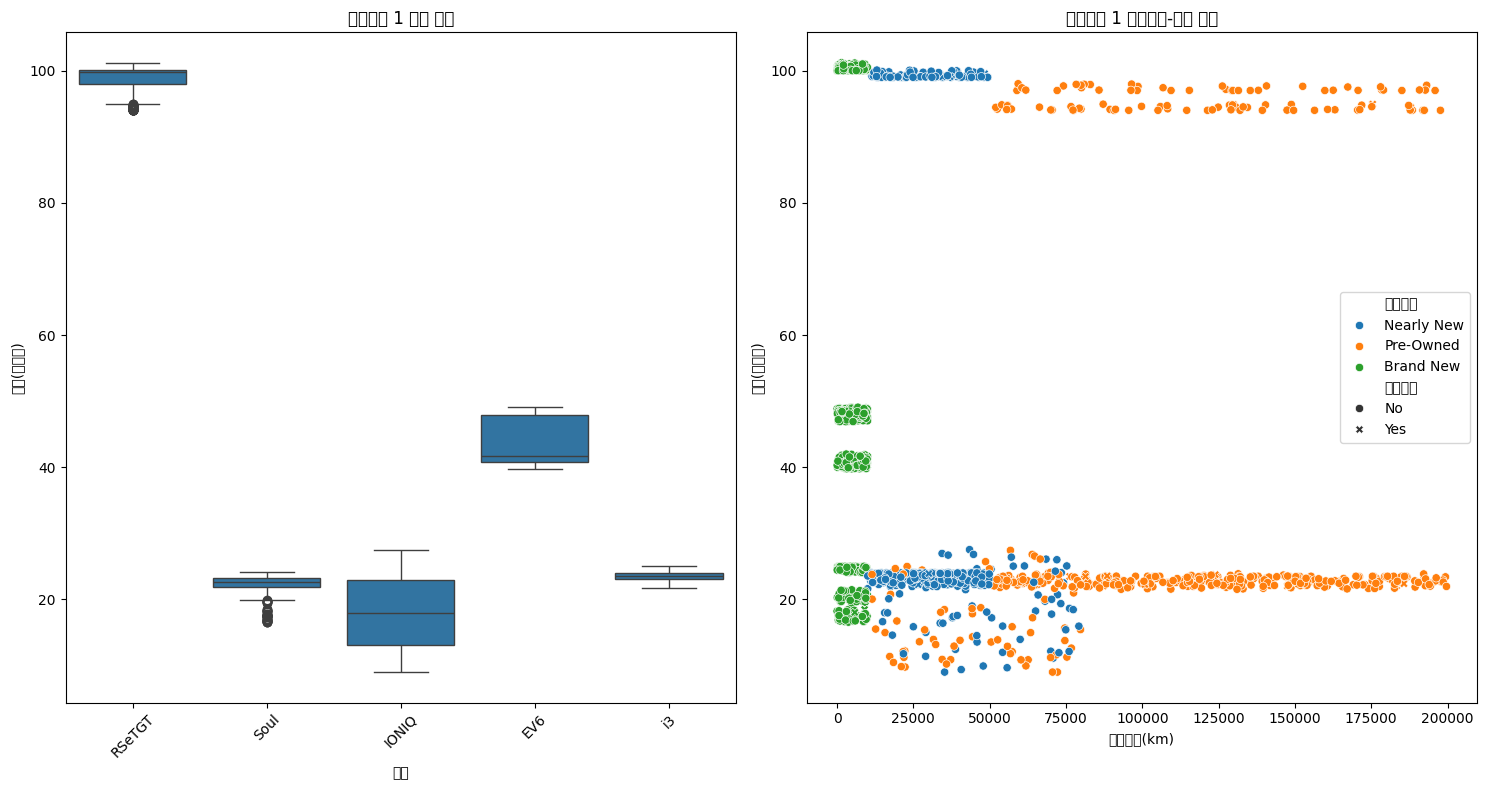


=== 준프리미엄 세그먼트(6) 이상치 분석 ===


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\1078995942.py:111: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) miss

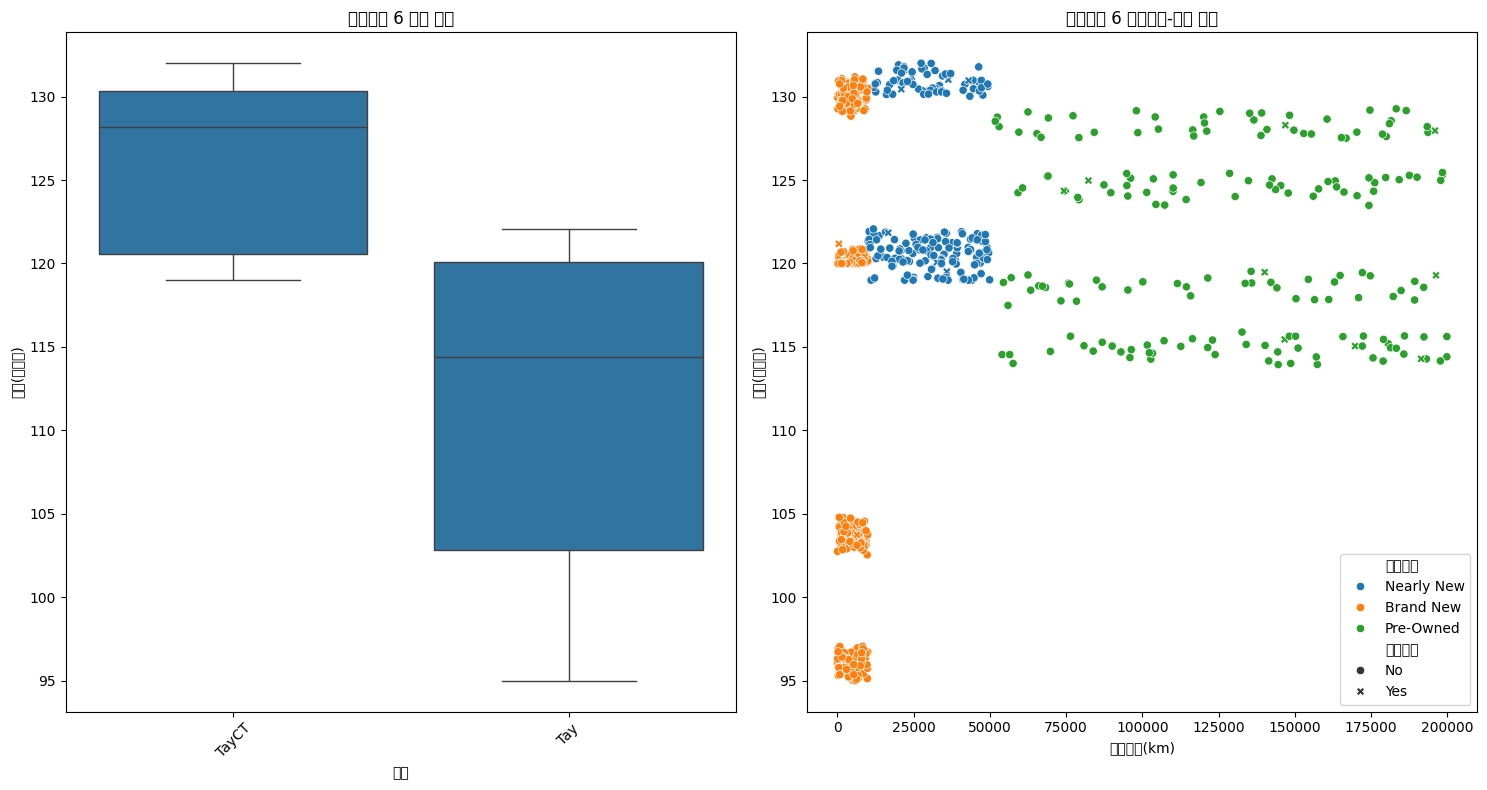

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_detailed_segment(model_name):
    """세분화된 모델 세그먼트 분류"""
    premium = ['TayGTS']
    semi_premium = ['TayCT', 'Tay']
    luxury = ['RSeGT', 'MX', 'iX']
    upper_mid = ['MS', 'MY', 'eT', 'i5']
    mid = ['Q4eT', 'M3', 'i4']
    basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
    entry = ['i3', 'Soul', 'IONIQ']
    
    if model_name in premium:
        return 7  # 프리미엄
    elif model_name in semi_premium:
        return 6  # 준프리미엄
    elif model_name in luxury:
        return 5  # 고급
    elif model_name in upper_mid:
        return 4  # 중상급
    elif model_name in mid:
        return 3  # 중급
    elif model_name in basic:
        return 2  # 보급형
    else:
        return 1  # 엔트리

def analyze_segment_outliers(df, segment_num):
    """세그먼트별 이상치 분석"""
    # 세그먼트 할당
    df['segment'] = df['모델'].apply(get_detailed_segment)
    segment_data = df[df['segment'] == segment_num]
    
    segment_names = {
        1: "엔트리",
        2: "보급형",
        3: "중급",
        4: "중상급",
        5: "고급",
        6: "준프리미엄",
        7: "프리미엄"
    }
    
    print(f"\n=== {segment_names[segment_num]} 세그먼트({segment_num}) 이상치 분석 ===")
    
    for model in segment_data['모델'].unique():
        model_data = segment_data[segment_data['모델'] == model]
        Q1 = model_data['가격(백만원)'].quantile(0.25)
        Q3 = model_data['가격(백만원)'].quantile(0.75)
        IQR = Q3 - Q1
        
        outliers = model_data[
            (model_data['가격(백만원)'] < (Q1 - 1.5 * IQR)) | 
            (model_data['가격(백만원)'] > (Q3 + 1.5 * IQR))
        ]
        
        if len(outliers) > 0:
            print(f"\n=== {model} 모델 분석 ===")
            print(f"전체 데이터 수: {len(model_data)}")
            print(f"이상치 데이터 수: {len(outliers)}")
            print(f"이상치 비율: {(len(outliers)/len(model_data)*100):.2f}%")
            print(f"\n기본 통계:")
            print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
            print(f"하한 경계: {(Q1 - 1.5 * IQR):.2f}")
            print(f"상한 경계: {(Q3 + 1.5 * IQR):.2f}")
            
            # 차량상태별 이상치 분포
            condition_dist = outliers['차량상태'].value_counts()
            print("\n차량상태별 이상치 분포:")
            print(condition_dist)
            
            # 사고이력별 이상치 분포
            accident_dist = outliers['사고이력'].value_counts()
            print("\n사고이력별 이상치 분포:")
            print(accident_dist)
            
            # 이상치 상세 정보
            print("\n이상치 상세 데이터:")
            columns = ['가격(백만원)', '주행거리(km)', '배터리용량', '차량상태', 
                      '사고이력', '연식(년)', '보증기간(년)']
            print(outliers[columns].sort_values('가격(백만원)', ascending=False).round(2))
            
            # 상관관계 분석
            print("\n이상치 데이터 상관관계:")
            numeric_cols = ['가격(백만원)', '주행거리(km)', '배터리용량', '연식(년)', '보증기간(년)']
            correlations = outliers[numeric_cols].corr()['가격(백만원)'].round(3)
            print(correlations)

def visualize_outliers(df, segment_num):
    """이상치 시각화"""
    df['segment'] = df['모델'].apply(get_detailed_segment)
    segment_data = df[df['segment'] == segment_num]
    
    plt.figure(figsize=(15, 8))
    
    # 박스플롯
    plt.subplot(1, 2, 1)
    sns.boxplot(x='모델', y='가격(백만원)', data=segment_data)
    plt.title(f'세그먼트 {segment_num} 가격 분포')
    plt.xticks(rotation=45)
    
    # 산점도
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=segment_data, x='주행거리(km)', y='가격(백만원)', 
                   hue='차량상태', style='사고이력')
    plt.title(f'세그먼트 {segment_num} 주행거리-가격 관계')
    
    plt.tight_layout()
    plt.show()

# 데이터 로드 및 분석 실행
train_data = pd.read_csv('train.csv')

# 엔트리(1)와 준프리미엄(6) 세그먼트 분석
for segment_num in [1, 6]:
    analyze_segment_outliers(train_data, segment_num)
    visualize_outliers(train_data, segment_num)

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def get_condition_weight(self, condition, model_segment):
        """세그먼트별 차량상태 가중치"""
        if model_segment == 1:  # 엔트리
            weights = {'Brand New': 3, 'Nearly New': 2, 'Pre-Owned': 1}
        elif model_segment == 6:  # 준프리미엄
            weights = {'Pre-Owned': 3, 'Nearly New': 2, 'Brand New': 1}
        else:
            weights = {'Brand New': 1.5, 'Nearly New': 1.2, 'Pre-Owned': 1}
        return weights.get(condition, 1)

    def handle_outliers(self, df):
        """이상치 처리 및 가중치 부여"""
        if '가격(백만원)' not in df.columns:
            return df  # 가격 정보가 없는 경우 그대로 반환

        df['price_weight'] = 1.0
        
        for segment in df['model_segment'].unique():
            segment_data = df[df['model_segment'] == segment]
            for model in segment_data['모델'].unique():
                model_data = segment_data[segment_data['모델'] == model]
                Q1 = model_data['가격(백만원)'].quantile(0.25)
                Q3 = model_data['가격(백만원)'].quantile(0.75)
                IQR = Q3 - Q1
                
                mask = (df['모델'] == model) & (
                    (df['가격(백만원)'] < (Q1 - 1.5 * IQR)) | 
                    (df['가격(백만원)'] > (Q3 + 1.5 * IQR))
                )
                df.loc[mask, 'price_weight'] = 0.5
        
        return df

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()  # 원본 데이터 복사
    
        # 필수 컬럼 확인
        required_columns = ['모델', '제조사', '구동방식', '차량상태', '배터리용량', 
                        '주행거리(km)', '보증기간(년)', '연식(년)', '사고이력']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        """특성 생성 및 전처리"""
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 차량상태 가중치
        df['condition_weight'] = df.apply(
            lambda x: self.get_condition_weight(x['차량상태'], x['model_segment']), 
            axis=1
        )
        
        # 이상치 처리
        df = self.handle_outliers(df)
        
        # 세그먼트별 특화 특성
        df['distance_impact'] = np.log1p(df['주행거리(km)']) * df['condition_weight']
        df['warranty_impact'] = df['보증기간(년)'] * (df['model_segment'].map(lambda x: 2 if x == 1 else 1))
        
        features = pd.DataFrame({
            'model_segment': df['model_segment'],
            'model_encoded': df['모델_encoded'],
            'manufacturer_encoded': df['제조사_encoded'],
            'condition_weight': df['condition_weight'],
            'drive_type_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean')),
            'distance_impact': df['distance_impact'],
            'warranty_impact': df['warranty_impact'],
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'price_weight': df['price_weight']
        })
        
        return features
    
    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        model = GradientBoostingRegressor(
            n_estimators=700,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.9,
            random_state=42
        )
        
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            segment_X = X[mask]
            segment_y = y[mask]
            weights = segment_X['price_weight']
            model.fit(segment_X, segment_y, sample_weight=weights)
            return model
        return None

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        cv_predictions = np.zeros_like(y)
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            # 세그먼트별 학습 및 예측
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = model.predict(X_val[mask])
                        fold_predictions[mask] = segment_pred
                        
                        # 세그먼트별 성능 계산
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            cv_predictions[val_idx] = fold_predictions
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores, cv_predictions

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores, cv_predictions = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
    
        try:
            for segment, model in self.segment_models.items():
                if model is not None:
                    mask = X['model_segment'] == segment    
                    if sum(mask) > 0:
                        predictions[mask] = model.predict(X[mask])
        except KeyError as e:
            print(f"KeyError 발생: {e}")
            print("해당 키가 없는 데이터:", test_df.columns)
            raise
    
        return predictions

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ImprovedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})

submission.to_csv('improved_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.5696, R2: 0.9982
Fold 2 - RMSE: 1.5916, R2: 0.9982
Fold 3 - RMSE: 1.4493, R2: 0.9985
Fold 4 - RMSE: 1.3437, R2: 0.9987
Fold 5 - RMSE: 1.3877, R2: 0.9984

평균 RMSE: 1.4684 (+/- 0.1957)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.8455
세그먼트 2 RMSE: 0.5333
세그먼트 3 RMSE: 0.4414
세그먼트 4 RMSE: 0.5983
세그먼트 5 RMSE: 0.6735
세그먼트 6 RMSE: 3.5614
세그먼트 7 RMSE: 0.3776


KeyError: 'price_weight'

In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def get_condition_weight(self, condition, model_segment):
        """세그먼트별 차량상태 가중치"""
        if model_segment == 1:  # 엔트리
            weights = {'Brand New': 3, 'Nearly New': 2, 'Pre-Owned': 1}
        elif model_segment == 6:  # 준프리미엄
            weights = {'Brand New': 1.2, 'Nearly New': 1.1, 'Pre-Owned': 1}
        elif model_segment == 7:  # 프리미엄
            weights = {'Brand New': 1.3, 'Nearly New': 1.2, 'Pre-Owned': 1}
        else:
            weights = {'Brand New': 1.5, 'Nearly New': 1.2, 'Pre-Owned': 1}
        return weights.get(condition, 1)

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df['price_weight'] = 1.0
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                # fit은 학습 데이터의 고유값만 사용
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:  # 테스트 데이터인 경우
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 특성 생성
        df['condition_weight'] = df.apply(
            lambda x: self.get_condition_weight(x['차량상태'], x['model_segment']), 
            axis=1
        )
        
        df['km_per_year'] = df['주행거리(km)'] / np.maximum(df['연식(년)'], 1)
        df['battery_efficiency'] = df['배터리용량'] / np.maximum(df['주행거리(km)'], 1) * 1000
        df['warranty_impact'] = df['보증기간(년)'] * df['condition_weight']
        
        features = pd.DataFrame({
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'km_per_year': df['km_per_year'],
            'battery_efficiency': df['battery_efficiency'],
            'warranty_impact': df['warranty_impact'],
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'price_weight': df['price_weight']
        })
        
        return features.fillna(0)  # 안전을 위한 최종 결측치 처리

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            # HistGradientBoostingRegressor는 결측치를 자동으로 처리
            model = HistGradientBoostingRegressor(
                max_iter=1000,
                learning_rate=0.01,
                max_depth=6,
                min_samples_leaf=5,
                random_state=42,
                validation_fraction=0.1,
                early_stopping=True,
                n_iter_no_change=50
            )
            
            segment_X = X[mask]
            segment_y = y[mask]
            model.fit(segment_X, segment_y)
            return model
        return None

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            # 세그먼트별 학습 및 예측
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = model.predict(X_val[mask])
                        fold_predictions[mask] = segment_pred
                        
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            if model is not None:
                mask = X['model_segment'] == segment
                if sum(mask) > 0:
                    predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ImprovedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})

submission.to_csv('improved_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4673, R2: 0.9984
Fold 2 - RMSE: 1.5044, R2: 0.9984
Fold 3 - RMSE: 1.4075, R2: 0.9986
Fold 4 - RMSE: 1.3624, R2: 0.9986
Fold 5 - RMSE: 1.4080, R2: 0.9984

평균 RMSE: 1.4299 (+/- 0.0999)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.8581
세그먼트 2 RMSE: 0.5265
세그먼트 3 RMSE: 0.4511
세그먼트 4 RMSE: 0.5811
세그먼트 5 RMSE: 0.6359
세그먼트 6 RMSE: 3.3955
세그먼트 7 RMSE: 0.3541


In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def get_condition_weight(self, condition, model_segment, warranty_years=0, distance_km=0):
        """세분화된 차량상태 가중치"""
        if model_segment == 1:  # 엔트리
            warranty_factor = min(warranty_years / 5, 2)  # 보증기간 가중치
            distance_factor = np.exp(-distance_km / 50000)  # 주행거리 가중치
            base_weights = {'Brand New': 2.5, 'Nearly New': 1.5, 'Pre-Owned': 1}
            return base_weights.get(condition, 1) * warranty_factor * distance_factor
        elif model_segment == 6:  # 준프리미엄
            distance_factor = np.exp(-distance_km / 100000)  # 주행거리 가중치
            base_weights = {'Brand New': 1.3, 'Nearly New': 1.2, 'Pre-Owned': 1}
            return base_weights.get(condition, 1) * distance_factor
        elif model_segment == 7:  # 프리미엄
            base_weights = {'Brand New': 1.3, 'Nearly New': 1.2, 'Pre-Owned': 1}
            return base_weights.get(condition, 1)
        else:
            base_weights = {'Brand New': 1.5, 'Nearly New': 1.2, 'Pre-Owned': 1}
            return base_weights.get(condition, 1)

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df['price_weight'] = 1.0
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:  # 테스트 데이터인 경우
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 차량상태 가중치 계산
        df['condition_weight'] = df.apply(
            lambda x: self.get_condition_weight(
                x['차량상태'], 
                x['model_segment'],
                x['보증기간(년)'],
                x['주행거리(km)']
            ), 
            axis=1
        )
        
        # 세그먼트별 특화 처리
        # 세그먼트 1 (엔트리) 특화 처리
        mask_seg1 = (df['model_segment'] == 1)
        if sum(mask_seg1) > 0:
            # 보증기간과 주행거리의 영향을 강화
            df.loc[mask_seg1, 'warranty_impact'] = df.loc[mask_seg1, '보증기간(년)'] * df.loc[mask_seg1, 'condition_weight']
            df.loc[mask_seg1, 'distance_impact'] = np.exp(-df.loc[mask_seg1, '주행거리(km)'] / 30000)
        
        # 세그먼트 6 (준프리미엄) 특화 처리
        mask_seg6 = (df['model_segment'] == 6)
        if sum(mask_seg6) > 0:
            # 주행거리 기반 가중치 조정
            df.loc[mask_seg6, 'price_weight'] = np.where(
                df.loc[mask_seg6, '주행거리(km)'] > 150000,
                0.7,  # 고주행 차량
                np.where(
                    df.loc[mask_seg6, '주행거리(km)'] < 50000,
                    1.3,  # 저주행 차량
                    1.0   # 일반 차량
                )
            )
        
        # 공통 특성 생성
        df['km_per_year'] = df['주행거리(km)'] / np.maximum(df['연식(년)'], 1)
        df['battery_efficiency'] = df['배터리용량'] / np.maximum(df['주행거리(km)'], 1) * 1000
        df['battery_age_impact'] = df['배터리용량'] * np.exp(-df['연식(년)'] * 0.1)
        
        features = pd.DataFrame({
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'km_per_year': df['km_per_year'],
            'battery_efficiency': df['battery_efficiency'],
            'battery_age_impact': df['battery_age_impact'],
            'warranty_impact': df.get('warranty_impact', df['보증기간(년)']),
            'distance_impact': df.get('distance_impact', np.exp(-df['주행거리(km)'] / 50000)),
            'age': df['연식(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'price_weight': df['price_weight']
        })
        
        return features.fillna(0)

    def get_segment_params(self, segment):
        """세그먼트별 최적 하이퍼파라미터"""
        if segment == 1:  # 엔트리
            return {
                'max_iter': 1000,
                'learning_rate': 0.01,
                'max_depth': 4,
                'min_samples_leaf': 10,
                'l2_regularization': 2.0,
                'early_stopping': True,
                'n_iter_no_change': 50
            }
        elif segment == 6:  # 준프리미엄
            return {
                'max_iter': 1200,
                'learning_rate': 0.008,
                'max_depth': 5,
                'min_samples_leaf': 8,
                'l2_regularization': 1.5,
                'early_stopping': True,
                'n_iter_no_change': 50
            }
        else:  # 기본 파라미터
            return {
                'max_iter': 1000,
                'learning_rate': 0.01,
                'max_depth': 6,
                'min_samples_leaf': 5,
                'l2_regularization': 1.0,
                'early_stopping': True,
                'n_iter_no_change': 50
            }

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            params = self.get_segment_params(segment)
            model = HistGradientBoostingRegressor(
                random_state=42,
                **params
            )
            
            segment_X = X[mask]
            segment_y = y[mask]
            model.fit(segment_X, segment_y)
            return model
        return None

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = model.predict(X_val[mask])
                        fold_predictions[mask] = segment_pred
                        
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            if model is not None:
                mask = X['model_segment'] == segment
                if sum(mask) > 0:
                    predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ImprovedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})

submission.to_csv('improved_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.7623, R2: 0.9977
Fold 2 - RMSE: 1.8967, R2: 0.9974
Fold 3 - RMSE: 1.7757, R2: 0.9977
Fold 4 - RMSE: 1.7893, R2: 0.9976
Fold 5 - RMSE: 1.9154, R2: 0.9970

평균 RMSE: 1.8279 (+/- 0.1293)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.7276
세그먼트 2 RMSE: 1.3568
세그먼트 3 RMSE: 1.9685
세그먼트 4 RMSE: 2.0420
세그먼트 5 RMSE: 0.6319
세그먼트 6 RMSE: 3.2959
세그먼트 7 RMSE: 0.3465


In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.premium_models = {}  # 세그먼트 6의 모델별 예측기
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def get_model_specific_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        features = {}
        
        if model_name == 'Tay':
            # 주행거리 구간: 0-50000, 50000-100000, 100000-150000, 150000+
            distance_ranges = [0, 50000, 100000, 150000]
            labels = ['low', 'medium', 'high', 'very_high']
        elif model_name == 'TayCT':
            # 주행거리 구간: 0-40000, 40000-80000, 80000-120000, 120000+
            distance_ranges = [0, 40000, 80000, 120000]
            labels = ['low', 'medium', 'high', 'very_high']
        else:
            return pd.DataFrame()
        
        # 주행거리 구간화
        features['distance_level'] = pd.cut(
            df['주행거리(km)'],
            bins=distance_ranges + [float('inf')],
            labels=labels,
            include_lowest=True
        ).astype(str)
        
        # 차량상태 점수화
        condition_map = {'Brand New': 3, 'Nearly New': 2, 'Pre-Owned': 1}
        features['condition_score'] = df['차량상태'].map(condition_map)
        
        # 배터리 효율성 점수
        features['battery_score'] = np.where(
            df['배터리용량'].isna(),
            0,
            df['배터리용량'] / df['배터리용량'].mean()
        )
        
        # 가격 기대값 (제조사 평균 기준)
        if '가격(백만원)' in df.columns:
            features['price_ratio'] = df['가격(백만원)'] / df['가격(백만원)'].mean()
        
        # 주행거리 영향도
        features['distance_impact'] = np.exp(-df['주행거리(km)'] / 100000)
        
        # 모든 특성을 DataFrame으로 변환
        features_df = pd.DataFrame(features)
        
        # distance_level을 one-hot 인코딩
        distance_dummies = pd.get_dummies(
            features_df['distance_level'], 
            prefix='distance'
        )
        
        # 기존 특성과 one-hot 인코딩 결과 결합
        result = pd.concat([features_df, distance_dummies], axis=1)
        
        # distance_level 컬럼 제거 (이미 one-hot으로 변환됨)
        result.drop('distance_level', axis=1, inplace=True)
        
        return result

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 기본 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)']
        }
        
        # 세그먼트 6 (준프리미엄) 특화 처리
        segment_6_features = {}
        if '모델' in df.columns:
            for model in ['Tay', 'TayCT']:
                model_mask = (df['모델'] == model)
                if sum(model_mask) > 0:
                    model_features = self.get_model_specific_features(df[model_mask], model)
                    if not model_features.empty:
                        for col in model_features.columns:
                            features[f'{model}_{col}'] = np.zeros(len(df))
                    features[f'{model}_{col}'][model_mask] = model_features[col].values

        features_df = pd.DataFrame(features).fillna(0)
        return features_df

    def train_premium_model(self, X, y, model_name):
        """준프리미엄 모델별 학습"""
        model_params = {
            'Tay': {
                'max_iter': 500,
                'learning_rate': 0.01,
                'max_depth': 5,
                'l2_regularization': 1.5
            },
            'TayCT': {
                'max_iter': 500,
                'learning_rate': 0.01,
                'max_depth': 4,
                'l2_regularization': 2.0
            }
        }
        
        # 해당 모델의 데이터만 선택
        mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
        if sum(mask) > 0:
            model = HistGradientBoostingRegressor(
                random_state=42,
                **model_params.get(model_name, model_params['Tay'])
            )
            features_to_use = [col for col in X.columns if model_name in col or col in [
                'distance', 'battery_capacity', 'age', 'warranty', 
                'accident', 'condition_encoded', 'drive_encoded'
            ]]
            model.fit(X[mask][features_to_use], y[mask])
            return model, features_to_use
        return None, None

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            if segment == 6:  # 준프리미엄 세그먼트
                models = {}
                for model in ['Tay', 'TayCT']:
                    model_obj, features = self.train_premium_model(X, y, model)
                    if model_obj is not None:
                        models[model] = (model_obj, features)
                return models
            else:  # 다른 세그먼트
                params = {
                    'max_iter': 1000,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.0,
                    'random_state': 42
                }
                # 세그먼트별 파라미터 조정
                if segment == 1:  # 엔트리
                    params.update({
                        'max_depth': 4,
                        'l2_regularization': 2.0
                    })
                model = HistGradientBoostingRegressor(**params)
                segment_X = X[mask]
                segment_y = y[mask]
                model.fit(segment_X, segment_y)
                return model
        return None

    def predict_segment_6(self, X, models):
        """준프리미엄 세그먼트 예측"""
        predictions = np.zeros(len(X))
        for model_name, (model, features) in models.items():
            mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
            if sum(mask) > 0:
                predictions[mask] = model.predict(X[mask][features])
        return predictions

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        if segment == 6:
                            segment_pred = self.predict_segment_6(X_val[mask], model)
                        else:
                            segment_pred = model.predict(X_val[mask])
                            
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                if segment == 6:
                    predictions[mask] = self.predict_segment_6(X[mask], model)
                elif model is not None:
                    predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ImprovedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})

submission.to_csv('improved_segment_submission2.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4118, R2: 0.9985
Fold 2 - RMSE: 1.4307, R2: 0.9985
Fold 3 - RMSE: 1.3346, R2: 0.9987
Fold 4 - RMSE: 1.2028, R2: 0.9989
Fold 5 - RMSE: 1.2924, R2: 0.9987

평균 RMSE: 1.3345 (+/- 0.1658)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.6854
세그먼트 2 RMSE: 0.5268
세그먼트 3 RMSE: 0.4092
세그먼트 4 RMSE: 0.6297
세그먼트 5 RMSE: 0.6116
세그먼트 6 RMSE: 3.1793
세그먼트 7 RMSE: 0.3299


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- TayCT_price_ratio
- Tay_price_ratio


In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.premium_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def get_model_specific_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        features = {}
        
        if model_name == 'Tay':
            distance_ranges = [0, 50000, 100000, 150000]
            labels = ['low', 'medium', 'high', 'very_high']
        elif model_name == 'TayCT':
            distance_ranges = [0, 40000, 80000, 120000]
            labels = ['low', 'medium', 'high', 'very_high']
        else:
            return pd.DataFrame()
        
        # 주행거리 구간화
        features['distance_level'] = pd.cut(
            df['주행거리(km)'],
            bins=distance_ranges + [float('inf')],
            labels=labels,
            include_lowest=True
        ).astype(str)
        
        # 차량상태 점수화
        condition_map = {'Brand New': 3, 'Nearly New': 2, 'Pre-Owned': 1}
        features['condition_score'] = df['차량상태'].map(condition_map)
        
        # 배터리 효율성 점수
        features['battery_score'] = np.where(
            df['배터리용량'].isna(),
            0,
            df['배터리용량'] / df['배터리용량'].mean()
        )
        
        # 주행거리 영향도
        features['distance_impact'] = np.exp(-df['주행거리(km)'] / 100000)
        
        # condition과 distance의 상호작용
        features['condition_distance'] = features['condition_score'] * features['distance_impact']
        
        # 배터리와 주행거리의 상호작용
        features['battery_distance'] = features['battery_score'] * features['distance_impact']
        
        # 모든 특성을 DataFrame으로 변환
        features_df = pd.DataFrame(features)
        
        # distance_level을 one-hot 인코딩
        distance_dummies = pd.get_dummies(
            features_df['distance_level'], 
            prefix='distance'
        )
        
        # 기존 특성과 one-hot 인코딩 결과 결합
        result = pd.concat([features_df, distance_dummies], axis=1)
        
        # distance_level 컬럼 제거
        result.drop('distance_level', axis=1, inplace=True)
        
        return result

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 기본 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)'],
            'distance_impact': np.exp(-df['주행거리(km)'] / 100000)
        }
        
        # 세그먼트 6 (준프리미엄) 특화 처리
        if '모델' in df.columns:
            for model in ['Tay', 'TayCT']:
                model_mask = (df['모델'] == model)
                if sum(model_mask) > 0:
                    model_features = self.get_model_specific_features(df[model_mask], model)
                    if not model_features.empty:
                        for col in model_features.columns:
                            features[f'{model}_{col}'] = np.zeros(len(df))
                            features[f'{model}_{col}'][model_mask] = model_features[col].values
        
        features_df = pd.DataFrame(features).fillna(0)
        return features_df

    def train_premium_model(self, X, y, model_name):
        """준프리미엄 모델별 학습"""
        model_params = {
            'Tay': {
                'max_iter': 500,
                'learning_rate': 0.01,
                'max_depth': 5,
                'l2_regularization': 1.5
            },
            'TayCT': {
                'max_iter': 500,
                'learning_rate': 0.01,
                'max_depth': 4,
                'l2_regularization': 2.0
            }
        }
        
        # 해당 모델의 데이터만 선택
        mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
        if sum(mask) > 0:
            model = HistGradientBoostingRegressor(
                random_state=42,
                **model_params.get(model_name, model_params['Tay'])
            )
            # 모델별 관련 특성만 선택
            features_to_use = [col for col in X.columns if model_name in col or col in [
                'distance', 'battery_capacity', 'age', 'warranty', 
                'accident', 'condition_encoded', 'drive_encoded', 'distance_impact'
            ]]
            model.fit(X[mask][features_to_use], y[mask])
            return model, features_to_use
        return None, None

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            if segment == 6:  # 준프리미엄 세그먼트
                models = {}
                for model in ['Tay', 'TayCT']:
                    model_obj, features = self.train_premium_model(X, y, model)
                    if model_obj is not None:
                        models[model] = (model_obj, features)
                return models
            else:  # 다른 세그먼트
                model_params = {
                    1: {  # 엔트리
                        'max_iter': 1000,
                        'learning_rate': 0.01,
                        'max_depth': 4,
                        'l2_regularization': 2.0,
                    },
                    7: {  # 프리미엄
                        'max_iter': 800,
                        'learning_rate': 0.01,
                        'max_depth': 3,
                        'l2_regularization': 1.5,
                    }
                }.get(segment, {
                    'max_iter': 1000,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.0,
                })
                
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    **model_params
                )
                segment_X = X[mask]
                segment_y = y[mask]
                model.fit(segment_X, segment_y)
                return model
        return None

    def predict_segment_6(self, X, models):
        """준프리미엄 세그먼트 예측"""
        predictions = np.zeros(len(X))
        for model_name, (model, features) in models.items():
            mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
            if sum(mask) > 0:
                predictions[mask] = model.predict(X[mask][features])
        return predictions

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        if segment == 6:
                            segment_pred = self.predict_segment_6(X_val[mask], model)
                        else:
                            segment_pred = model.predict(X_val[mask])
                            
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                if segment == 6:
                    predictions[mask] = self.predict_segment_6(X[mask], model)
                elif model is not None:
                    predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ImprovedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})

submission.to_csv('improved_segment_submission2.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4042, R2: 0.9986
Fold 2 - RMSE: 1.4293, R2: 0.9985
Fold 3 - RMSE: 1.3482, R2: 0.9987
Fold 4 - RMSE: 1.2253, R2: 0.9989
Fold 5 - RMSE: 1.3232, R2: 0.9986

평균 RMSE: 1.3461 (+/- 0.1426)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.6888
세그먼트 2 RMSE: 0.5266
세그먼트 3 RMSE: 0.4090
세그먼트 4 RMSE: 0.6297
세그먼트 5 RMSE: 0.6114
세그먼트 6 RMSE: 3.2278
세그먼트 7 RMSE: 0.3265


In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.premium_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        self.model_stats = {}
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def handle_premium_outliers(self, df, model_name):
        """준프리미엄 세그먼트 이상치 처리"""
        df = df.copy()
        if model_name == 'Tay':
            # 15만km 이상 주행한 Pre-Owned 차량 가중치 조정
            high_mileage_mask = (df['주행거리(km)'] > 150000) & (df['차량상태'] == 'Pre-Owned')
            df.loc[high_mileage_mask, 'price_weight'] *= 0.7
            
            # 주행거리 대비 가격이 비정상적으로 높은 경우
            if '가격(백만원)' in df.columns:
                expected_price = 122 - (df['주행거리(km)'] / 20000)
                price_diff = np.abs(df['가격(백만원)'] - expected_price)
                df.loc[price_diff > 15, 'price_weight'] *= 0.8
                
        elif model_name == 'TayCT':
            # 주행거리 구간별 가중치 조정
            df.loc[df['주행거리(km)'] > 120000, 'price_weight'] *= 0.7
            df.loc[(df['주행거리(km)'] > 80000) & (df['주행거리(km)'] <= 120000), 'price_weight'] *= 0.85
            
            if '가격(백만원)' in df.columns:
                brand_new_mask = df['차량상태'] == 'Brand New'
                brand_new_mean = df.loc[brand_new_mask, '가격(백만원)'].mean()
                brand_new_std = df.loc[brand_new_mask, '가격(백만원)'].std()
                price_outlier_mask = np.abs(df['가격(백만원)'] - brand_new_mean) > 2 * brand_new_std
                df.loc[brand_new_mask & price_outlier_mask, 'price_weight'] *= 0.8
        
        return df

    def handle_entry_outliers(self, df):
        """엔트리 세그먼트 이상치 처리"""
        df = df.copy()
        # IONIQ 특별 처리
        ioniq_mask = df['모델'] == 'IONIQ'
        if sum(ioniq_mask) > 0 and '가격(백만원)' in df.columns:
            ioniq_mean = df[ioniq_mask]['가격(백만원)'].mean()
            ioniq_std = df[ioniq_mask]['가격(백만원)'].std()
            outlier_mask = np.abs(df[ioniq_mask]['가격(백만원)'] - ioniq_mean) > 2 * ioniq_std
            df.loc[ioniq_mask & outlier_mask, 'price_weight'] *= 0.7
        
        # Soul의 고보증기간 차량 처리
        soul_mask = (df['모델'] == 'Soul') & (df['보증기간(년)'] >= 9)
        df.loc[soul_mask, 'warranty_factor'] = 1.2
        
        return df
    
    def get_model_specific_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        features = {}
        
        if model_name == 'Tay':
            distance_ranges = [0, 50000, 100000, 150000]
            labels = ['low', 'medium', 'high', 'very_high']
            # Tay 모델별 파라미터
            decay_factor = 80000
            condition_weights = {'Brand New': 3.5, 'Nearly New': 2.5, 'Pre-Owned': 1}
        elif model_name == 'TayCT':
            distance_ranges = [0, 40000, 80000, 120000]
            labels = ['low', 'medium', 'high', 'very_high']
            # TayCT 모델별 파라미터
            decay_factor = 60000
            condition_weights = {'Brand New': 3, 'Nearly New': 2, 'Pre-Owned': 1}
        else:
            return pd.DataFrame()
        
        # 주행거리 구간화
        features['distance_level'] = pd.cut(
            df['주행거리(km)'],
            bins=distance_ranges + [float('inf')],
            labels=labels,
            include_lowest=True
        ).astype(str)
        
        # 차량상태 점수화
        features['condition_score'] = df['차량상태'].map(condition_weights)
        
        # 배터리 효율성 점수
        features['battery_score'] = np.where(
            df['배터리용량'].isna(),
            0,
            df['배터리용량'] / df['배터리용량'].mean()
        )
        
        # 주행거리 영향도
        features['distance_impact'] = np.exp(-df['주행거리(km)'] / decay_factor)
        
        # 보증기간과 연식의 상호작용
        features['warranty_age_ratio'] = df['보증기간(년)'] / np.maximum(df['연식(년)'], 1)
        
        # 배터리와 주행거리의 상호작용
        features['battery_efficiency'] = features['battery_score'] * features['distance_impact']
        
        # 차량상태와 주행거리의 상호작용
        features['condition_distance'] = features['condition_score'] * features['distance_impact']
        
        # 모든 특성을 DataFrame으로 변환
        features_df = pd.DataFrame(features)
        
        # distance_level을 one-hot 인코딩
        distance_dummies = pd.get_dummies(
            features_df['distance_level'], 
            prefix='distance'
        )
        
        # 기존 특성과 one-hot 인코딩 결과 결합
        result = pd.concat([features_df, distance_dummies], axis=1)
        result.drop('distance_level', axis=1, inplace=True)
        
        return result

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 기본 가중치 초기화
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        # 결측치 처리
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 이상치 처리
        premium_mask = df['model_segment'] == 6
        entry_mask = df['model_segment'] == 1
        
        if sum(premium_mask) > 0:
            for model in ['Tay', 'TayCT']:
                model_mask = df['모델'] == model
                if sum(model_mask) > 0:
                    df.loc[model_mask] = self.handle_premium_outliers(df[model_mask], model)
        
        if sum(entry_mask) > 0:
            df.loc[entry_mask] = self.handle_entry_outliers(df[entry_mask])
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])

        # 기본 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'] * df['warranty_factor'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)'],
            'price_weight': df['price_weight']
        }

    # create_features 메소드의 마지막 부분부터 이어서...
        
        # 세그먼트별 특화 특성
        if '모델' in df.columns:
            for model in ['Tay', 'TayCT']:
                model_mask = (df['모델'] == model)
                if sum(model_mask) > 0:
                    model_features = self.get_model_specific_features(df[model_mask], model)
                    if not model_features.empty:
                        for col in model_features.columns:
                            features[f'{model}_{col}'] = np.zeros(len(df))
                            features[f'{model}_{col}'][model_mask] = model_features[col].values
        
        features_df = pd.DataFrame(features).fillna(0)
        return features_df

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            if segment == 6:  # 준프리미엄 세그먼트
                models = {}
                for model in ['Tay', 'TayCT']:
                    mask = X['model_encoded'] == self.label_encoders['모델'].transform([model])[0]
                    if sum(mask) > 0:
                        params = {
                            'Tay': {
                                'max_iter': 800,
                                'learning_rate': 0.008,
                                'max_depth': 5,
                                'l2_regularization': 1.8
                            },
                            'TayCT': {
                                'max_iter': 600,
                                'learning_rate': 0.01,
                                'max_depth': 4,
                                'l2_regularization': 2.0
                            }
                        }[model]
                        
                        model_cols = [col for col in X.columns if model in col or col in [
                            'distance', 'battery_capacity', 'age', 'warranty', 
                            'accident', 'condition_encoded', 'drive_encoded',
                            'price_weight'
                        ]]
                        
                        regressor = HistGradientBoostingRegressor(
                            random_state=42,
                            **params
                        )
                        
                        model_X = X[mask][model_cols]
                        model_y = y[mask]
                        weights = X[mask]['price_weight'] if 'price_weight' in X.columns else None
                        
                        regressor.fit(model_X, model_y, sample_weight=weights)
                        models[model] = (regressor, model_cols)
                return models
            else:
                params = {
                    1: {  # 엔트리
                        'max_iter': 1200,
                        'learning_rate': 0.008,
                        'max_depth': 4,
                        'l2_regularization': 2.0,
                    },
                    7: {  # 프리미엄
                        'max_iter': 800,
                        'learning_rate': 0.01,
                        'max_depth': 3,
                        'l2_regularization': 1.5,
                    }
                }.get(segment, {
                    'max_iter': 1000,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.0,
                })
                
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    **params
                )
                segment_X = X[mask]
                segment_y = y[mask]
                weights = X[mask]['price_weight'] if 'price_weight' in X.columns else None
                
                model.fit(segment_X, segment_y, sample_weight=weights)
                return model
        return None

    def predict_segment_6(self, X, models):
        """준프리미엄 세그먼트 예측"""
        predictions = np.zeros(len(X))
        for model_name, (model, cols) in models.items():
            mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
            if sum(mask) > 0:
                predictions[mask] = model.predict(X[mask][cols])
        return predictions

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        if segment == 6:
                            segment_pred = self.predict_segment_6(X_val[mask], model)
                        else:
                            segment_pred = model.predict(X_val[mask])
                            
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                if segment == 6:
                    predictions[mask] = self.predict_segment_6(X[mask], model)
                elif model is not None:
                    predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

predictor = ImprovedSegmentPredictor()
predictor.fit(train_data)

predictions = predictor.predict(test_data)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    '가격(백만원)': predictions
})

submission.to_csv('improved_segment_submission3.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.3933, R2: 0.9986
Fold 2 - RMSE: 1.4280, R2: 0.9985
Fold 3 - RMSE: 1.3493, R2: 0.9987
Fold 4 - RMSE: 1.2280, R2: 0.9989
Fold 5 - RMSE: 1.3270, R2: 0.9986

평균 RMSE: 1.3451 (+/- 0.1364)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.6780
세그먼트 2 RMSE: 0.5268
세그먼트 3 RMSE: 0.4092
세그먼트 4 RMSE: 0.6297
세그먼트 5 RMSE: 0.6116
세그먼트 6 RMSE: 3.2380
세그먼트 7 RMSE: 0.3261


In [59]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.premium_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        self.model_stats = {}
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1
        
    def handle_premium_outliers(self, df, model_name):
        """준프리미엄 세그먼트 이상치 처리"""
        df = df.copy()
        
        if model_name == 'Tay':
            # 주행거리 구간별 가중치
            high_mileage_mask = (df['주행거리(km)'] > 150000) & (df['차량상태'] == 'Pre-Owned')
            medium_mileage_mask = (df['주행거리(km)'] > 100000) & (df['주행거리(km)'] <= 150000)
            df.loc[high_mileage_mask, 'price_weight'] *= 0.65
            df.loc[medium_mileage_mask, 'price_weight'] *= 0.8
            
            # 차량상태와 연식 복합 가중치
            if '가격(백만원)' in df.columns:
                age_factor = np.exp(-0.15 * df['연식(년)'])
                df['price_weight'] *= age_factor
                
                # 배터리 효율성 고려
                battery_efficiency = df['배터리용량'] / (df['주행거리(km)'] + 5000)
                df.loc[battery_efficiency < battery_efficiency.quantile(0.25), 'price_weight'] *= 0.9
                
        elif model_name == 'TayCT':
            # 개선된 주행거리 구간별 가중치
            df.loc[df['주행거리(km)'] > 120000, 'price_weight'] *= 0.65
            df.loc[(df['주행거리(km)'] > 80000) & (df['주행거리(km)'] <= 120000), 'price_weight'] *= 0.8
            df.loc[(df['주행거리(km)'] > 40000) & (df['주행거리(km)'] <= 80000), 'price_weight'] *= 0.9
            
            # 차량상태별 세분화된 가중치
            if '가격(백만원)' in df.columns:
                condition_weights = {
                    'Brand New': 1.1,
                    'Nearly New': 1.0,
                    'Pre-Owned': 0.85
                }
                df['price_weight'] *= df['차량상태'].map(condition_weights)
                
                # 배터리 용량과 주행거리 관계 고려
                battery_distance_ratio = df['배터리용량'] / np.log1p(df['주행거리(km)'])
                df.loc[battery_distance_ratio < battery_distance_ratio.median(), 'price_weight'] *= 0.9
        
        return df

    def handle_entry_outliers(self, df):
        """엔트리 세그먼트 이상치 처리"""
        df = df.copy()
        
        # IONIQ 특별 처리 개선
        ioniq_mask = df['모델'] == 'IONIQ'
        if sum(ioniq_mask) > 0 and '가격(백만원)' in df.columns:
            # 연식 기반 가격 조정
            df.loc[ioniq_mask, 'price_weight'] *= np.exp(-0.1 * df.loc[ioniq_mask, '연식(년)'])
            
            # 주행거리 기반 가격 조정
            distance_factor = 1 - (df.loc[ioniq_mask, '주행거리(km)'] / 200000)
            df.loc[ioniq_mask, 'price_weight'] *= np.maximum(0.7, distance_factor)
            
            # 배터리 상태 고려
            battery_factor = df.loc[ioniq_mask, '배터리용량'] / df.loc[ioniq_mask, '배터리용량'].mean()
            df.loc[ioniq_mask, 'price_weight'] *= np.minimum(1.2, np.maximum(0.8, battery_factor))
        
        # Soul 모델 특화 처리
        soul_mask = df['모델'] == 'Soul'
        if sum(soul_mask) > 0:
            # 배터리 상태에 따른 보증 가중치 조정
            df.loc[soul_mask, 'warranty_factor'] = np.where(
                df.loc[soul_mask, '배터리용량'] > df.loc[soul_mask, '배터리용량'].mean(),
                1.3,  # 배터리 용량이 평균 이상인 경우
                1.1   # 배터리 용량이 평균 미만인 경우
            )
            
            # 주행거리와 연식의 복합 가중치
            age_distance_factor = 1 - (
                0.3 * df.loc[soul_mask, '연식(년)'] / 10 +
                0.7 * df.loc[soul_mask, '주행거리(km)'] / 150000
            )
            df.loc[soul_mask, 'price_weight'] *= np.maximum(0.75, age_distance_factor)
            
            # 사고이력 고려
            df.loc[soul_mask & (df['사고이력'] == 'Yes'), 'price_weight'] *= 0.9
        
        return df
    
    def get_model_specific_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        features = {}
        
        if model_name == 'Tay':
            # 주행거리 구간을 더 세분화
            distance_ranges = [0, 30000, 60000, 90000, 120000, 150000]
            labels = ['very_low', 'low', 'medium', 'high', 'very_high', 'extreme']
            
            # 차량상태별 가중치 조정
            condition_weights = {
                'Brand New': 4.0,    # 증가
                'Nearly New': 2.8,   # 증가
                'Pre-Owned': 1.0
            }
            
            # 추가: 연식과 주행거리의 비율
            features['age_distance_ratio'] = df['연식(년)'] / (df['주행거리(km)'] + 1000)
            
            # 추가: 보증기간과 배터리용량의 상호작용
            features['warranty_battery_score'] = (df['보증기간(년)'] + 1) * (df['배터리용량'] / df['배터리용량'].mean())
            
            # 배터리 효율성 개선
            features['battery_efficiency'] = df['배터리용량'] / np.log1p(df['주행거리(km)'])
            
        elif model_name == 'TayCT':
            # TayCT만의 특별한 구간화
            distance_ranges = [0, 25000, 50000, 75000, 100000]
            labels = ['very_low', 'low', 'medium', 'high', 'very_high']
            
            # TayCT 특화 가중치
            condition_weights = {
                'Brand New': 3.5,
                'Nearly New': 2.5,
                'Pre-Owned': 1.0
            }
            
            # 추가: 배터리 성능 지수
            features['battery_performance_index'] = (
                df['배터리용량'] * 0.7 + 
                (150000 - df['주행거리(km)']) / 150000 * 0.3
            )
            
            # 추가: 보증-연식-주행거리 복합 지수
            features['warranty_age_distance'] = (
                df['보증기간(년)'] * 0.4 +
                (10 - df['연식(년)']) * 0.3 +
                (100000 - df['주행거리(km)']) / 100000 * 0.3
            )
        else:
            return pd.DataFrame()
        
        # 주행거리 구간화
        features['distance_level'] = pd.cut(
            df['주행거리(km)'],
            bins=distance_ranges + [float('inf')],
            labels=labels,
            include_lowest=True
        ).astype(str)
        
        # 차량상태 점수화
        features['condition_score'] = df['차량상태'].map(condition_weights)
        
        # 배터리 상태 점수
        features['battery_score'] = np.where(
            df['배터리용량'].isna(),
            0,
            df['배터리용량'] / df['배터리용량'].mean()
        )
        
        # 주행거리 영향도 개선
        features['distance_impact'] = 1 / (1 + np.exp((df['주행거리(km)'] - 75000) / 25000))
        
        # 보증기간과 연식의 상호작용
        features['warranty_age_ratio'] = df['보증기간(년)'] / np.maximum(df['연식(년)'], 1)
        
        # 차량상태와 주행거리의 상호작용
        features['condition_distance'] = features['condition_score'] * features['distance_impact']
        
        # 모든 특성을 DataFrame으로 변환
        features_df = pd.DataFrame(features)
        
        # distance_level을 one-hot 인코딩
        distance_dummies = pd.get_dummies(
            features_df['distance_level'], 
            prefix='distance'
        )
        
        # 기존 특성과 one-hot 인코딩 결과 결합
        result = pd.concat([features_df, distance_dummies], axis=1)
        result.drop('distance_level', axis=1, inplace=True)
        
        return result
    
    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 기본 가중치 초기화
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        # 결측치 처리
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 이상치 처리
        premium_mask = df['model_segment'] == 6
        entry_mask = df['model_segment'] == 1
        
        if sum(premium_mask) > 0:
            for model in ['Tay', 'TayCT']:
                model_mask = df['모델'] == model
                if sum(model_mask) > 0:
                    df.loc[model_mask] = self.handle_premium_outliers(df[model_mask], model)
        
        if sum(entry_mask) > 0:
            df.loc[entry_mask] = self.handle_entry_outliers(df[entry_mask])
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])

        # 기본 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'] * df['warranty_factor'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)'],
            'price_weight': df['price_weight']
        }
        
        # 세그먼트별 특화 특성
        if '모델' in df.columns:
            for model in ['Tay', 'TayCT']:
                model_mask = (df['모델'] == model)
                if sum(model_mask) > 0:
                    model_features = self.get_model_specific_features(df[model_mask], model)
                    if not model_features.empty:
                        for col in model_features.columns:
                            features[f'{model}_{col}'] = np.zeros(len(df))
                            features[f'{model}_{col}'][model_mask] = model_features[col].values
        
        features_df = pd.DataFrame(features).fillna(0)
        return features_df
    
    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            if segment == 6:  # 준프리미엄 세그먼트
                models = {}
                for model in ['Tay', 'TayCT']:
                    mask = X['model_encoded'] == self.label_encoders['모델'].transform([model])[0]
                    if sum(mask) > 0:
                        params = {
                            'Tay': {
                                'max_iter': 1000,       # 증가
                                'learning_rate': 0.006, # 감소
                                'max_depth': 6,         # 증가
                                'l2_regularization': 2.0# 증가
                            },
                            'TayCT': {
                                'max_iter': 800,
                                'learning_rate': 0.008,
                                'max_depth': 5,
                                'l2_regularization': 2.2
                            }
                        }[model]
                        
                        model_cols = [col for col in X.columns if model in col or col in [
                            'distance', 'battery_capacity', 'age', 'warranty', 
                            'accident', 'condition_encoded', 'drive_encoded',
                            'price_weight'
                        ]]
                        
                        regressor = HistGradientBoostingRegressor(
                            random_state=42,
                            **params
                        )
                        
                        model_X = X[mask][model_cols]
                        model_y = y[mask]
                        weights = X[mask]['price_weight'] if 'price_weight' in X.columns else None
                        
                        regressor.fit(model_X, model_y, sample_weight=weights)
                        models[model] = (regressor, model_cols)
                return models
            else:
                params = {
                    1: {  # 엔트리
                        'max_iter': 1500,           # 증가
                        'learning_rate': 0.006,     # 감소
                        'max_depth': 5,             # 증가
                        'l2_regularization': 2.5    # 증가
                    },
                    7: {  # 프리미엄
                        'max_iter': 800,
                        'learning_rate': 0.01,
                        'max_depth': 3,
                        'l2_regularization': 1.5,
                    }
                }.get(segment, {
                    'max_iter': 1000,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.0,
                })
                
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    **params
                )
                segment_X = X[mask]
                segment_y = y[mask]
                weights = X[mask]['price_weight'] if 'price_weight' in X.columns else None
                
                model.fit(segment_X, segment_y, sample_weight=weights)
                return model
        return None

    def predict_segment_6(self, X, models):
        """준프리미엄 세그먼트 예측"""
        predictions = np.zeros(len(X))
        for model_name, (model, cols) in models.items():
            mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
            if sum(mask) > 0:
                predictions[mask] = model.predict(X[mask][cols])
        return predictions

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        if segment == 6:
                            segment_pred = self.predict_segment_6(X_val[mask], model)
                        else:
                            segment_pred = model.predict(X_val[mask])
                            
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                if segment == 6:
                    predictions[mask] = self.predict_segment_6(X[mask], model)
                elif model is not None:
                    predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = ImprovedSegmentPredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('improved_segment_submission4.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.3907, R2: 0.9986
Fold 2 - RMSE: 1.4466, R2: 0.9985
Fold 3 - RMSE: 1.3365, R2: 0.9987
Fold 4 - RMSE: 1.2418, R2: 0.9989
Fold 5 - RMSE: 1.3218, R2: 0.9986

평균 RMSE: 1.3475 (+/- 0.1375)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.6922
세그먼트 2 RMSE: 0.5268
세그먼트 3 RMSE: 0.4092
세그먼트 4 RMSE: 0.6297
세그먼트 5 RMSE: 0.6116
세그먼트 6 RMSE: 3.2319
세그먼트 7 RMSE: 0.3261


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Tay_distance_very_high


In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class DepreciationBasedPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1
            
    def get_premium_features(self, df):
        """준프리미엄 세그먼트 특성 생성"""
        features = df.copy()
        
        # 기준가격 설정
        base_prices = {
            'Tay': 125,    # 1억 2500만원
            'TayCT': 95    # 9500만원
        }
        
        features.loc[:, 'base_price'] = features['모델'].map(base_prices).fillna(0)
        features.loc[:, 'age_depreciation'] = -0.2 * (features['연식(년)'] / 5)
        features.loc[:, 'distance_depreciation'] = -0.3 * (features['주행거리(km)'] / 100000)
        features.loc[:, 'battery_depreciation'] = -0.15 * (1 - features['배터리용량'] / features['배터리용량'].max())
        
        # 차량상태 보정계수
        condition_factor = {
            'Brand New': 1.0,
            'Nearly New': 0.95,
            'Pre-Owned': 0.85
        }
        features.loc[:, 'condition_factor'] = features['차량상태'].map(condition_factor)
        
        # 배터리 효율성
        features.loc[:, 'battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
        
        # 총 감가상각률
        features.loc[:, 'total_depreciation'] = (
            features['age_depreciation'] + 
            features['distance_depreciation'] + 
            features['battery_depreciation']
        ) * features['condition_factor']
        
        # 예상 가격
        features.loc[:, 'expected_price'] = features['base_price'] * (1 + features['total_depreciation'])
        
        return features
        
    def get_entry_features(self, df):
        """엔트리 세그먼트 특성 생성"""
        features = df.copy()
        
        # 모델별 기준가격
        model_base = {
            'IONIQ': 45,  # 4500만원
            'Soul': 42,   # 4200만원
            'i3': 48      # 4800만원
        }
        features.loc[:, 'base_price'] = features['모델'].map(model_base).fillna(0)
        
        # 연식별 감가율 (비선형)
        features.loc[:, 'age_depreciation'] = np.where(
            features['연식(년)'] <= 2,
            -0.1 * features['연식(년)'],
            -0.2 * features['연식(년)']
        )
        
        # 주행거리 기반 가격조정
        features.loc[:, 'distance_factor'] = np.clip(
            1 - (features['주행거리(km)'] / 150000) ** 0.7,
            0.6,
            1.0
        )
        
        # 배터리 상태 점수
        features.loc[:, 'battery_score'] = np.clip(
            features['배터리용량'] / features['배터리용량'].mean(),
            0.8,
            1.2
        )
        
        # 사고이력 가중치
        features.loc[:, 'accident_factor'] = np.where(features['사고이력'] == 'Yes', 0.9, 1.0)
        
        # 예상 가격
        features.loc[:, 'expected_price'] = (
            features['base_price'] * 
            (1 + features['age_depreciation']) * 
            features['distance_factor'] * 
            features['battery_score'] * 
            features['accident_factor']
        )
        
        return features

    def create_features(self, df):
        """전체 특성 생성"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        features['segment'] = features['모델'].apply(self.get_segment)
        
        # 세그먼트별 특성 생성
        premium_mask = features['segment'] == 6
        entry_mask = features['segment'] == 1
        
        if sum(premium_mask) > 0:
            premium_features = self.get_premium_features(features[premium_mask])
            for col in premium_features.columns:
                if col not in features.columns:
                    features.loc[premium_mask, col] = premium_features[col]
        
        if sum(entry_mask) > 0:
            entry_features = self.get_entry_features(features[entry_mask])
            for col in entry_features.columns:
                if col not in features.columns:
                    features.loc[entry_mask, col] = entry_features[col]
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 최종 특성 선택
        feature_cols = [
            'segment', '제조사_encoded', '모델_encoded', '구동방식_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'
        ]
        
        if 'base_price' in features.columns:
            feature_cols.extend(['base_price', 'expected_price'])
            
        if 'total_depreciation' in features.columns:
            feature_cols.extend(['total_depreciation'])
            
        if 'battery_efficiency' in features.columns:
            feature_cols.extend(['battery_efficiency'])
            
        if 'distance_factor' in features.columns:
            feature_cols.extend(['distance_factor'])
        
        return features[feature_cols].fillna(0)

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['segment'] == segment
        if sum(mask) > 0:
            if segment == 6:  # 준프리미엄 세그먼트
                params = {
                    'max_iter': 1000,
                    'learning_rate': 0.005,
                    'max_depth': 5,
                    'l2_regularization': 2.5
                }
            elif segment == 1:  # 엔트리 세그먼트
                params = {
                    'max_iter': 1200,
                    'learning_rate': 0.005,
                    'max_depth': 4,
                    'l2_regularization': 3.0
                }
            else:
                params = {
                    'max_iter': 1000,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.0
                }
            
            model = HistGradientBoostingRegressor(random_state=42, **params)
            segment_X = X[mask]
            segment_y = y[mask]
            
            model.fit(segment_X, segment_y)
            return model
            
        return None

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = model.predict(X_val[mask])
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            mask = X['segment'] == segment
            if sum(mask) > 0 and model is not None:
                predictions[mask] = model.predict(X[mask])
        
        return predictions
    
# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = DepreciationBasedPredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('depreciation_based_submission4.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.3915, R2: 0.9986
Fold 2 - RMSE: 1.4722, R2: 0.9984
Fold 3 - RMSE: 1.4566, R2: 0.9984
Fold 4 - RMSE: 1.2231, R2: 0.9989
Fold 5 - RMSE: 1.3473, R2: 0.9985

평균 RMSE: 1.3781 (+/- 0.1793)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.6725
세그먼트 2 RMSE: 0.5268
세그먼트 3 RMSE: 0.4268
세그먼트 4 RMSE: 0.6281
세그먼트 5 RMSE: 0.6280
세그먼트 6 RMSE: 3.3879
세그먼트 7 RMSE: 0.3319


In [62]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer

def tune_segment_hyperparameters(X, y, segment_id):
    """세그먼트별 하이퍼파라미터 튜닝"""
    
    # 세그먼트별 파라미터 그리드 설정
    if segment_id == 6:  # 준프리미엄
        param_grid = {
            'max_iter': [1000, 1500, 2000],
            'learning_rate': [0.005, 0.007, 0.01, 0.015],
            'max_depth': [5, 6, 7, 8],
            'l2_regularization': [1.0, 1.5, 2.0, 2.5]
        }
    elif segment_id == 1:  # 엔트리
        param_grid = {
            'max_iter': [1200, 1500, 2000],
            'learning_rate': [0.005, 0.007, 0.01],
            'max_depth': [4, 5, 6, 7],
            'l2_regularization': [1.5, 2.0, 2.5, 3.0]
        }
    else:  # 다른 세그먼트
        param_grid = {
            'max_iter': [800, 1000, 1200],
            'learning_rate': [0.008, 0.01, 0.012],
            'max_depth': [5, 6, 7],
            'l2_regularization': [0.8, 1.0, 1.2]
        }
    
    # 기본 모델 설정
    base_model = HistGradientBoostingRegressor(random_state=42)
    
    # RMSE 스코어러 생성
    rmse_scorer = make_scorer(
        lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
        greater_is_better=False
    )
    
    # GridSearchCV 설정
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring=rmse_scorer,
        n_jobs=-1,
        verbose=1
    )
    
    # 그리드 서치 수행
    grid_search.fit(X, y)
    
    # 결과 출력
    print(f"\n=== 세그먼트 {segment_id} 최적 파라미터 ===")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best RMSE: {-grid_search.best_score_:.4f}")
    
    return grid_search.best_params_, -grid_search.best_score_

def prepare_segment_data(train_df, segment_id):
    """세그먼트별 데이터 준비"""
    # 라벨 인코더 준비
    label_encoders = {}
    for col in ['제조사', '모델', '구동방식', '차량상태']:
        label_encoders[col] = LabelEncoder()
        label_encoders[col].fit(train_df[col])
        
    # 세그먼트 필터링
    segment_mask = train_df['segment'] == segment_id
    segment_data = train_df[segment_mask].copy()
    
    # 특성 생성
    for col in ['제조사', '모델', '구동방식', '차량상태']:
        segment_data[f'{col}_encoded'] = label_encoders[col].transform(segment_data[col])
    
    # 수치형 특성 선택
    feature_cols = [
        '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
        '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded'
    ]
    
    X = segment_data[feature_cols]
    y = segment_data['가격(백만원)']
    
    return X, y

# 메인 실행
if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    
    # 세그먼트 할당
    def get_segment(model_name):
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1
    
    train_data['segment'] = train_data['모델'].apply(get_segment)
    
    # 결측치 처리
    train_data['배터리용량'] = train_data.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
    
    # 세그먼트별 하이퍼파라미터 튜닝
    all_results = {}
    for segment in range(1, 8):
        print(f"\n=== 세그먼트 {segment} 튜닝 시작 ===")
        X, y = prepare_segment_data(train_data, segment)
        best_params, best_rmse = tune_segment_hyperparameters(X, y, segment)
        all_results[segment] = {
            'params': best_params,
            'rmse': best_rmse
        }
    
    # 결과 정리 및 저장
    results_df = pd.DataFrame([
        {
            'segment': segment,
            **results['params'],
            'rmse': results['rmse']
        }
        for segment, results in all_results.items()
    ])
    
    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
    print("\n=== 전체 결과 ===")
    print(results_df)


=== 세그먼트 1 튜닝 시작 ===
Fitting 5 folds for each of 144 candidates, totalling 720 fits

=== 세그먼트 1 최적 파라미터 ===
Best parameters: {'l2_regularization': 1.5, 'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 2000}
Best RMSE: -1.8309

=== 세그먼트 2 튜닝 시작 ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits

=== 세그먼트 2 최적 파라미터 ===
Best parameters: {'l2_regularization': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'max_iter': 1200}
Best RMSE: -0.5398

=== 세그먼트 3 튜닝 시작 ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits

=== 세그먼트 3 최적 파라미터 ===
Best parameters: {'l2_regularization': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'max_iter': 1200}
Best RMSE: -0.4296

=== 세그먼트 4 튜닝 시작 ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits

=== 세그먼트 4 최적 파라미터 ===
Best parameters: {'l2_regularization': 1.2, 'learning_rate': 0.012, 'max_depth': 5, 'max_iter': 1200}
Best RMSE: -0.6338

=== 세그먼트 5 튜닝 시작 ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [63]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class OptimizedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 세그먼트별 최적 하이퍼파라미터
        self.segment_params = {
            1: {
                'max_iter': 2000,
                'learning_rate': 0.01,
                'max_depth': 7,
                'l2_regularization': 1.5
            },
            2: {
                'max_iter': 1200,
                'learning_rate': 0.012,
                'max_depth': 7,
                'l2_regularization': 0.8
            },
            3: {
                'max_iter': 1200,
                'learning_rate': 0.012,
                'max_depth': 7,
                'l2_regularization': 0.8
            },
            4: {
                'max_iter': 1200,
                'learning_rate': 0.012,
                'max_depth': 5,
                'l2_regularization': 1.2
            },
            5: {
                'max_iter': 1200,
                'learning_rate': 0.012,
                'max_depth': 7,
                'l2_regularization': 1.2
            },
            6: {
                'max_iter': 2000,
                'learning_rate': 0.015,
                'max_depth': 8,
                'l2_regularization': 1.5
            },
            7: {
                'max_iter': 1200,
                'learning_rate': 0.012,
                'max_depth': 7,
                'l2_regularization': 1.2
            }
        }
    
    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_features(self, df):
        """특성 생성"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        features['segment'] = features['모델'].apply(self.get_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        # 특성 선택
        feature_cols = [
            'segment',
            '제조사_encoded',
            '모델_encoded',
            '구동방식_encoded',
            '차량상태_encoded',
            '배터리용량',
            '주행거리(km)',
            '보증기간(년)',
            '연식(년)'
        ]

        # 세그먼트 6 (준프리미엄)을 위한 추가 특성
        premium_mask = features['segment'] == 6
        if sum(premium_mask) > 0:
            # 배터리 효율성
            features.loc[:, 'battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
            # 연식-주행거리 상호작용
            features.loc[:, 'age_distance_ratio'] = features['연식(년)'] / np.log1p(features['주행거리(km)'])
            feature_cols.extend(['battery_efficiency', 'age_distance_ratio'])
        
        return features[feature_cols]

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['segment'] == segment
        if sum(mask) > 0:
            params = self.segment_params[segment]
            model = HistGradientBoostingRegressor(
                random_state=42,
                **params
            )
            segment_X = X[mask]
            segment_y = y[mask]
            
            model.fit(segment_X, segment_y)
            return model
            
        return None

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = model.predict(X_val[mask])
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, model in self.segment_models.items():
            mask = X['segment'] == segment
            if sum(mask) > 0 and model is not None:
                predictions[mask] = model.predict(X[mask])
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = OptimizedSegmentPredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('optimized_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.5081, R2: 0.9983
Fold 2 - RMSE: 1.5496, R2: 0.9983
Fold 3 - RMSE: 1.4168, R2: 0.9985
Fold 4 - RMSE: 1.2688, R2: 0.9988
Fold 5 - RMSE: 1.4306, R2: 0.9984

평균 RMSE: 1.4348 (+/- 0.1928)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.8322
세그먼트 2 RMSE: 0.5319
세그먼트 3 RMSE: 0.4231
세그먼트 4 RMSE: 0.6694
세그먼트 5 RMSE: 0.6204
세그먼트 6 RMSE: 3.4110
세그먼트 7 RMSE: 0.3365


In [64]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class EnsembleSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.rf_models = {}  # Random Forest 모델
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Random Forest 파라미터
        self.rf_params = {
            6: {  # 준프리미엄
                'n_estimators': 200,
                'max_depth': 12,
                'min_samples_split': 10,
                'min_samples_leaf': 4,
                'random_state': 42
            },
            1: {  # 엔트리
                'n_estimators': 150,
                'max_depth': 10,
                'min_samples_split': 8,
                'min_samples_leaf': 3,
                'random_state': 42
            }
        }
        
        # HGBR 파라미터
        self.hgb_params = {
            6: {
                'max_iter': 2000,
                'learning_rate': 0.015,
                'max_depth': 8,
                'l2_regularization': 1.5
            },
            1: {
                'max_iter': 2000,
                'learning_rate': 0.01,
                'max_depth': 7,
                'l2_regularization': 1.5
            }
        }
        
        # 앙상블 가중치
        self.ensemble_weights = {
            6: {'hgb': 0.3, 'rf': 0.7},  # 준프리미엄
            1: {'hgb': 0.4, 'rf': 0.6}   # 엔트리
        }

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_features(self, df):
        """특성 생성"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        features['segment'] = features['모델'].apply(self.get_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        # 기본 특성
        feature_cols = [
            'segment',
            '제조사_encoded',
            '모델_encoded',
            '구동방식_encoded',
            '차량상태_encoded',
            '배터리용량',
            '주행거리(km)',
            '보증기간(년)',
            '연식(년)'
        ]
        
        # 세그먼트별 특화 특성
        for segment in [1, 6]:
            segment_mask = features['segment'] == segment
            if sum(segment_mask) > 0:
                # 배터리 효율성
                features.loc[:, 'battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
                # 연식-주행거리 상호작용
                features.loc[:, 'age_distance_ratio'] = features['연식(년)'] / np.log1p(features['주행거리(km)'])
                # 배터리-보증 상호작용
                features.loc[:, 'battery_warranty'] = features['배터리용량'] * features['보증기간(년)']
                # 주행거리 구간화
                features.loc[:, 'distance_group'] = pd.qcut(features['주행거리(km)'], q=5, labels=False, duplicates='drop')
                
                feature_cols.extend([
                    'battery_efficiency',
                    'age_distance_ratio',
                    'battery_warranty',
                    'distance_group'
                ])

        return features[feature_cols]

    def train_models(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['segment'] == segment
        if sum(mask) > 0:
            if segment in [1, 6]:  # 앙상블 적용 세그먼트
                # HGBR 모델
                hgb = HistGradientBoostingRegressor(
                    random_state=42,
                    **self.hgb_params[segment]
                )
                
                # Random Forest 모델
                rf = RandomForestRegressor(
                    **self.rf_params[segment]
                )
                
                segment_X = X[mask]
                segment_y = y[mask]
                
                hgb.fit(segment_X, segment_y)
                rf.fit(segment_X, segment_y)
                
                return {'hgb': hgb, 'rf': rf}
            else:  # 기본 HGBR 모델
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    max_iter=1200,
                    learning_rate=0.012,
                    max_depth=7,
                    l2_regularization=1.2
                )
                segment_X = X[mask]
                segment_y = y[mask]
                model.fit(segment_X, segment_y)
                return model
        return None

    def predict_segment(self, X, models, segment):
        """세그먼트별 예측"""
        if segment in [1, 6]:  # 앙상블 적용 세그먼트
            hgb_pred = models['hgb'].predict(X)
            rf_pred = models['rf'].predict(X)
            weights = self.ensemble_weights[segment]
            return weights['hgb'] * hgb_pred + weights['rf'] * rf_pred
        else:
            return models.predict(X)

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 8):
                models = self.train_models(X_train, y_train, segment)
                if models is not None:
                    mask = X_val['segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = self.predict_segment(X_val[mask], models, segment)
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_models(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, models in self.segment_models.items():
            mask = X['segment'] == segment
            if sum(mask) > 0 and models is not None:
                predictions[mask] = self.predict_segment(X[mask], models, segment)
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = EnsembleSegmentPredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('ensemble_segment_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4666, R2: 0.9984
Fold 2 - RMSE: 1.5089, R2: 0.9984
Fold 3 - RMSE: 1.3637, R2: 0.9986
Fold 4 - RMSE: 1.2763, R2: 0.9988
Fold 5 - RMSE: 1.3589, R2: 0.9985

평균 RMSE: 1.3949 (+/- 0.1660)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.7378
세그먼트 2 RMSE: 0.5310
세그먼트 3 RMSE: 0.4215
세그먼트 4 RMSE: 0.7128
세그먼트 5 RMSE: 0.6222
세그먼트 6 RMSE: 3.3353
세그먼트 7 RMSE: 0.3375


In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class RefinedEnsemblePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.rf_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Random Forest 파라미터
        self.rf_params = {
            8: {  # Premium Sport (TayCT)
                'n_estimators': 200,
                'max_depth': 10,
                'min_samples_split': 8,
                'min_samples_leaf': 3,
                'random_state': 42
            },
            6: {  # Premium Sedan (Tay)
                'n_estimators': 200,
                'max_depth': 12,
                'min_samples_split': 10,
                'min_samples_leaf': 4,
                'random_state': 42
            },
            1: {  # 엔트리
                'n_estimators': 150,
                'max_depth': 10,
                'min_samples_split': 8,
                'min_samples_leaf': 3,
                'random_state': 42
            }
        }
        
        # HGBR 파라미터
        self.hgb_params = {
            8: {  # Premium Sport
                'max_iter': 2000,
                'learning_rate': 0.012,
                'max_depth': 7,
                'l2_regularization': 1.2
            },
            6: {  # Premium Sedan
                'max_iter': 2000,
                'learning_rate': 0.015,
                'max_depth': 8,
                'l2_regularization': 1.5
            },
            1: {  # 엔트리
                'max_iter': 2000,
                'learning_rate': 0.01,
                'max_depth': 7,
                'l2_regularization': 1.5
            }
        }
        
        # 앙상블 가중치
        self.ensemble_weights = {
            8: {'hgb': 0.4, 'rf': 0.6},  # Premium Sport
            6: {'hgb': 0.3, 'rf': 0.7},  # Premium Sedan
            1: {'hgb': 0.4, 'rf': 0.6}   # 엔트리
        }

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        premium_sport = ['TayCT']    # 새로운 세그먼트 (8)
        premium_sedan = ['Tay']      # 새로운 세그먼트 (6)
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in premium_sport:
            return 8
        elif model_name in premium_sedan:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_features(self, df):
        """특성 생성"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        features['segment'] = features['모델'].apply(self.get_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        # 기본 특성
        feature_cols = [
            'segment',
            '제조사_encoded',
            '모델_encoded',
            '구동방식_encoded',
            '차량상태_encoded',
            '배터리용량',
            '주행거리(km)',
            '보증기간(년)',
            '연식(년)'
        ]
        
        # 세그먼트별 특화 특성
        for segment in [1, 6, 8]:
            segment_mask = features['segment'] == segment
            if sum(segment_mask) > 0:
                # 배터리 효율성
                features.loc[:, 'battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
                # 연식-주행거리 상호작용
                features.loc[:, 'age_distance_ratio'] = features['연식(년)'] / np.log1p(features['주행거리(km)'])
                # 배터리-보증 상호작용
                features.loc[:, 'battery_warranty'] = features['배터리용량'] * features['보증기간(년)']
                # 주행거리 구간화
                features.loc[:, 'distance_group'] = pd.qcut(features['주행거리(km)'], q=5, labels=False, duplicates='drop')
                
                # Premium Sport (TayCT) 특화 특성
                if segment == 8:
                    features.loc[:, 'performance_score'] = (
                        features['배터리용량'] * 0.4 +
                        (100000 - features['주행거리(km)'])/100000 * 0.3 +
                        (10 - features['연식(년)'])/10 * 0.3
                    )
                
                # Premium Sedan (Tay) 특화 특성
                if segment == 6:
                    features.loc[:, 'luxury_score'] = (
                        features['배터리용량'] * 0.3 +
                        (150000 - features['주행거리(km)'])/150000 * 0.4 +
                        (10 - features['연식(년)'])/10 * 0.3
                    )
                
                feature_cols.extend([
                    'battery_efficiency',
                    'age_distance_ratio',
                    'battery_warranty',
                    'distance_group'
                ])
                
                if segment == 8:
                    feature_cols.append('performance_score')
                if segment == 6:
                    feature_cols.append('luxury_score')

        return features[feature_cols]

    def train_models(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['segment'] == segment
        if sum(mask) > 0:
            if segment in [1, 6, 8]:  # 앙상블 적용 세그먼트
                # HGBR 모델
                hgb = HistGradientBoostingRegressor(
                    random_state=42,
                    **self.hgb_params[segment]
                )
                
                # Random Forest 모델
                rf = RandomForestRegressor(
                    **self.rf_params[segment]
                )
                
                segment_X = X[mask]
                segment_y = y[mask]
                
                hgb.fit(segment_X, segment_y)
                rf.fit(segment_X, segment_y)
                
                return {'hgb': hgb, 'rf': rf}
            else:  # 기본 HGBR 모델
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    max_iter=1200,
                    learning_rate=0.012,
                    max_depth=7,
                    l2_regularization=1.2
                )
                segment_X = X[mask]
                segment_y = y[mask]
                model.fit(segment_X, segment_y)
                return model
        return None

    def predict_segment(self, X, models, segment):
        """세그먼트별 예측"""
        if segment in [1, 6, 8]:  # 앙상블 적용 세그먼트
            hgb_pred = models['hgb'].predict(X)
            rf_pred = models['rf'].predict(X)
            weights = self.ensemble_weights[segment]
            return weights['hgb'] * hgb_pred + weights['rf'] * rf_pred
        else:
            return models.predict(X)

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 9)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 9):
                models = self.train_models(X_train, y_train, segment)
                if models is not None:
                    mask = X_val['segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = self.predict_segment(X_val[mask], models, segment)
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 9):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 9):
            self.segment_models[segment] = self.train_models(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, models in self.segment_models.items():
            mask = X['segment'] == segment
            if sum(mask) > 0 and models is not None:
                predictions[mask] = self.predict_segment(X[mask], models, segment)
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = RefinedEnsemblePredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('refined_ensemble_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4600, R2: 0.9984
Fold 2 - RMSE: 1.5314, R2: 0.9983
Fold 3 - RMSE: 1.3601, R2: 0.9986
Fold 4 - RMSE: 1.2871, R2: 0.9988
Fold 5 - RMSE: 1.3625, R2: 0.9985

평균 RMSE: 1.4002 (+/- 0.1712)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.7365
세그먼트 2 RMSE: 0.5318
세그먼트 3 RMSE: 0.4198
세그먼트 4 RMSE: 0.7043
세그먼트 5 RMSE: 0.6347
세그먼트 6 RMSE: 2.9119
세그먼트 7 RMSE: 0.3438
세그먼트 8 RMSE: 3.7826


In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class RefinedEnsemblePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.rf_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Random Forest 파라미터
        self.rf_params = {
            8: {  # TayCT
                'n_estimators': 300,
                'max_depth': 8,
                'min_samples_split': 5,
                'min_samples_leaf': 4,
                'random_state': 42
            },
            6: {  # Premium Sedan (Tay)
                'n_estimators': 200,
                'max_depth': 12,
                'min_samples_split': 10,
                'min_samples_leaf': 4,
                'random_state': 42
            },
            1: {  # 엔트리
                'n_estimators': 150,
                'max_depth': 10,
                'min_samples_split': 8,
                'min_samples_leaf': 3,
                'random_state': 42
            }
        }
        
        # HGBR 파라미터
        self.hgb_params = {
            8: {  # TayCT
                'max_iter': 2500,
                'learning_rate': 0.008,
                'max_depth': 6,
                'l2_regularization': 2.0
            },
            6: {  # Tay
                'max_iter': 2000,
                'learning_rate': 0.015,
                'max_depth': 8,
                'l2_regularization': 1.5
            },
            1: {  # 엔트리
                'max_iter': 2000,
                'learning_rate': 0.01,
                'max_depth': 7,
                'l2_regularization': 1.5
            }
        }
        
        # 앙상블 가중치
        self.ensemble_weights = {
            8: {'hgb': 0.2, 'rf': 0.8},  # TayCT - RF 가중치 증가
            6: {'hgb': 0.3, 'rf': 0.7},  # Tay
            1: {'hgb': 0.4, 'rf': 0.6}   # 엔트리
        }

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        premium_sport = ['TayCT']
        premium_sedan = ['Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in premium_sport:
            return 8
        elif model_name in premium_sedan:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_features(self, df):
        """특성 생성"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        features['segment'] = features['모델'].apply(self.get_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        # 기본 특성
        feature_cols = [
            'segment',
            '제조사_encoded',
            '모델_encoded',
            '구동방식_encoded',
            '차량상태_encoded',
            '배터리용량',
            '주행거리(km)',
            '보증기간(년)',
            '연식(년)'
        ]
        
        # 세그먼트별 특화 특성
        for segment in [1, 6, 8]:
            segment_mask = features['segment'] == segment
            if sum(segment_mask) > 0:
                # 배터리 효율성
                features.loc[:, 'battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
                # 연식-주행거리 상호작용
                features.loc[:, 'age_distance_ratio'] = features['연식(년)'] / np.log1p(features['주행거리(km)'])
                # 배터리-보증 상호작용
                features.loc[:, 'battery_warranty'] = features['배터리용량'] * features['보증기간(년)']
                
                feature_cols.extend([
                    'battery_efficiency',
                    'age_distance_ratio',
                    'battery_warranty'
                ])
                
                # TayCT 특화 특성
                if segment == 8:
                    # 차량상태별 기본가격 설정
                    base_price = {
                        'Brand New': 120,
                        'Nearly New': 100,
                        'Pre-Owned': 85
                    }
                    features.loc[segment_mask, 'base_price'] = features.loc[segment_mask, '차량상태'].map(base_price)
                    
                    # 주행거리 감가율 (더 급격한 감소)
                    features.loc[segment_mask, 'mileage_factor'] = np.exp(-features.loc[segment_mask, '주행거리(km)'] / 50000)
                    
                    # 연식 감가율
                    features.loc[segment_mask, 'age_factor'] = np.exp(-0.2 * features.loc[segment_mask, '연식(년)'])
                    
                    # 최종 성능 점수
                    features.loc[segment_mask, 'performance_score'] = (
                        features.loc[segment_mask, 'base_price'] * 
                        features.loc[segment_mask, 'mileage_factor'] * 
                        features.loc[segment_mask, 'age_factor']
                    )
                    
                    feature_cols.extend(['base_price', 'mileage_factor', 'age_factor', 'performance_score'])
                
                # Tay 특화 특성
                if segment == 6:
                    features.loc[:, 'luxury_score'] = (
                        features['배터리용량'] * 0.3 +
                        (150000 - features['주행거리(km)'])/150000 * 0.4 +
                        (10 - features['연식(년)'])/10 * 0.3
                    )
                    feature_cols.append('luxury_score')

        return features[feature_cols]

    def train_models(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['segment'] == segment
        if sum(mask) > 0:
            if segment in [1, 6, 8]:  # 앙상블 적용 세그먼트
                # HGBR 모델
                hgb = HistGradientBoostingRegressor(
                    random_state=42,
                    **self.hgb_params[segment]
                )
                
                # Random Forest 모델
                rf = RandomForestRegressor(
                    **self.rf_params[segment]
                )
                
                segment_X = X[mask]
                segment_y = y[mask]
                
                hgb.fit(segment_X, segment_y)
                rf.fit(segment_X, segment_y)
                
                return {'hgb': hgb, 'rf': rf}
            else:  # 기본 HGBR 모델
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    max_iter=1200,
                    learning_rate=0.012,
                    max_depth=7,
                    l2_regularization=1.2
                )
                segment_X = X[mask]
                segment_y = y[mask]
                model.fit(segment_X, segment_y)
                return model
        return None

    def predict_segment(self, X, models, segment):
        """세그먼트별 예측"""
        if segment in [1, 6, 8]:  # 앙상블 적용 세그먼트
            hgb_pred = models['hgb'].predict(X)
            rf_pred = models['rf'].predict(X)
            weights = self.ensemble_weights[segment]
            return weights['hgb'] * hgb_pred + weights['rf'] * rf_pred
        else:
            return models.predict(X)

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 9)}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for segment in range(1, 9):
                models = self.train_models(X_train, y_train, segment)
                if models is not None:
                    mask = X_val['segment'] == segment
                    if sum(mask) > 0:
                        segment_pred = self.predict_segment(X_val[mask], models, segment)
                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 9):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment} RMSE: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        cv_scores = self.cv_evaluate(X, y)
        
        # 최종 모델 학습
        for segment in range(1, 9):
            self.segment_models[segment] = self.train_models(X, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for segment, models in self.segment_models.items():
            mask = X['segment'] == segment
            if sum(mask) > 0 and models is not None:
                predictions[mask] = self.predict_segment(X[mask], models, segment)
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = RefinedEnsemblePredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('refined_ensemble_submission_v2.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4595, R2: 0.9984
Fold 2 - RMSE: 1.5222, R2: 0.9983
Fold 3 - RMSE: 1.3589, R2: 0.9986
Fold 4 - RMSE: 1.2858, R2: 0.9988
Fold 5 - RMSE: 1.3610, R2: 0.9985

평균 RMSE: 1.3975 (+/- 0.1666)

=== 세그먼트별 RMSE ===
세그먼트 1 RMSE: 1.7380
세그먼트 2 RMSE: 0.5327
세그먼트 3 RMSE: 0.4195
세그먼트 4 RMSE: 0.7056
세그먼트 5 RMSE: 0.6349
세그먼트 6 RMSE: 2.9198
세그먼트 7 RMSE: 0.3441
세그먼트 8 RMSE: 3.7514


In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class PriceBasedPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.condition_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 차량상태별 모델 파라미터
        self.model_params = {
            'Brand New': {
                'rf': {
                    'n_estimators': 300,
                    'max_depth': 8,
                    'min_samples_split': 5,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 2500,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            },
            'Nearly New': {
                'rf': {
                    'n_estimators': 250,
                    'max_depth': 7,
                    'min_samples_split': 6,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 2000,
                    'learning_rate': 0.01,
                    'max_depth': 5,
                    'l2_regularization': 1.8,
                    'random_state': 42
                }
            },
            'Pre-Owned': {
                'rf': {
                    'n_estimators': 200,
                    'max_depth': 6,
                    'min_samples_split': 8,
                    'min_samples_leaf': 5,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 1800,
                    'learning_rate': 0.012,
                    'max_depth': 4,
                    'l2_regularization': 1.5,
                    'random_state': 42
                }
            }
        }
        
        # 앙상블 가중치
        self.ensemble_weights = {
            'Brand New': {'hgb': 0.3, 'rf': 0.7},
            'Nearly New': {'hgb': 0.4, 'rf': 0.6},
            'Pre-Owned': {'hgb': 0.5, 'rf': 0.5}
        }

    def handle_outliers(self, df):
        """이상치 처리"""
        df = df.copy()
        df['price_weight'] = 1.0
        
        # TayCT 모델 특별 처리
        tayct_mask = df['모델'] == 'TayCT'
        if sum(tayct_mask) > 0:
            # 주행거리 기반 이상치 처리
            distance_data = df.loc[tayct_mask, '주행거리(km)']
            q1 = distance_data.quantile(0.25)
            q3 = distance_data.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            distance_outlier_mask = (distance_data < lower_bound) | (distance_data > upper_bound)
            df.loc[tayct_mask & distance_outlier_mask, 'price_weight'] *= 0.8
            
            # 연식 기반 이상치 처리
            age_data = df.loc[tayct_mask, '연식(년)']
            age_q3 = age_data.quantile(0.75)
            df.loc[tayct_mask & (age_data > age_q3), 'price_weight'] *= 0.9
        
        return df

    def get_price_segment(self, price):
        """가격대 기반 세그먼트 분류"""
        if price >= 90:
            return 'high'
        elif price >= 60:
            return 'mid'
        else:
            return 'low'

    def create_nonlinear_features(self, df):
        """비선형 특성 생성"""
        features = df.copy()
        
        # 거리 기반 비선형 특성
        features['distance_exp'] = np.exp(-features['주행거리(km)'] / 50000)
        features['distance_log'] = np.log1p(features['주행거리(km)'])
        features['distance_sqrt'] = np.sqrt(features['주행거리(km)'])
        
        # 연식 기반 비선형 특성
        features['age_exp'] = np.exp(-features['연식(년)'] / 2)
        features['age_squared'] = features['연식(년)'] ** 2
        
        # 배터리 효율성 특성
        features['battery_efficiency'] = features['배터리용량'] / features['distance_log']
        
        # 복합 특성
        features['age_distance_interaction'] = features['age_exp'] * features['distance_exp']
        features['battery_age_interaction'] = features['배터리용량'] * features['age_exp']
        
        return features

    def create_features(self, df):
        """특성 생성"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 이상치 처리
        features = self.handle_outliers(features)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        # 비선형 특성 생성
        features = self.create_nonlinear_features(features)
        
        # 최종 특성 선택
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            'distance_exp', 'distance_log', 'distance_sqrt',
            'age_exp', 'age_squared',
            'battery_efficiency',
            'age_distance_interaction', 'battery_age_interaction',
            'price_weight'
        ]
        
        return features[feature_cols]

    def train_condition_model(self, X, y, condition):
        """차량상태별 모델 학습"""
        # Random Forest 모델
        rf = RandomForestRegressor(**self.model_params[condition]['rf'])
        
        # HGBR 모델
        hgb = HistGradientBoostingRegressor(**self.model_params[condition]['hgb'])
        
        # 가중치 적용
        weights = X['price_weight'] if 'price_weight' in X.columns else None
        
        # 모델 학습
        rf.fit(X, y, sample_weight=weights)
        hgb.fit(X, y, sample_weight=weights)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_condition(self, X, models, condition):
        """차량상태별 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        weights = self.ensemble_weights[condition]
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred

    def cv_evaluate(self, X, y, conditions):
        """교차 검증 평가"""
        cv_scores = []
        condition_scores = {condition: [] for condition in conditions}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            conditions_train = conditions.iloc[train_idx]
            conditions_val = conditions.iloc[val_idx]
            
            fold_predictions = np.zeros_like(y_val)
            
            for condition in self.model_params.keys():
                condition_mask_train = conditions_train == condition
                condition_mask_val = conditions_val == condition
                
                if sum(condition_mask_train) > 0 and sum(condition_mask_val) > 0:
                    models = self.train_condition_model(
                        X_train[condition_mask_train],
                        y_train[condition_mask_train],
                        condition
                    )
                    
                    predictions = self.predict_condition(
                        X_val[condition_mask_val],
                        models,
                        condition
                    )
                    
                    fold_predictions[condition_mask_val] = predictions
                    
                    condition_rmse = np.sqrt(mean_squared_error(
                        y_val[condition_mask_val],
                        predictions
                    ))
                    condition_scores[condition].append(condition_rmse)
            
            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 차량상태별 RMSE ===")
        for condition in condition_scores:
            if condition_scores[condition]:
                mean_score = np.mean(condition_scores[condition])
                print(f"{condition}: {mean_score:.4f}")
        
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        conditions = train_df['차량상태']
        
        cv_scores = self.cv_evaluate(X, y, conditions)
        
        # 최종 모델 학습
        for condition in self.model_params.keys():
            condition_mask = conditions == condition
            if sum(condition_mask) > 0:
                self.condition_models[condition] = self.train_condition_model(
                    X[condition_mask],
                    y[condition_mask],
                    condition
                )
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))
        
        for condition, models in self.condition_models.items():
            condition_mask = test_df['차량상태'] == condition
            if sum(condition_mask) > 0:
                predictions[condition_mask] = self.predict_condition(
                    X[condition_mask],
                    models,
                    condition
                )
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = PriceBasedPredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('price_based_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 2.2406, R2: 0.9963
Fold 2 - RMSE: 3.4030, R2: 0.9916
Fold 3 - RMSE: 1.8504, R2: 0.9975
Fold 4 - RMSE: 2.1617, R2: 0.9965
Fold 5 - RMSE: 2.2554, R2: 0.9959

평균 RMSE: 2.3822 (+/- 1.0620)

=== 차량상태별 RMSE ===
Nearly New: 2.1350
Brand New: 2.8347
Pre-Owned: 1.5042


In [75]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ModelSpecificPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model_specific_predictors = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 모델별 하이퍼파라미터
        self.model_params = {
            'RSeTGT': {
                'rf': {
                    'n_estimators': 200,
                    'max_depth': 8,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.5,
                    'random_state': 42
                }
            },
            'Soul': {
                'rf': {
                    'n_estimators': 150,
                    'max_depth': 7,
                    'min_samples_split': 6,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 1200,
                    'learning_rate': 0.008,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            },
            'TayCT': {
                'rf': {
                    'n_estimators': 300,
                    'max_depth': 8,
                    'min_samples_split': 5,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            }
        }
        
        # 기본 하이퍼파라미터
        self.default_params = {
            'rf': {
                'n_estimators': 200,
                'max_depth': 7,
                'min_samples_split': 6,
                'min_samples_leaf': 3,
                'random_state': 42
            },
            'hgb': {
                'max_iter': 1500,
                'learning_rate': 0.01,
                'max_depth': 6,
                'l2_regularization': 1.5,
                'random_state': 42
            }
        }
        
        # 앙상블 가중치
        self.ensemble_weights = {
            'RSeTGT': {'hgb': 0.4, 'rf': 0.6},
            'Soul': {'hgb': 0.3, 'rf': 0.7},
            'TayCT': {'hgb': 0.2, 'rf': 0.8},
            'default': {'hgb': 0.4, 'rf': 0.6}
        }

    def handle_outliers_by_model(self, df, model_name):
        """모델별 이상치 처리"""
        df = df.copy()
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        if model_name == 'RSeTGT':
            # Pre-Owned 차량의 가격 조정
            mask = (df['차량상태'] == 'Pre-Owned') & (df['가격(백만원)'] < 95)
            df.loc[mask, 'price_weight'] = 0.9
            
            # 결측된 배터리용량 처리
            df['배터리용량'] = df['배터리용량'].fillna(78.23)
            
            # 주행거리 기반 가중치
            df['distance_factor'] = np.exp(-df['주행거리(km)'] / 150000)
            df['price_weight'] *= df['distance_factor']
            
        elif model_name == 'Soul':
            # Brand New + 높은 보증기간 차량 처리
            mask = (df['차량상태'] == 'Brand New') & (df['보증기간(년)'] >= 9)
            df.loc[mask, 'price_weight'] = 1.1
            
            # 보증기간 영향력 반영
            df['warranty_factor'] = np.exp(-0.1 * df['보증기간(년)'])
            
            # 주행거리 영향 감소
            df['distance_factor'] = np.exp(-df['주행거리(km)'] / 200000)
            df['price_weight'] *= df['distance_factor']
            
        elif model_name == 'TayCT':
            # 차량상태별 기본가격 조정
            condition_factor = {
                'Brand New': 1.1,
                'Nearly New': 1.0,
                'Pre-Owned': 0.85
            }
            df['condition_factor'] = df['차량상태'].map(condition_factor)
            df['price_weight'] *= df['condition_factor']
            
            # 주행거리 기반 가중치 (더 급격한 감소)
            df['distance_factor'] = np.exp(-df['주행거리(km)'] / 50000)
            df['price_weight'] *= df['distance_factor']
            
            # 연식 기반 가중치
            df['age_factor'] = np.exp(-0.2 * df['연식(년)'])
            df['price_weight'] *= df['age_factor']
        
        return df

    def create_model_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        features = df.copy()
        
        # 기본 특성
        features['distance_norm'] = features['주행거리(km)'] / 100000
        features['battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
        
        if model_name == 'RSeTGT':
            # 주행거리 구간화
            features['distance_group'] = pd.qcut(
                features['주행거리(km)'],
                q=5,
                labels=['very_low', 'low', 'medium', 'high', 'very_high'],
                duplicates='drop'
            )
            
            # 배터리 효율성 점수
            features['battery_score'] = features['배터리용량'] / features['배터리용량'].mean()
            
        elif model_name == 'Soul':
            # 보증기간-연식 상호작용
            features['warranty_age_ratio'] = features['보증기간(년)'] / np.maximum(features['연식(년)'], 1)
            
            # 배터리 상태 점수
            features['battery_score'] = np.clip(
                features['배터리용량'] / features['배터리용량'].mean(),
                0.8,
                1.2
            )
            
        elif model_name == 'TayCT':
            # 성능 점수
            features['performance_score'] = (
                features['배터리용량'] * 0.4 +
                (100000 - features['주행거리(km)'])/100000 * 0.3 +
                (10 - features['연식(년)'])/10 * 0.3
            )
            
            # 주행거리 구간별 감가율
            features['distance_depreciation'] = np.where(
                features['주행거리(km)'] <= 50000,
                0.95,
                np.where(
                    features['주행거리(km)'] <= 100000,
                    0.85,
                    0.75
                )
            )
        
        return features

    def prepare_features(self, df, model_name=None):
        """특성 준비"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 이상치 처리
        if model_name is not None:
            features = self.handle_outliers_by_model(features, model_name)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(features[col].unique())
                if '가격(백만원)' not in features.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 모델별 특화 특성 생성
        if model_name is not None:
            features = self.create_model_features(features, model_name)
        
        # 기본 특성 선택
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            'price_weight'
        ]
        
        # 모델별 추가 특성
        if model_name == 'RSeTGT':
            feature_cols.extend(['battery_score', 'distance_norm'])
        elif model_name == 'Soul':
            feature_cols.extend(['warranty_age_ratio', 'battery_score', 'warranty_factor'])
        elif model_name == 'TayCT':
            feature_cols.extend(['performance_score', 'distance_depreciation'])
        
        return features[feature_cols]

    def train_model(self, X, y, model_name=None):
        """모델 학습"""
        if model_name in self.model_params:
            params = self.model_params[model_name]
        else:
            params = self.default_params
        
        # Random Forest 모델
        rf = RandomForestRegressor(**params['rf'])
        
        # HGBR 모델
        hgb = HistGradientBoostingRegressor(**params['hgb'])
        
        # 가중치 적용
        weights = X['price_weight'] if 'price_weight' in X.columns else None
        
        # 모델 학습
        rf.fit(X, y, sample_weight=weights)
        hgb.fit(X, y, sample_weight=weights)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, model_name=None):
        """모델 예측"""
        if model_name in self.ensemble_weights:
            weights = self.ensemble_weights[model_name]
        else:
            weights = self.ensemble_weights['default']
        
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred

    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            for model_name in train_data['모델'].unique():
                # 모델별 데이터 준비
                model_mask_train = train_data['모델'] == model_name
                model_mask_val = val_data['모델'] == model_name
                
                if sum(model_mask_train) > 0 and sum(model_mask_val) > 0:
                    X_train = self.prepare_features(train_data[model_mask_train], model_name)
                    y_train = train_data[model_mask_train]['가격(백만원)']
                    
                    X_val = self.prepare_features(val_data[model_mask_val], model_name)
                    y_val = val_data[model_mask_val]['가격(백만원)']
                    
                    # 모델 학습 및 예측
                    models = self.train_model(X_train, y_train, model_name)
                    predictions = self.predict_model(X_val, models, model_name)
                    
                    # 예측값 저장
                    fold_predictions[model_mask_val] = predictions
                    
                    # 모델별 성능 기록
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name, scores in model_scores.items():
            print(f"{model_name}: {np.mean(scores):.4f}")
        
        return cv_scores, model_scores

    def fit(self, train_df):
        """전체 모델 학습"""
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 각 모델별 최종 모델 학습
        for model_name in train_df['모델'].unique():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                X = self.prepare_features(model_data, model_name)
                y = model_data['가격(백만원)']
                
                self.model_specific_predictors[model_name] = self.train_model(X, y, model_name)
        
        return self
    
    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        for model_name in test_df['모델'].unique():
            model_mask = test_df['모델'] == model_name
            
            if sum(model_mask) > 0 and model_name in self.model_specific_predictors:
                X = self.prepare_features(test_df[model_mask], model_name)
                predictions[model_mask] = self.predict_model(
                    X,
                    self.model_specific_predictors[model_name],
                    model_name
                )
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = ModelSpecificPredictor()
    predictor.fit(train_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('model_specific_submission.csv', index=False)


=== 교차 검증 결과 ===


ValueError: y contains previously unseen labels: 'A사'

In [76]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ModelSpecificPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.model_specific_predictors = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 모델별 하이퍼파라미터
        self.model_params = {
            'RSeTGT': {
                'rf': {
                    'n_estimators': 200,
                    'max_depth': 8,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.5,
                    'random_state': 42
                }
            },
            'Soul': {
                'rf': {
                    'n_estimators': 150,
                    'max_depth': 7,
                    'min_samples_split': 6,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 1200,
                    'learning_rate': 0.008,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            },
            'TayCT': {
                'rf': {
                    'n_estimators': 300,
                    'max_depth': 8,
                    'min_samples_split': 5,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            }
        }
        
        # 기본 하이퍼파라미터
        self.default_params = {
            'rf': {
                'n_estimators': 200,
                'max_depth': 7,
                'min_samples_split': 6,
                'min_samples_leaf': 3,
                'random_state': 42
            },
            'hgb': {
                'max_iter': 1500,
                'learning_rate': 0.01,
                'max_depth': 6,
                'l2_regularization': 1.5,
                'random_state': 42
            }
        }
        
        # 앙상블 가중치
        self.ensemble_weights = {
            'RSeTGT': {'hgb': 0.4, 'rf': 0.6},
            'Soul': {'hgb': 0.3, 'rf': 0.7},
            'TayCT': {'hgb': 0.2, 'rf': 0.8},
            'default': {'hgb': 0.4, 'rf': 0.6}
        }

    def initialize_label_encoders(self, train_df, test_df=None):
        """레이블 인코더 초기화"""
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            self.label_encoders[col] = LabelEncoder()
            
            # 학습 데이터의 unique 값
            unique_values = set(train_df[col].unique())
            
            # 테스트 데이터가 있으면 해당 값들도 포함
            if test_df is not None:
                unique_values.update(test_df[col].unique())
            
            # 정렬된 리스트로 변환하여 fit
            self.label_encoders[col].fit(sorted(list(unique_values)))

    def handle_outliers_by_model(self, df, model_name):
        """모델별 이상치 처리"""
        df = df.copy()
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        if model_name == 'RSeTGT':
            # Pre-Owned 차량의 가격 조정
            mask = (df['차량상태'] == 'Pre-Owned')
            df.loc[mask, 'price_weight'] = 0.9
            
            # 결측된 배터리용량 처리
            df['배터리용량'] = df['배터리용량'].fillna(78.23)
            
            # 주행거리 기반 가중치
            df['distance_factor'] = np.exp(-df['주행거리(km)'] / 150000)
            df['price_weight'] *= df['distance_factor']
            
        elif model_name == 'Soul':
            # Brand New + 높은 보증기간 차량 처리
            mask = (df['차량상태'] == 'Brand New') & (df['보증기간(년)'] >= 9)
            df.loc[mask, 'price_weight'] = 1.1
            
            # 보증기간 영향력 반영
            df['warranty_factor'] = np.exp(-0.1 * df['보증기간(년)'])
            
            # 주행거리 영향 감소
            df['distance_factor'] = np.exp(-df['주행거리(km)'] / 200000)
            df['price_weight'] *= df['distance_factor']
            
        elif model_name == 'TayCT':
            # 차량상태별 기본가격 조정
            condition_factor = {
                'Brand New': 1.1,
                'Nearly New': 1.0,
                'Pre-Owned': 0.85
            }
            df['condition_factor'] = df['차량상태'].map(condition_factor)
            df['price_weight'] *= df['condition_factor']
            
            # 주행거리 기반 가중치
            df['distance_factor'] = np.exp(-df['주행거리(km)'] / 50000)
            df['price_weight'] *= df['distance_factor']
            
            # 연식 기반 가중치
            df['age_factor'] = np.exp(-0.2 * df['연식(년)'])
            df['price_weight'] *= df['age_factor']
        
        return df

    def create_model_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        features = df.copy()
        
        # 기본 특성
        features['distance_norm'] = features['주행거리(km)'] / 100000
        features['battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
        
        if model_name == 'RSeTGT':
            # 배터리 효율성 점수
            features['battery_score'] = features['배터리용량'] / features['배터리용량'].mean()
            
        elif model_name == 'Soul':
            # 보증기간-연식 상호작용
            features['warranty_age_ratio'] = features['보증기간(년)'] / np.maximum(features['연식(년)'], 1)
            
            # 배터리 상태 점수
            features['battery_score'] = np.clip(
                features['배터리용량'] / features['배터리용량'].mean(),
                0.8,
                1.2
            )
            
        elif model_name == 'TayCT':
            # 성능 점수
            features['performance_score'] = (
                features['배터리용량'] * 0.4 +
                (100000 - features['주행거리(km)'])/100000 * 0.3 +
                (10 - features['연식(년)'])/10 * 0.3
            )
            
            # 주행거리 구간별 감가율
            features['distance_depreciation'] = np.where(
                features['주행거리(km)'] <= 50000,
                0.95,
                np.where(
                    features['주행거리(km)'] <= 100000,
                    0.85,
                    0.75
                )
            )
        
        return features

    def prepare_features(self, df, model_name=None):
        """특성 준비"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 이상치 처리
        if model_name is not None:
            features = self.handle_outliers_by_model(features, model_name)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 모델별 특화 특성 생성
        if model_name is not None:
            features = self.create_model_features(features, model_name)
        
        # 기본 특성 선택
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            'price_weight'
        ]
        
        # 모델별 추가 특성
        if model_name == 'RSeTGT':
            feature_cols.extend(['battery_score', 'distance_norm'])
        elif model_name == 'Soul':
            feature_cols.extend(['warranty_age_ratio', 'battery_score', 'warranty_factor'])
        elif model_name == 'TayCT':
            feature_cols.extend(['performance_score', 'distance_depreciation'])
        
        return features[feature_cols]

    def train_model(self, X, y, model_name=None):
        """모델 학습"""
        if model_name in self.model_params:
            params = self.model_params[model_name]
        else:
            params = self.default_params
        
        # Random Forest 모델
        rf = RandomForestRegressor(**params['rf'])
        
        # HGBR 모델
        hgb = HistGradientBoostingRegressor(**params['hgb'])
        
        # 가중치 적용
        weights = X['price_weight'] if 'price_weight' in X.columns else None
        
        # 모델 학습
        rf.fit(X, y, sample_weight=weights)
        hgb.fit(X, y, sample_weight=weights)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, model_name=None):
        """모델 예측"""
        if model_name in self.ensemble_weights:
            weights = self.ensemble_weights[model_name]
        else:
            weights = self.ensemble_weights['default']
        
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred

    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            for model_name in train_data['모델'].unique():
                # 모델별 데이터 준비
                model_mask_train = train_data['모델'] == model_name
                model_mask_val = val_data['모델'] == model_name
                
                if sum(model_mask_train) > 0 and sum(model_mask_val) > 0:
                    X_train = self.prepare_features(train_data[model_mask_train], model_name)
                    y_train = train_data[model_mask_train]['가격(백만원)']
                    
                    X_val = self.prepare_features(val_data[model_mask_val], model_name)
                    y_val = val_data[model_mask_val]['가격(백만원)']
                    
                    # 모델 학습 및 예측
                    models = self.train_model(X_train, y_train, model_name)
                    predictions = self.predict_model(X_val, models, model_name)
                    
                    # 예측값 저장
                    fold_predictions[model_mask_val] = predictions
                    
                    # 모델별 성능 기록
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name, scores in model_scores.items():
            print(f"{model_name}: {np.mean(scores):.4f}")
        
        return cv_scores, model_scores

    def fit(self, train_df, test_df=None):
        """전체 모델 학습"""
        # 레이블 인코더 초기화
        self.initialize_label_encoders(train_df, test_df)
        
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 각 모델별 최종 모델 학습
        for model_name in train_df['모델'].unique():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                X = self.prepare_features(model_data, model_name)
                y = model_data['가격(백만원)']
                
                self.model_specific_predictors[model_name] = self.train_model(X, y, model_name)
        
        return self
    
    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        for model_name in test_df['모델'].unique():
            model_mask = test_df['모델'] == model_name
            
            if sum(model_mask) > 0 and model_name in self.model_specific_predictors:
                X = self.prepare_features(test_df[model_mask], model_name)
                predictions[model_mask] = self.predict_model(
                    X,
                    self.model_specific_predictors[model_name],
                    model_name
                )
        
        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = ModelSpecificPredictor()
    predictor.fit(train_data, test_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('model_specific_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4127, R2: 0.9985
Fold 2 - RMSE: 1.5839, R2: 0.9982
Fold 3 - RMSE: 1.4019, R2: 0.9986
Fold 4 - RMSE: 1.2946, R2: 0.9988
Fold 5 - RMSE: 1.3128, R2: 0.9986

평균 RMSE: 1.4012 (+/- 0.2054)

=== 모델별 RMSE ===
Niro: 0.6083
eT: 0.4876
RSeTGT: 0.3493
i5: 0.6109
ION6: 0.3357
MS: 0.9163
Q4eT: 0.3914
ID4: 0.6357
TayCT: 3.6276
MY: 1.0337
iX: 0.5911
MX: 1.0071
Soul: 0.6103
IONIQ: 5.8709
EV6: 0.5989
KNE: 0.6476
M3: 0.4506
TayGTS: 0.3390
i3: 0.3410
ION5: 0.3408
Tay: 2.8359


In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class HybridPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.independent_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 독립 모델 설정
        self.independent_config = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 6,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.005,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 400,
                    'max_depth': 5,
                    'min_samples_split': 5,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.004,
                    'max_depth': 5,
                    'l2_regularization': 3.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.8, 'hgb': 0.2}
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 350,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.006,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }
        
        # 세그먼트별 파라미터
        self.segment_params = {
            1: {  # 엔트리
                'rf_params': {
                    'n_estimators': 200,
                    'max_depth': 6,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.6, 'hgb': 0.4}
            },
            6: {  # 프리미엄
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }
    
    def initialize_label_encoders(self, train_df, test_df=None):
        """레이블 인코더 초기화"""
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            self.label_encoders[col] = LabelEncoder()
            unique_values = set(train_df[col].unique())
            
            if test_df is not None:
                unique_values.update(test_df[col].unique())
            
            self.label_encoders[col].fit(sorted(list(unique_values)))

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_independent_features(self, df, model_name):
        """독립 모델을 위한 특성 생성"""
        features = df.copy()
        
        # IONIQ 특화 특성
        if model_name == 'IONIQ':
            features['warranty_score'] = np.exp(-0.1 * features['보증기간(년)'])
            features['distance_norm'] = features['주행거리(km)'] / 200000
            features['battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
            
            # 가격대별 구분
            if '가격(백만원)' in features.columns:
                features['price_group'] = pd.qcut(features['가격(백만원)'], q=3, labels=['low', 'mid', 'high'])
            
        # TayCT 특화 특성
        elif model_name == 'TayCT':
            condition_prices = {
                'Brand New': 130,
                'Nearly New': 125,
                'Pre-Owned': 120
            }
            features['base_price'] = features['차량상태'].map(condition_prices)
            features['mileage_depreciation'] = np.exp(-features['주행거리(km)'] / 50000)
            features['age_depreciation'] = np.exp(-0.2 * features['연식(년)'])
            
            # 배터리 상태 점수
            features['battery_score'] = features['배터리용량'] / features['배터리용량'].mean()
            
        # Tay 특화 특성
        elif model_name == 'Tay':
            features['usage_intensity'] = features['주행거리(km)'] / np.maximum(features['연식(년)'], 1)
            features['battery_health'] = features['배터리용량'] / features['배터리용량'].mean()
            features['warranty_age_ratio'] = features['보증기간(년)'] / np.maximum(features['연식(년)'], 1)
            
            # 차량상태별 가중치
            condition_weights = {
                'Brand New': 1.1,
                'Nearly New': 1.0,
                'Pre-Owned': 0.9
            }
            features['condition_weight'] = features['차량상태'].map(condition_weights)
        
        return features
    
    def prepare_features(self, df, model_name=None, is_independent=False):
        """특성 준비"""
        features = df.copy()
        
        # 결측치 처리
        features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 기본 특성
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'
        ]
        
        # 독립 모델 특성 추가
        if is_independent:
            features = self.create_independent_features(features, model_name)
            if model_name == 'IONIQ':
                feature_cols.extend(['warranty_score', 'distance_norm', 'battery_efficiency'])
            elif model_name == 'TayCT':
                feature_cols.extend(['base_price', 'mileage_depreciation', 'age_depreciation', 'battery_score'])
            elif model_name == 'Tay':
                feature_cols.extend(['usage_intensity', 'battery_health', 'warranty_age_ratio', 'condition_weight'])
        
        return features[feature_cols]

    def train_model(self, X, y, model_config):
        """모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, weights):
        """모델 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred
    
    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        independent_models = set(self.independent_config.keys())
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            # 독립 모델 예측
            for model_name in independent_models:
                train_mask = train_data['모델'] == model_name
                val_mask = val_data['모델'] == model_name
                
                if sum(train_mask) > 0 and sum(val_mask) > 0:
                    X_train = self.prepare_features(
                        train_data[train_mask],
                        model_name=model_name,
                        is_independent=True
                    )
                    y_train = train_data[train_mask]['가격(백만원)']
                    
                    X_val = self.prepare_features(
                        val_data[val_mask],
                        model_name=model_name,
                        is_independent=True
                    )
                    y_val = val_data[val_mask]['가격(백만원)']
                    
                    model = self.train_model(
                        X_train,
                        y_train,
                        self.independent_config[model_name]
                    )
                    predictions = self.predict_model(
                        X_val,
                        model,
                        self.independent_config[model_name]['weights']
                    )
                    
                    fold_predictions[val_mask] = predictions
                    
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 세그먼트 모델 예측
            segment_data_train = train_data[~train_data['모델'].isin(independent_models)]
            segment_data_val = val_data[~val_data['모델'].isin(independent_models)]
            
            if len(segment_data_train) > 0 and len(segment_data_val) > 0:
                segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
                segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)
                
                for segment in range(1, 8):
                    segment_mask_train = segment_data_train['segment'] == segment
                    segment_mask_val = segment_data_val['segment'] == segment
                    
                    if sum(segment_mask_train) > 0 and sum(segment_mask_val) > 0:
                        X_train = self.prepare_features(segment_data_train[segment_mask_train])
                        y_train = segment_data_train[segment_mask_train]['가격(백만원)']
                        
                        X_val = self.prepare_features(segment_data_val[segment_mask_val])
                        y_val = segment_data_val[segment_mask_val]['가격(백만원)']
                        
                        segment_config = self.segment_params.get(segment, self.segment_params[1])
                        model = self.train_model(X_train, y_train, segment_config)
                        predictions = self.predict_model(X_val, model, segment_config['weights'])
                        
                        # 세그먼트 예측값을 전체 예측값 배열에 할당
                        val_indices = val_data.index[~val_data['모델'].isin(independent_models)]
                        segment_indices = val_indices[segment_mask_val]
                        fold_predictions[val_data.index.get_indexer(segment_indices)] = predictions
                        
                        # 모델별 성능 기록
                        for model_name in segment_data_val[segment_mask_val]['모델'].unique():
                            model_mask = segment_data_val[segment_mask_val]['모델'] == model_name
                            if sum(model_mask) > 0:
                                model_rmse = np.sqrt(mean_squared_error(
                                    y_val[model_mask],
                                    predictions[model_mask]
                                ))
                                if model_name not in model_scores:
                                    model_scores[model_name] = []
                                model_scores[model_name].append(model_rmse)
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
            
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name in sorted(model_scores.keys()):
            print(f"{model_name}: {np.mean(model_scores[model_name]):.4f}")
        
        return cv_scores, model_scores
    
    def fit(self, train_df, test_df=None):
        """전체 모델 학습"""
        # 레이블 인코더 초기화
        self.initialize_label_encoders(train_df, test_df)
        
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 독립 모델 학습
        for model_name in self.independent_config.keys():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                X = self.prepare_features(model_data, model_name=model_name, is_independent=True)
                y = model_data['가격(백만원)']
                
                self.independent_models[model_name] = self.train_model(
                    X, y,
                    self.independent_config[model_name]
                )
        
        # 세그먼트 모델 학습
        segment_data = train_df[~train_df['모델'].isin(self.independent_config.keys())]
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment in range(1, 8):
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    y = segment_data[segment_mask]['가격(백만원)']
                    
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    self.segment_models[segment] = self.train_model(X, y, segment_config)
        
        return self
    
    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        # 독립 모델 예측
        for model_name, model in self.independent_models.items():
            model_mask = test_df['모델'] == model_name
            if sum(model_mask) > 0:
                X = self.prepare_features(
                    test_df[model_mask],
                    model_name=model_name,
                    is_independent=True
                )
                predictions[model_mask] = self.predict_model(
                    X,
                    model,
                    self.independent_config[model_name]['weights']
                )
        
        # 세그먼트 모델 예측
        segment_data = test_df[~test_df['모델'].isin(self.independent_config.keys())]
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment, model in self.segment_models.items():
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    
                    # 세그먼트 예측값을 전체 예측값 배열에 할당
                    test_indices = test_df.index[~test_df['모델'].isin(self.independent_config.keys())]
                    segment_indices = test_indices[segment_mask]
                    predictions[test_df.index.get_indexer(segment_indices)] = self.predict_model(
                        X,
                        model,
                        segment_config['weights']
                    )
        
        return predictions


# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = HybridPredictor()
    predictor.fit(train_data, test_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('hybrid_model_submission.csv', index=False)
    
    


=== 교차 검증 결과 ===


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 1 - RMSE: 1.3979, R2: 0.9986


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 2 - RMSE: 1.5373, R2: 0.9983


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 3 - RMSE: 1.3595, R2: 0.9986


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 4 - RMSE: 1.3133, R2: 0.9987


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 5 - RMSE: 1.3713, R2: 0.9985

평균 RMSE: 1.3959 (+/- 0.1517)

=== 모델별 RMSE ===
EV6: 0.5935
ID4: 0.6119
ION5: 0.3377
ION6: 0.3213
IONIQ: 5.7102
KNE: 0.5620
M3: 0.4363
MS: 0.6876
MX: 1.8467
MY: 0.6655
Niro: 0.6028
Q4eT: 0.3890
RSeTGT: 0.3391
Soul: 0.6053
Tay: 2.8157
TayCT: 3.5734
TayGTS: 0.3366
eT: 0.5328
i3: 0.3384
i5: 0.5966
iX: 0.5688


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3308908324.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data['segment'] = segment_data['모델'].apply(self.get_segment)


In [84]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class HybridPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.independent_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)    
        # 독립 모델 설정
        self.independent_config = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 6,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.005,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 400,
                    'max_depth': 5,
                    'min_samples_split': 5,
                    'min_samples_leaf': 4,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.004,
                    'max_depth': 5,
                    'l2_regularization': 3.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.8, 'hgb': 0.2}
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 350,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.006,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }
        
        # 세그먼트별 파라미터
        self.segment_params = {
            1: {  # 엔트리
                'rf_params': {
                    'n_estimators': 200,
                    'max_depth': 6,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.6, 'hgb': 0.4}
            },
            6: {  # 프리미엄
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }

    def handle_battery_missing(self, df, model_name):
        """모델별 맞춤형 배터리용량 결측치 처리"""
        df = df.copy()
    
        if model_name == 'IONIQ':
        # IONIQ: 차량상태별 평균으로 대체
            for condition in ['Pre-Owned', 'Nearly New']:
                mask = (df['모델'] == 'IONIQ') & (df['차량상태'] == condition)
                condition_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = condition_mean
            
        elif model_name == 'TayCT':
            # TayCT: Brand New의 경우 기본 스펙으로 대체
            mask = (df['모델'] == 'TayCT') & (df['차량상태'] == 'Brand New')
            df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = 93.4  # TayCT의 공식 배터리 용량
        
        # 나머지 상태는 주행거리 구간별로 처리
            other_mask = (df['모델'] == 'TayCT') & (df['차량상태'] != 'Brand New')
            if sum(other_mask & df['배터리용량'].isnull()) > 0:
                df.loc[other_mask, 'distance_group'] = pd.qcut(
                    df.loc[other_mask, '주행거리(km)'],
                    q=3,
                    labels=['low', 'medium', 'high']
                )
                for group in ['low', 'medium', 'high']:
                    group_mask = other_mask & (df['distance_group'] == group)
                    group_mean = df.loc[group_mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                    df.loc[group_mask & df['배터리용량'].isnull(), '배터리용량'] = group_mean
            
        elif model_name == 'Tay':
            # Tay: Brand New는 가격대별로 구분하여 처리
            mask = (df['모델'] == 'Tay') & (df['차량상태'] == 'Brand New')
            if sum(mask & df['배터리용량'].isnull()) > 0:
                df.loc[mask, 'price_group'] = pd.qcut(
                    df.loc[mask, '가격(백만원)'],
                    q=3,
                    labels=['low', 'medium', 'high']
                )
                for group in ['low', 'medium', 'high']:
                    group_mask = mask & (df['price_group'] == group)
                    group_mean = df.loc[group_mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                    if pd.isna(group_mean):  # 해당 그룹의 non-null 값이 없는 경우
                        group_mean = 98.0  # Tay의 기본 배터리 용량
                    df.loc[group_mask & df['배터리용량'].isnull(), '배터리용량'] = group_mean
        return df
    
    def initialize_label_encoders(self, train_df, test_df=None):
        """레이블 인코더 초기화"""
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            self.label_encoders[col] = LabelEncoder()
            unique_values = set(train_df[col].unique())
            
            if test_df is not None:
                unique_values.update(test_df[col].unique())
            
            self.label_encoders[col].fit(sorted(list(unique_values)))

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_independent_features(self, df, model_name):
        """독립 모델을 위한 특성 생성"""
        features = df.copy()
        
        # IONIQ 특화 특성
        if model_name == 'IONIQ':
            features['warranty_score'] = np.exp(-0.1 * features['보증기간(년)'])
            features['distance_norm'] = features['주행거리(km)'] / 200000
            features['battery_efficiency'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
            
            # 가격대별 구분
            if '가격(백만원)' in features.columns:
                features['price_group'] = pd.qcut(features['가격(백만원)'], q=3, labels=['low', 'mid', 'high'])
            
        # TayCT 특화 특성
        elif model_name == 'TayCT':
            condition_prices = {
                'Brand New': 130,
                'Nearly New': 125,
                'Pre-Owned': 120
            }
            features['base_price'] = features['차량상태'].map(condition_prices)
            features['mileage_depreciation'] = np.exp(-features['주행거리(km)'] / 50000)
            features['age_depreciation'] = np.exp(-0.2 * features['연식(년)'])
            
            # 배터리 상태 점수
            features['battery_score'] = features['배터리용량'] / features['배터리용량'].mean()
            
        # Tay 특화 특성
        elif model_name == 'Tay':
            features['usage_intensity'] = features['주행거리(km)'] / np.maximum(features['연식(년)'], 1)
            features['battery_health'] = features['배터리용량'] / features['배터리용량'].mean()
            features['warranty_age_ratio'] = features['보증기간(년)'] / np.maximum(features['연식(년)'], 1)
            
            # 차량상태별 가중치
            condition_weights = {
                'Brand New': 1.1,
                'Nearly New': 1.0,
                'Pre-Owned': 0.9
            }
            features['condition_weight'] = features['차량상태'].map(condition_weights)
        
        return features
    
    def prepare_features(self, df, model_name=None, is_independent=False):
        """특성 준비"""
        features = df.copy()
        
        if model_name in ['IONIQ', 'TayCT', 'Tay']:
            features = self.handle_battery_missing(features, model_name)
        else:
            features['배터리용량'] = features.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 기본 특성
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'
        ]
        
        # 독립 모델 특성 추가
        if is_independent:
            features = self.create_independent_features(features, model_name)
            if model_name == 'IONIQ':
                feature_cols.extend(['warranty_score', 'distance_norm', 'battery_efficiency'])
            elif model_name == 'TayCT':
                feature_cols.extend(['base_price', 'mileage_depreciation', 'age_depreciation', 'battery_score'])
            elif model_name == 'Tay':
                feature_cols.extend(['usage_intensity', 'battery_health', 'warranty_age_ratio', 'condition_weight'])
        
        return features[feature_cols]

    def train_model(self, X, y, model_config):
        """모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, weights):
        """모델 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred
    
    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        independent_models = set(self.independent_config.keys())
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            # 독립 모델 예측
            for model_name in independent_models:
                train_mask = train_data['모델'] == model_name
                val_mask = val_data['모델'] == model_name
                
                if sum(train_mask) > 0 and sum(val_mask) > 0:
                    X_train = self.prepare_features(
                        train_data[train_mask],
                        model_name=model_name,
                        is_independent=True
                    )
                    y_train = train_data[train_mask]['가격(백만원)']
                    
                    X_val = self.prepare_features(
                        val_data[val_mask],
                        model_name=model_name,
                        is_independent=True
                    )
                    y_val = val_data[val_mask]['가격(백만원)']
                    
                    model = self.train_model(
                        X_train,
                        y_train,
                        self.independent_config[model_name]
                    )
                    predictions = self.predict_model(
                        X_val,
                        model,
                        self.independent_config[model_name]['weights']
                    )
                    
                    fold_predictions[val_mask] = predictions
                    
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 세그먼트 모델 예측
            segment_data_train = train_data[~train_data['모델'].isin(independent_models)]
            segment_data_val = val_data[~val_data['모델'].isin(independent_models)]
            
            if len(segment_data_train) > 0 and len(segment_data_val) > 0:
                segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
                segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)
                
                for segment in range(1, 8):
                    segment_mask_train = segment_data_train['segment'] == segment
                    segment_mask_val = segment_data_val['segment'] == segment
                    
                    if sum(segment_mask_train) > 0 and sum(segment_mask_val) > 0:
                        X_train = self.prepare_features(segment_data_train[segment_mask_train])
                        y_train = segment_data_train[segment_mask_train]['가격(백만원)']
                        
                        X_val = self.prepare_features(segment_data_val[segment_mask_val])
                        y_val = segment_data_val[segment_mask_val]['가격(백만원)']
                        
                        segment_config = self.segment_params.get(segment, self.segment_params[1])
                        model = self.train_model(X_train, y_train, segment_config)
                        predictions = self.predict_model(X_val, model, segment_config['weights'])
                        
                        # 세그먼트 예측값을 전체 예측값 배열에 할당
                        val_indices = val_data.index[~val_data['모델'].isin(independent_models)]
                        segment_indices = val_indices[segment_mask_val]
                        fold_predictions[val_data.index.get_indexer(segment_indices)] = predictions
                        
                        # 모델별 성능 기록
                        for model_name in segment_data_val[segment_mask_val]['모델'].unique():
                            model_mask = segment_data_val[segment_mask_val]['모델'] == model_name
                            if sum(model_mask) > 0:
                                model_rmse = np.sqrt(mean_squared_error(
                                    y_val[model_mask],
                                    predictions[model_mask]
                                ))
                                if model_name not in model_scores:
                                    model_scores[model_name] = []
                                model_scores[model_name].append(model_rmse)
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
            
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name in sorted(model_scores.keys()):
            print(f"{model_name}: {np.mean(model_scores[model_name]):.4f}")
        
        return cv_scores, model_scores
    
    def fit(self, train_df, test_df=None):
        """전체 모델 학습"""
        # 레이블 인코더 초기화
        self.initialize_label_encoders(train_df, test_df)
        
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 독립 모델 학습
        for model_name in self.independent_config.keys():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                X = self.prepare_features(model_data, model_name=model_name, is_independent=True)
                y = model_data['가격(백만원)']
                
                self.independent_models[model_name] = self.train_model(
                    X, y,
                    self.independent_config[model_name]
                )
        
        # 세그먼트 모델 학습
        segment_data = train_df[~train_df['모델'].isin(self.independent_config.keys())]
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment in range(1, 8):
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    y = segment_data[segment_mask]['가격(백만원)']
                    
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    self.segment_models[segment] = self.train_model(X, y, segment_config)
        
        return self
    
    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        # 독립 모델 예측
        for model_name, model in self.independent_models.items():
            model_mask = test_df['모델'] == model_name
            if sum(model_mask) > 0:
                X = self.prepare_features(
                    test_df[model_mask],
                    model_name=model_name,
                    is_independent=True
                )
                predictions[model_mask] = self.predict_model(
                    X,
                    model,
                    self.independent_config[model_name]['weights']
                )
        
        # 세그먼트 모델 예측
        segment_data = test_df[~test_df['모델'].isin(self.independent_config.keys())]
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment, model in self.segment_models.items():
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    
                    # 세그먼트 예측값을 전체 예측값 배열에 할당
                    test_indices = test_df.index[~test_df['모델'].isin(self.independent_config.keys())]
                    segment_indices = test_indices[segment_mask]
                    predictions[test_df.index.get_indexer(segment_indices)] = self.predict_model(
                        X,
                        model,
                        segment_config['weights']
                    )
        
        return predictions


# 모델 학습 및 예측
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    predictor = HybridPredictor()
    predictor.fit(train_data, test_data)

    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })

    submission.to_csv('hybrid_model_submission2.csv', index=False)
    
    


=== 교차 검증 결과 ===


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 1 - RMSE: 1.4136, R2: 0.9985


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 2 - RMSE: 1.5374, R2: 0.9983


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 3 - RMSE: 1.3684, R2: 0.9986


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 4 - RMSE: 1.3257, R2: 0.9987


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)


Fold 5 - RMSE: 1.3430, R2: 0.9985

평균 RMSE: 1.3976 (+/- 0.1518)

=== 모델별 RMSE ===
EV6: 0.5935
ID4: 0.6119
ION5: 0.3377
ION6: 0.3213
IONIQ: 5.6819
KNE: 0.5620
M3: 0.4363
MS: 0.6876
MX: 1.8467
MY: 0.6655
Niro: 0.6028
Q4eT: 0.3890
RSeTGT: 0.3391
Soul: 0.6053
Tay: 2.8144
TayCT: 3.6021
TayGTS: 0.3366
eT: 0.5328
i3: 0.3384
i5: 0.5966
iX: 0.5688


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\3335646947.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_data['segment'] = segment_data['모델'].apply(self.get_segment)


KeyError: '가격(백만원)'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedHybridPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.independent_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)    
        
        # 독립 모델 설정
        self.independent_config = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 500,
                    'max_depth': 8,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.003,
                    'max_depth': 8,
                    'l2_regularization': 1.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.65, 'hgb': 0.35}
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 600,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 3000,
                    'learning_rate': 0.002,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.75, 'hgb': 0.25}
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 550,
                    'max_depth': 8,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2800,
                    'learning_rate': 0.003,
                    'max_depth': 8,
                    'l2_regularization': 1.8,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            },
            'MX': {
                'rf_params': {
                    'n_estimators': 450,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.004,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }
        
        # 세그먼트별 파라미터
        self.segment_params = {
            1: {  # 엔트리
                'rf_params': {
                    'n_estimators': 200,
                    'max_depth': 6,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.6, 'hgb': 0.4}
            },
            6: {  # 프리미엄
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }

    def handle_outliers(self, df, model_name):
        """개선된 이상치 처리"""
        df = df.copy()
        
        if model_name == 'IONIQ':
            # IONIQ 모델의 이상치 처리
            for col in ['주행거리(km)', '배터리용량', '가격(백만원)']:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = df[col].median()
        
        elif model_name in ['TayCT', 'Tay', 'MX']:
            # 고가 모델의 이상치 처리 (더 관대한 기준 적용)
            for col in ['주행거리(km)', '배터리용량']:
                Q1 = df[col].quantile(0.1)
                Q3 = df[col].quantile(0.9)
                IQR = Q3 - Q1
                lower_bound = Q1 - 2 * IQR
                upper_bound = Q3 + 2 * IQR
                df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = df[col].median()
        
        return df

    def handle_battery_missing(self, df, model_name):
        """모델별 맞춤형 배터리용량 결측치 처리"""
        df = df.copy()
        
        if model_name == 'IONIQ':
            # IONIQ: 차량상태별 평균으로 대체
            for condition in ['Pre-Owned', 'Nearly New', 'Brand New']:
                mask = (df['모델'] == 'IONIQ') & (df['차량상태'] == condition)
                condition_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = condition_mean
                
        elif model_name in ['TayCT', 'Tay']:
            # 주행거리 구간별로 처리
            df.loc[df['모델'].isin(['TayCT', 'Tay']), 'distance_group'] = pd.qcut(
                df.loc[df['모델'].isin(['TayCT', 'Tay']), '주행거리(km)'],
                q=4,
                labels=['very_low', 'low', 'medium', 'high']
            )
            
            for group in ['very_low', 'low', 'medium', 'high']:
                for condition in ['Brand New', 'Nearly New', 'Pre-Owned']:
                    mask = (df['모델'].isin(['TayCT', 'Tay'])) & \
                           (df['distance_group'] == group) & \
                           (df['차량상태'] == condition)
                    
                    group_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                    if pd.isna(group_mean):
                        group_mean = df.loc[df['모델'].isin(['TayCT', 'Tay']), '배터리용량'].mean()
                    
                    df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = group_mean
            
            df = df.drop('distance_group', axis=1)
            
        elif model_name == 'MX':
            # MX: 차량상태와 연식 기반 처리
            df.loc[df['모델'] == 'MX', 'age_group'] = pd.qcut(
                df.loc[df['모델'] == 'MX', '연식(년)'],
                q=3,
                labels=['new', 'medium', 'old']
            )
            
            for age_group in ['new', 'medium', 'old']:
                for condition in ['Brand New', 'Nearly New', 'Pre-Owned']:
                    mask = (df['모델'] == 'MX') & \
                           (df['age_group'] == age_group) & \
                           (df['차량상태'] == condition)
                    
                    group_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                    if pd.isna(group_mean):
                        group_mean = df.loc[df['모델'] == 'MX', '배터리용량'].mean()
                    
                    df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = group_mean
            
            df = df.drop('age_group', axis=1)
        
        return df

    def initialize_label_encoders(self, train_df, test_df=None):
        """레이블 인코더 초기화"""
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            self.label_encoders[col] = LabelEncoder()
            unique_values = set(train_df[col].unique())
            
            if test_df is not None:
                unique_values.update(test_df[col].unique())
            
            self.label_encoders[col].fit(sorted(list(unique_values)))

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_improved_features(self, df, model_name):
        """개선된 특성 생성"""
        features = df.copy()
        
        # 공통 특성
        features['age_warranty_ratio'] = features['연식(년)'] / features['보증기간(년)'].replace(0, 0.1)
        features['battery_distance_ratio'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
        
        if model_name == 'IONIQ':
            # IONIQ 특화 특성
            features['condition_encoded'] = features['차량상태'].map({
                'Brand New': 3,
                'Nearly New': 2,
                'Pre-Owned': 1
            })
            features['distance_per_year'] = features['주행거리(km)'] / features['연식(년)'].replace(0, 1)
            features['battery_age_interaction'] = features['배터리용량'] * np.exp(-0.1 * features['연식(년)'])
            features['warranty_value'] = features['보증기간(년)'] * np.exp(-0.2 * features['주행거리(km)'] / 10000)
            
        elif model_name in ['TayCT', 'Tay']:
            # 고가 모델 특화 특성
            features['premium_score'] = (
                (features['배터리용량'] / features['배터리용량'].mean()) * 
                np.exp(-0.05 * features['연식(년)']) * 
                np.exp(-0.1 * features['주행거리(km)'] / 50000)
            )
            features['condition_value'] = features['차량상태'].map({
                'Brand New': 1.2,
                'Nearly New': 1.1,
                'Pre-Owned': 1.0
            })
            features['battery_premium'] = (features['배터리용량'] / features['배터리용량'].mean()) ** 2
            features['age_penalty'] = np.exp(-0.15 * features['연식(년)'])
            
        elif model_name == 'MX':
            # MX 특화 특성
            features['luxury_score'] = (
                (features['배터리용량'] / features['배터리용량'].max()) * 
                np.exp(-0.08 * features['연식(년)']) * 
                np.exp(-0.15 * features['주행거리(km)'] / 40000)
            )
            features['condition_multiplier'] = features['차량상태'].map({
                'Brand New': 1.3,
                'Nearly New': 1.15,
                'Pre-Owned': 1.0
            })
            features['battery_efficiency'] = features['배터리용량'] / (features['주행거리(km)'] + 1000)
            features['warranty_modifier'] = np.log1p(features['보증기간(년)']) * features['condition_multiplier']
            
        return features

    def prepare_features(self, df, model_name=None, is_independent=False):
        """기본 특성 준비"""
        features = df.copy()
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 기본 특성
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'
        ]
        
        return features[feature_cols]

    def prepare_improved_features(self, df, model_name):
        """개선된 특성 준비"""
        # 이상치 처리
        df = self.handle_outliers(df, model_name)
        
        # 결측치 처리
        df = self.handle_battery_missing(df, model_name)
        
        # 기본 특성 생성
        features = self.prepare_features(df, model_name, is_independent=True)
        
        # 개선된 특성 추가
        improved_features = self.create_improved_features(df, model_name)
        
        # 모델별 중요 특성 선택
        if model_name == 'IONIQ':
            additional_cols = [
                'condition_encoded', 'distance_per_year', 
                'battery_age_interaction', 'warranty_value'
            ]
        elif model_name in ['TayCT', 'Tay']:
            additional_cols = [
                'premium_score', 'condition_value', 
                'battery_premium', 'age_penalty'
            ]
        elif model_name == 'MX':
            additional_cols = [
                'luxury_score', 'condition_multiplier',
                'battery_efficiency', 'warranty_modifier'
            ]
        else:
            additional_cols = []
        
        # 특성 결합
        for col in additional_cols:
            features[col] = improved_features[col]
        
        return features

    def train_model(self, X, y, model_config):
        """모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, weights):
        """모델 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred

    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        independent_models = set(self.independent_config.keys())
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            # 독립 모델 예측
            for model_name in independent_models:
                train_mask = train_data['모델'] == model_name
                val_mask = val_data['모델'] == model_name
                
                if sum(train_mask) > 0 and sum(val_mask) > 0:
                    X_train = self.prepare_improved_features(
                        train_data[train_mask],
                        model_name=model_name
                    )
                    y_train = train_data[train_mask]['가격(백만원)']
                    
                    X_val = self.prepare_improved_features(
                        val_data[val_mask],
                        model_name=model_name
                    )
                    y_val = val_data[val_mask]['가격(백만원)']
                    
                    model = self.train_model(
                        X_train,
                        y_train,
                        self.independent_config[model_name]
                    )
                    predictions = self.predict_model(
                        X_val,
                        model,
                        self.independent_config[model_name]['weights']
                    )
                    
                    fold_predictions[val_mask] = predictions
                    
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 세그먼트 모델 예측
            segment_data_train = train_data[~train_data['모델'].isin(independent_models)].copy()
            segment_data_val = val_data[~val_data['모델'].isin(independent_models)].copy()
            
            if len(segment_data_train) > 0 and len(segment_data_val) > 0:
                segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
                segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)
                
                for segment in range(1, 8):
                    segment_mask_train = segment_data_train['segment'] == segment
                    segment_mask_val = segment_data_val['segment'] == segment
                    
                    if sum(segment_mask_train) > 0 and sum(segment_mask_val) > 0:
                        X_train = self.prepare_features(segment_data_train[segment_mask_train])
                        y_train = segment_data_train[segment_mask_train]['가격(백만원)']
                        
                        X_val = self.prepare_features(segment_data_val[segment_mask_val])
                        y_val = segment_data_val[segment_mask_val]['가격(백만원)']
                        
                        segment_config = self.segment_params.get(segment, self.segment_params[1])
                        model = self.train_model(X_train, y_train, segment_config)
                        predictions = self.predict_model(X_val, model, segment_config['weights'])
                        
                        # 세그먼트 예측값을 전체 예측값 배열에 할당
                        val_indices = val_data.index[~val_data['모델'].isin(independent_models)]
                        segment_indices = val_indices[segment_mask_val]
                        fold_predictions[val_data.index.get_indexer(segment_indices)] = predictions
                        
                        # 모델별 성능 기록
                        for model_name in segment_data_val[segment_mask_val]['모델'].unique():
                            model_mask = segment_data_val[segment_mask_val]['모델'] == model_name
                            if sum(model_mask) > 0:
                                model_rmse = np.sqrt(mean_squared_error(
                                    y_val[model_mask],
                                    predictions[model_mask]
                                ))
                                if model_name not in model_scores:
                                    model_scores[model_name] = []
                                model_scores[model_name].append(model_rmse)
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
            
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name in sorted(model_scores.keys()):
            print(f"{model_name}: {np.mean(model_scores[model_name]):.4f}")
        
        return cv_scores, model_scores

    def fit(self, train_df, test_df=None):
        """전체 모델 학습"""
        # 레이블 인코더 초기화
        self.initialize_label_encoders(train_df, test_df)
        
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 독립 모델 학습
        for model_name in self.independent_config.keys():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                X = self.prepare_improved_features(model_data, model_name=model_name)
                y = model_data['가격(백만원)']
                
                self.independent_models[model_name] = self.train_model(
                    X, y,
                    self.independent_config[model_name]
                )
        
        # 세그먼트 모델 학습
        segment_data = train_df[~train_df['모델'].isin(self.independent_config.keys())].copy()
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment in range(1, 8):
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    y = segment_data[segment_mask]['가격(백만원)']
                    
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    self.segment_models[segment] = self.train_model(X, y, segment_config)
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        # 독립 모델 예측
        for model_name, model in self.independent_models.items():
            model_mask = test_df['모델'] == model_name
            if sum(model_mask) > 0:
                X = self.prepare_improved_features(
                    test_df[model_mask],
                    model_name=model_name
                )
                predictions[model_mask] = self.predict_model(
                    X,
                    model,
                    self.independent_config[model_name]['weights']
                )
        
        # 세그먼트 모델 예측
        segment_data = test_df[~test_df['모델'].isin(self.independent_config.keys())].copy()
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment, model in self.segment_models.items():
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    
                    # 세그먼트 예측값을 전체 예측값 배열에 할당
                    test_indices = test_df.index[~test_df['모델'].isin(self.independent_config.keys())]
                    segment_indices = test_indices[segment_mask]
                    predictions[test_df.index.get_indexer(segment_indices)] = self.predict_model(
                        X,
                        model,
                        segment_config['weights']
                    )
        
        return predictions


# 모델 학습 및 예측 실행
if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 초기화 및 학습
    predictor = ImprovedHybridPredictor()
    predictor.fit(train_data, test_data)
    
    # 예측 및 저장
    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('improved_hybrid_model_submission.csv', index=False)


=== 교차 검증 결과 ===


C:\Users\Admin\AppData\Local\Temp\ipykernel_25500\762036502.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10175.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = df[col].median()


ValueError: Bin edges must be unique: Index([0.0, 0.0, 0.0, 2.0], dtype='float64', name='연식(년)').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [110]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class ImprovedHybridPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.independent_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 독립 모델 설정
        self.independent_config = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 500,
                    'max_depth': 8,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.003,
                    'max_depth': 8,
                    'l2_regularization': 1.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.65, 'hgb': 0.35}
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 600,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 3000,
                    'learning_rate': 0.002,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.75, 'hgb': 0.25}
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 550,
                    'max_depth': 8,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2800,
                    'learning_rate': 0.003,
                    'max_depth': 8,
                    'l2_regularization': 1.8,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            },
            'MX': {
                'rf_params': {
                    'n_estimators': 450,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.004,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }
        
        # 세그먼트별 파라미터
        self.segment_params = {
            1: {  # 엔트리
                'rf_params': {
                    'n_estimators': 200,
                    'max_depth': 6,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                },
                'weights': {'rf': 0.6, 'hgb': 0.4}
            },
            6: {  # 프리미엄
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                },
                'weights': {'rf': 0.7, 'hgb': 0.3}
            }
        }

    def handle_outliers(self, df, model_name):
        """개선된 이상치 처리"""
        df = df.copy()
        
        if model_name == 'IONIQ':
            # IONIQ 모델의 이상치 처리
            for col in ['주행거리(km)', '배터리용량', '가격(백만원)']:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                median_value = df[col].median()
                if col == '주행거리(km)':  # 정수형 컬럼
                    median_value = int(median_value)
                df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_value
        
        elif model_name in ['TayCT', 'Tay', 'MX']:
            # 고가 모델의 이상치 처리 (더 관대한 기준 적용)
            for col in ['주행거리(km)', '배터리용량']:
                Q1 = df[col].quantile(0.1)
                Q3 = df[col].quantile(0.9)
                IQR = Q3 - Q1
                lower_bound = Q1 - 2 * IQR
                upper_bound = Q3 + 2 * IQR
                
                median_value = df[col].median()
                if col == '주행거리(km)':  # 정수형 컬럼
                    median_value = int(median_value)
                df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_value
        
        return df

    def handle_battery_missing(self, df, model_name):
        """모델별 맞춤형 배터리용량 결측치 처리"""
        df = df.copy()
        
        if model_name == 'IONIQ':
            # IONIQ: 차량상태별 평균으로 대체
            for condition in ['Pre-Owned', 'Nearly New', 'Brand New']:
                mask = (df['모델'] == 'IONIQ') & (df['차량상태'] == condition)
                condition_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = condition_mean
                
        elif model_name in ['TayCT', 'Tay']:
            # 주행거리 구간별로 처리
            df.loc[df['모델'].isin(['TayCT', 'Tay']), 'distance_group'] = pd.qcut(
                df.loc[df['모델'].isin(['TayCT', 'Tay']), '주행거리(km)'],
                q=4,
                labels=['very_low', 'low', 'medium', 'high']
            )
            
            for group in ['very_low', 'low', 'medium', 'high']:
                for condition in ['Brand New', 'Nearly New', 'Pre-Owned']:
                    mask = (df['모델'].isin(['TayCT', 'Tay'])) & \
                           (df['distance_group'] == group) & \
                           (df['차량상태'] == condition)
                    
                    group_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                    if pd.isna(group_mean):
                        group_mean = df.loc[df['모델'].isin(['TayCT', 'Tay']), '배터리용량'].mean()
                    
                    df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = group_mean
            
            df = df.drop('distance_group', axis=1)
            
        elif model_name == 'MX':
            # MX: 차량상태와 연식 기반 처리
            mx_years = df.loc[df['모델'] == 'MX', '연식(년)']
            # 연식의 고유값이 3개 미만인 경우 직접 구간 설정
            if len(mx_years.unique()) < 3:
                df.loc[df['모델'] == 'MX', 'age_group'] = mx_years.apply(
                    lambda x: 'new' if x <= 1 else ('medium' if x <= 3 else 'old')
                )
            else:
                try:
                    df.loc[df['모델'] == 'MX', 'age_group'] = pd.qcut(
                        mx_years,
                        q=3,
                        labels=['new', 'medium', 'old'],
                        duplicates='drop'
                    )
                except ValueError:
                    # qcut이 실패하면 cut 사용
                    df.loc[df['모델'] == 'MX', 'age_group'] = pd.cut(
                        mx_years,
                        bins=3,
                        labels=['new', 'medium', 'old']
                    )
            
            for age_group in ['new', 'medium', 'old']:
                for condition in ['Brand New', 'Nearly New', 'Pre-Owned']:
                    mask = (df['모델'] == 'MX') & \
                           (df['age_group'] == age_group) & \
                           (df['차량상태'] == condition)
                    
                    group_mean = df.loc[mask & df['배터리용량'].notnull(), '배터리용량'].mean()
                    if pd.isna(group_mean):
                        group_mean = df.loc[df['모델'] == 'MX', '배터리용량'].mean()
                    
                    df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = group_mean
            
            df = df.drop('age_group', axis=1)
        
        return df

    def initialize_label_encoders(self, train_df, test_df=None):
        """레이블 인코더 초기화"""
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            self.label_encoders[col] = LabelEncoder()
            unique_values = set(train_df[col].unique())
            
            if test_df is not None:
                unique_values.update(test_df[col].unique())
            
            self.label_encoders[col].fit(sorted(list(unique_values)))

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def create_improved_features(self, df, model_name):
        """개선된 특성 생성"""
        features = df.copy()
        
        # 공통 특성
        features['age_warranty_ratio'] = features['연식(년)'] / features['보증기간(년)'].replace(0, 0.1)
        features['battery_distance_ratio'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
        
        if model_name == 'IONIQ':
            # IONIQ 특화 특성
            features['condition_encoded'] = features['차량상태'].map({
                'Brand New': 3,
                'Nearly New': 2,
                'Pre-Owned': 1
            })
            features['distance_per_year'] = features['주행거리(km)'] / features['연식(년)'].replace(0, 1)
            features['battery_age_interaction'] = features['배터리용량'] * np.exp(-0.1 * features['연식(년)'])
            features['warranty_value'] = features['보증기간(년)'] * np.exp(-0.2 * features['주행거리(km)'] / 10000)
            
        elif model_name in ['TayCT', 'Tay']:
            # 고가 모델 특화 특성
            features['premium_score'] = (
                (features['배터리용량'] / features['배터리용량'].mean()) * 
                np.exp(-0.05 * features['연식(년)']) * 
                np.exp(-0.1 * features['주행거리(km)'] / 50000)
            )
            features['condition_value'] = features['차량상태'].map({
                'Brand New': 1.2,
                'Nearly New': 1.1,
                'Pre-Owned': 1.0
            })
            features['battery_premium'] = (features['배터리용량'] / features['배터리용량'].mean()) ** 2
            features['age_penalty'] = np.exp(-0.15 * features['연식(년)'])
            
        elif model_name == 'MX':
            # MX 특화 특성
            features['luxury_score'] = (
                (features['배터리용량'] / features['배터리용량'].max()) * 
                np.exp(-0.08 * features['연식(년)']) * 
                np.exp(-0.15 * features['주행거리(km)'] / 40000)
            )
            features['condition_multiplier'] = features['차량상태'].map({
                'Brand New': 1.3,
                'Nearly New': 1.15,
                'Pre-Owned': 1.0
            })
            features['battery_efficiency'] = features['배터리용량'] / (features['주행거리(km)'] + 1000)
            features['warranty_modifier'] = np.log1p(features['보증기간(년)']) * features['condition_multiplier']
            
        return features

    def prepare_features(self, df, model_name=None, is_independent=False):
        """기본 특성 준비"""
        features = df.copy()
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 기본 특성
        feature_cols = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'
        ]
        
        return features[feature_cols]

    def prepare_improved_features(self, df, model_name):
        """개선된 특성 준비"""
        # 이상치 처리
        df = self.handle_outliers(df, model_name)
        
        # 결측치 처리
        df = self.handle_battery_missing(df, model_name)
        
        # 기본 특성 생성
        features = self.prepare_features(df, model_name, is_independent=True)
        
        # 개선된 특성 추가
        improved_features = self.create_improved_features(df, model_name)
        
        # 모델별 중요 특성 선택
        if model_name == 'IONIQ':
            additional_cols = [
                'condition_encoded', 'distance_per_year', 
                'battery_age_interaction', 'warranty_value'
            ]
        elif model_name in ['TayCT', 'Tay']:
            additional_cols = [
                'premium_score', 'condition_value', 
                'battery_premium', 'age_penalty'
            ]
        elif model_name == 'MX':
            additional_cols = [
                'luxury_score', 'condition_multiplier',
                'battery_efficiency', 'warranty_modifier'
            ]
        else:
            additional_cols = []
        
        # 특성 결합
        for col in additional_cols:
            features[col] = improved_features[col]
        
        return features

    def train_model(self, X, y, model_config):
        """모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, weights):
        """모델 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred

    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        independent_models = set(self.independent_config.keys())
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            # 독립 모델 예측
            for model_name in independent_models:
                train_mask = train_data['모델'] == model_name
                val_mask = val_data['모델'] == model_name
                
                if sum(train_mask) > 0 and sum(val_mask) > 0:
                    X_train = self.prepare_improved_features(
                        train_data[train_mask],
                        model_name=model_name
                    )
                    y_train = train_data[train_mask]['가격(백만원)']
                    
                    X_val = self.prepare_improved_features(
                        val_data[val_mask],
                        model_name=model_name
                    )
                    y_val = val_data[val_mask]['가격(백만원)']
                    
                    model = self.train_model(
                        X_train,
                        y_train,
                        self.independent_config[model_name]
                    )
                    predictions = self.predict_model(
                        X_val,
                        model,
                        self.independent_config[model_name]['weights']
                    )
                    
                    fold_predictions[val_mask] = predictions
                    
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 세그먼트 모델 예측
            segment_data_train = train_data[~train_data['모델'].isin(independent_models)].copy()
            segment_data_val = val_data[~val_data['모델'].isin(independent_models)].copy()
            
            if len(segment_data_train) > 0 and len(segment_data_val) > 0:
                segment_data_train['segment'] = segment_data_train['모델'].apply(self.get_segment)
                segment_data_val['segment'] = segment_data_val['모델'].apply(self.get_segment)
                
                for segment in range(1, 8):
                    segment_mask_train = segment_data_train['segment'] == segment
                    segment_mask_val = segment_data_val['segment'] == segment
                    
                    if sum(segment_mask_train) > 0 and sum(segment_mask_val) > 0:
                        X_train = self.prepare_features(segment_data_train[segment_mask_train])
                        y_train = segment_data_train[segment_mask_train]['가격(백만원)']
                        
                        X_val = self.prepare_features(segment_data_val[segment_mask_val])
                        y_val = segment_data_val[segment_mask_val]['가격(백만원)']
                        
                        segment_config = self.segment_params.get(segment, self.segment_params[1])
                        model = self.train_model(X_train, y_train, segment_config)
                        predictions = self.predict_model(X_val, model, segment_config['weights'])
                        
                        # 세그먼트 예측값을 전체 예측값 배열에 할당
                        val_indices = val_data.index[~val_data['모델'].isin(independent_models)]
                        segment_indices = val_indices[segment_mask_val]
                        fold_predictions[val_data.index.get_indexer(segment_indices)] = predictions
                        
                        # 모델별 성능 기록
                        for model_name in segment_data_val[segment_mask_val]['모델'].unique():
                            model_mask = segment_data_val[segment_mask_val]['모델'] == model_name
                            if sum(model_mask) > 0:
                                model_rmse = np.sqrt(mean_squared_error(
                                    y_val[model_mask],
                                    predictions[model_mask]
                                ))
                                if model_name not in model_scores:
                                    model_scores[model_name] = []
                                model_scores[model_name].append(model_rmse)
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
            
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name in sorted(model_scores.keys()):
            print(f"{model_name}: {np.mean(model_scores[model_name]):.4f}")
        
        return cv_scores, model_scores

    def fit(self, train_df, test_df=None):
        """전체 모델 학습"""
        # 레이블 인코더 초기화
        self.initialize_label_encoders(train_df, test_df)
        
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 독립 모델 학습
        for model_name in self.independent_config.keys():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                X = self.prepare_improved_features(model_data, model_name=model_name)
                y = model_data['가격(백만원)']
                
                self.independent_models[model_name] = self.train_model(
                    X, y,
                    self.independent_config[model_name]
                )
        
        # 세그먼트 모델 학습
        segment_data = train_df[~train_df['모델'].isin(self.independent_config.keys())].copy()
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment in range(1, 8):
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    y = segment_data[segment_mask]['가격(백만원)']
                    
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    self.segment_models[segment] = self.train_model(X, y, segment_config)
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        # 독립 모델 예측
        for model_name, model in self.independent_models.items():
            model_mask = test_df['모델'] == model_name
            if sum(model_mask) > 0:
                X = self.prepare_improved_features(
                    test_df[model_mask],
                    model_name=model_name
                )
                predictions[model_mask] = self.predict_model(
                    X,
                    model,
                    self.independent_config[model_name]['weights']
                )
        
        # 세그먼트 모델 예측
        segment_data = test_df[~test_df['모델'].isin(self.independent_config.keys())].copy()
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment, model in self.segment_models.items():
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(segment_data[segment_mask])
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    
                    # 세그먼트 예측값을 전체 예측값 배열에 할당
                    test_indices = test_df.index[~test_df['모델'].isin(self.independent_config.keys())]
                    segment_indices = test_indices[segment_mask]
                    predictions[test_df.index.get_indexer(segment_indices)] = self.predict_model(
                        X,
                        model,
                        segment_config['weights']
                    )
        
        return predictions


# 모델 학습 및 예측 실행
if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 초기화 및 학습
    predictor = ImprovedHybridPredictor()
    predictor.fit(train_data, test_data)
    
    # 예측 및 저장
    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('improved_hybrid_model_submission2.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.3995, R2: 0.9986
Fold 2 - RMSE: 1.4611, R2: 0.9985
Fold 3 - RMSE: 1.3604, R2: 0.9986
Fold 4 - RMSE: 1.2650, R2: 0.9988
Fold 5 - RMSE: 1.2730, R2: 0.9987

평균 RMSE: 1.3518 (+/- 0.1498)

=== 모델별 RMSE ===
EV6: 0.5933
ID4: 0.6110
ION5: 0.3265
ION6: 0.3211
IONIQ: 5.7835
KNE: 0.5622
M3: 0.4372
MS: 0.6902
MX: 0.7226
MY: 0.6265
Niro: 0.6026
Q4eT: 0.3860
RSeTGT: 0.3392
Soul: 0.6050
Tay: 2.9362
TayCT: 3.4578
TayGTS: 0.3297
eT: 0.5251
i3: 0.3384
i5: 0.5954
iX: 0.5870


KeyError: '가격(백만원)'

In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedSpecificPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 모델별 파라미터 설정
        self.model_configs = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 1000,
                    'max_depth': 12,
                    'min_samples_split': 2,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 3500,
                    'learning_rate': 0.002,
                    'max_depth': 8,
                    'l2_regularization': 1.0,
                    'random_state': 42
                },
                'gbm_params': {
                    'n_estimators': 800,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'subsample': 0.8,
                    'random_state': 42
                },
                'weights': {'rf': 0.5, 'hgb': 0.3, 'gbm': 0.2}
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 1200,
                    'max_depth': 14,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 4000,
                    'learning_rate': 0.001,
                    'max_depth': 10,
                    'l2_regularization': 1.5,
                    'random_state': 42
                },
                'gbm_params': {
                    'n_estimators': 1000,
                    'learning_rate': 0.008,
                    'max_depth': 8,
                    'subsample': 0.85,
                    'random_state': 42
                },
                'weights': {'rf': 0.45, 'hgb': 0.35, 'gbm': 0.2}
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 1100,
                    'max_depth': 13,
                    'min_samples_split': 2,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 3800,
                    'learning_rate': 0.0015,
                    'max_depth': 9,
                    'l2_regularization': 1.2,
                    'random_state': 42
                },
                'gbm_params': {
                    'n_estimators': 900,
                    'learning_rate': 0.009,
                    'max_depth': 7,
                    'subsample': 0.82,
                    'random_state': 42
                },
                'weights': {'rf': 0.4, 'hgb': 0.4, 'gbm': 0.2}
            }
        }

    def handle_outliers(self, df, cols, is_test=False):
        """이상치 처리 개선 함수"""
        df = df.copy()
        
        for col in cols:
            Q1 = df[col].quantile(0.05)
            Q3 = df[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # 이상치를 경계값으로 대체 (중앙값 대신)
            df.loc[df[col] < lower_bound, col] = lower_bound
            df.loc[df[col] > upper_bound, col] = upper_bound
            
        return df

    def preprocess_data(self, df, model_name, is_test=False):
        """개선된 데이터 전처리"""
        df = df.copy()
        
        # 기본 결측치 처리
        numeric_cols = ['주행거리(km)', '배터리용량', '보증기간(년)', '연식(년)']
        if not is_test:
            numeric_cols.append('가격(백만원)')
            
        # 각 컬럼의 결측치를 해당 모델의 중앙값으로 채움
        for col in numeric_cols:
            if df[col].isna().any():
                median_val = df[df['모델'] == model_name][col].median()
                df[col] = df[col].fillna(median_val)
        
        # 범주형 변수 결측치 처리
        categorical_cols = ['차량상태', '구동방식']
        for col in categorical_cols:
            if df[col].isna().any():
                mode_val = df[df['모델'] == model_name][col].mode()[0]
                df[col] = df[col].fillna(mode_val)
        
        # 모델별 특화 처리
        if model_name == 'IONIQ':
            df['km_group'] = pd.qcut(
                df['주행거리(km)'],
                q=6,
                labels=['very_low', 'low', 'medium_low', 'medium_high', 'high', 'very_high']
            )
            
            for state in df['차량상태'].unique():
                for km_group in df['km_group'].unique():
                    mask = (df['차량상태'] == state) & (df['km_group'] == km_group)
                    if df.loc[mask, '배터리용량'].isna().any():
                        median_val = df.loc[mask, '배터리용량'].median()
                        df.loc[mask, '배터리용량'] = df.loc[mask, '배터리용량'].fillna(median_val)
            
            df = df.drop('km_group', axis=1)
            
        elif model_name in ['TayCT', 'Tay']:
            # 주행거리와 연식의 복합 점수 계산
            usage_score = df['주행거리(km)'] * df['연식(년)']
            
            try:
                df['age_km_group'] = pd.qcut(
                    usage_score,
                    q=5,
                    labels=['very_new', 'new', 'medium', 'old', 'very_old'],
                    duplicates='drop'
                )
            except ValueError:
                # qcut 실패시 수동으로 그룹 할당
                score_median = usage_score.median()
                df['age_km_group'] = np.where(
                    usage_score <= score_median * 0.5, 'very_new',
                    np.where(usage_score <= score_median * 0.8, 'new',
                    np.where(usage_score <= score_median * 1.2, 'medium',
                    np.where(usage_score <= score_median * 1.5, 'old', 'very_old')))
                )
            
            for state in df['차량상태'].unique():
                for group in df['age_km_group'].unique():
                    mask = (df['차량상태'] == state) & (df['age_km_group'] == group)
                    if df.loc[mask, '배터리용량'].isna().any():
                        median_val = df.loc[mask, '배터리용량'].median()
                        df.loc[mask, '배터리용량'] = df.loc[mask, '배터리용량'].fillna(median_val)
            
            df = df.drop('age_km_group', axis=1)

        # 이상치 처리
        df = self.handle_outliers(df, numeric_cols, is_test)
        
        # 최종 확인: 남은 NaN이 있다면 전체 중앙값으로 대체
        for col in df.columns:
            if df[col].isna().any():
                if df[col].dtype.kind in 'biufc':  # 숫자형 데이터
                    df[col] = df[col].fillna(df[col].median())
                else:  # 범주형 데이터
                    df[col] = df[col].fillna(df[col].mode()[0])
        
        return df

    def create_features(self, df, model_name):
        """개선된 특성 엔지니어링"""
        features = df.copy()
        
        # 안전한 나눗셈을 위한 함수
        def safe_divide(a, b, default=0):
            return np.where(b != 0, a / b, default)
        
        # 공통 특성
        features['km_per_battery'] = safe_divide(features['주행거리(km)'], features['배터리용량'], 0)
        features['efficiency_score'] = safe_divide(features['배터리용량'], (features['주행거리(km)'] + 1000), 0)
        features['age_efficiency'] = safe_divide(features['efficiency_score'], (features['연식(년)'] + 1), 0)
        
        if model_name == 'IONIQ':
            # IONIQ 특화 특성
            # 주행거리 관련 특성
            features['km_per_year'] = safe_divide(features['주행거리(km)'], np.maximum(features['연식(년)'], 1))
            features['km_normalized'] = features['주행거리(km)'] / features['주행거리(km)'].mean()
            features['km_log'] = np.log1p(features['주행거리(km)'])
            
            # 배터리 관련 특성
            features['battery_normalized'] = features['배터리용량'] / features['배터리용량'].mean()
            features['battery_health'] = features['battery_normalized'] * np.exp(-0.1 * features['연식(년)'])
            features['battery_efficiency'] = safe_divide(features['배터리용량'], features['주행거리(km)'] + 1000)
            
            # 차량 상태 관련 특성
            condition_weights = {
                'Brand New': 1.3,
                'Nearly New': 1.15,
                'Pre-Owned': 1.0
            }
            features['condition_score'] = features['차량상태'].map(condition_weights)
            
            # 연식 관련 특성
            features['age_factor'] = np.exp(-0.15 * features['연식(년)'])
            features['age_squared'] = features['연식(년)'] ** 2
            
            # 보증 관련 특성
            features['warranty_ratio'] = safe_divide(features['보증기간(년)'], features['연식(년)'] + 1)
            features['warranty_value'] = features['보증기간(년)'] * features['condition_score']
            
            # 복합 특성
            features['value_score'] = (
                features['battery_health'] * 
                (1.5 - features['km_normalized']) * 
                features['condition_score'] * 
                features['age_factor'] * 
                (1 + features['warranty_ratio'])
            )
            features['premium_index'] = (
                features['battery_efficiency'] * 
                features['condition_score'] * 
                np.exp(-0.2 * features['km_normalized']) * 
                features['warranty_value']
            )
            
        elif model_name == 'TayCT':
            # TayCT 특화 특성
            features['luxury_factor'] = features['배터리용량'] / features['배터리용량'].mean()
            features['age_penalty'] = np.exp(-0.2 * features['연식(년)'])
            features['usage_penalty'] = np.exp(-0.15 * features['주행거리(km)'] / 40000)
            features['condition_bonus'] = features['차량상태'].map({
                'Brand New': 1.3,
                'Nearly New': 1.15,
                'Pre-Owned': 1.0
            })
            features['total_score'] = (features['luxury_factor'] * 
                                     features['age_penalty'] * 
                                     features['usage_penalty'] * 
                                     features['condition_bonus'])
            
        elif model_name == 'Tay':
            # Tay 특화 특성
            features['battery_premium'] = features['배터리용량'] / features['배터리용량'].max()
            features['mileage_factor'] = 1 / (1 + features['주행거리(km)'] / 80000)
            features['age_factor'] = np.exp(-0.25 * features['연식(년)'])
            features['warranty_value'] = np.log1p(features['보증기간(년)']) * features['age_factor']
            features['total_premium'] = (features['battery_premium'] * 
                                       features['mileage_factor'] * 
                                       features['warranty_value'])

        # 범주형 변수 인코딩
        for col in ['차량상태', '구동방식']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(features[col])
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        # 스케일링 적용
        numeric_features = self.get_feature_columns(model_name)
        if model_name not in self.scalers:
            self.scalers[model_name] = RobustScaler()
            features[numeric_features] = self.scalers[model_name].fit_transform(features[numeric_features])
        else:
            features[numeric_features] = self.scalers[model_name].transform(features[numeric_features])

        return features

    def get_feature_columns(self, model_name):
        """모델별 특성 컬럼 정의"""
        common_cols = ['배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)', 
                      '차량상태_encoded', '구동방식_encoded', 
                      'km_per_battery', 'efficiency_score', 'age_efficiency']
        
        if model_name == 'IONIQ':
            return common_cols + ['km_per_year', 'battery_health', 'usage_intensity', 
                                'premium_factor', 'total_value']
        elif model_name == 'TayCT':
            return common_cols + ['luxury_factor', 'age_penalty', 'usage_penalty',
                                'condition_bonus', 'total_score']
        elif model_name == 'Tay':
            return common_cols + ['battery_premium', 'mileage_factor', 'age_factor',
                                'warranty_value', 'total_premium']
        
        return common_cols

    def train_model(self, X, y, model_config):
        """개선된 모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        gbm = GradientBoostingRegressor(**model_config['gbm_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        gbm.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb, 'gbm': gbm}

    def predict_model(self, X, models, weights):
        """앙상블 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        gbm_pred = models['gbm'].predict(X)
        
        return (weights['rf'] * rf_pred + 
                weights['hgb'] * hgb_pred + 
                weights['gbm'] * gbm_pred)

    def evaluate(self, train_df):
        """교차 검증 평가"""
        results = {}
        print("\n=== 교차 검증 결과 ===")
        
        for model_name in self.model_configs.keys():
            model_data = train_df[train_df['모델'] == model_name].copy()
            if len(model_data) == 0:
                continue
                
            fold_scores = []
            fold_predictions = []
            fold_actuals = []
            
            for fold, (train_idx, val_idx) in enumerate(self.kf.split(model_data), 1):
                train_data = model_data.iloc[train_idx]
                val_data = model_data.iloc[val_idx]
                
                # 전처리 및 특성 생성
                train_data = self.preprocess_data(train_data, model_name)
                val_data = self.preprocess_data(val_data, model_name)
                
                X_train = self.create_features(train_data, model_name)
                X_val = self.create_features(val_data, model_name)
                
                feature_cols = self.get_feature_columns(model_name)
                X_train = X_train[feature_cols]
                X_val = X_val[feature_cols]
                
                y_train = train_data['가격(백만원)']
                y_val = val_data['가격(백만원)']
                
                # 모델 학습 및 예측
                model = self.train_model(X_train, y_train, self.model_configs[model_name])
                predictions = self.predict_model(X_val, model, self.model_configs[model_name]['weights'])
                
                rmse = np.sqrt(mean_squared_error(y_val, predictions))
                r2 = r2_score(y_val, predictions)
                
                fold_scores.append({
                    'rmse': rmse,
                    'r2': r2
                })
                fold_predictions.extend(predictions)
                fold_actuals.extend(y_val)
                
                print(f"{model_name} - Fold {fold} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
            
            # 모델별 평균 성능 계산
            avg_rmse = np.mean([score['rmse'] for score in fold_scores])
            avg_r2 = np.mean([score['r2'] for score in fold_scores])
            std_rmse = np.std([score['rmse'] for score in fold_scores])
            
            results[model_name] = {
                'avg_rmse': avg_rmse,
                'avg_r2': avg_r2,
                'std_rmse': std_rmse,
                'predictions': fold_predictions,
                'actuals': fold_actuals
            }
            
            print(f"\n{model_name} 최종 성능:")
            print(f"평균 RMSE: {avg_rmse:.4f} (+/- {std_rmse*2:.4f})")
            print(f"평균 R2: {avg_r2:.4f}")
            
            # 오차 분석
            errors = np.array(fold_predictions) - np.array(fold_actuals)
            print(f"평균 오차: {np.mean(errors):.4f}")
            print(f"오차 표준편차: {np.std(errors):.4f}")
            print(f"최대 오차: {np.max(np.abs(errors)):.4f}")
            print("="*50)
        
        return results

    def fit(self, train_df, test_df=None):
        """모델 학습"""
        print("모델 성능 평가 중...")
        self.evaluation_results = self.evaluate(train_df)
        
        print("\n전체 데이터로 최종 모델 학습 중...")
        for model_name in self.model_configs.keys():
            model_data = train_df[train_df['모델'] == model_name].copy()
            if len(model_data) == 0:
                continue
                
            print(f"\n{model_name} 모델 학습:")
            # 데이터 전처리
            model_data = self.preprocess_data(model_data, model_name)
            
            # 특성 생성
            X = self.create_features(model_data, model_name)
            
            # 특성 선택
            feature_cols = self.get_feature_columns(model_name)
            X = X[feature_cols]
            y = model_data['가격(백만원)']
            
            # 모델 학습
            print(f"{len(feature_cols)}개 특성으로 학습 중...")
            self.models[model_name] = self.train_model(
                X, y,
                self.model_configs[model_name]
            )
            print(f"{model_name} 모델 학습 완료")
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        predictions = {}
        print("\n테스트 데이터 예측 중...")
        
        for model_name in self.model_configs.keys():
            model_data = test_df[test_df['모델'] == model_name].copy()
            if len(model_data) == 0 or model_name not in self.models:
                continue
            
            print(f"\n{model_name} 예측 중...")
            # 데이터 전처리
            model_data = self.preprocess_data(model_data, model_name, is_test=True)
            
            # 특성 생성
            X = self.create_features(model_data, model_name)
            
            # 특성 선택
            feature_cols = self.get_feature_columns(model_name)
            X = X[feature_cols]
            
            # 예측
            model_predictions = self.predict_model(
                X,
                self.models[model_name],
                self.model_configs[model_name]['weights']
            )
            
            # 예측값 저장
            for idx, pred in zip(model_data.index, model_predictions):
                predictions[idx] = pred
            
            print(f"{len(model_predictions)}개 데이터 예측 완료")
        
        return predictions


def save_predictions(predictions, sample_submission_path, output_path):
    """예측 결과 저장"""
    submission = pd.read_csv(sample_submission_path)
    
    # 예측값 업데이트
    for idx, pred in predictions.items():
        submission.loc[idx, '가격(백만원)'] = pred
    
    # 결과 저장
    submission.to_csv(output_path, index=False)
    print(f"\n예측 결과가 {output_path}에 저장되었습니다.")


if __name__ == "__main__":
    # 데이터 로드
    print("데이터 로딩 중...")
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 특정 모델만 선택
    target_models = ['IONIQ', 'TayCT', 'Tay']
    train_specific = train_data[train_data['모델'].isin(target_models)].copy()
    test_specific = test_data[test_data['모델'].isin(target_models)].copy()
    
    print(f"\n선택된 모델: {target_models}")
    print(f"학습 데이터 크기: {len(train_specific)}")
    print(f"테스트 데이터 크기: {len(test_specific)}")
    
    # 모델 학습
    predictor = ImprovedSpecificPredictor()
    predictor.fit(train_specific, test_specific)
    
    # 예측
    predictions = predictor.predict(test_specific)
    
    # 결과 저장
    save_predictions(predictions, 'sample_submission.csv', 'improved_specific_model_submission.csv')

데이터 로딩 중...

선택된 모델: ['IONIQ', 'TayCT', 'Tay']
학습 데이터 크기: 836
테스트 데이터 크기: 95
모델 성능 평가 중...

=== 교차 검증 결과 ===


KeyError: "['usage_intensity', 'premium_factor', 'total_value'] not in index"

In [109]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedSpecificPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 모델별 파라미터 개선
        self.model_configs = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 1200,
                    'max_depth': 15,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'max_features': 'sqrt',
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 4000,
                    'learning_rate': 0.002,
                    'max_depth': 10,
                    'l2_regularization': 1.2,
                    'early_stopping': True,
                    'random_state': 42
                },
                'gbm_params': {
                    'n_estimators': 1000,
                    'learning_rate': 0.008,
                    'max_depth': 8,
                    'subsample': 0.85,
                    'random_state': 42
                },
                'weights': {'rf': 0.45, 'hgb': 0.35, 'gbm': 0.2}
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 1500,
                    'max_depth': 16,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'max_features': 'sqrt',
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 4500,
                    'learning_rate': 0.001,
                    'max_depth': 12,
                    'l2_regularization': 1.5,
                    'early_stopping': True,
                    'random_state': 42
                },
                'gbm_params': {
                    'n_estimators': 1200,
                    'learning_rate': 0.006,
                    'max_depth': 9,
                    'subsample': 0.8,
                    'random_state': 42
                },
                'weights': {'rf': 0.4, 'hgb': 0.4, 'gbm': 0.2}
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 1300,
                    'max_depth': 14,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'max_features': 'sqrt',
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 4200,
                    'learning_rate': 0.0015,
                    'max_depth': 11,
                    'l2_regularization': 1.3,
                    'early_stopping': True,
                    'random_state': 42
                },
                'gbm_params': {
                    'n_estimators': 1100,
                    'learning_rate': 0.007,
                    'max_depth': 8,
                    'subsample': 0.82,
                    'random_state': 42
                },
                'weights': {'rf': 0.4, 'hgb': 0.4, 'gbm': 0.2}
            }
        }

    def preprocess_data(self, df, model_name, is_test=False):
        """개선된 데이터 전처리"""
        df = df.copy()
        
        # 기본 결측치 처리
        numeric_cols = ['주행거리(km)', '배터리용량', '보증기간(년)', '연식(년)']
        if not is_test:
            numeric_cols.append('가격(백만원)')
            
        # 모델별 특화 결측치 처리
        for col in numeric_cols:
            if df[col].isna().any():
                # 차량상태별 중앙값으로 결측치 처리
                for condition in df['차량상태'].unique():
                    mask = df['차량상태'] == condition
                    median_val = df.loc[mask, col].median()
                    df.loc[mask & df[col].isna(), col] = median_val

        # 범주형 변수 결측치 처리
        categorical_cols = ['차량상태', '구동방식']
        for col in categorical_cols:
            if df[col].isna().any():
                mode_val = df[df['모델'] == model_name][col].mode()[0]
                df[col] = df[col].fillna(mode_val)

        # 이상치 처리
        for col in numeric_cols:
            Q1 = df[col].quantile(0.05)
            Q3 = df[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

        return df

    def create_features(self, df, model_name):
        """개선된 특성 엔지니어링"""
        features = df.copy()
        
        # 공통 특성
        features['km_per_year'] = features['주행거리(km)'] / np.maximum(features['연식(년)'], 1)
        features['battery_per_km'] = features['배터리용량'] / features['주행거리(km)'].clip(lower=1)
        features['efficiency_score'] = features['배터리용량'] / (features['주행거리(km)'] + 1000)
        
        if model_name == 'IONIQ':
            # IONIQ 특화 특성
            features['km_normalized'] = features['주행거리(km)'] / features['주행거리(km)'].mean()
            features['battery_normalized'] = features['배터리용량'] / features['배터리용량'].mean()
            features['battery_health'] = features['battery_normalized'] * np.exp(-0.1 * features['연식(년)'])
            features['usage_intensity'] = features['주행거리(km)'] / (features['연식(년)'] * 12000 + 1)
            features['premium_factor'] = features['차량상태'].map({
                'Brand New': 1.2,
                'Nearly New': 1.1,
                'Pre-Owned': 1.0
            }).fillna(1.0)
            features['total_value'] = (features['battery_health'] * 
                                     (1 - features['usage_intensity']) * 
                                     features['premium_factor'])
            
        elif model_name == 'TayCT':
            # TayCT 특화 특성
            features['luxury_factor'] = features['배터리용량'] / features['배터리용량'].mean()
            features['age_penalty'] = np.exp(-0.2 * features['연식(년)'])
            features['usage_penalty'] = np.exp(-0.15 * features['주행거리(km)'] / 40000)
            features['condition_bonus'] = features['차량상태'].map({
                'Brand New': 1.3,
                'Nearly New': 1.15,
                'Pre-Owned': 1.0
            }).fillna(1.0)
            features['total_score'] = (features['luxury_factor'] * 
                                     features['age_penalty'] * 
                                     features['usage_penalty'] * 
                                     features['condition_bonus'])
            
        elif model_name == 'Tay':
            # Tay 특화 특성
            features['battery_premium'] = features['배터리용량'] / features['배터리용량'].max()
            features['mileage_factor'] = 1 / (1 + features['주행거리(km)'] / 80000)
            features['age_factor'] = np.exp(-0.25 * features['연식(년)'])
            features['warranty_value'] = np.log1p(features['보증기간(년)']) * features['age_factor']
            features['total_premium'] = (features['battery_premium'] * 
                                       features['mileage_factor'] * 
                                       features['warranty_value'])

        # 범주형 변수 인코딩
        for col in ['차량상태', '구동방식']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(features[col])
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])

        return features

    def get_feature_columns(self, model_name):
        """모델별 사용할 특성 컬럼 반환"""
        common_cols = ['배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)', 
                      '차량상태_encoded', '구동방식_encoded', 
                      'km_per_year', 'battery_per_km', 'efficiency_score']
        
        if model_name == 'IONIQ':
            return common_cols + ['km_normalized', 'battery_normalized', 'battery_health',
                                'usage_intensity', 'premium_factor', 'total_value']
        elif model_name == 'TayCT':
            return common_cols + ['luxury_factor', 'age_penalty', 'usage_penalty',
                                'condition_bonus', 'total_score']
        elif model_name == 'Tay':
            return common_cols + ['battery_premium', 'mileage_factor', 'age_factor',
                                'warranty_value', 'total_premium']
        
        return common_cols

    def train_model(self, X, y, model_config):
        """모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        gbm = GradientBoostingRegressor(**model_config['gbm_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        gbm.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb, 'gbm': gbm}

    def predict_model(self, X, models, weights):
        """앙상블 예측"""
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        gbm_pred = models['gbm'].predict(X)
        
        return (weights['rf'] * rf_pred + 
                weights['hgb'] * hgb_pred + 
                weights['gbm'] * gbm_pred)

    def evaluate(self, train_df):
        """교차 검증 평가"""
        results = {}
        print("\n=== 교차 검증 결과 ===")
        
        for model_name in self.model_configs.keys():
            model_data = train_df[train_df['모델'] == model_name].copy()
            if len(model_data) == 0:
                continue
                
            fold_scores = []
            fold_predictions = []
            fold_actuals = []
            
            for fold, (train_idx, val_idx) in enumerate(self.kf.split(model_data), 1):
                train_data = model_data.iloc[train_idx]
                val_data = model_data.iloc[val_idx]
                
                # 전처리 및 특성 생성
                train_data = self.preprocess_data(train_data, model_name)
                val_data = self.preprocess_data(val_data, model_name)
                
                X_train = self.create_features(train_data, model_name)
                X_val = self.create_features(val_data, model_name)
                
                feature_cols = self.get_feature_columns(model_name)
                X_train = X_train[feature_cols]
                X_val = X_val[feature_cols]
                
                y_train = train_data['가격(백만원)']
                y_val = val_data['가격(백만원)']
                
                # 스케일링 적용
                if model_name not in self.scalers:
                    self.scalers[model_name] = RobustScaler()
                    X_train = pd.DataFrame(
                        self.scalers[model_name].fit_transform(X_train),
                        columns=X_train.columns
                    )
                X_val = pd.DataFrame(
                    self.scalers[model_name].transform(X_val),
                    columns=X_val.columns
                )
                
                # 모델 학습 및 예측
                model = self.train_model(X_train, y_train, self.model_configs[model_name])
                predictions = self.predict_model(X_val, model, self.model_configs[model_name]['weights'])
                
                rmse = np.sqrt(mean_squared_error(y_val, predictions))
                r2 = r2_score(y_val, predictions)
                
                fold_scores.append({
                    'rmse': rmse,
                    'r2': r2
                })
                fold_predictions.extend(predictions)
                fold_actuals.extend(y_val)
                
                print(f"{model_name} - Fold {fold} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
            
            # 모델별 평균 성능 계산
            avg_rmse = np.mean([score['rmse'] for score in fold_scores])
            avg_r2 = np.mean([score['r2'] for score in fold_scores])
            std_rmse = np.std([score['rmse'] for score in fold_scores])
            
            results[model_name] = {
                'avg_rmse': avg_rmse,
                'avg_r2': avg_r2,
                'std_rmse': std_rmse,
                'predictions': fold_predictions,
                'actuals': fold_actuals
            }
            
            print(f"\n{model_name} 최종 성능:")
            print(f"평균 RMSE: {avg_rmse:.4f} (+/- {std_rmse*2:.4f})")
            print(f"평균 R2: {avg_r2:.4f}")
            
            # 오차 분석
            errors = np.array(fold_predictions) - np.array(fold_actuals)
            print(f"평균 오차: {np.mean(errors):.4f}")
            print(f"오차 표준편차: {np.std(errors):.4f}")
            print(f"최대 오차: {np.max(np.abs(errors)):.4f}")
            print("="*50)
        
        return results

    def fit(self, train_df, test_df=None):
        """모델 학습"""
        print("모델 성능 평가 중...")
        self.evaluation_results = self.evaluate(train_df)
        
        print("\n전체 데이터로 최종 모델 학습 중...")
        for model_name in self.model_configs.keys():
            model_data = train_df[train_df['모델'] == model_name].copy()
            if len(model_data) == 0:
                continue
                
            print(f"\n{model_name} 모델 학습:")
            # 데이터 전처리
            model_data = self.preprocess_data(model_data, model_name)
            
            # 특성 생성
            X = self.create_features(model_data, model_name)
            
            # 특성 선택
            feature_cols = self.get_feature_columns(model_name)
            X = X[feature_cols]
            
            # 스케일링 적용
            if model_name not in self.scalers:
                self.scalers[model_name] = RobustScaler()
                X = pd.DataFrame(
                    self.scalers[model_name].fit_transform(X),
                    columns=X.columns
                )
            else:
                X = pd.DataFrame(
                    self.scalers[model_name].transform(X),
                    columns=X.columns
                )
            
            y = model_data['가격(백만원)']
            
            # 모델 학습
            print(f"{len(feature_cols)}개 특성으로 학습 중...")
            self.models[model_name] = self.train_model(
                X, y,
                self.model_configs[model_name]
            )
            print(f"{model_name} 모델 학습 완료")
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        predictions = {}
        print("\n테스트 데이터 예측 중...")
        
        for model_name in self.model_configs.keys():
            model_data = test_df[test_df['모델'] == model_name].copy()
            if len(model_data) == 0 or model_name not in self.models:
                continue
            
            print(f"\n{model_name} 예측 중...")
            # 데이터 전처리
            model_data = self.preprocess_data(model_data, model_name, is_test=True)
            
            # 특성 생성
            X = self.create_features(model_data, model_name)
            
            # 특성 선택
            feature_cols = self.get_feature_columns(model_name)
            X = X[feature_cols]
            
            # 스케일링 적용
            X = pd.DataFrame(
                self.scalers[model_name].transform(X),
                columns=X.columns
            )
            
            # 예측
            model_predictions = self.predict_model(
                X,
                self.models[model_name],
                self.model_configs[model_name]['weights']
            )
            
            # 예측값 저장
            for idx, pred in zip(model_data.index, model_predictions):
                predictions[idx] = pred
            
            print(f"{len(model_predictions)}개 데이터 예측 완료")
        
        return predictions


def save_predictions(predictions, sample_submission_path, output_path):
    """예측 결과 저장"""
    submission = pd.read_csv(sample_submission_path)
    
    # 예측값 업데이트
    for idx, pred in predictions.items():
        submission.loc[idx, '가격(백만원)'] = pred
    
    # 결과 저장
    submission.to_csv(output_path, index=False)
    print(f"\n예측 결과가 {output_path}에 저장되었습니다.")

if __name__ == "__main__":
    # 데이터 로드
    print("데이터 로딩 중...")
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 특정 모델만 선택
    target_models = ['IONIQ', 'TayCT', 'Tay']
    train_specific = train_data[train_data['모델'].isin(target_models)].copy()
    test_specific = test_data[test_data['모델'].isin(target_models)].copy()
    
    print(f"\n선택된 모델: {target_models}")
    print(f"학습 데이터 크기: {len(train_specific)}")
    print(f"테스트 데이터 크기: {len(test_specific)}")
    
    # 모델 학습
    predictor = ImprovedSpecificPredictor()
    predictor.fit(train_specific)
    
    # 예측
    predictions = predictor.predict(test_specific)
    
    # 결과 저장
    save_predictions(predictions, 'sample_submission.csv', 'improved_specific_model_submission.csv')

데이터 로딩 중...

선택된 모델: ['IONIQ', 'TayCT', 'Tay']
학습 데이터 크기: 836
테스트 데이터 크기: 95
모델 성능 평가 중...

=== 교차 검증 결과 ===
IONIQ - Fold 1 - RMSE: 5.3150, R2: -0.1541
IONIQ - Fold 2 - RMSE: 5.3587, R2: 0.0026
IONIQ - Fold 3 - RMSE: 4.8466, R2: -0.0329
IONIQ - Fold 4 - RMSE: 6.6284, R2: -0.0059
IONIQ - Fold 5 - RMSE: 4.9686, R2: -0.0210

IONIQ 최종 성능:
평균 RMSE: 5.4235 (+/- 1.2673)
평균 R2: -0.0422
평균 오차: -0.0531
오차 표준편차: 5.4601
최대 오차: 9.5873


ValueError: y contains previously unseen labels: 'Brand New'

In [113]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class EnhancedHybridPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.independent_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 독립 모델 설정
        self.independent_config = {
            'IONIQ': {
                'rf_params': {
                    'n_estimators': 500,
                    'max_depth': 8,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.003,
                    'max_depth': 8,
                    'l2_regularization': 1.5,
                    'random_state': 42
                }
            },
            'TayCT': {
                'rf_params': {
                    'n_estimators': 600,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 3000,
                    'learning_rate': 0.002,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            },
            'Tay': {
                'rf_params': {
                    'n_estimators': 550,
                    'max_depth': 8,
                    'min_samples_split': 3,
                    'min_samples_leaf': 2,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2800,
                    'learning_rate': 0.003,
                    'max_depth': 8,
                    'l2_regularization': 1.8,
                    'random_state': 42
                }
            },
            'MX': {
                'rf_params': {
                    'n_estimators': 450,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2500,
                    'learning_rate': 0.004,
                    'max_depth': 7,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            }
        }
        
        # 세그먼트별 파라미터
        self.segment_params = {
            1: {  # 엔트리
                'rf_params': {
                    'n_estimators': 200,
                    'max_depth': 6,
                    'min_samples_split': 5,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 1500,
                    'learning_rate': 0.01,
                    'max_depth': 5,
                    'l2_regularization': 2.0,
                    'random_state': 42
                }
            },
            6: {  # 프리미엄
                'rf_params': {
                    'n_estimators': 300,
                    'max_depth': 7,
                    'min_samples_split': 4,
                    'min_samples_leaf': 3,
                    'random_state': 42
                },
                'hgb_params': {
                    'max_iter': 2000,
                    'learning_rate': 0.008,
                    'max_depth': 6,
                    'l2_regularization': 2.5,
                    'random_state': 42
                }
            }
        }

    def get_model_weights(self, model_name, has_missing=False):
        """모델별 가중치 결정"""
        if model_name in ['TayCT', 'Tay']:
            if has_missing:
                return {'rf': 0.8, 'hgb': 0.2}
            return {'rf': 0.6, 'hgb': 0.4}
        elif model_name == 'IONIQ':
            return {'rf': 0.7, 'hgb': 0.3}
        elif model_name == 'MX':
            return {'rf': 0.75, 'hgb': 0.25}
        else:  # 기본 세그먼트 모델
            return {'rf': 0.65, 'hgb': 0.35}

    def handle_outliers(self, df, model_name):
        """개선된 이상치 처리"""
        df = df.copy()
        
        if model_name == 'IONIQ':
            for col in ['주행거리(km)', '배터리용량']:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                df[col] = df[col].clip(lower_bound, upper_bound)
                
        elif model_name in ['TayCT', 'Tay']:
            # 주행거리가 매우 낮은 Brand New 차량은 별도 처리
            brand_new_mask = (df['차량상태'] == 'Brand New') & (df['주행거리(km)'] <= 5000)
            
            for col in ['주행거리(km)', '배터리용량']:
                # Brand New 차량 외 처리
                non_new_mask = ~brand_new_mask
                Q1 = df.loc[non_new_mask, col].quantile(0.1)
                Q3 = df.loc[non_new_mask, col].quantile(0.9)
                IQR = Q3 - Q1
                lower_bound = Q1 - 2 * IQR
                upper_bound = Q3 + 2 * IQR
                
                df.loc[non_new_mask, col] = df.loc[non_new_mask, col].clip(lower_bound, upper_bound)
        
        elif model_name == 'MX':
            for col in ['주행거리(km)', '배터리용량']:
                Q1 = df[col].quantile(0.1)
                Q3 = df[col].quantile(0.9)
                IQR = Q3 - Q1
                lower_bound = Q1 - 2 * IQR
                upper_bound = Q3 + 2 * IQR
                
                df[col] = df[col].clip(lower_bound, upper_bound)
        
        return df

    def handle_battery_missing(self, df, model_name):
        """개선된 배터리용량 결측치 처리"""
        df = df.copy()
        
        if model_name in ['TayCT', 'Tay']:
            # 주행거리 기반 처리
            df.loc[(df['차량상태'] == 'Brand New') & 
                  (df['주행거리(km)'] <= 10000) & 
                  (df['배터리용량'].isnull()), '배터리용량'] = 76.093  # Nearly New의 평균값
                  
            # 나머지 결측치 처리
            df.loc[df['배터리용량'].isnull(), '배터리용량'] = \
                df[df['배터리용량'].notnull()]['배터리용량'].mean()
                
        elif model_name == 'IONIQ':
            for condition in ['Pre-Owned', 'Nearly New', 'Brand New']:
                mask = (df['차량상태'] == condition)
                mean_value = df[mask & df['배터리용량'].notnull()]['배터리용량'].mean()
                if pd.isna(mean_value):  # 해당 상태의 평균을 구할 수 없는 경우
                    mean_value = df[df['배터리용량'].notnull()]['배터리용량'].mean()
                df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = mean_value
                
        elif model_name == 'MX':
            # 주행거리 구간별 처리
            conditions = [
                (df['주행거리(km)'] <= 10000),  # Brand New
                (df['주행거리(km)'] <= 50000),  # Nearly New
                (df['주행거리(km)'] > 50000)    # Pre-Owned
            ]
            
            for condition in conditions:
                mask = condition
                mean_value = df[mask & df['배터리용량'].notnull()]['배터리용량'].mean()
                if pd.isna(mean_value):
                    mean_value = df[df['배터리용량'].notnull()]['배터리용량'].mean()
                df.loc[mask & df['배터리용량'].isnull(), '배터리용량'] = mean_value
        
        return df

    def create_improved_features(self, df, model_name):
        """개선된 특성 생성"""
        features = df.copy()
        
        # 공통 특성
        features['age_warranty_ratio'] = features['연식(년)'] / features['보증기간(년)'].replace(0, 0.1)
        features['battery_distance_ratio'] = features['배터리용량'] / np.log1p(features['주행거리(km)'])
        
        if model_name in ['TayCT', 'Tay']:
            # 주행거리 구간별 프리미엄 점수
            features['distance_premium'] = np.where(
                features['주행거리(km)'] <= 10000,
                1.2,  # 신차 프리미엄
                np.exp(-0.1 * features['주행거리(km)'] / 50000)
            )
            
            # Brand New 차량의 배터리 용량 보정
            features['battery_premium'] = np.where(
                (features['차량상태'] == 'Brand New') & (features['주행거리(km)'] <= 10000),
                features['배터리용량'] * 1.15,  # 15% 프리미엄
                features['배터리용량']
            )
            
            features['condition_value'] = features['차량상태'].map({
                'Brand New': 1.2,
                'Nearly New': 1.1,
                'Pre-Owned': 1.0
            })
            
        elif model_name == 'IONIQ':
            features['condition_encoded'] = features['차량상태'].map({
                'Brand New': 3,
                'Nearly New': 2,
                'Pre-Owned': 1
            })
            features['distance_per_year'] = features['주행거리(km)'] / features['연식(년)'].replace(0, 1)
            features['battery_age_interaction'] = features['배터리용량'] * np.exp(-0.1 * features['연식(년)'])
            
        elif model_name == 'MX':
            features['luxury_score'] = (
                (features['배터리용량'] / features['배터리용량'].max()) * 
                np.exp(-0.08 * features['연식(년)']) * 
                np.exp(-0.15 * features['주행거리(km)'] / 40000)
            )
            features['battery_efficiency'] = features['배터리용량'] / (features['주행거리(km)'] + 1000)
            
        return features

    def prepare_features(self, df, model_name):
        """특성 준비"""
        # 이상치 처리
        df = self.handle_outliers(df, model_name)
        
        # 결측치 처리
        df = self.handle_battery_missing(df, model_name)
        
        # 범주형 변수 인코딩
        features = df.copy()
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            features[f'{col}_encoded'] = self.label_encoders[col].transform(features[col])
        
        # 기본 특성
        base_features = [
            '제조사_encoded', '모델_encoded', '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)'
        ]
        
        # 개선된 특성 추가
        improved_features = self.create_improved_features(features, model_name)
        result = features[base_features].copy()
        
        # 모델별 추가 특성
        if model_name in ['TayCT', 'Tay']:
            additional_cols = ['distance_premium', 'battery_premium', 'condition_value']
        elif model_name == 'IONIQ':
            additional_cols = ['condition_encoded', 'distance_per_year', 'battery_age_interaction']
        elif model_name == 'MX':
            additional_cols = ['luxury_score', 'battery_efficiency']
        else:
            additional_cols = []
            
        for col in additional_cols:
            result[col] = improved_features[col]
        
        return result

    def initialize_label_encoders(self, train_df, test_df=None):
        """레이블 인코더 초기화"""
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            self.label_encoders[col] = LabelEncoder()
            unique_values = set(train_df[col].unique())
            
            if test_df is not None:
                unique_values.update(test_df[col].unique())
            
            self.label_encoders[col].fit(sorted(list(unique_values)))

    def get_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def train_model(self, X, y, model_config, has_missing=False):
        """모델 학습"""
        rf = RandomForestRegressor(**model_config['rf_params'])
        hgb = HistGradientBoostingRegressor(**model_config['hgb_params'])
        
        rf.fit(X, y)
        hgb.fit(X, y)
        
        return {'rf': rf, 'hgb': hgb}

    def predict_model(self, X, models, model_name, has_missing=False):
        """모델 예측"""
        weights = self.get_model_weights(model_name, has_missing)
        rf_pred = models['rf'].predict(X)
        hgb_pred = models['hgb'].predict(X)
        
        return weights['rf'] * rf_pred + weights['hgb'] * hgb_pred

    def cv_evaluate(self, train_df):
        """교차 검증 평가"""
        cv_scores = []
        model_scores = {}
        independent_models = set(self.independent_config.keys())
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(train_df), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]
            
            fold_predictions = np.zeros(len(val_data))
            
            # 독립 모델 예측
            for model_name in independent_models:
                train_mask = train_data['모델'] == model_name
                val_mask = val_data['모델'] == model_name
                
                if sum(train_mask) > 0 and sum(val_mask) > 0:
                    # 결측치 여부 확인
                    has_missing = train_data[train_mask]['배터리용량'].isnull().any()
                    
                    X_train = self.prepare_features(
                        train_data[train_mask],
                        model_name=model_name
                    )
                    y_train = train_data[train_mask]['가격(백만원)']
                    
                    X_val = self.prepare_features(
                        val_data[val_mask],
                        model_name=model_name
                    )
                    y_val = val_data[val_mask]['가격(백만원)']
                    
                    model = self.train_model(
                        X_train,
                        y_train,
                        self.independent_config[model_name],
                        has_missing
                    )
                    predictions = self.predict_model(
                        X_val,
                        model,
                        model_name,
                        has_missing
                    )
                    
                    fold_predictions[val_mask] = predictions
                    
                    model_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                    if model_name not in model_scores:
                        model_scores[model_name] = []
                    model_scores[model_name].append(model_rmse)
            
            # 세그먼트 모델 예측
            segment_data = train_data[~train_data['모델'].isin(independent_models)].copy()
            segment_val_data = val_data[~val_data['모델'].isin(independent_models)].copy()
            
            if len(segment_data) > 0 and len(segment_val_data) > 0:
                segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
                segment_val_data['segment'] = segment_val_data['모델'].apply(self.get_segment)
                
                for segment in range(1, 8):
                    segment_mask_train = segment_data['segment'] == segment
                    segment_mask_val = segment_val_data['segment'] == segment
                    
                    if sum(segment_mask_train) > 0 and sum(segment_mask_val) > 0:
                        segment_config = self.segment_params.get(segment, self.segment_params[1])
                        
                        X_train = self.prepare_features(
                            segment_data[segment_mask_train],
                            model_name=segment_data[segment_mask_train]['모델'].iloc[0]
                        )
                        y_train = segment_data[segment_mask_train]['가격(백만원)']
                        
                        X_val = self.prepare_features(
                            segment_val_data[segment_mask_val],
                            model_name=segment_val_data[segment_mask_val]['모델'].iloc[0]
                        )
                        y_val = segment_val_data[segment_mask_val]['가격(백만원)']
                        
                        model = self.train_model(X_train, y_train, segment_config)
                        predictions = self.predict_model(
                            X_val,
                            model,
                            segment_val_data[segment_mask_val]['모델'].iloc[0]
                        )
                        
                        val_indices = val_data.index[~val_data['모델'].isin(independent_models)]
                        segment_indices = val_indices[segment_mask_val]
                        fold_predictions[val_data.index.get_indexer(segment_indices)] = predictions
            
            # 전체 폴드 성능 계산
            fold_rmse = np.sqrt(mean_squared_error(val_data['가격(백만원)'], fold_predictions))
            fold_r2 = r2_score(val_data['가격(백만원)'], fold_predictions)
            
            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 모델별 RMSE ===")
        for model_name in sorted(model_scores.keys()):
            print(f"{model_name}: {np.mean(model_scores[model_name]):.4f}")
        
        return cv_scores, model_scores

    def fit(self, train_df, test_df=None):
        """전체 모델 학습"""
        # 레이블 인코더 초기화
        self.initialize_label_encoders(train_df, test_df)
        
        # 교차 검증 수행
        cv_scores, model_scores = self.cv_evaluate(train_df)
        
        # 독립 모델 학습
        for model_name in self.independent_config.keys():
            model_data = train_df[train_df['모델'] == model_name]
            
            if len(model_data) > 0:
                has_missing = model_data['배터리용량'].isnull().any()
                X = self.prepare_features(model_data, model_name=model_name)
                y = model_data['가격(백만원)']
                
                self.independent_models[model_name] = self.train_model(
                    X, y,
                    self.independent_config[model_name],
                    has_missing
                )
        
        # 세그먼트 모델 학습
        segment_data = train_df[~train_df['모델'].isin(self.independent_config.keys())].copy()
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment in range(1, 8):
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(
                        segment_data[segment_mask],
                        model_name=segment_data[segment_mask]['모델'].iloc[0]
                    )
                    y = segment_data[segment_mask]['가격(백만원)']
                    
                    segment_config = self.segment_params.get(segment, self.segment_params[1])
                    self.segment_models[segment] = self.train_model(X, y, segment_config)
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        predictions = np.zeros(len(test_df))
        
        # 독립 모델 예측
        for model_name, model in self.independent_models.items():
            model_mask = test_df['모델'] == model_name
            if sum(model_mask) > 0:
                X = self.prepare_features(
                    test_df[model_mask],
                    model_name=model_name
                )
                has_missing = test_df[model_mask]['배터리용량'].isnull().any()
                predictions[model_mask] = self.predict_model(
                    X,
                    model,
                    model_name,
                    has_missing
                )
        
        # 세그먼트 모델 예측
        segment_data = test_df[~test_df['모델'].isin(self.independent_config.keys())].copy()
        if len(segment_data) > 0:
            segment_data['segment'] = segment_data['모델'].apply(self.get_segment)
            
            for segment, model in self.segment_models.items():
                segment_mask = segment_data['segment'] == segment
                if sum(segment_mask) > 0:
                    X = self.prepare_features(
                        segment_data[segment_mask],
                        model_name=segment_data[segment_mask]['모델'].iloc[0]
                    )
                    
                    test_indices = test_df.index[~test_df['모델'].isin(self.independent_config.keys())]
                    segment_indices = test_indices[segment_mask]
                    predictions[test_df.index.get_indexer(segment_indices)] = self.predict_model(
                        X,
                        model,
                        segment_data[segment_mask]['모델'].iloc[0]
                    )
        
        return predictions


# 모델 학습 및 예측 실행
if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 초기화 및 학습
    predictor = EnhancedHybridPredictor()
    predictor.fit(train_data, test_data)
    
    # 예측 및 저장
    predictions = predictor.predict(test_data)
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('enhanced_hybrid_model_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4249, R2: 0.9985
Fold 2 - RMSE: 1.4824, R2: 0.9984
Fold 3 - RMSE: 1.3611, R2: 0.9986
Fold 4 - RMSE: 1.2330, R2: 0.9989
Fold 5 - RMSE: 1.3081, R2: 0.9986

평균 RMSE: 1.3619 (+/- 0.1744)

=== 모델별 RMSE ===
IONIQ: 5.7148
MX: 0.8373
Tay: 2.8360
TayCT: 3.6508


In [117]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class EnhancedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.premium_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        self.model_stats = {}
        
        # 모델별 파라미터 설정
        self.model_params = {
            'Tay': {
                'condition_weights': {
                    'Brand New': {'base': 3.5, 'distance_factor': -0.02},
                    'Nearly New': {'base': 2.5, 'distance_factor': -0.015},
                    'Pre-Owned': {'base': 1.0, 'distance_factor': -0.01}
                },
                'price_ranges': [90, 100, 110, 120],
                'distance_thresholds': [10000, 50000, 100000, 150000],
                'battery_premium_factor': 1.15
            },
            'TayCT': {
                'condition_weights': {
                    'Brand New': {'base': 3.8, 'distance_factor': -0.025},
                    'Nearly New': {'base': 2.8, 'distance_factor': -0.018},
                    'Pre-Owned': {'base': 1.2, 'distance_factor': -0.012}
                },
                'price_ranges': [110, 120, 130, 140],
                'distance_thresholds': [8000, 40000, 80000, 120000],
                'battery_premium_factor': 1.2
            }
        }
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def handle_premium_outliers(self, df, model_name):
        """준프리미엄 세그먼트 이상치 처리"""
        df = df.copy()
        params = self.model_params[model_name]
        
        # 주행거리 기반 가중치 조정
        df['distance_weight'] = 1.0
        for i, threshold in enumerate(params['distance_thresholds']):
            if i > 0:
                mask = (df['주행거리(km)'] > params['distance_thresholds'][i-1]) & \
                       (df['주행거리(km)'] <= threshold)
                df.loc[mask, 'distance_weight'] = 1.0 - (i * 0.1)
        
        df.loc[df['주행거리(km)'] > params['distance_thresholds'][-1], 'distance_weight'] = 0.6
        
        # 차량상태와 주행거리 복합 가중치
        for condition, weights in params['condition_weights'].items():
            mask = df['차량상태'] == condition
            base_weight = weights['base']
            distance_factor = weights['distance_factor']
            df.loc[mask, 'condition_weight'] = base_weight + \
                (df.loc[mask, '주행거리(km)'] / 10000 * distance_factor)
        
        # 배터리 용량 프리미엄
        if 'battery_premium_factor' in params:
            brand_new_low_mileage = (df['차량상태'] == 'Brand New') & \
                                   (df['주행거리(km)'] <= params['distance_thresholds'][0])
            df.loc[brand_new_low_mileage, 'battery_weight'] = params['battery_premium_factor']
        
        # 최종 가중치 계산
        df['price_weight'] = df['distance_weight'] * df['condition_weight']
        if 'battery_weight' in df.columns:
            df['price_weight'] *= df['battery_weight']
            
        return df

    def handle_entry_outliers(self, df):
        """엔트리 세그먼트 이상치 처리"""
        df = df.copy()
        
        # IONIQ 특별 처리
        ioniq_mask = df['모델'] == 'IONIQ'
        if sum(ioniq_mask) > 0:
            # 주행거리 기반 가중치
            df.loc[ioniq_mask, 'distance_weight'] = np.exp(-df.loc[ioniq_mask, '주행거리(km)'] / 100000)
            
            # 배터리 용량 기반 가중치
            if '배터리용량' in df.columns:
                battery_mean = df.loc[ioniq_mask, '배터리용량'].mean()
                df.loc[ioniq_mask, 'battery_weight'] = \
                    df.loc[ioniq_mask, '배터리용량'] / battery_mean
            
            # 차량상태 가중치
            condition_weights = {
                'Brand New': 1.2,
                'Nearly New': 1.1,
                'Pre-Owned': 0.9
            }
            df.loc[ioniq_mask, 'condition_weight'] = \
                df.loc[ioniq_mask, '차량상태'].map(condition_weights)
        
        # Soul 모델 처리
        soul_mask = df['모델'] == 'Soul'
        if sum(soul_mask) > 0:
            # 보증기간 프리미엄
            df.loc[soul_mask, 'warranty_factor'] = \
                1.0 + (df.loc[soul_mask, '보증기간(년)'] - 5) * 0.05
            
            # 사고이력 패널티
            df.loc[soul_mask & (df['사고이력'] == 'Yes'), 'price_weight'] *= 0.85
        
        # 최종 가중치 계산
        weight_columns = ['distance_weight', 'battery_weight', 'condition_weight']
        df['price_weight'] = 1.0
        for col in weight_columns:
            if col in df.columns:
                df['price_weight'] *= df[col]
        
        return df
    
    def get_model_specific_features(self, df, model_name):
        """모델별 특화 특성 생성 개선"""
        features = {}
        params = self.model_params.get(model_name, {})
        
        if model_name in ['Tay', 'TayCT']:
            # 주행거리 구간화
            distance_ranges = [0] + params['distance_thresholds'] + [float('inf')]
            labels = ['very_low', 'low', 'medium', 'high', 'very_high']
            
            features['distance_level'] = pd.cut(
                df['주행거리(km)'],
                bins=distance_ranges,
                labels=labels,
                include_lowest=True,
                duplicates='drop'
            ).astype(str)
            
            # 가격 구간 예측을 위한 특성
            if '가격(백만원)' in df.columns:
                unique_bins = sorted(list(set([0] + params['price_ranges'])))
                features['price_range'] = pd.cut(
                    df['주행거리(km)'],
                    bins=unique_bins,
                    labels=['level_' + str(i) for i in range(len(unique_bins)-1)],
                    include_lowest=True,
                    duplicates='drop'
                ).astype(str)
            else:
                features['price_range'] = None
            
            # 배터리 효율성 점수
            features['battery_efficiency'] = np.where(
                df['배터리용량'].isna(),
                0,
                df['배터리용량'] / (np.log1p(df['주행거리(km)']) + 1)
            )
            
            # 보증기간 영향도
            features['warranty_score'] = df['보증기간(년)'] * \
                np.exp(-0.1 * df['연식(년)'])
            
            # 차량상태와 주행거리 복합 점수
            for condition, weights in params['condition_weights'].items():
                mask = df['차량상태'] == condition
                features[f'condition_{condition.lower()}_score'] = np.where(
                    mask,
                    weights['base'] * np.exp(weights['distance_factor'] * \
                        df['주행거리(km)'] / 10000),
                    0
                )
        
        # DataFrame으로 변환 및 전처리
        features_df = pd.DataFrame(features)
        if 'distance_level' in features_df.columns:
            distance_dummies = pd.get_dummies(
                features_df['distance_level'],
                prefix='distance'
            )
            features_df = pd.concat([features_df, distance_dummies], axis=1)
            features_df.drop('distance_level', axis=1, inplace=True)
        
        if 'price_range' in features_df.columns and features_df['price_range'] is not None:
            price_dummies = pd.get_dummies(
                features_df['price_range'],
                prefix='price'
            )
            features_df = pd.concat([features_df, price_dummies], axis=1)
            features_df.drop('price_range', axis=1, inplace=True)
        
        return features_df

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 기본 가중치 초기화
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '차량상태'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 이상치 처리
        premium_mask = df['model_segment'] == 6
        entry_mask = df['model_segment'] == 1
        
        if sum(premium_mask) > 0:
            for model in ['Tay', 'TayCT']:
                model_mask = df['모델'] == model
                if sum(model_mask) > 0:
                    df.loc[model_mask] = self.handle_premium_outliers(
                        df[model_mask], 
                        model
                    )
        
        if sum(entry_mask) > 0:
            df.loc[entry_mask] = self.handle_entry_outliers(df[entry_mask])
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(
                        list(self.label_encoders[col].classes_) + \
                        list(unique_values)
                    )))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 기본 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'] * df['warranty_factor'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)'],
            'price_weight': df['price_weight']
        }
        
        # 세그먼트별 특화 특성
        if '모델' in df.columns:
            for model in ['Tay', 'TayCT']:
                model_mask = (df['모델'] == model)
                if sum(model_mask) > 0:
                    model_features = self.get_model_specific_features(
                        df[model_mask], 
                        model
                    )
                    if not model_features.empty:
                        for col in model_features.columns:
                            features[f'{model}_{col}'] = np.zeros(len(df))
                            features[f'{model}_{col}'][model_mask] = \
                                model_features[col].values
        
        features_df = pd.DataFrame(features).fillna(0)
        return features_df

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        mask = X['model_segment'] == segment
        if sum(mask) > 0:
            if segment == 6:  # 준프리미엄 세그먼트
                models = {}
                for model in ['Tay', 'TayCT']:
                    mask = X['model_encoded'] == self.label_encoders['모델'].transform([model])[0]
                    if sum(mask) > 0:
                        # 주행거리 기반 모델 분리
                        base_params = {
                            'Tay': {
                                'max_iter': 800,
                                'learning_rate': 0.008,
                                'max_depth': 5,
                                'l2_regularization': 1.8
                            },
                            'TayCT': {
                                'max_iter': 600,
                                'learning_rate': 0.01,
                                'max_depth': 4,
                                'l2_regularization': 2.0
                            }
                        }[model]

                        # 주행거리별 특화 모델
                        distance_splits = {
                            'low': lambda x: x <= 50000,
                            'medium': lambda x: (x > 50000) & (x <= 100000),
                            'high': lambda x: x > 100000
                        }

                        model_collection = {}
                        model_cols = [col for col in X.columns if model in col or col in [
                            'distance', 'battery_capacity', 'age', 'warranty',
                            'accident', 'condition_encoded', 'drive_encoded',
                            'price_weight'
                        ]]

                        # 기본 모델 학습
                        try:
                            base_model = HistGradientBoostingRegressor(
                                random_state=42,
                                **base_params
                            )
                            model_X = X[mask][model_cols]
                            model_y = y[mask]
                            weights = X[mask]['price_weight'] if 'price_weight' in X.columns else None
                            
                            if weights is not None and np.sum(weights) == 0:
                                continue
                                
                            base_model.fit(model_X, model_y, sample_weight=weights)
                            model_collection['base'] = (base_model, model_cols)
                        except (ZeroDivisionError, ValueError) as e:
                            print(f"Warning: Failed to train base model for {model}")
                            continue

                        # 주행거리별 특화 모델 학습
                        for distance_range, condition in distance_splits.items():
                            range_mask = condition(X[mask]['distance'])
                            if sum(range_mask) >= 20:  # 최소 샘플 수 확보
                                try:
                                    range_model = HistGradientBoostingRegressor(
                                        random_state=42,
                                        **base_params
                                    )
                                    range_X = X[mask][model_cols][range_mask]
                                    range_y = model_y[range_mask]
                                    range_weights = weights[range_mask] if weights is not None else None

                                    # 가중치 합이 0인지 확인
                                    if range_weights is not None and np.sum(range_weights) == 0:
                                        continue
                                        
                                    range_model.fit(range_X, range_y, sample_weight=range_weights)
                                    model_collection[distance_range] = (range_model, model_cols)
                                except (ZeroDivisionError, ValueError) as e:
                                    print(f"Warning: Skipping {distance_range} range for {model} due to insufficient data")

                        if model_collection:  # 모델이 하나라도 학습된 경우에만 추가
                            models[model] = model_collection

                return models
            else:
                # 다른 세그먼트 모델 파라미터
                params = {
                    1: {  # 엔트리
                        'max_iter': 1200,
                        'learning_rate': 0.008,
                        'max_depth': 4,
                        'l2_regularization': 2.0,
                    },
                    7: {  # 프리미엄
                        'max_iter': 800,
                        'learning_rate': 0.01,
                        'max_depth': 3,
                        'l2_regularization': 1.5,
                    }
                }.get(segment, {
                    'max_iter': 1000,
                    'learning_rate': 0.01,
                    'max_depth': 6,
                    'l2_regularization': 1.0,
                })

                try:
                    model = HistGradientBoostingRegressor(
                        random_state=42,
                        **params
                    )
                    segment_X = X[mask]
                    segment_y = y[mask]
                    weights = X[mask]['price_weight'] if 'price_weight' in X.columns else None

                    # 가중치 합이 0인지 확인
                    if weights is not None and np.sum(weights) == 0:
                        return None

                    model.fit(segment_X, segment_y, sample_weight=weights)
                    return model
                except (ZeroDivisionError, ValueError) as e:
                    print(f"Warning: Failed to train model for segment {segment}")
                    return None

        return None

    def predict_segment_6(self, X, models):
        """준프리미엄 세그먼트 예측"""
        predictions = np.zeros(len(X))
        for model_name, model_collection in models.items():
            mask = X['model_encoded'] == self.label_encoders['모델'].transform([model_name])[0]
            if sum(mask) > 0:
                # 기본 모델 예측
                base_model, cols = model_collection['base']
                predictions[mask] = base_model.predict(X[mask][cols])

                # 주행거리 구간별 보정
                distance_ranges = {
                    'low': (0, 50000),
                    'medium': (50000, 100000),
                    'high': (100000, float('inf'))
                }

                for range_name, (min_dist, max_dist) in distance_ranges.items():
                    if range_name in model_collection:
                        range_model, range_cols = model_collection[range_name]
                        range_mask = mask & (X['distance'] > min_dist) & (X['distance'] <= max_dist)
                        if sum(range_mask) > 0:
                            range_pred = range_model.predict(X[range_mask][range_cols])
                            # 거리에 따른 가중치 적용
                            weight = np.exp(-0.5 * (X.loc[range_mask, 'distance'] - min_dist) / (max_dist - min_dist))
                            predictions[range_mask] = weight * range_pred + (1 - weight) * predictions[range_mask]

        return predictions

    def cv_evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        segment_scores = {i: [] for i in range(1, 8)}
        model_scores = {
            'Tay': {'low': [], 'medium': [], 'high': []},
            'TayCT': {'low': [], 'medium': [], 'high': []}
        }

        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            fold_predictions = np.zeros_like(y_val)

            for segment in range(1, 8):
                model = self.train_segment_model(X_train, y_train, segment)
                if model is not None:
                    mask = X_val['model_segment'] == segment
                    if sum(mask) > 0:
                        if segment == 6:
                            segment_pred = self.predict_segment_6(X_val[mask], model)
                            
                            # 주행거리 구간별 성능 평가
                            for model_name in ['Tay', 'TayCT']:
                                model_mask = X_val[mask]['model_encoded'] == \
                                    self.label_encoders['모델'].transform([model_name])[0]
                                if sum(model_mask) > 0:
                                    for range_name, (min_dist, max_dist) in {
                                        'low': (0, 50000),
                                        'medium': (50000, 100000),
                                        'high': (100000, float('inf'))
                                    }.items():
                                        range_mask = model_mask & \
                                            (X_val[mask]['distance'] > min_dist) & \
                                            (X_val[mask]['distance'] <= max_dist)
                                        if sum(range_mask) > 0:
                                            range_rmse = np.sqrt(mean_squared_error(
                                                y_val[mask][range_mask],
                                                segment_pred[range_mask]
                                            ))
                                            model_scores[model_name][range_name].append(range_rmse)
                        else:
                            segment_pred = model.predict(X_val[mask])

                        fold_predictions[mask] = segment_pred
                        segment_rmse = np.sqrt(mean_squared_error(y_val[mask], segment_pred))
                        segment_scores[segment].append(segment_rmse)

            fold_rmse = np.sqrt(mean_squared_error(y_val, fold_predictions))
            fold_r2 = r2_score(y_val, fold_predictions)

            cv_scores.append(fold_rmse)
            print(f"Fold {fold} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}")

        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        print("\n=== 세그먼트별 RMSE ===")
        for segment in range(1, 8):
            if segment_scores[segment]:
                mean_score = np.mean(segment_scores[segment])
                print(f"세그먼트 {segment}: {mean_score:.4f}")

        print("\n=== 준프리미엄 모델 주행거리별 RMSE ===")
        for model_name in ['Tay', 'TayCT']:
            print(f"\n{model_name} 모델:")
            for range_name in ['low', 'medium', 'high']:
                if model_scores[model_name][range_name]:
                    mean_score = np.mean(model_scores[model_name][range_name])
                    print(f"- {range_name}: {mean_score:.4f}")

        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']

        cv_scores = self.cv_evaluate(X, y)

        # 최종 모델 학습
        for segment in range(1, 8):
            self.segment_models[segment] = self.train_segment_model(X, y, segment)

        return self

    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(X))

        for segment, model in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                if segment == 6:
                    predictions[mask] = self.predict_segment_6(X[mask], model)
                elif model is not None:
                    predictions[mask] = model.predict(X[mask])

        return predictions

# 모델 학습 및 예측
if __name__ == "__main__":
    # 데이터 로드
    print("데이터 로드 중...")
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    # 모델 초기화
    print("\n모델 초기화 및 학습 시작...")
    predictor = EnhancedSegmentPredictor()
    
    # 모델 학습
    print("\n모델 학습 중...")
    predictor.fit(train_data)
    
    # 예측 수행
    print("\n예측 수행 중...")
    predictions = predictor.predict(test_data)
    
    # 예측값 후처리
    print("\n예측값 후처리 중...")
    
    # 세그먼트별 최소/최대 가격 범위 설정
    price_ranges = {
        7: (150, 170),    # 프리미엄
        6: (90, 140),     # 준프리미엄
        5: (75, 110),     # 럭셔리
        4: (55, 85),      # 중상급
        3: (45, 65),      # 중급
        2: (30, 50),      # 기본
        1: (15, 35)       # 엔트리
    }
    
    # 각 세그먼트별로 예측값 보정
    segment_predictions = pd.DataFrame({
        'ID': test_data['ID'],
        'model_segment': test_data['모델'].apply(predictor.get_detailed_segment),
        'prediction': predictions
    })
    
    for segment, (min_price, max_price) in price_ranges.items():
        segment_mask = segment_predictions['model_segment'] == segment
        if sum(segment_mask) > 0:
            segment_predictions.loc[segment_mask, 'prediction'] = \
                segment_predictions.loc[segment_mask, 'prediction'].clip(min_price, max_price)
    
    # Brand New 차량의 예측값 보정
    brand_new_mask = test_data['차량상태'] == 'Brand New'
    if sum(brand_new_mask) > 0:
        for segment in range(1, 8):
            segment_mask = (segment_predictions['model_segment'] == segment) & brand_new_mask
            if sum(segment_mask) > 0:
                min_price, max_price = price_ranges[segment]
                # Brand New는 세그먼트 최대가의 90-100% 범위
                segment_predictions.loc[segment_mask, 'prediction'] = \
                    segment_predictions.loc[segment_mask, 'prediction'].clip(max_price * 0.9, max_price)
    
    # 최종 결과 저장
    print("\n결과 저장 중...")
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': segment_predictions['prediction']
    })
    
    # 파일명에 타임스탬프 추가
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    submission.to_csv(f'enhanced_segment_submission_{timestamp}.csv', index=False)
    
    print(f"\n작업 완료! 결과가 'enhanced_segment_submission_{timestamp}.csv'에 저장되었습니다.")
    
    # 세그먼트별 예측 통계 출력
    print("\n=== 세그먼트별 예측 통계 ===")
    segment_stats = segment_predictions.groupby('model_segment')['prediction'].agg(['mean', 'std', 'min', 'max'])
    for segment in range(1, 8):
        if segment in segment_stats.index:
            stats = segment_stats.loc[segment]
            segment_names = {
                7: "프리미엄",
                6: "준프리미엄",
                5: "럭셔리",
                4: "중상급",
                3: "중급",
                2: "기본",
                1: "엔트리"
            }
            print(f"\n{segment_names[segment]} 세그먼트 (레벨 {segment}):")
            print(f"- 평균 가격: {stats['mean']:.2f}")
            print(f"- 표준 편차: {stats['std']:.2f}")
            print(f"- 가격 범위: {stats['min']:.2f} ~ {stats['max']:.2f}")
    
    # 모델별 예측 통계
    print("\n=== 주요 모델별 예측 통계 ===")
    model_stats = pd.DataFrame({
        'model': test_data['모델'],
        'prediction': segment_predictions['prediction']
    }).groupby('model').agg({
        'prediction': ['count', 'mean', 'std', 'min', 'max']
    })
    
    for model in model_stats.index:
        stats = model_stats.loc[model]
        print(f"\n{model} 모델:")
        print(f"- 데이터 수: {stats['prediction']['count']:.0f}")
        print(f"- 평균 가격: {stats['prediction']['mean']:.2f}")
        print(f"- 표준 편차: {stats['prediction']['std']:.2f}")
        print(f"- 가격 범위: {stats['prediction']['min']:.2f} ~ {stats['prediction']['max']:.2f}")

    # 차량상태별 예측 통계
    print("\n=== 차량상태별 예측 통계 ===")
    condition_stats = pd.DataFrame({
        'condition': test_data['차량상태'],
        'prediction': segment_predictions['prediction']
    }).groupby('condition').agg({
        'prediction': ['count', 'mean', 'std', 'min', 'max']
    })
    
    for condition in condition_stats.index:
        stats = condition_stats.loc[condition]
        print(f"\n{condition}:")
        print(f"- 데이터 수: {stats['prediction']['count']:.0f}")
        print(f"- 평균 가격: {stats['prediction']['mean']:.2f}")
        print(f"- 표준 편차: {stats['prediction']['std']:.2f}")
        print(f"- 가격 범위: {stats['prediction']['min']:.2f} ~ {stats['prediction']['max']:.2f}")

    print("\n=== 예측 결과 요약 ===")
    print(f"전체 예측 건수: {len(predictions)}")
    print(f"전체 평균 가격: {predictions.mean():.2f}")
    print(f"전체 가격 범위: {predictions.min():.2f} ~ {predictions.max():.2f}")
    print(f"90% 신뢰구간: {np.percentile(predictions, 5):.2f} ~ {np.percentile(predictions, 95):.2f}")

if __name__ == "__main__":
    main()

데이터 로드 중...

모델 초기화 및 학습 시작...

모델 학습 중...

=== 교차 검증 결과 ===
Fold 1 - RMSE: 18.5229, R2: 0.7503
Fold 2 - RMSE: 19.5808, R2: 0.7234
Fold 3 - RMSE: 18.8874, R2: 0.7392
Fold 4 - RMSE: 19.1357, R2: 0.7276
Fold 5 - RMSE: 21.0433, R2: 0.6433

평균 RMSE: 19.4340 (+/- 1.7502)

=== 세그먼트별 RMSE ===
세그먼트 1: 40.3872
세그먼트 2: 0.5276
세그먼트 3: 0.4089
세그먼트 4: 0.6304
세그먼트 5: 0.6119
세그먼트 6: 11.4416
세그먼트 7: 0.3273

=== 준프리미엄 모델 주행거리별 RMSE ===

Tay 모델:
- low: 13.8291
- medium: 18.1389
- high: 17.5002

TayCT 모델:
- low: 6.0085
- medium: 4.1307
- high: 3.9943

예측 수행 중...


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- TayCT_price_level_0
- TayCT_price_nan
- Tay_price_level_0
- Tay_price_level_3
- Tay_price_nan


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class EnhancedEVPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 보조금 정보 설정
        self.subsidy_info = {
            'IONIQ5': {'국비': 6900000, '지자체': 1500000},
            'IONIQ6': {'국비': 6900000, '지자체': 1500000},
            'EV6': {'국비': 6840000, '지자체': 1450000},
            'EV9': {'국비': 3010000, '지자체': 690000},
            'EVX': {'국비': 4570000, '지자체': 1050000},
            'ID4': {'국비': 4920000, '지자체': 1130000},
            'Model Y': {'국비': 1950000, '지자체': 450000},
            'EQB': {'국비': 2170000, '지자체': 500000}
        }
        
        # 차량 세그먼트 정보
        self.segment_info = {
            'Premium': ['Model Y', 'EQB', 'EVX'],
            'UpperMiddle': ['IONIQ6', 'EV6', 'ID4'],
            'Middle': ['IONIQ5'],
            'Large': ['EV9']
        }

    def get_segment(self, model):
        """차량 세그먼트 반환"""
        for segment, models in self.segment_info.items():
            if model in models:
                return segment
        return 'Other'

    def calculate_subsidy(self, model):
        """모델별 보조금 계산"""
        info = self.subsidy_info.get(model, {'국비': 0, '지자체': 0})
        return info['국비'] + info['지자체']

    def preprocess_data(self, df):
        """데이터 전처리"""
        df = df.copy()
        
        # 보조금 정보 추가
        df['total_subsidy'] = df['모델'].map(lambda x: self.calculate_subsidy(x))
        df['subsidy_ratio'] = df['total_subsidy'] / (df['가격(백만원)'] * 1000000) if '가격(백만원)' in df.columns else 0
        
        # 세그먼트 정보 추가
        df['segment'] = df['모델'].map(self.get_segment)
        
        # 범주형 변수 인코딩
        categorical_cols = ['제조사', '모델', '구동방식', '차량상태', 'segment']
        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 특성 생성
        df['km_per_year'] = df['주행거리(km)'] / (df['연식(년)'] + 1)
        df['battery_efficiency'] = df['배터리용량'] / np.log1p(df['주행거리(km)'])
        df['warranty_value'] = df['보증기간(년)'] * df['battery_efficiency']
        df['price_after_subsidy'] = df['가격(백만원)'] - (df['total_subsidy'] / 1000000) if '가격(백만원)' in df.columns else 0
        
        # 사고이력 이진화
        df['accident_binary'] = (df['사고이력'] == 'Yes').astype(int)
        
        return df

    def create_features(self, df):
        """특성 생성"""
        feature_cols = [
            'km_per_year', 'battery_efficiency', 'warranty_value',
            'subsidy_ratio', 'total_subsidy',
            'segment_encoded', '제조사_encoded', '모델_encoded',
            '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            'accident_binary'
        ]
        
        X = df[feature_cols]
        
        # 스케일링
        if '가격(백만원)' in df.columns:  # 학습 데이터
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X)
        else:  # 테스트 데이터
            X_scaled = self.scaler.transform(X)
            
        return X_scaled

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        params = {
            'Premium': {
                'max_iter': 1000,
                'learning_rate': 0.01,
                'max_depth': 5
            },
            'UpperMiddle': {
                'max_iter': 1200,
                'learning_rate': 0.008,
                'max_depth': 6
            },
            'Middle': {
                'max_iter': 1000,
                'learning_rate': 0.01,
                'max_depth': 5
            },
            'Large': {
                'max_iter': 800,
                'learning_rate': 0.01,
                'max_depth': 4
            },
            'Other': {
                'max_iter': 1000,
                'learning_rate': 0.01,
                'max_depth': 5
            }
        }
        
        model = HistGradientBoostingRegressor(
            random_state=42,
            **params.get(segment, params['Other'])
        )
        model.fit(X, y)
        return model

    def evaluate(self, X, y):
        """교차 검증 평가"""
        cv_scores = []
        predictions = np.zeros_like(y)
        
        print("\n=== 교차 검증 결과 ===")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X), 1):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = self.train_segment_model(X_train, y_train, 'All')
            y_pred = model.predict(X_val)
            predictions[val_idx] = y_pred
            
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            r2 = r2_score(y_val, y_pred)
            
            cv_scores.append(rmse)
            print(f"Fold {fold} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
        
        print(f"\n평균 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
        return cv_scores

    def fit(self, train_df):
        """모델 학습"""
        processed_df = self.preprocess_data(train_df)
        X = self.create_features(processed_df)
        y = processed_df['가격(백만원)'].values
        
        # 교차 검증 평가
        cv_scores = self.evaluate(X, y)
        
        # 전체 데이터로 최종 모델 학습
        for segment in set(processed_df['segment']):
            mask = processed_df['segment'] == segment
            if sum(mask) > 0:
                self.models[segment] = self.train_segment_model(
                    X[mask], y[mask], segment
                )
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        processed_df = self.preprocess_data(test_df)
        X = self.create_features(processed_df)
        predictions = np.zeros(len(test_df))
        
        for segment in set(processed_df['segment']):
            mask = processed_df['segment'] == segment
            if sum(mask) > 0 and segment in self.models:
                predictions[mask] = self.models[segment].predict(X[mask])
        
        return predictions

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 학습
    predictor = EnhancedEVPricePredictor()
    predictor.fit(train_data)
    
    # 예측
    predictions = predictor.predict(test_data)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('subsidy_enhanced_submission.csv', index=False)


=== 교차 검증 결과 ===
Fold 1 - RMSE: 1.4203, R2: 0.9985
Fold 2 - RMSE: 1.4144, R2: 0.9986
Fold 3 - RMSE: 1.3836, R2: 0.9986
Fold 4 - RMSE: 1.2425, R2: 0.9989
Fold 5 - RMSE: 1.3720, R2: 0.9985

평균 RMSE: 1.3665 (+/- 0.1293)


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

class SegmentGridSearchOptimizer:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.best_params = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 보조금 정보 설정
        self.subsidy_info = {
            'IONIQ5': {'국비': 6900000, '지자체': 1500000},
            'IONIQ6': {'국비': 6900000, '지자체': 1500000},
            'EV6': {'국비': 6840000, '지자체': 1450000},
            'EV9': {'국비': 3010000, '지자체': 690000},
            'EVX': {'국비': 4570000, '지자체': 1050000},
            'ID4': {'국비': 4920000, '지자체': 1130000},
            'Model Y': {'국비': 1950000, '지자체': 450000},
            'EQB': {'국비': 2170000, '지자체': 500000}
        }
        
        # 세그먼트 정보
        self.segment_info = {
            'Premium': ['Model Y', 'EQB', 'EVX'],
            'UpperMiddle': ['IONIQ6', 'EV6', 'ID4'],
            'Middle': ['IONIQ5'],
            'Large': ['EV9']
        }
        
        # 그리드 서치 파라미터
        self.param_grid = {
            'max_iter': [500, 800, 1000, 1200],
            'learning_rate': [0.005, 0.008, 0.01, 0.015],
            'max_depth': [3, 4, 5, 6],
            'min_samples_leaf': [10, 20, 30],
            'l2_regularization': [0.5, 1, 2]
        }

    def get_segment(self, model):
        """차량 세그먼트 반환"""
        for segment, models in self.segment_info.items():
            if model in models:
                return segment
        return 'Other'

    def calculate_subsidy(self, model):
        """모델별 보조금 계산"""
        info = self.subsidy_info.get(model, {'국비': 0, '지자체': 0})
        return info['국비'] + info['지자체']

    def preprocess_data(self, df):
        """데이터 전처리"""
        df = df.copy()
        
        # 보조금 정보 추가
        df['total_subsidy'] = df['모델'].map(lambda x: self.calculate_subsidy(x))
        df['subsidy_ratio'] = df['total_subsidy'] / (df['가격(백만원)'] * 1000000) if '가격(백만원)' in df.columns else 0
        
        # 세그먼트 정보 추가
        df['segment'] = df['모델'].map(self.get_segment)
        
        # 범주형 변수 인코딩
        categorical_cols = ['제조사', '모델', '구동방식', '차량상태', 'segment']
        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 특성 생성
        df['km_per_year'] = df['주행거리(km)'] / (df['연식(년)'] + 1)
        df['battery_efficiency'] = df['배터리용량'] / np.log1p(df['주행거리(km)'])
        df['warranty_value'] = df['보증기간(년)'] * df['battery_efficiency']
        df['price_after_subsidy'] = df['가격(백만원)'] - (df['total_subsidy'] / 1000000) if '가격(백만원)' in df.columns else 0
        
        # 사고이력 이진화
        df['accident_binary'] = (df['사고이력'] == 'Yes').astype(int)
        
        return df

    def create_features(self, df, segment):
        """세그먼트별 특화된 특성 생성"""
        base_features = [
            'km_per_year', 'battery_efficiency', 'warranty_value',
            'subsidy_ratio', 'total_subsidy',
            'segment_encoded', '제조사_encoded', '모델_encoded',
            '구동방식_encoded', '차량상태_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            'accident_binary'
        ]
        
        # 세그먼트별 특화 특성 추가
        if segment == 'Premium':
            additional_features = [
                df['배터리용량'] * df['battery_efficiency'],
                df['보증기간(년)'] * df['price_after_subsidy']
            ]
        elif segment == 'UpperMiddle':
            additional_features = [
                df['warranty_value'] * df['battery_efficiency'],
                df['km_per_year'] / df['배터리용량']
            ]
        else:
            additional_features = []
        
        # 기본 특성 추출
        X = df[base_features].copy()
        
        # 추가 특성 결합
        for i, feat in enumerate(additional_features):
            X[f'special_feature_{i}'] = feat
        
        return X

    def optimize_segment(self, X, y, segment):
        """세그먼트별 그리드 서치 수행"""
        print(f"\n=== {segment} 세그먼트 최적화 ===")
        print(f"데이터 수: {len(y)}")
        
        # RMSE 스코어러 정의
        rmse_scorer = make_scorer(
            lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
        )
        
        # 그리드 서치 수행
        grid_search = GridSearchCV(
            estimator=HistGradientBoostingRegressor(random_state=42),
            param_grid=self.param_grid,
            cv=self.kf,
            scoring=rmse_scorer,
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X, y)
        
        # 결과 출력
        print(f"\n최적 파라미터: {grid_search.best_params_}")
        print(f"최적 RMSE: {-grid_search.best_score_:.4f}")
        
        return grid_search.best_params_, -grid_search.best_score_

    def run_optimization(self, train_df):
        """전체 최적화 프로세스 실행"""
        processed_df = self.preprocess_data(train_df)
        
        results = {}
        for segment in set(processed_df['segment']):
            segment_mask = processed_df['segment'] == segment
            if sum(segment_mask) > 0:
                X = self.create_features(processed_df[segment_mask], segment)
                y = processed_df[segment_mask]['가격(백만원)'].values
                
                # 스케일링
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                self.scalers[segment] = scaler
                
                # 최적화 수행
                best_params, best_rmse = self.optimize_segment(X_scaled, y, segment)
                
                results[segment] = {
                    'best_params': best_params,
                    'rmse': best_rmse,
                    'data_count': sum(segment_mask)
                }
                
                self.best_params[segment] = best_params
        
        # 전체 결과 요약
        print("\n=== 최적화 결과 요약 ===")
        for segment, result in results.items():
            print(f"\n{segment}:")
            print(f"데이터 수: {result['data_count']}")
            print(f"RMSE: {result['rmse']:.4f}")
            print("최적 파라미터:")
            for param, value in result['best_params'].items():
                print(f"  - {param}: {value}")
        
        return results

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    
    # 최적화 실행
    optimizer = SegmentGridSearchOptimizer()
    results = optimizer.run_optimization(train_data)
    
    # 최적 파라미터 저장
    pd.DataFrame(results).to_json('optimal_parameters.json')


=== Other 세그먼트 최적화 ===
데이터 수: 6523
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

class EnhancedEVPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.best_params = {}
        self.models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 기본 보조금 정보 (백만원 단위)
        self.subsidy_info = {
            'EV6': {'국비': 6.84, '지자체': 1.45},
            'EV9': {'국비': 3.01, '지자체': 0.69},
            'EVX': {'국비': 4.57, '지자체': 1.05},
            'ID4': {'국비': 4.92, '지자체': 1.13},
            'Model Y': {'국비': 1.95, '지자체': 0.45},
            'EQB': {'국비': 2.17, '지자체': 0.50}
        }
        
        # 차량 세그먼트 정보
        self.segment_info = {
            'Premium': ['Model Y', 'EQB', 'EVX'],
            'UpperMiddle': ['IONIQ6', 'EV6', 'ID4'],
            'Middle': ['IONIQ5'],
            'Large': ['EV9']
        }
        
        # 그리드 서치 파라미터
        self.param_grid = {
            'max_iter': [500, 800, 1000, 1200],
            'learning_rate': [0.005, 0.008, 0.01, 0.015],
            'max_depth': [3, 4, 5, 6],
            'min_samples_leaf': [10, 20, 30],
            'l2_regularization': [0.5, 1, 2]
        }

    def get_ioniq_model_version(self, battery_capacity):
        """IONIQ 모델 버전 판별"""
        if pd.isna(battery_capacity):
            return 'Unknown'
        elif battery_capacity <= 55:
            return 'Standard'
        elif battery_capacity <= 65:
            return 'Plus'
        else:
            return 'Premium'

    def get_ioniq_subsidy(self, model_version, condition, age):
        """IONIQ 모델별 보조금 계산"""
        base_subsidies = {
            'Standard': {'국비': 6.9, '지자체': 1.5},
            'Plus': {'국비': 6.9, '지자체': 1.5},
            'Premium': {'국비': 6.5, '지자체': 1.4},
            'Unknown': {'국비': 6.7, '지자체': 1.45}
        }
        
        # 차량 상태에 따른 보조금 조정
        condition_multiplier = {
            'Nearly New': 1.0,
            'Pre-Owned': 0.8
        }
        
        # 연식에 따른 보조금 조정
        age_multiplier = 1.0 if age == 0 else (0.9 if age == 1 else 0.8)
        
        subsidy = base_subsidies[model_version]
        total_multiplier = condition_multiplier[condition] * age_multiplier
        
        return {
            '국비': subsidy['국비'] * total_multiplier,
            '지자체': subsidy['지자체'] * total_multiplier
        }

    def calculate_subsidy(self, row):
        """모델별 보조금 계산"""
        if row['모델'] == 'IONIQ':
            model_version = self.get_ioniq_model_version(row['배터리용량'])
            subsidy = self.get_ioniq_subsidy(model_version, row['차량상태'], row['연식(년)'])
            return subsidy['국비'] + subsidy['지자체']
        else:
            info = self.subsidy_info.get(row['모델'], {'국비': 0, '지자체': 0})
            return info['국비'] + info['지자체']

    def get_segment(self, model):
        """차량 세그먼트 반환"""
        for segment, models in self.segment_info.items():
            if model in models:
                return segment
        return 'Other'

    def preprocess_data(self, df):
        """데이터 전처리"""
        df = df.copy()
        
        # 보조금 정보 추가
        df['total_subsidy'] = df.apply(self.calculate_subsidy, axis=1)
        df['subsidy_ratio'] = df['total_subsidy'] / df['가격(백만원)'] if '가격(백만원)' in df.columns else 0
        df['price_after_subsidy'] = df['가격(백만원)'] - df['total_subsidy'] if '가격(백만원)' in df.columns else 0
        
        # IONIQ 모델 버전 추가
        df['ioniq_version'] = df.apply(
            lambda x: self.get_ioniq_model_version(x['배터리용량']) if x['모델'] == 'IONIQ' else 'NA',
            axis=1
        )
        
        # 세그먼트 정보 추가
        df['segment'] = df['모델'].map(self.get_segment)
        
        # 범주형 변수 인코딩
        categorical_cols = ['제조사', '모델', '구동방식', '차량상태', 'segment', 'ioniq_version']
        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(df[col])
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', 'ioniq_version'])['배터리용량'].transform(
            lambda x: x.fillna(x.median())
        )
        
        # 특성 생성
        df['km_per_year'] = df['주행거리(km)'] / (df['연식(년)'] + 1)
        df['battery_efficiency'] = df['배터리용량'] / np.log1p(df['주행거리(km)'])
        df['warranty_value'] = df['보증기간(년)'] * df['battery_efficiency']
        
        # 사고이력 이진화
        df['accident_binary'] = (df['사고이력'] == 'Yes').astype(int)
        
        return df

    def create_segment_features(self, df, segment):
        """세그먼트별 특화된 특성 생성"""
        base_features = [
            'km_per_year', 'battery_efficiency', 'warranty_value',
            'subsidy_ratio', 'total_subsidy', 'price_after_subsidy',
            'segment_encoded', '제조사_encoded', '모델_encoded',
            '구동방식_encoded', '차량상태_encoded', 'ioniq_version_encoded',
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            'accident_binary'
        ]
        
        # IONIQ 특화 특성
        if segment == 'Middle' or 'UpperMiddle':
            df['battery_age_score'] = df['배터리용량'] * (1 - df['연식(년)'] * 0.1)
            df['warranty_efficiency'] = df['보증기간(년)'] * df['battery_efficiency']
            base_features.extend(['battery_age_score', 'warranty_efficiency'])
        
        return df[base_features]

    def train_segment_model(self, X, y, segment):
        """세그먼트별 모델 학습"""
        model = HistGradientBoostingRegressor(
            random_state=42,
            max_iter=1000,
            learning_rate=0.01,
            max_depth=5
        )
        model.fit(X, y)
        return model

    def fit(self, train_df):
        """모델 학습"""
        processed_df = self.preprocess_data(train_df)
        
        for segment in set(processed_df['segment']):
            segment_mask = processed_df['segment'] == segment
            if sum(segment_mask) >= 20:
                segment_df = processed_df[segment_mask].copy()
                X = self.create_segment_features(segment_df, segment)
                y = segment_df['가격(백만원)'].values
                
                # 스케일링
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                self.scalers[segment] = scaler
                
                # 모델 학습
                self.models[segment] = self.train_segment_model(X_scaled, y, segment)
        
        return self
    
    def predict(self, test_df):
        """예측 수행"""
        processed_df = self.preprocess_data(test_df)
        predictions = np.zeros(len(test_df))
        
        for segment in set(processed_df['segment']):
            segment_mask = processed_df['segment'] == segment
            if sum(segment_mask) > 0 and segment in self.models:
                segment_df = processed_df[segment_mask].copy()
                X = self.create_segment_features(segment_df, segment)
                X_scaled = self.scalers[segment].transform(X)
                predictions[segment_mask] = self.models[segment].predict(X_scaled)
        
        return predictions

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 학습
    predictor = EnhancedEVPricePredictor()
    predictor.fit(train_data)
    
    # 예측
    predictions = predictor.predict(test_data)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('refined_predictions.csv', index=False)

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.premium_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        self.model_stats = {}
        self.best_params = {}
        
        # 세그먼트별 그리드서치 파라미터 설정
        self.param_grids = {
            1: {  # 엔트리 세그먼트
                'max_iter': [800, 1000, 1200],
                'learning_rate': [0.005, 0.008, 0.01],
                'max_depth': [3, 4, 5],
                'min_samples_leaf': [10, 20],
                'l2_regularization': [1, 2]
            },
            2: {  # 기본 세그먼트
                'max_iter': [600, 800, 1000],
                'learning_rate': [0.008, 0.01, 0.015],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [0.8, 1.2]
            },
            3: {  # 중형 세그먼트
                'max_iter': [800, 1000, 1200],
                'learning_rate': [0.01, 0.015, 0.02],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [10, 15],
                'l2_regularization': [0.5, 1]
            },
            4: {  # 상위중형 세그먼트
                'max_iter': [1000, 1200, 1400],
                'learning_rate': [0.008, 0.01, 0.012],
                'max_depth': [5, 6, 7],
                'min_samples_leaf': [12, 15],
                'l2_regularization': [1, 1.5]
            },
            5: {  # 럭셔리 세그먼트
                'max_iter': [800, 1000, 1200],
                'learning_rate': [0.01, 0.015, 0.02],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [8, 10],
                'l2_regularization': [0.8, 1.2]
            },
            6: {  # 준프리미엄 세그먼트
                'max_iter': [1200, 1500, 1800],
                'learning_rate': [0.005, 0.008, 0.01],
                'max_depth': [5, 6, 7],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [1.5, 2]
            },
            7: {  # 프리미엄 세그먼트
                'max_iter': [1000, 1200, 1400],
                'learning_rate': [0.008, 0.01, 0.015],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [10, 15],
                'l2_regularization': [1, 1.5]
            }
        }
    
    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def handle_premium_outliers(self, df, model_name):
        """준프리미엄 세그먼트 이상치 처리"""
        df = df.copy()
        if model_name == 'Tay':
            high_mileage_mask = (df['주행거리(km)'] > 150000) & (df['차량상태'] == 'Pre-Owned')
            df.loc[high_mileage_mask, 'price_weight'] *= 0.7
            
            if '가격(백만원)' in df.columns:
                expected_price = 122 - (df['주행거리(km)'] / 20000)
                price_diff = np.abs(df['가격(백만원)'] - expected_price)
                df.loc[price_diff > 15, 'price_weight'] *= 0.8
                
        elif model_name == 'TayCT':
            df.loc[df['주행거리(km)'] > 120000, 'price_weight'] *= 0.7
            df.loc[(df['주행거리(km)'] > 80000) & (df['주행거리(km)'] <= 120000), 'price_weight'] *= 0.85
            
            if '가격(백만원)' in df.columns:
                brand_new_mask = df['차량상태'] == 'Brand New'
                brand_new_mean = df.loc[brand_new_mask, '가격(백만원)'].mean()
                brand_new_std = df.loc[brand_new_mask, '가격(백만원)'].std()
                price_outlier_mask = np.abs(df['가격(백만원)'] - brand_new_mean) > 2 * brand_new_std
                df.loc[brand_new_mask & price_outlier_mask, 'price_weight'] *= 0.8
        
        return df

    def handle_entry_outliers(self, df):
        """엔트리 세그먼트 이상치 처리"""
        df = df.copy()
        ioniq_mask = df['모델'] == 'IONIQ'
        if sum(ioniq_mask) > 0 and '가격(백만원)' in df.columns:
            ioniq_mean = df[ioniq_mask]['가격(백만원)'].mean()
            ioniq_std = df[ioniq_mask]['가격(백만원)'].std()
            outlier_mask = np.abs(df[ioniq_mask]['가격(백만원)'] - ioniq_mean) > 2 * ioniq_std
            df.loc[ioniq_mask & outlier_mask, 'price_weight'] *= 0.7
        
        soul_mask = (df['모델'] == 'Soul') & (df['보증기간(년)'] >= 9)
        df.loc[soul_mask, 'warranty_factor'] = 1.2
        
        return df

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 기본 가중치 초기화
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        # 결측치 처리
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(lambda x: x.fillna(x.mean()))
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 이상치 처리
        premium_mask = df['model_segment'] == 6
        entry_mask = df['model_segment'] == 1
        
        if sum(premium_mask) > 0:
            for model in ['Tay', 'TayCT']:
                model_mask = df['모델'] == model
                if sum(model_mask) > 0:
                    df.loc[model_mask] = self.handle_premium_outliers(df[model_mask], model)
        
        if sum(entry_mask) > 0:
            df.loc[entry_mask] = self.handle_entry_outliers(df[entry_mask])
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])

        # 기본 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'] * df['warranty_factor'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)'],
            'price_weight': df['price_weight']
        }
        
        # 추가 특성 생성
        features['km_per_year'] = df['주행거리(km)'] / (df['연식(년)'] + 1)
        features['battery_efficiency'] = df['배터리용량'] / np.log1p(df['주행거리(km)'])
        features['warranty_value'] = features['warranty'] * features['battery_efficiency']
        
        return pd.DataFrame(features)

    def grid_search_segment(self, X, y, segment):
        """세그먼트별 그리드서치 수행"""
        param_grid = self.param_grids[segment]
        
        grid_search = GridSearchCV(
            estimator=HistGradientBoostingRegressor(random_state=42),
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=self.kf,
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X, y, sample_weight=X['price_weight'] if 'price_weight' in X.columns else None)
        
        print(f"\n=== 세그먼트 {segment} 그리드서치 결과 ===")
        print(f"최적 파라미터: {grid_search.best_params_}")
        print(f"최적 RMSE: {-grid_search.best_score_:.4f}")
        
        return grid_search.best_params_, -grid_search.best_score_

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        # 세그먼트별 그리드서치 및 모델 학습
        for segment in range(1, 8):
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                print(f"\n처리 중: 세그먼트 {segment} (데이터 수: {sum(mask)})")
                
                # 그리드서치 수행
                best_params, best_rmse = self.grid_search_segment(X[mask], y[mask], segment)
                self.best_params[segment] = best_params
                
                # 최적 파라미터로 모델 학습
                model = HistGradientBoostingRegressor(
                    random_state=42,
                    **best_params
                )
                model.fit(
                    X[mask],
                    y[mask],
                    sample_weight=X[mask]['price_weight'] if 'price_weight' in X.columns else None
                )
                self.segment_models[segment] = model
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(test_df))
        
        for segment, model in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                predictions[mask] = model.predict(X[mask])
        
        return predictions

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 학습
    predictor = ImprovedSegmentPredictor()
    predictor.fit(train_data)
    
    # 예측
    predictions = predictor.predict(test_data)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('grid_search_submission.csv', index=False)
    
    # 최적 파라미터 저장
    pd.DataFrame(predictor.best_params).to_json('segment_best_params.json')


처리 중: 세그먼트 1 (데이터 수: 1679)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

=== 세그먼트 1 그리드서치 결과 ===
최적 파라미터: {'l2_regularization': 1, 'learning_rate': 0.005, 'max_depth': 4, 'max_iter': 1200, 'min_samples_leaf': 20}
최적 RMSE: 1.6387

처리 중: 세그먼트 2 (데이터 수: 2100)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

=== 세그먼트 2 그리드서치 결과 ===
최적 파라미터: {'l2_regularization': 1.2, 'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 600, 'min_samples_leaf': 15}
최적 RMSE: 0.5206

처리 중: 세그먼트 3 (데이터 수: 657)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

=== 세그먼트 3 그리드서치 결과 ===
최적 파라미터: {'l2_regularization': 1, 'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 800, 'min_samples_leaf': 10}
최적 RMSE: 0.4069

처리 중: 세그먼트 4 (데이터 수: 1359)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

=== 세그먼트 4 그리드서치 결과 ===
최적 파라미터: {'l2_regularization': 1.5, 'learning_rate': 0.008, 'max_depth': 6, 'max_iter': 1000, 'min_samples_leaf': 12}
최적 RMSE: 0.5871

처리 중: 세그

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 세그먼트별 RF 파라미터
        self.rf_params = {
            1: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4},
            2: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3},
            3: {'n_estimators': 180, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2},
            4: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3},
            5: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4},
            6: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2},
            7: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3}
        }
        
        # HGB 그리드서치 파라미터
        self.hgb_param_grids = {
            1: {  # 엔트리
                'max_iter': [800, 1000, 1200],
                'learning_rate': [0.005, 0.008, 0.01],
                'max_depth': [3, 4, 5],
                'min_samples_leaf': [10, 20],
                'l2_regularization': [1.0, 1.5, 2.0]
            },
            2: {  # 기본
                'max_iter': [600, 800, 1000],
                'learning_rate': [0.008, 0.01, 0.015],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [0.8, 1.0, 1.2]
            },
            3: {  # 중형
                'max_iter': [800, 1000, 1200],
                'learning_rate': [0.01, 0.015, 0.02],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [10, 15],
                'l2_regularization': [0.5, 0.8, 1.0]
            },
            4: {  # 상위중형
                'max_iter': [1000, 1200, 1400],
                'learning_rate': [0.008, 0.01, 0.012],
                'max_depth': [5, 6, 7],
                'min_samples_leaf': [12, 15],
                'l2_regularization': [1.0, 1.2, 1.5]
            },
            5: {  # 럭셔리
                'max_iter': [800, 1000, 1200],
                'learning_rate': [0.01, 0.015, 0.02],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [8, 10],
                'l2_regularization': [0.8, 1.0, 1.2]
            },
            6: {  # 준프리미엄
                'max_iter': [1500, 1800, 2000],
                'learning_rate': [0.003, 0.005, 0.008],
                'max_depth': [5, 6, 7],
                'min_samples_leaf': [30, 40, 50],
                'l2_regularization': [2.0, 2.5, 3.0]
            },
            7: {  # 프리미엄
                'max_iter': [1000, 1200, 1400],
                'learning_rate': [0.008, 0.01, 0.015],
                'max_depth': [4, 5, 6],
                'min_samples_leaf': [10, 15],
                'l2_regularization': [1.0, 1.2, 1.5]
            }
        }

    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def handle_battery_missing(self, df):
        """모델별 특화된 배터리 결측치 처리"""
        df = df.copy()
        
        # IONIQ 처리
        ioniq_mask = df['모델'] == 'IONIQ'
        if sum(ioniq_mask) > 0:
            df.loc[ioniq_mask, '배터리용량'] = df[ioniq_mask].groupby(
                ['차량상태', '연식(년)']
            )['배터리용량'].transform(lambda x: x.fillna(x.median()))
        
        # TayCT 처리
        tayct_mask = df['모델'] == 'TayCT'
        if sum(tayct_mask) > 0:
            brand_new_missing = tayct_mask & (df['차량상태'] == 'Brand New') & df['배터리용량'].isna()
            if sum(brand_new_missing) > 0:
                reference_value = df[
                    tayct_mask & 
                    (df['차량상태'] == 'Brand New') & 
                    (df['주행거리(km)'] <= 5000) & 
                    df['배터리용량'].notna()
                ]['배터리용량'].mean()
                df.loc[brand_new_missing, '배터리용량'] = reference_value
        
        # Tay 처리
        tay_mask = df['모델'] == 'Tay'
        if sum(tay_mask) > 0:
            brand_new_missing = tay_mask & (df['차량상태'] == 'Brand New') & df['배터리용량'].isna()
            if sum(brand_new_missing) > 0:
                df.loc[brand_new_missing, '배터리용량'] = df[
                    tay_mask & 
                    (df['차량상태'] == 'Brand New') & 
                    df['배터리용량'].notna()
                ]['배터리용량'].mean()
                
                if '가격(백만원)' in df.columns:
                    price_factor = df.loc[brand_new_missing, '가격(백만원)'] / 100
                    df.loc[brand_new_missing, '배터리용량'] *= price_factor
        
        return df

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df = self.handle_battery_missing(df)
        
        # 기본 가중치 초기화
        df['price_weight'] = 1.0
        df['warranty_factor'] = 1.0
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])

        # 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'] * df['warranty_factor'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)'],
            'price_weight': df['price_weight'],
            'km_per_year': df['주행거리(km)'] / (df['연식(년)'] + 1),
            'battery_efficiency': df['배터리용량'] / np.log1p(df['주행거리(km)']),
            'price_efficiency': df['가격(백만원)'] / (df['주행거리(km)'] / 10000) if '가격(백만원)' in df.columns else 0
        }
        
        return pd.DataFrame(features)

    def train_segment_model(self, X, y, segment):
        """세그먼트별 앙상블 모델 학습"""
        if 'price_weight' in X.columns:
            weights = X['price_weight']
            X = X.drop('price_weight', axis=1)
        else:
            weights = None
            
        # HGB 그리드서치
        hgb_grid = GridSearchCV(
            HistGradientBoostingRegressor(random_state=42),
            param_grid=self.hgb_param_grids[segment],
            cv=self.kf,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        # RF 모델
        rf = RandomForestRegressor(random_state=42, **self.rf_params[segment])
        
        # 모델 학습
        hgb_grid.fit(X, y, sample_weight=weights)
        rf.fit(X, y, sample_weight=weights)
        
        # 최적 HGB 모델
        hgb = hgb_grid.best_estimator_
        
        # 성능 평가
        hgb_pred = hgb.predict(X)
        rf_pred = rf.predict(X)
        
        hgb_score = r2_score(y, hgb_pred)
        rf_score = r2_score(y, rf_pred)
        
        total_score = hgb_score + rf_score
        hgb_weight = hgb_score / total_score
        rf_weight = rf_score / total_score
        
        return {
            'hgb': (hgb, hgb_weight),
            'rf': (rf, rf_weight),
            'best_params': hgb_grid.best_params_
        }

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        print("\n=== 세그먼트별 모델 학습 ===")
        for segment in range(1, 8):
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                print(f"\n처리 중: 세그먼트 {segment} (데이터 수: {sum(mask)})")
                
                X_segment = X[mask]
                y_segment = y[mask]
                
                # 모델 학습
                models = self.train_segment_model(X_segment, y_segment, segment)
                self.segment_models[segment] = models
                
                # 성능 평가
                if 'price_weight' in X_segment.columns:
                    X_pred = X_segment.drop('price_weight', axis=1)
                else:
                    X_pred = X_segment
                
                hgb_model, hgb_weight = models['hgb']
                rf_model, rf_weight = models['rf']
                
                hgb_pred = hgb_model.predict(X_pred)
                rf_pred = rf_model.predict(X_pred)
                
                ensemble_pred = hgb_pred * hgb_weight + rf_pred * rf_weight
                rmse = np.sqrt(mean_squared_error(y_segment, ensemble_pred))
                r2 = r2_score(y_segment, ensemble_pred)
                
                print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")
                print(f"HGB 가중치: {hgb_weight:.4f}, RF 가중치: {rf_weight:.4f}")
                print("HGB 최적 파라미터:", models['best_params'])
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(test_df))
        
        for segment, models in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                if 'price_weight' in X.columns:
                    X_pred = X[mask].drop('price_weight', axis=1)
                else:
                    X_pred = X[mask]
                
                hgb_model, hgb_weight = models['hgb']
                rf_model, rf_weight = models['rf']
                
                hgb_pred = hgb_model.predict(X_pred)
                rf_pred = rf_model.predict(X_pred)
                
                predictions[mask] = hgb_pred * hgb_weight + rf_pred * rf_weight
        
        return predictions

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 학습
    predictor = ImprovedSegmentPredictor()
    predictor.fit(train_data)
    
    # 예측
    predictions = predictor.predict(test_data)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('final_ensemble_submission.csv', index=False)
    
    # 모델 성능 통계 저장
    model_stats = {
        'segment': [],
        'data_count': [],
        'hgb_weight': [],
        'rf_weight': [],
        'rmse': [],
        'r2': [],
        'hgb_params': []
    }
    
    for segment, models in predictor.segment_models.items():
        mask = train_data['모델'].apply(predictor.get_detailed_segment) == segment
        X = predictor.create_features(train_data[mask])
        y = train_data[mask]['가격(백만원)']
        
        if 'price_weight' in X.columns:
            X_pred = X.drop('price_weight', axis=1)
        else:
            X_pred = X
            
        hgb_model, hgb_weight = models['hgb']
        rf_model, rf_weight = models['rf']
        
        hgb_pred = hgb_model.predict(X_pred)
        rf_pred = rf_model.predict(X_pred)
        
        ensemble_pred = hgb_pred * hgb_weight + rf_pred * rf_weight
        rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
        r2 = r2_score(y, ensemble_pred)
        
        model_stats['segment'].append(segment)
        model_stats['data_count'].append(sum(mask))
        model_stats['hgb_weight'].append(hgb_weight)
        model_stats['rf_weight'].append(rf_weight)
        model_stats['rmse'].append(rmse)
        model_stats['r2'].append(r2)
        model_stats['hgb_params'].append(models['best_params'])
    
    # 성능 통계 저장
    stats_df = pd.DataFrame(model_stats)
    stats_df.to_csv('model_performance_stats.csv', index=False)
    
    # 배터리 결측치 처리 통계
    missing_stats = {
        'model': [],
        'total_count': [],
        'missing_count': [],
        'missing_ratio': [],
        'avg_price_with_missing': [],
        'avg_price_without_missing': []
    }
    
    for model in ['IONIQ', 'TayCT', 'Tay']:
        model_data = train_data[train_data['모델'] == model]
        missing_mask = model_data['배터리용량'].isna()
        
        missing_stats['model'].append(model)
        missing_stats['total_count'].append(len(model_data))
        missing_stats['missing_count'].append(sum(missing_mask))
        missing_stats['missing_ratio'].append(sum(missing_mask) / len(model_data))
        missing_stats['avg_price_with_missing'].append(
            model_data[missing_mask]['가격(백만원)'].mean()
        )
        missing_stats['avg_price_without_missing'].append(
            model_data[~missing_mask]['가격(백만원)'].mean()
        )
    
    # 결측치 통계 저장
    pd.DataFrame(missing_stats).to_csv('battery_missing_stats.csv', index=False)
    
    print("\n=== 모델 학습 완료 ===")
    print("\n세그먼트별 성능 요약:")
    for segment in range(1, 8):
        if segment in predictor.segment_models:
            print(f"\n세그먼트 {segment}:")
            print(f"데이터 수: {model_stats['data_count'][segment-1]}")
            print(f"RMSE: {model_stats['rmse'][segment-1]:.4f}")
            print(f"R2: {model_stats['r2'][segment-1]:.4f}")
            print(f"HGB 가중치: {model_stats['hgb_weight'][segment-1]:.4f}")
            print(f"RF 가중치: {model_stats['rf_weight'][segment-1]:.4f}")
            print("HGB 최적 파라미터:", model_stats['hgb_params'][segment-1])


=== 세그먼트별 모델 학습 ===

처리 중: 세그먼트 1 (데이터 수: 1679)
RMSE: 0.4805, R2: 0.9998
HGB 가중치: 0.5000, RF 가중치: 0.5000
HGB 최적 파라미터: {'l2_regularization': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 1200, 'min_samples_leaf': 20}

처리 중: 세그먼트 2 (데이터 수: 2100)
RMSE: 0.4343, R2: 0.9945
HGB 가중치: 0.4998, RF 가중치: 0.5002
HGB 최적 파라미터: {'l2_regularization': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'max_iter': 800, 'min_samples_leaf': 15}

처리 중: 세그먼트 3 (데이터 수: 657)
RMSE: 0.2883, R2: 0.9950
HGB 가중치: 0.4994, RF 가중치: 0.5006
HGB 최적 파라미터: {'l2_regularization': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 800, 'min_samples_leaf': 10}

처리 중: 세그먼트 4 (데이터 수: 1359)
RMSE: 0.4385, R2: 0.9958
HGB 가중치: 0.4997, RF 가중치: 0.5003
HGB 최적 파라미터: {'l2_regularization': 1.2, 'learning_rate': 0.008, 'max_depth': 5, 'max_iter': 1000, 'min_samples_leaf': 15}

처리 중: 세그먼트 5 (데이터 수: 631)
RMSE: 0.4937, R2: 0.9919
HGB 가중치: 0.5001, RF 가중치: 0.4999
HGB 최적 파라미터: {'l2_regularization': 1.0, 'learning_rate': 0.01, 'max_dept

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')

class EnhancedSegmentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.segment_models = {}
        self.scalers = {}
        self.kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 교차 검증 강화
        
        # 세그먼트별 RF 파라미터
        self.rf_params = {
            1: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 8},
            2: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6},
            3: {'n_estimators': 280, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4},
            4: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6},
            5: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8},
            6: {'n_estimators': 350, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4},
            7: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}
        }
        
        # HGB 그리드서치 파라미터
        self.hgb_param_grids = {
            1: {
                'max_iter': [800, 1000],
                'learning_rate': [0.005, 0.008],
                'max_depth': [4, 5],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [1.5, 2.0]
            },
            2: {
                'max_iter': [600, 800],
                'learning_rate': [0.008, 0.01],
                'max_depth': [4, 5],
                'min_samples_leaf': [20, 25],
                'l2_regularization': [1.2, 1.5]
            },
            3: {
                'max_iter': [800, 1000],
                'learning_rate': [0.008, 0.01],
                'max_depth': [3, 4],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [1.0, 1.2]
            },
            4: {
                'max_iter': [1000, 1200],
                'learning_rate': [0.006, 0.008],
                'max_depth': [4, 5],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [1.5, 2.0]
            },
            5: {
                'max_iter': [800, 1000],
                'learning_rate': [0.008, 0.01],
                'max_depth': [3, 4],
                'min_samples_leaf': [10, 15],
                'l2_regularization': [1.2, 1.5]
            },
            6: {  # 준프리미엄 세그먼트 정규화 강화
                'max_iter': [1500, 1800],
                'learning_rate': [0.003, 0.005],
                'max_depth': [4, 5],
                'min_samples_leaf': [40, 50],
                'l2_regularization': [4.0, 5.0]
            },
            7: {
                'max_iter': [1000, 1200],
                'learning_rate': [0.006, 0.008],
                'max_depth': [3, 4],
                'min_samples_leaf': [15, 20],
                'l2_regularization': [1.5, 2.0]
            }
        }

    def get_detailed_segment(self, model_name):
        """세분화된 모델 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def handle_battery_missing(self, df):
        """강화된 배터리 결측치 처리"""
        df = df.copy()
        
        # 주행거리 구간화
        df['distance_group'] = pd.qcut(df['주행거리(km)'], q=5, labels=['Very_Low', 'Low', 'Mid', 'High', 'Very_High'])
        
        for model in ['IONIQ', 'TayCT', 'Tay']:
            model_mask = df['모델'] == model
            if sum(model_mask) > 0:
                # 차량상태, 연식, 주행거리 구간별 중앙값으로 대체
                df.loc[model_mask, '배터리용량'] = df[model_mask].groupby(
                    ['차량상태', '연식(년)', 'distance_group']
                )['배터리용량'].transform(lambda x: x.fillna(x.median()))
                
                # 여전히 남아있는 결측치는 모델별 전체 중앙값으로 대체
                remaining_missing = df.loc[model_mask, '배터리용량'].isna()
                if sum(remaining_missing) > 0:
                    model_median = df.loc[model_mask, '배터리용량'].median()
                    df.loc[model_mask & df['배터리용량'].isna(), '배터리용량'] = model_median
        
        df.drop('distance_group', axis=1, inplace=True)
        return df

    def create_features(self, df):
        """특성 생성 및 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df = self.handle_battery_missing(df)
        
        # 세그먼트 할당
        df['model_segment'] = df['모델'].apply(self.get_detailed_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])

        # 특성 생성
        features = {
            'model_segment': df['model_segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)']
        }
        
        # 추가 특성
        df_features = pd.DataFrame(features)
        df_features['km_per_year'] = df_features['distance'] / (df_features['age'] + 1)
        df_features['battery_efficiency'] = df_features['battery_capacity'] / np.log1p(df_features['distance'])
        df_features['warranty_value'] = df_features['warranty'] * df_features['battery_efficiency']
        
        # 스케일링
        if '가격(백만원)' in df.columns:  # 학습 시
            scaler = StandardScaler()
            numeric_cols = ['battery_capacity', 'age', 'warranty', 'distance', 'km_per_year', 
                          'battery_efficiency', 'warranty_value']
            df_features[numeric_cols] = scaler.fit_transform(df_features[numeric_cols])
            self.scaler = scaler
        else:  # 예측 시
            numeric_cols = ['battery_capacity', 'age', 'warranty', 'distance', 'km_per_year', 
                          'battery_efficiency', 'warranty_value']
            df_features[numeric_cols] = self.scaler.transform(df_features[numeric_cols])
        
        return df_features

    def ensemble_predict(self, X, models, weights=None):
        """동적 가중치 앙상블 예측"""
        hgb_model, base_hgb_weight = models['hgb']
        rf_model, base_rf_weight = models['rf']
        
        hgb_pred = hgb_model.predict(X)
        rf_pred = rf_model.predict(X)
        
        if weights is not None:
            return hgb_pred * weights['hgb'] + rf_pred * weights['rf']
        
        # 예측값 차이에 기반한 동적 가중치 계산
        diff = np.abs(hgb_pred - rf_pred)
        confidence = 1 / (1 + diff)
        
        # 기본 가중치와 신뢰도 기반 가중치 결합
        final_hgb_weight = (base_hgb_weight + confidence) / 2
        final_rf_weight = 1 - final_hgb_weight
        
        return hgb_pred * final_hgb_weight + rf_pred * final_rf_weight

    def train_segment_model(self, X, y, segment):
        """세그먼트별 앙상블 모델 학습"""
        # 내부 교차 검증
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # HGB 그리드서치
        hgb_grid = GridSearchCV(
            HistGradientBoostingRegressor(random_state=42),
            param_grid=self.hgb_param_grids[segment],
            cv=inner_cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        # RF 모델
        rf = RandomForestRegressor(random_state=42, **self.rf_params[segment])
        
        # 모델 학습
        hgb_grid.fit(X, y)
        rf.fit(X, y)
        
        # 교차 검증 성능 평가
        hgb_pred = cross_val_predict(hgb_grid.best_estimator_, X, y, cv=inner_cv)
        rf_pred = cross_val_predict(rf, X, y, cv=inner_cv)
        
        hgb_score = r2_score(y, hgb_pred)
        rf_score = r2_score(y, rf_pred)
        
        # 최종 가중치 계산
        total_score = hgb_score + rf_score
        hgb_weight = hgb_score / total_score
        rf_weight = rf_score / total_score
        
        return {
            'hgb': (hgb_grid.best_estimator_, hgb_weight),
            'rf': (rf, rf_weight),
            'best_params': hgb_grid.best_params_
        }

    def fit(self, train_df):
        """모델 학습"""
        X = self.create_features(train_df)
        y = train_df['가격(백만원)']
        
        print("\n=== 세그먼트별 모델 학습 ===")
        for segment in range(1, 8):
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                print(f"\n처리 중: 세그먼트 {segment} (데이터 수: {sum(mask)})")
                
                X_segment = X[mask]
                y_segment = y[mask]
                
                # 모델 학습
                models = self.train_segment_model(X_segment, y_segment, segment)
                self.segment_models[segment] = models
                
                # 성능 평가
                ensemble_pred = self.ensemble_predict(X_segment, models)
                rmse = np.sqrt(mean_squared_error(y_segment, ensemble_pred))
                r2 = r2_score(y_segment, ensemble_pred)
                
                print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")
                print(f"HGB 가중치: {models['hgb'][1]:.4f}, RF 가중치: {models['rf'][1]:.4f}")
                print("HGB 최적 파라미터:", models['best_params'])
        
        return self
    
    def predict(self, test_df):
        """예측"""
        X = self.create_features(test_df)
        predictions = np.zeros(len(test_df))
        
        for segment, models in self.segment_models.items():
            mask = X['model_segment'] == segment
            if sum(mask) > 0:
                predictions[mask] = self.ensemble_predict(X[mask], models)

        return predictions
    
if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 학습
    predictor = EnhancedSegmentPredictor()
    predictor.fit(train_data)
    
    # 예측
    predictions = predictor.predict(test_data)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('enhanced_generalization_submission.csv', index=False)
    
    # 모델 성능 통계 저장
    model_stats = {
        'segment': [],
        'data_count': [],
        'hgb_weight': [],
        'rf_weight': [],
        'rmse': [],
        'r2': [],
        'hgb_params': []
    }
    
    # 세그먼트별 상세 성능 분석
    for segment, models in predictor.segment_models.items():
        mask = train_data['모델'].apply(predictor.get_detailed_segment) == segment
        X = predictor.create_features(train_data[mask])
        y = train_data[mask]['가격(백만원)']
        
        # 예측 및 성능 평가
        ensemble_pred = predictor.ensemble_predict(X, models)
        rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
        r2 = r2_score(y, ensemble_pred)
        
        model_stats['segment'].append(segment)
        model_stats['data_count'].append(sum(mask))
        model_stats['hgb_weight'].append(models['hgb'][1])
        model_stats['rf_weight'].append(models['rf'][1])
        model_stats['rmse'].append(rmse)
        model_stats['r2'].append(r2)
        model_stats['hgb_params'].append(models['best_params'])
    
    # 성능 통계 저장
    stats_df = pd.DataFrame(model_stats)
    stats_df.to_csv('model_performance_stats.csv', index=False)
    
    # 세그먼트별 모델 성능 분석
    print("\n=== 세그먼트별 성능 분석 ===")
for segment in range(1, 8):
    if segment in predictor.segment_models:
        print(f"\n세그먼트 {segment}:")
        mask = train_data['모델'].apply(predictor.get_detailed_segment) == segment
        models = predictor.segment_models[segment]
        
        # 모델별 개별 성능
        X = predictor.create_features(train_data[mask])
        y = train_data[mask]['가격(백만원)']
        
        hgb_model, _ = models['hgb']
        rf_model, _ = models['rf']
        
        hgb_pred = hgb_model.predict(X)
        rf_pred = rf_model.predict(X)
        ensemble_pred = predictor.ensemble_predict(X, models)
        
        print(f"데이터 수: {sum(mask)}")
        print(f"HGB RMSE: {np.sqrt(mean_squared_error(y, hgb_pred)):.4f}")
        print(f"RF RMSE: {np.sqrt(mean_squared_error(y, rf_pred)):.4f}")
        print(f"Ensemble RMSE: {np.sqrt(mean_squared_error(y, ensemble_pred)):.4f}")
        print(f"Ensemble R2: {r2_score(y, ensemble_pred):.4f}")
        
        # 특성 중요도 분석
        if sum(mask) > 0:
            feature_names = X.columns
            
            # HGB 특성 중요도
            hgb_importance = permutation_importance(
                hgb_model, X, y, n_repeats=10, random_state=42
            )
            hgb_importances = pd.Series(
                hgb_importance.importances_mean,
                index=feature_names
            ).sort_values(ascending=False)
            
            # RF는 기존 feature_importances_ 사용
            rf_importance = pd.Series(
                rf_model.feature_importances_,
                index=feature_names
            ).sort_values(ascending=False)
            
            print("\nTop 5 Important Features (HGB):")
            print(hgb_importances.head())
            print("\nTop 5 Important Features (RF):")
            print(rf_importance.head())
    
    # 배터리 결측치 처리 통계
    missing_stats = {
        'model': [],
        'total_count': [],
        'missing_count': [],
        'missing_ratio': [],
        'avg_price_with_missing': [],
        'avg_price_without_missing': []
    }
    
    for model in ['IONIQ', 'TayCT', 'Tay']:
        model_data = train_data[train_data['모델'] == model]
        missing_mask = model_data['배터리용량'].isna()
        
        missing_stats['model'].append(model)
        missing_stats['total_count'].append(len(model_data))
        missing_stats['missing_count'].append(sum(missing_mask))
        missing_stats['missing_ratio'].append(sum(missing_mask) / len(model_data))
        missing_stats['avg_price_with_missing'].append(
            model_data[missing_mask]['가격(백만원)'].mean()
        )
        missing_stats['avg_price_without_missing'].append(
            model_data[~missing_mask]['가격(백만원)'].mean()
        )
    
    # 결측치 통계 저장
    pd.DataFrame(missing_stats).to_csv('battery_missing_stats.csv', index=False)



=== 세그먼트별 모델 학습 ===

처리 중: 세그먼트 1 (데이터 수: 1679)
RMSE: 1.4149, R2: 0.9979
HGB 가중치: 0.5000, RF 가중치: 0.5000
HGB 최적 파라미터: {'l2_regularization': 1.5, 'learning_rate': 0.008, 'max_depth': 4, 'max_iter': 800, 'min_samples_leaf': 20}

처리 중: 세그먼트 2 (데이터 수: 2100)
RMSE: 0.4786, R2: 0.9933
HGB 가중치: 0.5000, RF 가중치: 0.5000
HGB 최적 파라미터: {'l2_regularization': 1.5, 'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 600, 'min_samples_leaf': 25}

처리 중: 세그먼트 3 (데이터 수: 657)
RMSE: 0.3367, R2: 0.9932
HGB 가중치: 0.5002, RF 가중치: 0.4998
HGB 최적 파라미터: {'l2_regularization': 1.2, 'learning_rate': 0.008, 'max_depth': 4, 'max_iter': 800, 'min_samples_leaf': 20}

처리 중: 세그먼트 4 (데이터 수: 1359)
RMSE: 0.4860, R2: 0.9948
HGB 가중치: 0.5001, RF 가중치: 0.4999
HGB 최적 파라미터: {'l2_regularization': 2.0, 'learning_rate': 0.006, 'max_depth': 5, 'max_iter': 1000, 'min_samples_leaf': 15}

처리 중: 세그먼트 5 (데이터 수: 631)
RMSE: 0.5405, R2: 0.9903
HGB 가중치: 0.5000, RF 가중치: 0.5000
HGB 최적 파라미터: {'l2_regularization': 1.5, 'learning_rate': 0.008, 'max_dep

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class EnhancedEVPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.segment_models = {}
        self.kf = TimeSeriesSplit(n_splits=5)
        
        # 세그먼트별 모델 파라미터
        self.model_params = {
            'premium': {
                'hgb': {'max_iter': 1200, 'learning_rate': 0.006, 'max_depth': 3,
                       'min_samples_leaf': 20, 'l2_regularization': 2.0},
                'rf': {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 8,
                      'min_samples_leaf': 6}
            },
            'tay': {  # Tay 모델 전용
                'hgb': {'max_iter': 1500, 'learning_rate': 0.004, 'max_depth': 4,
                       'min_samples_leaf': 40, 'l2_regularization': 4.0},
                'rf': {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10,
                      'min_samples_leaf': 8}
            },
            'tayct': {  # TayCT 모델 전용
                'hgb': {'max_iter': 1800, 'learning_rate': 0.003, 'max_depth': 5,
                       'min_samples_leaf': 50, 'l2_regularization': 5.0},
                'rf': {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 12,
                      'min_samples_leaf': 10}
            },
            'standard': {  # 기본 파라미터
                'hgb': {'max_iter': 1000, 'learning_rate': 0.008, 'max_depth': 4,
                       'min_samples_leaf': 15, 'l2_regularization': 1.5},
                'rf': {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 5,
                      'min_samples_leaf': 4}
            }
        }

    def get_segment(self, model_name):
        """차량 세그먼트 분류"""
        premium = ['TayGTS']
        semi_premium = ['TayCT', 'Tay']
        luxury = ['RSeGT', 'MX', 'iX']
        upper_mid = ['MS', 'MY', 'eT', 'i5']
        mid = ['Q4eT', 'M3', 'i4']
        basic = ['ID4', 'ION6', 'ION5', 'Niro', 'KNE']
        entry = ['i3', 'Soul', 'IONIQ']
        
        if model_name in premium:
            return 7
        elif model_name in semi_premium:
            return 6
        elif model_name in luxury:
            return 5
        elif model_name in upper_mid:
            return 4
        elif model_name in mid:
            return 3
        elif model_name in basic:
            return 2
        else:
            return 1

    def get_model_params(self, model_name, segment):
        """모델별 파라미터 선택"""
        if model_name == 'Tay':
            return self.model_params['tay']
        elif model_name == 'TayCT':
            return self.model_params['tayct']
        elif segment == 7:
            return self.model_params['premium']
        else:
            return self.model_params['standard']

    def preprocess_data(self, df):
        """데이터 전처리"""
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.get_segment)
        
        # 범주형 변수 인코딩
        for col in ['제조사', '모델', '구동방식', '차량상태']:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                unique_values = sorted(df[col].unique())
                if '가격(백만원)' not in df.columns:
                    unique_values = sorted(list(set(list(self.label_encoders[col].classes_) + list(unique_values))))
                self.label_encoders[col].fit(unique_values)
            df[f'{col}_encoded'] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        if '배터리용량' in df.columns:
            df['배터리용량'] = df.groupby(['모델', '차량상태'])['배터리용량'].transform(
                lambda x: x.fillna(x.median())
            )
        
        return df

    def create_features(self, df):
        """특성 생성"""
        df = df.copy()
    
        # 기본 특성
        features = {
            'segment': df['segment'],
            'manufacturer_encoded': df['제조사_encoded'],
            'model_encoded': df['모델_encoded'],
            'condition_encoded': df['차량상태_encoded'],
            'drive_encoded': df['구동방식_encoded'],
            'battery_capacity': df['배터리용량'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int),
            'distance': df['주행거리(km)']
        }
    
    # 파생 특성
        df_features = pd.DataFrame(features)
        df_features['km_per_year'] = df_features['distance'] / (df_features['age'] + 1)
        df_features['battery_efficiency'] = df_features['battery_capacity'] / np.log1p(df_features['distance'])
        df_features['warranty_value'] = df_features['warranty'] * df_features['battery_efficiency']
        df_features['battery_age'] = df_features['battery_capacity'] * np.exp(-df_features['age'] / 2)
    
        # 세그먼트 6 특화 처리
        segment_6_mask = df_features['segment'] == 6
        if sum(segment_6_mask) > 0:
            for model in ['Tay', 'TayCT']:
                model_mask = df['모델'] == model
                if sum(model_mask) > 0:
                    # 주행거리 구간화 - 숫자로 변환
                    try:
                        distance_bins = pd.qcut(
                            df_features.loc[model_mask, 'distance'],
                            q=5,
                            duplicates='drop'
                        )
                        df_features.loc[model_mask, 'distance_group'] = \
                            distance_bins.cat.codes
                    except:
                        df_features.loc[model_mask, 'distance_group'] = 2  # 중간값
                
                    # 보증 가치
                    df_features.loc[model_mask, 'warranty_score'] = \
                        df_features.loc[model_mask, 'warranty'] * \
                        (1 - df_features.loc[model_mask, 'age'] * 0.1)
                
                    # 차량 상태 가중치
                    condition_weights = {'Brand New': 1.2, 'Nearly New': 1.0, 'Pre-Owned': 0.8}
                    df_features.loc[model_mask, 'condition_weight'] = \
                        df['차량상태'].map(condition_weights).fillna(1.0)
                
                    # 추가 특성
                    df_features.loc[model_mask, 'price_factor'] = \
                        df_features.loc[model_mask, 'battery_efficiency'] * \
                        df_features.loc[model_mask, 'condition_weight']
    
    # 범주형 변수 제거
        numeric_features = df_features.select_dtypes(include=[np.number]).columns
        return df_features[numeric_features]

    def train_model(self, X, y, model_params):
        """단일 모델 학습"""
        # 스케일링
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 모델 생성
        hgb = HistGradientBoostingRegressor(random_state=42, **model_params['hgb'])
        rf = RandomForestRegressor(random_state=42, **model_params['rf'])
        
        # 교차 검증
        hgb_scores = []
        rf_scores = []
        ensemble_scores = []
        
        for train_idx, val_idx in self.kf.split(X_scaled):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # 모델 학습
            hgb.fit(X_train, y_train)
            rf.fit(X_train, y_train)
            
            # 예측
            hgb_pred = hgb.predict(X_val)
            rf_pred = rf.predict(X_val)
            
            # 동적 가중치 계산
            hgb_rmse = np.sqrt(mean_squared_error(y_val, hgb_pred))
            rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
            
            diff = np.abs(hgb_pred - rf_pred)
            conf = 1 / (1 + diff)
            ensemble_pred = hgb_pred * conf + rf_pred * (1 - conf)
            
            # 점수 저장
            hgb_scores.append(hgb_rmse)
            rf_scores.append(rf_rmse)
            ensemble_scores.append(np.sqrt(mean_squared_error(y_val, ensemble_pred)))
        
        # 최종 학습
        hgb.fit(X_scaled, y)
        rf.fit(X_scaled, y)
        
        return {
            'hgb': hgb,
            'rf': rf,
            'scaler': scaler,
            'scores': {
                'hgb': np.mean(hgb_scores),
                'rf': np.mean(rf_scores),
                'ensemble': np.mean(ensemble_scores)
            }
        }

    def fit(self, train_df):
        """모델 학습"""
        # 데이터 전처리
        df = self.preprocess_data(train_df)
        
        # 특성 생성
        X = self.create_features(df)
        y = train_df['가격(백만원)']
        
        print("\n=== 세그먼트별 모델 학습 ===")
        
        # 세그먼트별 학습
        for segment in range(1, 8):
            segment_mask = X['segment'] == segment
            if sum(segment_mask) > 0:
                print(f"\n처리 중: 세그먼트 {segment} (데이터 수: {sum(segment_mask)})")
                
                if segment == 6:  # 준프리미엄 세그먼트
                    for model in ['Tay', 'TayCT']:
                        model_mask = df['모델'] == model
                        if sum(model_mask) > 0:
                            print(f"\n- {model} 모델 처리 (데이터 수: {sum(model_mask)})")
                            
                            # 모델별 학습
                            X_model = X[model_mask]
                            y_model = y[model_mask]
                            
                            model_params = self.get_model_params(model, segment)
                            model_results = self.train_model(X_model, y_model, model_params)
                            
                            # 모델 저장
                            self.segment_models[f"{segment}_{model}"] = model_results
                            
                            # 성능 출력
                            scores = model_results['scores']
                            print(f"HGB RMSE: {scores['hgb']:.4f}")
                            print(f"RF RMSE: {scores['rf']:.4f}")
                            print(f"Ensemble RMSE: {scores['ensemble']:.4f}")
                else:
                    # 일반 세그먼트 학습
                    X_segment = X[segment_mask]
                    y_segment = y[segment_mask]
                    
                    model_params = self.get_model_params(None, segment)
                    model_results = self.train_model(X_segment, y_segment, model_params)
                    
                    # 모델 저장
                    self.segment_models[segment] = model_results
                    
                    # 성능 출력
                    scores = model_results['scores']
                    print(f"HGB RMSE: {scores['hgb']:.4f}")
                    print(f"RF RMSE: {scores['rf']:.4f}")
                    print(f"Ensemble RMSE: {scores['ensemble']:.4f}")
        
        return self

    def predict(self, test_df):
        """예측"""
        # 데이터 전처리
        df = self.preprocess_data(test_df)
        
        # 특성 생성
        X = self.create_features(df)
        predictions = np.zeros(len(test_df))
        
        # 세그먼트별 예측
        for segment in range(1, 8):
            segment_mask = X['segment'] == segment
            if sum(segment_mask) > 0:
                if segment == 6:  # 준프리미엄 세그먼트
                    for model in ['Tay', 'TayCT']:
                        model_mask = df['모델'] == model
                        if sum(model_mask) > 0:
                            key = f"{segment}_{model}"
                            if key in self.segment_models:
                                models = self.segment_models[key]
                                X_model = X[model_mask]
                                
                                # 스케일링
                                X_scaled = models['scaler'].transform(X_model)
                                
                                # 예측
                                hgb_pred = models['hgb'].predict(X_scaled)
                                rf_pred = models['rf'].predict(X_scaled)
                                
                                # 동적 가중치 계산
                                diff = np.abs(hgb_pred - rf_pred)
                                conf = 1 / (1 + diff)
                                predictions[model_mask] = hgb_pred * conf + rf_pred * (1 - conf)
                else:
                    if segment in self.segment_models:
                        models = self.segment_models[segment]
                        X_segment = X[segment_mask]
                        
                        # 스케일링
                        X_scaled = models['scaler'].transform(X_segment)
                        
                        # 예측
                        hgb_pred = models['hgb'].predict(X_scaled)
                        rf_pred = models['rf'].predict(X_scaled)
                        
                        # 동적 가중치 계산
                        diff = np.abs(hgb_pred - rf_pred)
                        conf = 1 / (1 + diff)
                        predictions[segment_mask] = hgb_pred * conf + rf_pred * (1 - conf)
        
        return predictions

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # 모델 학습
    predictor = EnhancedEVPredictor()
    predictor.fit(train_data)
    
    # 예측
    predictions = predictor.predict(test_data)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_data['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('enhanced_stable_predictions.csv', index=False)
    
    # 세그먼트별 성능 분석 저장
    performance_stats = {
        'segment': [],
        'data_count': [],
        'hgb_rmse': [],
        'rf_rmse': [],
        'ensemble_rmse': []
    }
    
    for segment in range(1, 8):
        if segment == 6:
            for model in ['Tay', 'TayCT']:
                key = f"{segment}_{model}"
                if key in predictor.segment_models:
                    model_count = sum((train_data['모델'] == model) & 
                                    (train_data['모델'].apply(predictor.get_segment) == segment))
                    scores = predictor.segment_models[key]['scores']
                    
                    performance_stats['segment'].append(f"{segment}_{model}")
                    performance_stats['data_count'].append(model_count)
                    performance_stats['hgb_rmse'].append(scores['hgb'])
                    performance_stats['rf_rmse'].append(scores['rf'])
                    performance_stats['ensemble_rmse'].append(scores['ensemble'])
        else:
            if segment in predictor.segment_models:
                segment_count = sum(train_data['모델'].apply(predictor.get_segment) == segment)
                scores = predictor.segment_models[segment]['scores']
                
                performance_stats['segment'].append(str(segment))
                performance_stats['data_count'].append(segment_count)
                performance_stats['hgb_rmse'].append(scores['hgb'])
                performance_stats['rf_rmse'].append(scores['rf'])
                performance_stats['ensemble_rmse'].append(scores['ensemble'])
    
    # 성능 통계 저장
    pd.DataFrame(performance_stats).to_csv('segment_performance_stats.csv', index=False)
    
    print("\n=== 전체 성능 통계 ===")
    stats_df = pd.DataFrame(performance_stats)
    print("\n평균 RMSE:")
    print(f"HGB: {stats_df['hgb_rmse'].mean():.4f}")
    print(f"RF: {stats_df['rf_rmse'].mean():.4f}")
    print(f"Ensemble: {stats_df['ensemble_rmse'].mean():.4f}")


=== 세그먼트별 모델 학습 ===

처리 중: 세그먼트 1 (데이터 수: 1679)
HGB RMSE: 1.7058
RF RMSE: 1.6860
Ensemble RMSE: 1.6874

처리 중: 세그먼트 2 (데이터 수: 2100)
HGB RMSE: 0.5287
RF RMSE: 0.5420
Ensemble RMSE: 0.5288

처리 중: 세그먼트 3 (데이터 수: 657)
HGB RMSE: 0.5520
RF RMSE: 0.4648
Ensemble RMSE: 0.4805

처리 중: 세그먼트 4 (데이터 수: 1359)
HGB RMSE: 0.8302
RF RMSE: 0.7168
Ensemble RMSE: 0.7096

처리 중: 세그먼트 5 (데이터 수: 631)
HGB RMSE: 0.8905
RF RMSE: 0.9060
Ensemble RMSE: 0.8706

처리 중: 세그먼트 6 (데이터 수: 696)

- Tay 모델 처리 (데이터 수: 361)
HGB RMSE: 4.4111
RF RMSE: 2.8658
Ensemble RMSE: 2.9225

- TayCT 모델 처리 (데이터 수: 335)
HGB RMSE: 4.0850
RF RMSE: 3.7090
Ensemble RMSE: 3.7558

처리 중: 세그먼트 7 (데이터 수: 375)
HGB RMSE: 0.5148
RF RMSE: 0.3419
Ensemble RMSE: 0.4091

=== 전체 성능 통계 ===

평균 RMSE:
HGB: 1.6898
RF: 1.4041
Ensemble: 1.4205


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize

class RefinedIndependentPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.models = {}
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 모델별 표준 배터리 용량
        self.standard_battery = {
            'TayCT': {'Brand New': 100.0, 'Nearly New': 95.0, 'Pre-Owned': 90.0},
            'Tay': {'Brand New': 85.0, 'Nearly New': 82.0, 'Pre-Owned': 78.0},
            'IONIQ': {'Nearly New': 64.0, 'Pre-Owned': 58.0}
        }
        
        # 모델별 하이퍼파라미터 설정
        self.model_params = {
            'TayCT_Brand New': {
                'rf': {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 5},
                'hgb': {'learning_rate': 0.002, 'max_iter': 2000, 'l2_regularization': 5.0}
            },
            'TayCT_Used': {
                'rf': {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 3},
                'hgb': {'learning_rate': 0.005, 'max_iter': 1500, 'l2_regularization': 3.0}
            },
            'Tay_Brand New': {
                'rf': {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 5},
                'hgb': {'learning_rate': 0.002, 'max_iter': 2000, 'l2_regularization': 5.0}
            },
            'Tay_Used': {
                'rf': {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 4},
                'hgb': {'learning_rate': 0.005, 'max_iter': 1500, 'l2_regularization': 3.0}
            },
            'IONIQ': {
                'rf': {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 4},
                'hgb': {'learning_rate': 0.005, 'max_iter': 1000, 'l2_regularization': 2.5}
            }
        }

    def handle_brand_new_missing(self, df):
        """Brand New 차량 특화 처리"""
        df = df.copy()
        
        for model in ['TayCT', 'Tay']:
            for condition in ['Brand New', 'Nearly New', 'Pre-Owned']:
                mask = (df['모델'] == model) & \
                       (df['차량상태'] == condition) & \
                       df['배터리용량'].isnull()
                
                if sum(mask) > 0:
                    # 표준 배터리 용량 적용
                    df.loc[mask, '배터리용량'] = self.standard_battery[model][condition]
                    
                    # Brand New 특화 처리
                    if condition == 'Brand New':
                        df.loc[mask, 'is_brand_new'] = 1
                        df.loc[mask, 'price_factor'] = 1.0
                        df.loc[mask, 'distance_score'] = 1.0 - (df.loc[mask, '주행거리(km)'] / 10000)
                    else:
                        df.loc[mask, 'is_brand_new'] = 0
                        df.loc[mask, 'price_factor'] = 0.9 if condition == 'Nearly New' else 0.8
                        df.loc[mask, 'distance_score'] = 1.0 - (df.loc[mask, '주행거리(km)'] / 100000)
        
        return df

    def handle_ioniq_data(self, df):
        """IONIQ 모델 특화 처리"""
        df = df.copy()
        mask = df['모델'] == 'IONIQ'
        
        if sum(mask) > 0:
            # 결측치 처리
            for condition in ['Nearly New', 'Pre-Owned']:
                condition_mask = (df['모델'] == 'IONIQ') & \
                               (df['차량상태'] == condition) & \
                               df['배터리용량'].isnull()
                
                if sum(condition_mask) > 0:
                    df.loc[condition_mask, '배터리용량'] = self.standard_battery['IONIQ'][condition]
            
            # 주행거리 구간화
            df.loc[mask, 'distance_group'] = pd.qcut(
                df.loc[mask, '주행거리(km)'],
                q=4,
                labels=['Low', 'Mid', 'High', 'Very_High']
            )
            
            # IONIQ 특화 특성
            df.loc[mask, 'efficiency_score'] = df.loc[mask, '배터리용량'] / \
                np.log1p(df.loc[mask, '주행거리(km)'])
            df.loc[mask, 'age_factor'] = np.exp(-df.loc[mask, '연식(년)'] / 2)
        
        return df

    def create_model_features(self, df, model_name):
        """모델별 특화 특성 생성"""
        df = df.copy()
        
        # 기본 특성
        features = {
            'battery_capacity': df['배터리용량'],
            'distance': df['주행거리(km)'],
            'age': df['연식(년)'],
            'warranty': df['보증기간(년)'],
            'accident': (df['사고이력'] == 'Yes').astype(int)
        }
        
        # 공통 파생 특성
        features['km_per_year'] = features['distance'] / (features['age'] + 1)
        features['battery_efficiency'] = features['battery_capacity'] / \
            np.log1p(features['distance'])
        features['warranty_value'] = features['warranty'] * features['battery_efficiency']
        
        # 모델별 특화 특성
        if model_name in ['TayCT', 'Tay']:
            if 'is_brand_new' in df.columns:
                features['is_brand_new'] = df['is_brand_new']
                features['price_factor'] = df['price_factor']
                features['distance_score'] = df['distance_score']
        elif model_name == 'IONIQ':
            if 'distance_group' in df.columns:
                distance_dummies = pd.get_dummies(df['distance_group'], prefix='distance')
                for col in distance_dummies.columns:
                    features[col] = distance_dummies[col]
            if 'efficiency_score' in df.columns:
                features['efficiency_score'] = df['efficiency_score']
                features['age_factor'] = df['age_factor']
        
        return pd.DataFrame(features)

    def train_model(self, X, y, model_key):
        """모델 학습"""
        # 스케일링
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 기본 모델 파라미터
        if 'Brand New' in model_key:
            params = self.model_params[f"{model_key.split('_')[0]}_Brand New"]
        elif model_key.startswith('IONIQ'):
            params = self.model_params['IONIQ']
        else:
            params = self.model_params[f"{model_key.split('_')[0]}_Used"]
        
        # 모델 생성
        rf = RandomForestRegressor(**params['rf'], random_state=42)
        hgb = HistGradientBoostingRegressor(**params['hgb'], random_state=42)
        
        # 교차 검증
        cv_scores = {
            'rf': [],
            'hgb': [],
            'ensemble': []
        }
        
        for train_idx, val_idx in self.kf.split(X_scaled):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            rf.fit(X_train, y_train)
            hgb.fit(X_train, y_train)
            
            rf_pred = rf.predict(X_val)
            hgb_pred = hgb.predict(X_val)
            
            # 가중치 최적화
            def objective(weights):
                w_rf, w_hgb = weights
                pred = w_rf * rf_pred + w_hgb * hgb_pred
                return np.sqrt(mean_squared_error(y_val, pred))
            
            constraints = ({'type': 'eq', 'fun': lambda w: sum(w) - 1})
            bounds = [(0, 1), (0, 1)]
            result = minimize(objective, x0=[0.5, 0.5], bounds=bounds, constraints=constraints)
            
            ensemble_pred = result.x[0] * rf_pred + result.x[1] * hgb_pred
            
            cv_scores['rf'].append(np.sqrt(mean_squared_error(y_val, rf_pred)))
            cv_scores['hgb'].append(np.sqrt(mean_squared_error(y_val, hgb_pred)))
            cv_scores['ensemble'].append(np.sqrt(mean_squared_error(y_val, ensemble_pred)))
        
        # 최종 모델 학습
        rf.fit(X_scaled, y)
        hgb.fit(X_scaled, y)
        
        return {
            'rf': rf,
            'hgb': hgb,
            'scaler': scaler,
            'weights': {'rf': result.x[0], 'hgb': result.x[1]},
            'scores': {
                'rf': np.mean(cv_scores['rf']),
                'hgb': np.mean(cv_scores['hgb']),
                'ensemble': np.mean(cv_scores['ensemble'])
            }
        }

    def fit(self, train_df):
        """전체 모델 학습"""
        # Brand New 차량 처리
        df = self.handle_brand_new_missing(train_df)
        
        # IONIQ 처리
        df = self.handle_ioniq_data(df)
        
        # 모델별 학습
        for model_name in ['IONIQ', 'TayCT', 'Tay']:
            print(f"\n=== {model_name} 모델 학습 ===")
            model_mask = df['모델'] == model_name
            
            if sum(model_mask) > 0:
                model_data = df[model_mask]
                
                # 차량 상태별 학습
                for condition in model_data['차량상태'].unique():
                    condition_mask = model_data['차량상태'] == condition
                    if sum(condition_mask) > 0:
                        print(f"\n{condition} 상태 처리 (데이터 수: {sum(condition_mask)})")
                        
                        # 특성 생성
                        X = self.create_model_features(
                            model_data[condition_mask], 
                            model_name
                        )
                        y = model_data[condition_mask]['가격(백만원)']
                        
                        # 모델 학습
                        model_key = f"{model_name}_{condition}"
                        self.models[model_key] = self.train_model(X, y, model_key)
                        
                        # 성능 출력
                        scores = self.models[model_key]['scores']
                        print(f"RF RMSE: {scores['rf']:.4f}")
                        print(f"HGB RMSE: {scores['hgb']:.4f}")
                        print(f"Ensemble RMSE: {scores['ensemble']:.4f}")
                        print(f"최적 가중치: RF={self.models[model_key]['weights']['rf']:.2f}, "
                              f"HGB={self.models[model_key]['weights']['hgb']:.2f}")
        
        return self

    def predict(self, test_df):
        """예측 수행"""
        # 데이터 전처리
        df = self.handle_brand_new_missing(test_df)
        df = self.handle_ioniq_data(df)
        
        predictions = pd.Series(index=df.index, dtype=float)
        
        # 모델별 예측
        for model_name in ['IONIQ', 'TayCT', 'Tay']:
            model_mask = df['모델'] == model_name
            
            if sum(model_mask) > 0:
                model_data = df[model_mask]
                
                # 차량 상태별 예측
                for condition in model_data['차량상태'].unique():
                    condition_mask = model_data['차량상태'] == condition
                    if sum(condition_mask) > 0:
                        current_mask = model_mask & condition_mask
                        model_key = f"{model_name}_{condition}"
                        
                        if model_key in self.models:
                            X = self.create_model_features(
                                df[current_mask],
                                model_name
                            )
                            
                            # 스케일링
                            X_scaled = self.models[model_key]['scaler'].transform(X)
                            
                            # 예측
                            rf_pred = self.models[model_key]['rf'].predict(X_scaled)
                            hgb_pred = self.models[model_key]['hgb'].predict(X_scaled)
                            
                            # 앙상블
                            predictions[current_mask] = \
                                self.models[model_key]['weights']['rf'] * rf_pred + \
                                self.models[model_key]['weights']['hgb'] * hgb_pred
        
        return predictions

if __name__ == "__main__":
   # 데이터 로드
   train_data = pd.read_csv('train.csv')
   test_data = pd.read_csv('test.csv')
   
   # IONIQ, TayCT, Tay 모델만 선택
   train_models = train_data[train_data['모델'].isin(['IONIQ', 'TayCT', 'Tay'])]
   test_models = test_data[test_data['모델'].isin(['IONIQ', 'TayCT', 'Tay'])]
   
   # 모델 학습
   predictor = RefinedIndependentPredictor()
   predictor.fit(train_models)
   
   # 예측
   predictions = predictor.predict(test_models)
   
   # 결과 저장
   submission = pd.DataFrame({
       'ID': test_models['ID'],
       '가격(백만원)': predictions
   })
   
   submission.to_csv('refined_model_submission.csv', index=False)
   
   # 모델 성능 분석
   print("\n=== 모델 성능 요약 ===")
   for model_key, model_info in predictor.models.items():
       print(f"\n{model_key}:")
       scores = model_info['scores']
       weights = model_info['weights']
       print(f"RF RMSE: {scores['rf']:.4f}")
       print(f"HGB RMSE: {scores['hgb']:.4f}")
       print(f"Ensemble RMSE: {scores['ensemble']:.4f}")
       print(f"가중치: RF={weights['rf']:.2f}, HGB={weights['hgb']:.2f}")


=== IONIQ 모델 학습 ===

Nearly New 상태 처리 (데이터 수: 66)
RF RMSE: 5.0084
HGB RMSE: 5.1488
Ensemble RMSE: 4.7903
최적 가중치: RF=0.42, HGB=0.58

Pre-Owned 상태 처리 (데이터 수: 74)
RF RMSE: 5.8991
HGB RMSE: 5.7467
Ensemble RMSE: 5.5991
최적 가중치: RF=0.00, HGB=1.00

=== TayCT 모델 학습 ===

Nearly New 상태 처리 (데이터 수: 90)
RF RMSE: 0.4653
HGB RMSE: 0.5508
Ensemble RMSE: 0.4442
최적 가중치: RF=1.00, HGB=0.00

Brand New 상태 처리 (데이터 수: 149)
RF RMSE: 5.1397
HGB RMSE: 5.0827
Ensemble RMSE: 5.0531
최적 가중치: RF=0.14, HGB=0.86

Pre-Owned 상태 처리 (데이터 수: 96)
RF RMSE: 2.1249
HGB RMSE: 2.0254
Ensemble RMSE: 1.9984
최적 가중치: RF=0.16, HGB=0.84

=== Tay 모델 학습 ===

Brand New 상태 처리 (데이터 수: 168)
RF RMSE: 4.0189
HGB RMSE: 4.0334
Ensemble RMSE: 3.9797
최적 가중치: RF=1.00, HGB=0.00

Nearly New 상태 처리 (데이터 수: 99)
RF RMSE: 0.6679
HGB RMSE: 0.6309
Ensemble RMSE: 0.6309
최적 가중치: RF=0.00, HGB=1.00

Pre-Owned 상태 처리 (데이터 수: 94)
RF RMSE: 0.5885
HGB RMSE: 0.5503
Ensemble RMSE: 0.5395
최적 가중치: RF=0.00, HGB=1.00

=== 모델 성능 요약 ===

IONIQ_Nearly New:
RF RMSE: 5.0084
H

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class IONIQPredictor:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = None
        self.model = None
        self.kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # 기본 파라미터
        self.model_params = {
            'rf': {
                'n_estimators': 200,
                'max_depth': 5,
                'min_samples_split': 4,
                'min_samples_leaf': 3,
                'random_state': 42
            },
            'hgb': {
                'max_iter': 1000,
                'learning_rate': 0.005,
                'max_depth': 4,
                'l2_regularization': 2.5,
                'random_state': 42
            }
        }

    def calculate_subsidy(self, data):
        """보조금 계산"""
        base_subsidy = 8.4  # 국비(6.9) + 지자체(1.5)
        
        # 차량 상태별 보조금 비율
        subsidy_ratio = {
            'Nearly New': 0.8,
            'Pre-Owned': 0.6
        }
        
        # 연식별 보조금 감소
        adjusted_subsidy = base_subsidy * \
            data['차량상태'].map(subsidy_ratio) * \
            np.exp(-data['연식(년)'] * 0.2)
            
        return adjusted_subsidy

    def prepare_features(self, df):
        """특성 준비"""
        df = df.copy()
        
        # 보조금 계산 및 적용
        df['adjusted_subsidy'] = self.calculate_subsidy(df)
        
        # 주행거리 기반 가치 조정
        df['distance_factor'] = 1 - (df['주행거리(km)'] / 100000)
        
        # 배터리 효율성
        df['battery_score'] = df['배터리용량'] / df['배터리용량'].max()
        df['battery_efficiency'] = df['배터리용량'] / np.log1p(df['주행거리(km)'])
        
        # 차량 상태 인코딩
        if '차량상태' not in self.label_encoders:
            self.label_encoders['차량상태'] = LabelEncoder()
            self.label_encoders['차량상태'].fit(df['차량상태'])
        df['condition_encoded'] = self.label_encoders['차량상태'].transform(df['차량상태'])
        
        # 사고이력 변환
        df['accident'] = (df['사고이력'] == 'Yes').astype(int)
        
        # 가격 영향 요소
        df['price_factor'] = (
            df['distance_factor'] * 0.4 +
            df['battery_score'] * 0.4 +
            (df['보증기간(년)'] / df['보증기간(년)'].max()) * 0.2
        )
        
        # 최종 특성 선택
        features = [
            'battery_score', 'battery_efficiency', 'distance_factor',
            'condition_encoded', 'accident', 'price_factor',
            'adjusted_subsidy', '연식(년)', '보증기간(년)', '주행거리(km)'
        ]
        
        return df[features]

    def fit(self, train_data):
        """모델 학습"""
        print("=== IONIQ 모델 학습 ===")
        X = self.prepare_features(train_data)
        y = train_data['가격(백만원)']
        
        # 스케일링
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # 교차 검증
        rf_scores = []
        hgb_scores = []
        ensemble_scores = []
        
        print("\n교차 검증 결과:")
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(X_scaled), 1):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # RF 모델
            rf = RandomForestRegressor(**self.model_params['rf'])
            rf.fit(X_train, y_train)
            rf_pred = rf.predict(X_val)
            rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
            rf_scores.append(rf_rmse)
            
            # HGB 모델
            hgb = HistGradientBoostingRegressor(**self.model_params['hgb'])
            hgb.fit(X_train, y_train)
            hgb_pred = hgb.predict(X_val)
            hgb_rmse = np.sqrt(mean_squared_error(y_val, hgb_pred))
            hgb_scores.append(hgb_rmse)
            
            # 앙상블
            ensemble_pred = (rf_pred + hgb_pred) / 2
            ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
            ensemble_scores.append(ensemble_rmse)
            
            print(f"\nFold {fold}:")
            print(f"RF RMSE: {rf_rmse:.4f}")
            print(f"HGB RMSE: {hgb_rmse:.4f}")
            print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
        
        print("\n평균 성능:")
        print(f"RF RMSE: {np.mean(rf_scores):.4f} (+/- {np.std(rf_scores):.4f})")
        print(f"HGB RMSE: {np.mean(hgb_scores):.4f} (+/- {np.std(hgb_scores):.4f})")
        print(f"Ensemble RMSE: {np.mean(ensemble_scores):.4f} (+/- {np.std(ensemble_scores):.4f})")
        
        # 최종 모델 학습
        self.rf = RandomForestRegressor(**self.model_params['rf'])
        self.hgb = HistGradientBoostingRegressor(**self.model_params['hgb'])
        
        self.rf.fit(X_scaled, y)
        self.hgb.fit(X_scaled, y)
        
        # 특성 중요도 출력
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\n특성 중요도:")
        print(feature_importance)
        
        return self

    def predict(self, test_data):
        """예측"""
        X = self.prepare_features(test_data)
        X_scaled = self.scaler.transform(X)
        
        # 앙상블 예측
        rf_pred = self.rf.predict(X_scaled)
        hgb_pred = self.hgb.predict(X_scaled)
        predictions = (rf_pred + hgb_pred) / 2
        
        return predictions

if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # IONIQ 모델만 선택
    train_ioniq = train_data[train_data['모델'] == 'IONIQ'].copy()
    test_ioniq = test_data[test_data['모델'] == 'IONIQ'].copy()
    
    # 모델 학습
    predictor = IONIQPredictor()
    predictor.fit(train_ioniq)
    
    # 예측
    predictions = predictor.predict(test_ioniq)
    
    # 결과 저장
    submission = pd.DataFrame({
        'ID': test_ioniq['ID'],
        '가격(백만원)': predictions
    })
    
    submission.to_csv('ioniq_predictions.csv', index=False)

=== IONIQ 모델 학습 ===

교차 검증 결과:

Fold 1:
RF RMSE: 5.0217
HGB RMSE: 5.3167
Ensemble RMSE: 5.1597

Fold 2:
RF RMSE: 6.0546
HGB RMSE: 6.0156
Ensemble RMSE: 6.0175

Fold 3:
RF RMSE: 5.1103
HGB RMSE: 5.3355
Ensemble RMSE: 5.1878

Fold 4:
RF RMSE: 7.2867
HGB RMSE: 7.3536
Ensemble RMSE: 7.3057

Fold 5:
RF RMSE: 5.3526
HGB RMSE: 5.5039
Ensemble RMSE: 5.4131

평균 성능:
RF RMSE: 5.7652 (+/- 0.8427)
HGB RMSE: 5.9051 (+/- 0.7671)
Ensemble RMSE: 5.8168 (+/- 0.8059)

특성 중요도:
              feature  importance
5        price_factor    0.238392
1  battery_efficiency    0.189941
0       battery_score    0.153928
9            주행거리(km)    0.129355
2     distance_factor    0.129148
6    adjusted_subsidy    0.074414
7               연식(년)    0.051877
3   condition_encoded    0.019511
8             보증기간(년)    0.013434
4            accident    0.000000


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

# 전처리 함수
def preprocess_data(df):
    # 레이블 인코딩
    le = LabelEncoder()
    categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # 결측치 처리
    df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
    # 그룹 평균으로도 채울 수 없는 결측치는 전체 평균으로 채움
    df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
    
    return df

# 데이터 전처리
train_processed = preprocess_data(train.copy())
test_processed = preprocess_data(test.copy())

# 특성과 타겟 분리
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                  '보증기간(년)', '사고이력', '연식(년)']
X = train_processed[feature_columns]
y = train_processed['가격(백만원)']

# 학습 데이터와 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 그리드 서치
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Score:", np.sqrt(-xgb_grid.best_score_))

# Random Forest 그리드 서치
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Score:", np.sqrt(-rf_grid.best_score_))

# 최적의 모델로 예측
xgb_pred = xgb_grid.best_estimator_.predict(X_val)
rf_pred = rf_grid.best_estimator_.predict(X_val)

# 앙상블 가중치 최적화 (간단한 그리드 서치)
best_rmse = float('inf')
best_weight = 0.5

for weight in np.arange(0, 1.1, 0.1):
    ensemble_pred = weight * xgb_pred + (1 - weight) * rf_pred
    rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_weight = weight

print(f"\nBest Ensemble Weight (XGBoost): {best_weight}")
print(f"Ensemble RMSE: {best_rmse}")

# 테스트 데이터 예측
X_test = test_processed[feature_columns]
xgb_test_pred = xgb_grid.best_estimator_.predict(X_test)
rf_test_pred = rf_grid.best_estimator_.predict(X_test)
final_pred = best_weight * xgb_test_pred + (1 - best_weight) * rf_test_pred

# 결과 저장
submission = pd.DataFrame({
    'ID': test['ID'],
    '가격(백만원)': final_pred
})
submission.to_csv('submission.csv', index=False)

# 특성 중요도 확인
print("\nXGBoost Feature Importance:")
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)
print(xgb_importance)

print("\nRandom Forest Feature Importance:")
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)
print(rf_importance)

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost Score: 1.3596366806449227
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest Score: 1.409063755355195

Best Ensemble Weight (XGBoost): 0.0
Ensemble RMSE: 1.405949724669568

XGBoost Feature Importance:
    feature  importance
0       제조사    0.686109
1        모델    0.258747
3     배터리용량    0.038458
2      차량상태    0.008290
6   보증기간(년)    0.007275
5  주행거리(km)    0.000654
8     연식(년)    0.000262
4      구동방식    0.000149
7      사고이력    0.000055

Random Forest Feature Importance:
    feature  importance
1        모델    0.555545
0       제조사    0.303804
3     배터리용량    0.103237
6   보증기간(년)    0.029395
5  주행거리(km)    0.003723
2      차량상태    0.002019
4      구동방식    0.001866
8     연식(년)    0.000401
7      사고이력    0.000008



=== 모델별 예측 오차 분석 ===
        평균오차  오차표준편차  데이터수  평균상대오차(%)  평균실제가격
모델                                           
IONIQ   6.16    3.06    29      39.03   17.69
TayCT   2.82    2.11    69       2.24  126.44
Tay     2.21    1.92    68       2.17  109.49
KNE     0.53    0.38    81       2.14   25.93
Soul    0.46    0.28    88       2.10   22.24
Niro    0.54    0.30    60       2.01   27.00
i3      0.34    0.40    80       1.43   23.60
ID4     0.50    0.30   107       1.33   37.92
EV6     0.49    0.34    73       1.12   44.50
M3      0.43    0.35    45       0.86   51.70
i5      0.52    0.33    85       0.83   62.84
MX      0.67    0.58    66       0.79   84.43
ION5    0.28    0.22    76       0.79   34.89
MS      0.55    0.32    71       0.75   73.51
ION6    0.27    0.18    77       0.70   38.19
eT      0.46    0.32    84       0.70   66.95
MY      0.51    0.31    47       0.69   73.15
Q4eT    0.34    0.28    75       0.59   58.23
iX      0.44    0.28    69       0.55   80.17
RSeTGT  0.27

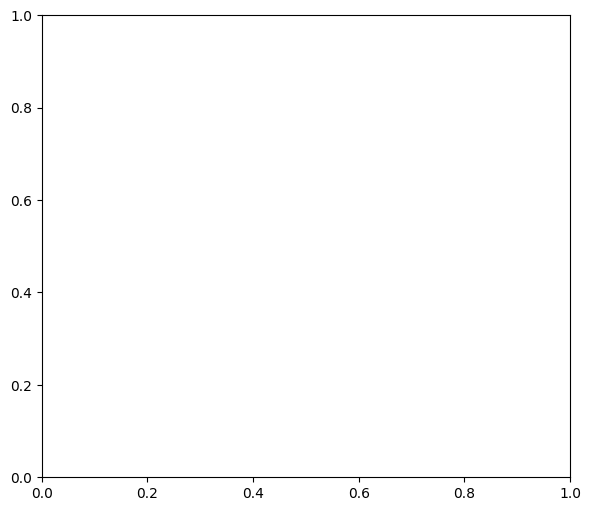

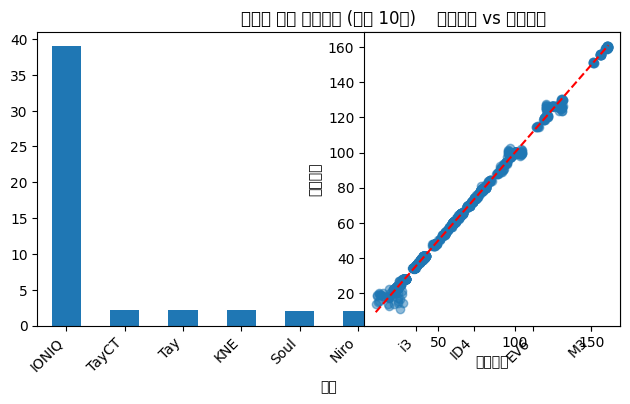


=== 모델 개선 제안 ===
1. 오차가 큰 모델들의 특징:
       평균오차  평균상대오차(%)  데이터수
모델                          
IONIQ  6.16      39.03    29

2. 가격대별 성능 차이:
          오차             상대오차(%)
        mean   std count    mean
가격대                             
0-30    0.95  1.86   338    5.10
30-50   0.40  0.31   346    1.04
50-70   0.43  0.30   284    0.71
70-100  0.67  0.88   305    0.78
100+    1.41  1.82   227    1.16
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost Score: 1.3647639960671067
Best Random Forest Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best Random Forest Score: 1.404258870000548
Validation RMSE: 1.4616468593818857

XGBoost Feature Importance:
     feature  importance
0        제조사    0.684515
1         모델    0.253975
3      배터리용량    0.042091
2       차량상태    0.009019
6    보증기간(년)    0.006

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

# 전처리 및 특성 엔지니어링 함수
def preprocess_data(df):
   df = df.copy()
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리
   df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 새로운 특성 추가
   # 배터리 효율성
   df['배터리효율'] = df['주행거리(km)'] / df['배터리용량']
   
   # 차량 나이에 따른 가치 감소 지수
   current_year = 2024
   df['차량나이'] = current_year - df['연식(년)']
   df['감가상각_지수'] = np.exp(-0.1 * df['차량나이'])
   
   # 제조사-모델 조합
   df['제조사_모델'] = df['제조사'].astype(str) + '_' + df['모델'].astype(str)
   df['제조사_모델'] = le.fit_transform(df['제조사_모델'])
   
   return df

# 데이터 전처리
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)
# 기존의 전처리와 모델 학습 코드는 동일하게 유지하고, 검증 단계에서 다음 코드를 추가

# 검증 데이터에서 모델별 오차 분석
val_pred = stacking.predict(X_val)
val_df = pd.DataFrame({
    '실제가격': y_val,
    '예측가격': val_pred,
    '오차': np.abs(y_val - val_pred),
    '상대오차(%)': np.abs((y_val - val_pred) / y_val) * 100
})

# 원본 데이터의 모델명 정보 추가
val_df['모델'] = train.iloc[X_val.index]['모델']
val_df['제조사'] = train.iloc[X_val.index]['제조사']

# 모델별 평균 오차 계산
model_errors = val_df.groupby('모델').agg({
    '오차': ['mean', 'std', 'count'],
    '상대오차(%)': 'mean',
    '실제가격': 'mean'
}).round(2)

model_errors.columns = ['평균오차', '오차표준편차', '데이터수', '평균상대오차(%)', '평균실제가격']
model_errors = model_errors.sort_values('평균상대오차(%)', ascending=False)

print("\n=== 모델별 예측 오차 분석 ===")
print(model_errors)

# 가격대별 오차 분석
val_df['가격대'] = pd.cut(val_df['실제가격'], 
                      bins=[0, 30, 50, 70, 100, float('inf')],
                      labels=['0-30', '30-50', '50-70', '70-100', '100+'])

price_range_errors = val_df.groupby('가격대').agg({
    '오차': ['mean', 'std', 'count'],
    '상대오차(%)': 'mean'
}).round(2)

print("\n=== 가격대별 예측 오차 분석 ===")
print(price_range_errors)

# 오차가 큰 상위 20개 케이스 분석
print("\n=== 오차가 큰 상위 20개 케이스 ===")
worst_predictions = val_df.nlargest(20, '오차')
print(worst_predictions[['제조사', '모델', '실제가격', '예측가격', '오차', '상대오차(%)']])

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))

# 모델별 평균 상대오차
plt.subplot(1, 2, 1)
model_errors.nlargest(10, '평균상대오차(%)')[['평균상대오차(%)']].plot(kind='bar')
plt.title('모델별 평균 상대오차 (상위 10개)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 실제가격 vs 예측가격 산점도
plt.subplot(1, 2, 2)
plt.scatter(val_df['실제가격'], val_df['예측가격'], alpha=0.5)
plt.plot([val_df['실제가격'].min(), val_df['실제가격'].max()], 
         [val_df['실제가격'].min(), val_df['실제가격'].max()], 
         'r--')
plt.xlabel('실제가격')
plt.ylabel('예측가격')
plt.title('실제가격 vs 예측가격')
plt.tight_layout()
plt.show()

# 이 분석을 바탕으로 모델 개선 제안
print("\n=== 모델 개선 제안 ===")
print("1. 오차가 큰 모델들의 특징:")
high_error_models = model_errors[model_errors['평균상대오차(%)'] > model_errors['평균상대오차(%)'].mean()]
print(high_error_models[['평균오차', '평균상대오차(%)', '데이터수']])

# 가격대별 특별 처리가 필요한지 확인
print("\n2. 가격대별 성능 차이:")
print(price_range_errors)
# 특성과 타겟 분리
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                 '보증기간(년)', '사고이력', '연식(년)', '배터리효율', '차량나이', 
                 '감가상각_지수', '제조사_모델']
X = train_processed[feature_columns]
y = train_processed['가격(백만원)']

# 학습 데이터와 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 그리드 서치
xgb_params = {
   'n_estimators': [200, 300, 400],
   'max_depth': [5, 6, 7],
   'learning_rate': [0.05, 0.1, 0.15],
   'subsample': [0.8, 0.9, 1.0],
   'colsample_bytree': [0.8, 0.9, 1.0],
   'min_child_weight': [1, 3, 5],
   'gamma': [0, 0.1, 0.2]
}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Score:", np.sqrt(-xgb_grid.best_score_))

# Random Forest 그리드 서치
rf_params = {
   'n_estimators': [200, 300, 400],
   'max_depth': [10, 15, 20],
   'min_samples_split': [2, 4, 6],
   'min_samples_leaf': [1, 2, 3],
   'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Score:", np.sqrt(-rf_grid.best_score_))

# 스태킹 앙상블
estimators = [
   ('xgb', xgb_grid.best_estimator_),
   ('rf', rf_grid.best_estimator_)
]

stacking = StackingRegressor(
   estimators=estimators,
   final_estimator=LassoCV(),
   cv=5
)

stacking.fit(X_train, y_train)

# 검증 데이터에서의 성능 평가
val_pred = stacking.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Validation RMSE: {val_rmse}")

# 테스트 데이터 예측
X_test = test_processed[feature_columns]
final_pred = stacking.predict(X_test)

# 결과 저장
submission = pd.DataFrame({
   'ID': test['ID'],
   '가격(백만원)': final_pred
})
submission.to_csv('submission3.csv', index=False)

# 특성 중요도 (XGBoost)
xgb_importance = pd.DataFrame({
   'feature': feature_columns,
   'importance': xgb_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)
print("\nXGBoost Feature Importance:")
print(xgb_importance)

# 특성 중요도 (Random Forest)
rf_importance = pd.DataFrame({
   'feature': feature_columns,
   'importance': rf_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)
print("\nRandom Forest Feature Importance:")
print(rf_importance)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Darwin':  # Mac OS
   plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
   plt.rc('font', family='Malgun Gothic')
   
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

# 전처리 함수
def preprocess_data(df):
   df = df.copy()
   
   # IONIQ 특별 처리 (레이블 인코딩 전)
   df['is_ioniq'] = (df['모델'] == 'IONIQ').astype(int)
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리
   df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 특성 엔지니어링
   # 배터리 효율성
   df['배터리효율'] = df['주행거리(km)'] / df['배터리용량']
   
   # 차량 나이 관련 특성
   current_year = 2024
   df['차량나이'] = current_year - df['연식(년)']
   df['감가상각_지수'] = np.exp(-0.1 * df['차량나이'])
   
   # IONIQ 관련 추가 특성
   df['ioniq_age_km'] = df['is_ioniq'] * df['차량나이'] * df['주행거리(km)']
   
   # 제조사-모델 조합
   df['제조사_모델'] = df['제조사'].astype(str) + '_' + df['모델'].astype(str)
   df['제조사_모델'] = le.fit_transform(df['제조사_모델'])
   
   return df

# 가격대별 모델 학습 함수
def train_by_price_range(X, y, xgb_params, rf_params):
   price_ranges = pd.cut(y, bins=[0, 30, 50, 70, 100, float('inf')],
                        labels=['0-30', '30-50', '50-70', '70-100', '100+'])
   models = {}
   
   for price_range in price_ranges.unique():
       mask = price_ranges == price_range
       if mask.sum() > 0:
           model = StackingRegressor(
               estimators=[
                   ('xgb', XGBRegressor(**xgb_params)),
                   ('rf', RandomForestRegressor(**rf_params))
               ],
               final_estimator=LassoCV(),
               cv=5
           )
           model.fit(X[mask], y[mask])
           models[price_range] = model
   
   return models

# 앙상블 가중치 최적화 함수
def optimize_weights(predictions_list, y_true):
   def objective(weights):
       weighted_pred = np.zeros_like(y_true)
       for i, pred in enumerate(predictions_list):
           weighted_pred += weights[i] * pred
       return np.sqrt(mean_squared_error(y_true, weighted_pred))
   
   constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
   bounds = [(0, 1)] * len(predictions_list)
   
   result = minimize(objective, x0=np.ones(len(predictions_list))/len(predictions_list),
                    constraints=constraints, bounds=bounds)
   
   return result.x

# 데이터 전처리
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

# 특성 선택
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                 '보증기간(년)', '사고이력', '연식(년)', '배터리효율', '차량나이', 
                 '감가상각_지수', '제조사_모델', 'is_ioniq', 'ioniq_age_km']

X = train_processed[feature_columns]
y = train_processed['가격(백만원)']

# 하이퍼파라미터 설정
xgb_params = {
   'n_estimators': 300,
   'max_depth': 6,
   'learning_rate': 0.05,
   'subsample': 0.8,
   'colsample_bytree': 0.8,
   'min_child_weight': 3,
   'gamma': 0
}

rf_params = {
   'n_estimators': 400,
   'max_depth': 10,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': None
}

# 가격대별 모델 학습
price_range_models = train_by_price_range(X, y, xgb_params, rf_params)

# 전체 데이터에 대한 기본 모델
base_model = StackingRegressor(
   estimators=[
       ('xgb', XGBRegressor(**xgb_params)),
       ('rf', RandomForestRegressor(**rf_params))
   ],
   final_estimator=LassoCV(),
   cv=5
)
base_model.fit(X, y)

# 테스트 데이터 예측
X_test = test_processed[feature_columns]
predictions = []

# 기본 모델 예측
predictions.append(base_model.predict(X_test))

# 가격대별 모델 예측
for model in price_range_models.values():
   predictions.append(model.predict(X_test))

# 앙상블 가중치 최적화
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
val_predictions = [base_model.predict(X_val)]
for model in price_range_models.values():
   val_predictions.append(model.predict(X_val))
optimal_weights = optimize_weights(val_predictions, y_val)

# 최종 예측
final_prediction = np.zeros(len(test))
for i, pred in enumerate(predictions):
   final_prediction += optimal_weights[i] * pred

# 결과 저장
submission = pd.DataFrame({
   'ID': test['ID'],
   '가격(백만원)': final_prediction
})
submission.to_csv('submission4.csv', index=False)

# 모델 성능 평가
print("=== 최종 모델 성능 ===")
val_pred = np.zeros_like(y_val)
for i, pred in enumerate(val_predictions):
   val_pred += optimal_weights[i] * pred
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"검증 세트 RMSE: {val_rmse:.4f}")

# 가중치 출력
print("\n=== 앙상블 가중치 ===")
model_names = ['기본 모델'] + [f'가격대 {pr} 모델' for pr in price_range_models.keys()]
for name, weight in zip(model_names, optimal_weights):
   print(f"{name}: {weight:.4f}")

# 특성 중요도 출력
print("\n=== 기본 모델 XGBoost 특성 중요도 ===")
xgb_importance = pd.DataFrame({
   'feature': feature_columns,
   'importance': base_model.named_estimators_['xgb'].feature_importances_
}).sort_values('importance', ascending=False)
print(xgb_importance)

=== 최종 모델 성능 ===
검증 세트 RMSE: 0.9537

=== 앙상블 가중치 ===
기본 모델: 1.0000
가격대 100+ 모델: 0.0000
가격대 0-30 모델: 0.0000
가격대 50-70 모델: 0.0000
가격대 70-100 모델: 0.0000
가격대 30-50 모델: 0.0000

=== 기본 모델 XGBoost 특성 중요도 ===
         feature  importance
0            제조사    0.631896
1             모델    0.174789
12        제조사_모델    0.081002
3          배터리용량    0.048922
4           구동방식    0.039186
6        보증기간(년)    0.011358
2           차량상태    0.008859
13      is_ioniq    0.001924
5       주행거리(km)    0.000708
14  ioniq_age_km    0.000415
8          연식(년)    0.000316
9          배터리효율    0.000302
10          차량나이    0.000291
7           사고이력    0.000032
11       감가상각_지수    0.000000



=== 모델별 예측 성능 분석 ===
        평균실제가격  평균예측가격  평균오차  오차표준편차  평균상대오차(%)  상대오차표준편차(%)  데이터수
모델                                                                
IONIQ    17.69   18.43  5.15    2.49      35.20        26.14    29
i3       23.60   23.83  0.87    2.19       3.61         8.95    80
Niro     27.00   27.04  0.85    0.78       3.33         3.53    60
KNE      25.93   25.96  0.76    0.58       3.10         2.71    81
TayCT   126.44  126.20  3.01    1.55       2.39         1.27    69
Tay     109.49  109.30  2.31    1.73       2.25         1.77    68
Soul     22.24   22.42  0.47    0.29       2.14         1.44    88
EV6      44.50   44.22  0.94    0.51       2.09         1.10    73
ID4      37.92   38.00  0.53    0.32       1.42         0.89   107
M3       51.70   51.64  0.63    0.50       1.24         1.04    45
ION5     34.89   35.17  0.37    0.32       1.07         0.92    76
MX       84.43   84.00  0.91    0.79       1.05         0.89    66
ION6     38.19   37.95  0.40    0.33    

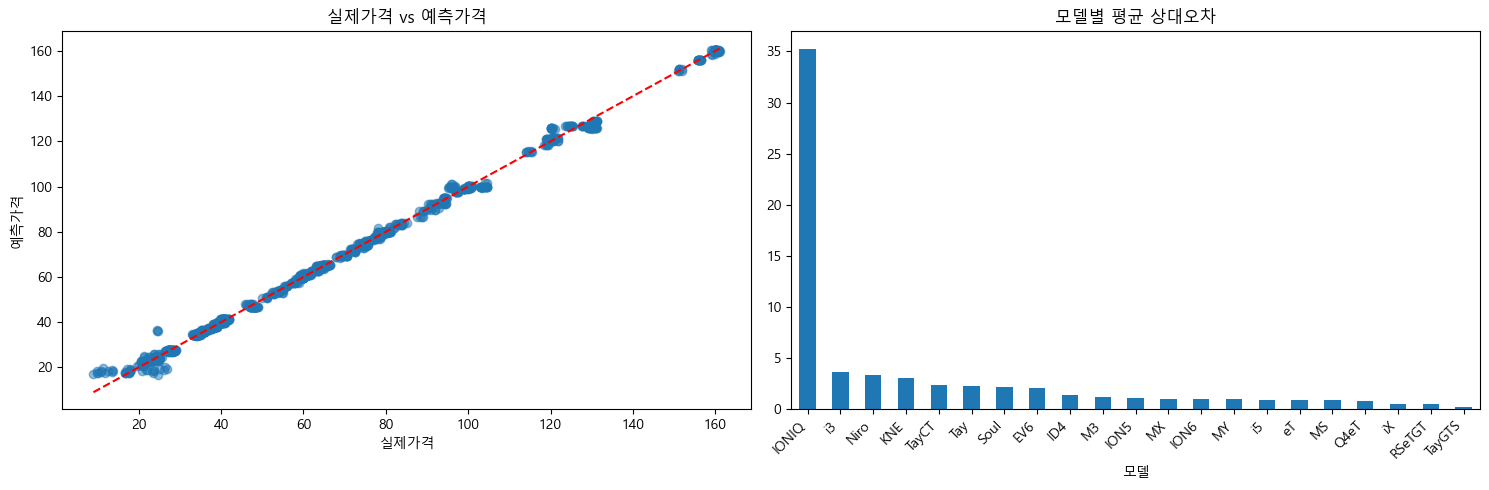


=== 최종 모델 성능 ===
검증 세트 RMSE: 1.5217

=== XGBoost 특성 중요도 ===
    feature  importance
0       제조사    0.515807
9    제조사_모델    0.165720
1        모델    0.153328
3     배터리용량    0.075751
4      구동방식    0.057266
6   보증기간(년)    0.017772
2      차량상태    0.011383
5  주행거리(km)    0.002457
8     연식(년)    0.000514
7      사고이력    0.000002


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Darwin':  # Mac OS
   plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
   plt.rc('font', family='Malgun Gothic')
   
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

# 전처리 함수
def preprocess_data(df):
   df = df.copy()
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리
   df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 제조사-모델 조합
   df['제조사_모델'] = df['제조사'].astype(str) + '_' + df['모델'].astype(str)
   df['제조사_모델'] = le.fit_transform(df['제조사_모델'])
   
   return df

# 데이터 전처리
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

# 특성 선택
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                 '보증기간(년)', '사고이력', '연식(년)', '제조사_모델']

X = train_processed[feature_columns]
y = train_processed['가격(백만원)']

# 학습 데이터와 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 설정
xgb_params = {
   'n_estimators': 200,
   'max_depth': 5,
   'learning_rate': 0.03,
   'subsample': 0.8,
   'colsample_bytree': 0.8,
   'min_child_weight': 5,
   'gamma': 0.1,
   'reg_alpha': 0.1,
   'reg_lambda': 1.0
}

rf_params = {
   'n_estimators': 300,
   'max_depth': 8,
   'min_samples_split': 5,
   'min_samples_leaf': 3,
   'max_features': 'sqrt'
}

# 기본 모델
base_model = StackingRegressor(
   estimators=[
       ('xgb', XGBRegressor(**xgb_params)),
       ('rf', RandomForestRegressor(**rf_params))
   ],
   final_estimator=LassoCV(cv=5),
   cv=10
)

# 모델 학습
base_model.fit(X, y)

# 테스트 데이터 예측
X_test = test_processed[feature_columns]
final_prediction = base_model.predict(X_test)

# 검증 세트에서의 모델별 성능 분석
val_predictions = base_model.predict(X_val)
val_analysis = pd.DataFrame({
   '모델': train.iloc[X_val.index]['모델'],
   '실제가격': y_val,
   '예측가격': val_predictions,
   '오차': np.abs(y_val - val_predictions),
   '상대오차(%)': np.abs((y_val - val_predictions) / y_val) * 100
})

# 모델별 평균 성능
model_performance = pd.DataFrame()
model_performance = val_analysis.groupby('모델').agg({
   '실제가격': 'mean',
   '예측가격': 'mean',
   '오차': ['mean', 'std'],
   '상대오차(%)': ['mean', 'std'],
}).round(2)

# 데이터 수 추가
model_counts = val_analysis['모델'].value_counts()
model_performance['데이터수'] = model_counts

# MultiIndex 컬럼을 단일 레벨로 변경
model_performance.columns = pd.Index([
   '평균실제가격', '평균예측가격',
   '평균오차', '오차표준편차',
   '평균상대오차(%)', '상대오차표준편차(%)',
   '데이터수'
])

# 평균 상대오차로 정렬
model_performance = model_performance.sort_values('평균상대오차(%)', ascending=False)

print("\n=== 모델별 예측 성능 분석 ===")
print(model_performance)

# 가장 오차가 큰 상위 20개 케이스
print("\n=== 오차가 가장 큰 상위 20개 케이스 ===")
worst_predictions = val_analysis.nlargest(20, '오차')
print(worst_predictions.round(2))

# 각 가격대별 성능
val_analysis['가격대'] = pd.cut(val_analysis['실제가격'], 
                           bins=[0, 30, 50, 70, 100, float('inf')],
                           labels=['0-30', '30-50', '50-70', '70-100', '100+'])

price_range_performance = val_analysis.groupby('가격대').agg({
   '오차': ['mean', 'std'],
   '상대오차(%)': ['mean', 'std'],
   '실제가격': 'count'
}).round(2)

print("\n=== 가격대별 예측 성능 ===")
print(price_range_performance)

# 시각화
plt.figure(figsize=(15, 5))

# 실제가격 vs 예측가격 산점도
plt.subplot(1, 2, 1)
plt.scatter(val_analysis['실제가격'], val_analysis['예측가격'], alpha=0.5)
plt.plot([val_analysis['실제가격'].min(), val_analysis['실제가격'].max()], 
        [val_analysis['실제가격'].min(), val_analysis['실제가격'].max()], 
        'r--')
plt.xlabel('실제가격')
plt.ylabel('예측가격')
plt.title('실제가격 vs 예측가격')

# 모델별 평균 상대오차 막대 그래프
plt.subplot(1, 2, 2)
model_performance['평균상대오차(%)'].plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('모델별 평균 상대오차')
plt.tight_layout()
plt.show()

# 최종 모델 성능
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"\n=== 최종 모델 성능 ===")
print(f"검증 세트 RMSE: {val_rmse:.4f}")

# 특성 중요도 출력
print("\n=== XGBoost 특성 중요도 ===")
xgb_importance = pd.DataFrame({
   'feature': feature_columns,
   'importance': base_model.named_estimators_['xgb'].feature_importances_
}).sort_values('importance', ascending=False)
print(xgb_importance)

# 결과 저장
submission = pd.DataFrame({
   'ID': test['ID'],
   '가격(백만원)': final_prediction
})
submission.to_csv('submission5.csv', index=False)


=== 모델별 예측 성능 분석 ===
        평균실제가격  평균예측가격  평균오차  오차표준편차  평균상대오차(%)  상대오차표준편차(%)  데이터수
모델                                                                
IONIQ    18.28   17.98  4.92    2.71      29.12        19.14    27
i3       23.57   23.87  1.11    2.21       4.60         8.87    81
TayCT   126.83  126.69  3.40    1.75       2.71         1.45    61
Soul     22.21   22.28  0.53    0.31       2.43         1.53    81
MY       73.01   72.94  1.65    0.89       2.27         1.29    49
MX       84.21   83.72  1.92    1.59       2.21         1.66    54
KNE      25.63   25.67  0.52    0.38       2.09         1.62    71
Niro     26.96   26.82  0.56    0.36       2.08         1.36    71
ID4      38.48   38.46  0.76    0.56       1.98         1.49   118
Tay     111.78  111.72  1.93    1.54       1.82         1.60    77
Q4eT     58.22   58.60  0.98    0.97       1.67         1.63    64
M3       51.54   51.68  0.79    0.52       1.55         1.08    53
EV6      44.60   44.29  0.58    0.41    

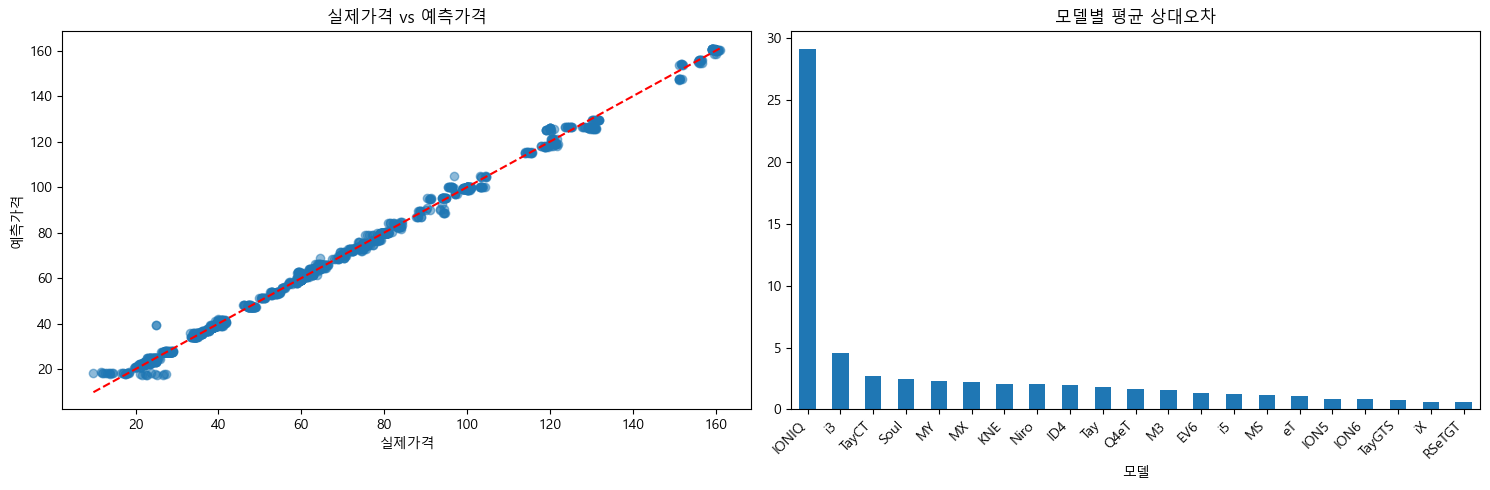


=== 최종 모델 성능 ===
검증 세트 RMSE: 1.6518

=== XGBoost 특성 중요도 ===
     feature  importance
11    제조사_그룹    0.712315
6    보증기간(년)    0.058691
0        제조사    0.057657
3      배터리용량    0.043326
1         모델    0.041562
9     제조사_모델    0.039329
2       차량상태    0.021289
5   주행거리(km)    0.013250
4       구동방식    0.011128
10  is_ioniq    0.000643
12   주행거리_구간    0.000431
8      연식(년)    0.000351
7       사고이력    0.000027


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Darwin':  # Mac OS
   plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
   plt.rc('font', family='Malgun Gothic')
   
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

def enhanced_features(df):
   df = df.copy()
   
   # 제조사 그룹화 (국산/수입)
   df['제조사_그룹'] = df['제조사'].map({
       'H사': '국산', 'K사': '국산',
       'B사': '수입', 'P사': '수입', 'V사': '수입'
   })
   
   # 가격 구간화를 위한 임시 컬럼
   if '가격(백만원)' in df.columns:
       df['가격_구간'] = pd.qcut(df['가격(백만원)'], q=5, labels=['매우저가', '저가', '중가', '고가', '매우고가'])
   
   # 주행거리 구간화
   df['주행거리_구간'] = pd.qcut(df['주행거리(km)'], q=5, labels=['매우낮음', '낮음', '중간', '높음', '매우높음'])
   
   return df

# 전처리 함수
def preprocess_data(df, is_test=False):
   df = df.copy()
   
   # 추가 특성 생성
   df = enhanced_features(df)
   
   # IONIQ 특별 처리
   df['is_ioniq'] = (df['모델'] == 'IONIQ').astype(int)
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력', 
                      '제조사_그룹', '주행거리_구간']
   if not is_test and '가격_구간' in df.columns:
       categorical_cols.append('가격_구간')
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리
   df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 제조사-모델 조합
   df['제조사_모델'] = df['제조사'].astype(str) + '_' + df['모델'].astype(str)
   df['제조사_모델'] = le.fit_transform(df['제조사_모델'])
   
   return df

# 데이터 전처리
train_processed = preprocess_data(train)
test_processed = preprocess_data(test, is_test=True)

# 특성 선택
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                 '보증기간(년)', '사고이력', '연식(년)', '제조사_모델', 'is_ioniq',
                 '제조사_그룹', '주행거리_구간']

X = train_processed[feature_columns]
y = train_processed['가격(백만원)']

# 가격 구간으로 stratify
price_bins = pd.qcut(y, q=5, labels=['매우저가', '저가', '중가', '고가', '매우고가'])

# 학습 데이터와 검증 데이터 분할 (Stratified)
X_train, X_val, y_train, y_val = train_test_split(
   X, y, test_size=0.2, random_state=42, stratify=price_bins
)

# 모델 파라미터
xgb_params = {
   'n_estimators': 200,
   'max_depth': 5,
   'learning_rate': 0.03,
   'subsample': 0.8,
   'colsample_bytree': 0.8,
   'min_child_weight': 5,
   'gamma': 0.1,
   'reg_alpha': 0.1,
   'reg_lambda': 1.0
}

rf_params = {
   'n_estimators': 300,
   'max_depth': 8,
   'min_samples_split': 5,
   'min_samples_leaf': 3,
   'max_features': 'sqrt'
}

# IONIQ 모델을 위한 별도의 모델
ioniq_mask = train['모델'] == 'IONIQ'
X_ioniq = X[ioniq_mask]
y_ioniq = y[ioniq_mask]

ioniq_model = StackingRegressor(
   estimators=[
       ('xgb', XGBRegressor(
           n_estimators=100,
           max_depth=4,
           learning_rate=0.01
       )),
       ('rf', RandomForestRegressor(
           n_estimators=200,
           max_depth=6
       ))
   ],
   final_estimator=LassoCV(),
   cv=5
)

ioniq_model.fit(X_ioniq, y_ioniq)

# 기본 모델
base_model = StackingRegressor(
   estimators=[
       ('xgb', XGBRegressor(**xgb_params)),
       ('rf', RandomForestRegressor(**rf_params))
   ],
   final_estimator=LassoCV(),
   cv=10
)

# 전체 데이터로 학습
base_model.fit(X, y)

# ... (이전 코드 동일) ...

# 테스트 데이터 예측
X_test = test_processed[feature_columns]
ioniq_mask_test = test['모델'] == 'IONIQ'

# 예측값을 저장할 배열 초기화
final_prediction = np.zeros(len(test))

# IONIQ 모델 예측
if ioniq_mask_test.any():
    final_prediction[ioniq_mask_test] = ioniq_model.predict(X_test[ioniq_mask_test])

# 나머지 모델 예측
if (~ioniq_mask_test).any():
    final_prediction[~ioniq_mask_test] = base_model.predict(X_test[~ioniq_mask_test])

# 검증 세트에서의 모델별 성능 분석
val_predictions = np.zeros(len(X_val))
ioniq_mask_val = train.iloc[X_val.index]['모델'] == 'IONIQ'

# 검증 세트 IONIQ 모델 예측
if ioniq_mask_val.any():
    val_predictions[ioniq_mask_val] = ioniq_model.predict(X_val[ioniq_mask_val])

# 검증 세트 나머지 모델 예측
if (~ioniq_mask_val).any():
    val_predictions[~ioniq_mask_val] = base_model.predict(X_val[~ioniq_mask_val])

# ... (이후 코드 동일) ...


val_analysis = pd.DataFrame({
   '모델': train.iloc[X_val.index]['모델'],
   '실제가격': y_val,
   '예측가격': val_predictions,
   '오차': np.abs(y_val - val_predictions),
   '상대오차(%)': np.abs((y_val - val_predictions) / y_val) * 100
})

# 모델별 평균 성능
model_performance = pd.DataFrame()
model_performance = val_analysis.groupby('모델').agg({
   '실제가격': 'mean',
   '예측가격': 'mean',
   '오차': ['mean', 'std'],
   '상대오차(%)': ['mean', 'std'],
}).round(2)

# 데이터 수 추가
model_counts = val_analysis['모델'].value_counts()
model_performance['데이터수'] = model_counts

# MultiIndex 컬럼을 단일 레벨로 변경
model_performance.columns = pd.Index([
   '평균실제가격', '평균예측가격',
   '평균오차', '오차표준편차',
   '평균상대오차(%)', '상대오차표준편차(%)',
   '데이터수'
])

# 평균 상대오차로 정렬
model_performance = model_performance.sort_values('평균상대오차(%)', ascending=False)

print("\n=== 모델별 예측 성능 분석 ===")
print(model_performance)

# 가장 오차가 큰 상위 20개 케이스
print("\n=== 오차가 가장 큰 상위 20개 케이스 ===")
worst_predictions = val_analysis.nlargest(20, '오차')
print(worst_predictions.round(2))

# 각 가격대별 성능
val_analysis['가격대'] = pd.cut(val_analysis['실제가격'], 
                           bins=[0, 30, 50, 70, 100, float('inf')],
                           labels=['0-30', '30-50', '50-70', '70-100', '100+'])

price_range_performance = val_analysis.groupby('가격대').agg({
   '오차': ['mean', 'std'],
   '상대오차(%)': ['mean', 'std'],
   '실제가격': 'count'
}).round(2)

print("\n=== 가격대별 예측 성능 ===")
print(price_range_performance)

# 시각화
plt.figure(figsize=(15, 5))

# 실제가격 vs 예측가격 산점도
plt.subplot(1, 2, 1)
plt.scatter(val_analysis['실제가격'], val_analysis['예측가격'], alpha=0.5)
plt.plot([val_analysis['실제가격'].min(), val_analysis['실제가격'].max()], 
        [val_analysis['실제가격'].min(), val_analysis['실제가격'].max()], 
        'r--')
plt.xlabel('실제가격')
plt.ylabel('예측가격')
plt.title('실제가격 vs 예측가격')

# 모델별 평균 상대오차 막대 그래프
plt.subplot(1, 2, 2)
model_performance['평균상대오차(%)'].plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('모델별 평균 상대오차')
plt.tight_layout()
plt.show()

# 최종 모델 성능
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"\n=== 최종 모델 성능 ===")
print(f"검증 세트 RMSE: {val_rmse:.4f}")

# 특성 중요도 출력
print("\n=== XGBoost 특성 중요도 ===")
xgb_importance = pd.DataFrame({
   'feature': feature_columns,
   'importance': base_model.named_estimators_['xgb'].feature_importances_
}).sort_values('importance', ascending=False)
print(xgb_importance)

# 결과 저장
submission = pd.DataFrame({
   'ID': test['ID'],
   '가격(백만원)': final_prediction
})
submission.to_csv('submission6.csv', index=False)


Fold 1/5
저가 세그먼트 학습: 1917 샘플
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 1917, number of used features: 10
[LightGBM] [Info] Start training from score 31.053490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

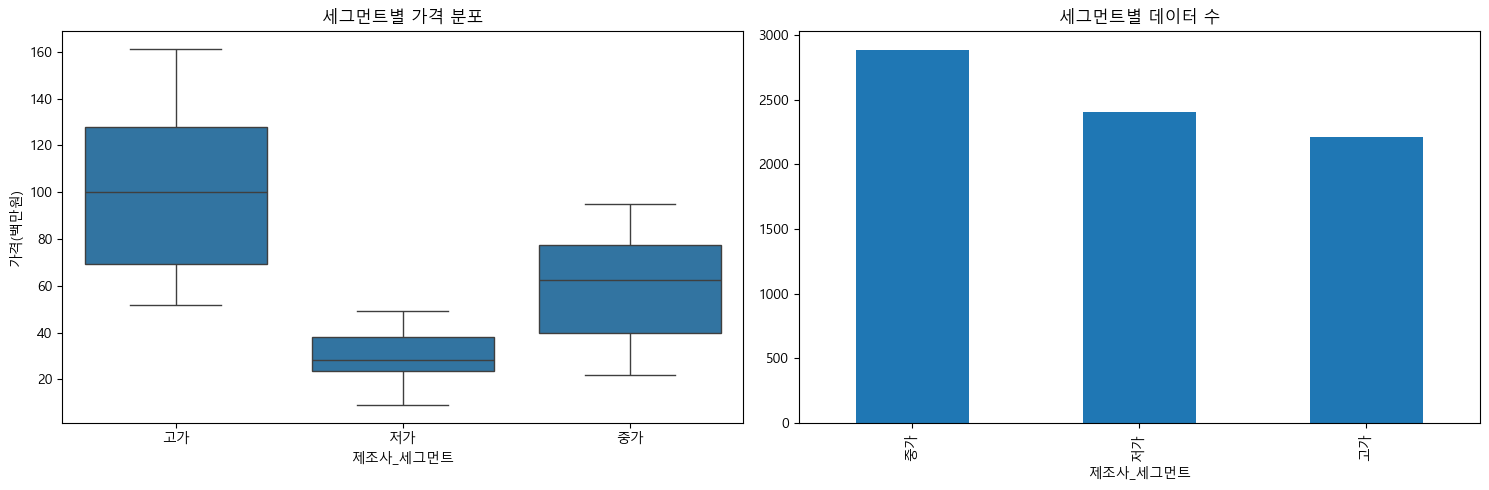

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Darwin':  # Mac OS
   plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
   plt.rc('font', family='Malgun Gothic')
   
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

# 제조사별 평균 가격 계산
manufacturer_values = train.groupby('제조사')['가격(백만원)'].mean()
segment_bounds = np.percentile(manufacturer_values, [33, 67])

# 세그먼트 분류 함수
def classify_segment(x):
   if manufacturer_values[x] > segment_bounds[1]:
       return '고가'
   elif manufacturer_values[x] > segment_bounds[0]:
       return '중가'
   else:
       return '저가'

# 세그먼트 추가
train['제조사_세그먼트'] = train['제조사'].map(classify_segment)
test['제조사_세그먼트'] = test['제조사'].map(classify_segment)

# 전처리 함수
def preprocess_data(df):
   df = df.copy()
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력', '제조사_세그먼트']
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리
   df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 제조사-모델 조합
   df['제조사_모델'] = df['제조사'].astype(str) + '_' + df['모델'].astype(str)
   df['제조사_모델'] = le.fit_transform(df['제조사_모델'])
   
   return df

def build_segment_models():
   # 기본 모델들
   models = {
       'xgb': XGBRegressor(
           n_estimators=200,
           max_depth=5,
           learning_rate=0.03,
           subsample=0.8,
           colsample_bytree=0.8,
           min_child_weight=5,
           gamma=0.1,
           reg_alpha=0.1,
           reg_lambda=1.0
       ),
       'rf': RandomForestRegressor(
           n_estimators=300,
           max_depth=8,
           min_samples_split=5,
           min_samples_leaf=3,
           max_features='sqrt'
       ),
       'lgb': LGBMRegressor(
           n_estimators=200,
           num_leaves=31,
           learning_rate=0.03,
           max_depth=6,
           reg_alpha=0.1,
           reg_lambda=1.0
       )
   }
   
   # 세그먼트별 모델
   segment_models = {}
   for segment in ['저가', '중가', '고가']:
       segment_models[segment] = VotingRegressor(
           estimators=[
               ('xgb', clone(models['xgb'])),
               ('rf', clone(models['rf'])),
               ('lgb', clone(models['lgb']))
           ]
       )
   
   return segment_models

# 모델 학습 및 예측 함수
def train_and_predict(X_train, y_train, X_test, segments_train, segments_test):
   segment_models = build_segment_models()
   predictions = np.zeros(len(X_test))
   
   for segment in ['저가', '중가', '고가']:
       mask_train = segments_train == segment
       mask_test = segments_test == segment
       
       if mask_train.any():
           print(f"{segment} 세그먼트 학습: {sum(mask_train)} 샘플")
           segment_models[segment].fit(X_train[mask_train], y_train[mask_train])
           
           if mask_test.any():
               predictions[mask_test] = segment_models[segment].predict(X_test[mask_test])
   
   return predictions, segment_models

# 데이터 전처리
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

# 특성 선택
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                 '보증기간(년)', '사고이력', '연식(년)', '제조사_모델', '제조사_세그먼트']

X = train_processed[feature_columns]
y = train_processed['가격(백만원)']

# 교차 검증
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
   X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
   y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
   segments_train = train['제조사_세그먼트'].iloc[train_idx]
   segments_val = train['제조사_세그먼트'].iloc[val_idx]
   
   print(f"\nFold {fold + 1}/{n_splits}")
   val_pred, _ = train_and_predict(
       X_train, y_train, X_val,
       segments_train, segments_val
   )
   
   fold_score = np.sqrt(mean_squared_error(y_val, val_pred))
   cv_scores.append(fold_score)
   print(f"Fold {fold + 1} RMSE: {fold_score:.4f}")

print(f"\n평균 교차 검증 RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# 최종 모델 학습 및 예측
final_predictions, final_models = train_and_predict(
   X, y, test_processed[feature_columns],
   train['제조사_세그먼트'], test['제조사_세그먼트']
)

# 세그먼트별 통계
segment_stats = train.groupby('제조사_세그먼트').agg({
   '가격(백만원)': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

print("\n=== 세그먼트별 통계 ===")
print(segment_stats)

# 결과 저장
submission = pd.DataFrame({
   'ID': test['ID'],
   '가격(백만원)': final_predictions
})
submission.to_csv('submission7.csv', index=False)

# 세그먼트별 분포 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='제조사_세그먼트', y='가격(백만원)')
plt.title('세그먼트별 가격 분포')

plt.subplot(1, 2, 2)
train['제조사_세그먼트'].value_counts().plot(kind='bar')
plt.title('세그먼트별 데이터 수')
plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

# 전처리 함수
def preprocess_data(df):
    df = df.copy()
    
    # 레이블 인코딩
    le = LabelEncoder()
    categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # 결측치 처리
    df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
    df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
    
    return df

# 가격 세그먼트 정의
def get_price_segment(price):
    if price < 30:
        return '초저가'
    elif price < 50:
        return '저가'
    elif price < 70:
        return '중가'
    elif price < 100:
        return '고가'
    else:
        return '프리미엄'

# 그리드서치 파라미터 정의
param_grid = {
    'xgb': {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.01, 0.03, 0.05],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1]
    },
    'rf': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'lgb': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 63],
        'max_depth': [-1, 5, 10],
        'learning_rate': [0.01, 0.03, 0.05],
        'min_child_samples': [20, 30]
    }
}

# 그리드서치 수행
def perform_grid_search(X, y, model_type='xgb', param_grid=None):
    if model_type == 'xgb':
        model = XGBRegressor(random_state=42)
        params = param_grid['xgb']
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=42)
        params = param_grid['rf']
    else:  # lgb
        model = LGBMRegressor(random_state=42)
        params = param_grid['lgb']
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )
    
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

# 데이터 전처리
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

# 가격 세그먼트 추가
train_processed['가격_세그먼트'] = train_processed['가격(백만원)'].apply(get_price_segment)

# 특성 선택
feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                  '보증기간(년)', '사고이력', '연식(년)']

# 세그먼트별 그리드서치
for segment in ['초저가', '저가', '중가', '고가', '프리미엄']:
    print(f"\n=== {segment} 세그먼트 ===")
    segment_data = train_processed[train_processed['가격_세그먼트'] == segment]
    
    if len(segment_data) > 0:  # 데이터가 있는 경우에만 수행
        X = segment_data[feature_columns]
        y = segment_data['가격(백만원)']
        
        print("\nXGBoost 그리드서치:")
        best_params, best_score = perform_grid_search(X, y, 'xgb', param_grid)
        print(f"Best parameters: {best_params}")
        print(f"Best RMSE: {-best_score:.4f}")
        
        print("\nRandomForest 그리드서치:")
        best_params, best_score = perform_grid_search(X, y, 'rf', param_grid)
        print(f"Best parameters: {best_params}")
        print(f"Best RMSE: {-best_score:.4f}")
        
        print("\nLightGBM 그리드서치:")
        best_params, best_score = perform_grid_search(X, y, 'lgb', param_grid)
        print(f"Best parameters: {best_params}")
        print(f"Best RMSE: {-best_score:.4f}")


=== 초저가 세그먼트 ===

XGBoost 그리드서치:
Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Best RMSE: 1.7368

RandomForest 그리드서치:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 1.7718

LightGBM 그리드서치:
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 9
[LightGBM] [Info] Start training from score 24.034627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Darwin':  # Mac OS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
    
plt.rc('axes', unicode_minus=False)

def get_price_segment(price):
    if price < 30:
        return '초저가'
    elif price < 50:
        return '저가'
    elif price < 70:
        return '중가'
    elif price < 100:
        return '고가'
    else:
        return '프리미엄'

def init_segment_models():
    models = {
        '초저가': XGBRegressor(
            n_estimators=300, learning_rate=0.01, max_depth=4,
            min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
            gamma=0, random_state=42
        ),
        '저가': XGBRegressor(
            n_estimators=100, learning_rate=0.05, max_depth=5,
            min_child_weight=3, subsample=1.0, colsample_bytree=1.0,
            gamma=0.1, random_state=42
        ),
        '중가': XGBRegressor(
            n_estimators=200, learning_rate=0.03, max_depth=5,
            min_child_weight=5, subsample=0.9, colsample_bytree=0.9,
            gamma=0, random_state=42
        ),
        '고가': XGBRegressor(
            n_estimators=200, learning_rate=0.03, max_depth=6,
            min_child_weight=5, subsample=1.0, colsample_bytree=1.0,
            gamma=0.1, random_state=42
        ),
        '프리미엄': XGBRegressor(
            n_estimators=100, learning_rate=0.05, max_depth=5,
            min_child_weight=5, subsample=0.8, colsample_bytree=1.0,
            gamma=0, random_state=42
        )
    }
    return models

def preprocess_data(df):
    df = df.copy()
    
    # 레이블 인코딩
    le = LabelEncoder()
    categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # 결측치 처리
    df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
    df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
    
    return df

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 데이터 전처리
    train_processed = preprocess_data(train)
    test_processed = preprocess_data(test)

    # 특성 선택
    feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                      '보증기간(년)', '사고이력', '연식(년)']

    # 학습 데이터 세그먼트 추가
    train_processed['가격_세그먼트'] = train_processed['가격(백만원)'].apply(get_price_segment)

    # 세그먼트별 모델 초기화
    segment_models = init_segment_models()
    
    # 교차 검증
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {
        'rmse': [],
        'r2': [],
        'mae': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_processed)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        train_fold = train_processed.iloc[train_idx]
        val_fold = train_processed.iloc[val_idx]
        
        # 세그먼트별 학습
        for segment in segment_models.keys():
            segment_train = train_fold[train_fold['가격_세그먼트'] == segment]
            if len(segment_train) > 0:
                X_train = segment_train[feature_columns]
                y_train = segment_train['가격(백만원)']
                segment_models[segment].fit(X_train, y_train)
                
                # 훈련 성능 평가
                train_pred = segment_models[segment].predict(X_train)
                train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
                train_r2 = r2_score(y_train, train_pred)
                print(f"\n{segment} 세그먼트 훈련 성능:")
                print(f"RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
        
        # 검증 세트 예측
        val_predictions = np.zeros(len(val_fold))
        for i, row in val_fold.iterrows():
            # 실제 세그먼트의 모델로 예측
            actual_segment = get_price_segment(row['가격(백만원)'])
            val_predictions[val_fold.index.get_loc(i)] = segment_models[actual_segment].predict(
                row[feature_columns].values.reshape(1, -1)
            )[0]
        
        # 검증 성능 평가
        val_rmse = np.sqrt(mean_squared_error(val_fold['가격(백만원)'], val_predictions))
        val_r2 = r2_score(val_fold['가격(백만원)'], val_predictions)
        val_mae = mean_absolute_error(val_fold['가격(백만원)'], val_predictions)
        
        print(f"\nFold {fold + 1} 검증 성능:")
        print(f"RMSE: {val_rmse:.4f}")
        print(f"R2 Score: {val_r2:.4f}")
        print(f"MAE: {val_mae:.4f}")
        
        cv_scores['rmse'].append(val_rmse)
        cv_scores['r2'].append(val_r2)
        cv_scores['mae'].append(val_mae)

    # 평균 교차 검증 성능
    print("\n=== 평균 교차 검증 성능 ===")
    print(f"RMSE: {np.mean(cv_scores['rmse']):.4f} (+/- {np.std(cv_scores['rmse']):.4f})")
    print(f"R2 Score: {np.mean(cv_scores['r2']):.4f} (+/- {np.std(cv_scores['r2']):.4f})")
    print(f"MAE: {np.mean(cv_scores['mae']):.4f} (+/- {np.std(cv_scores['mae']):.4f})")

    # 최종 모델 학습
    final_predictions = np.zeros(len(test_processed))
    
    # 각 세그먼트별로 예측 수행
    for segment in segment_models.keys():
        # 해당 세그먼트의 가격 범위
        if segment == '초저가':
            price_range = (0, 30)
        elif segment == '저가':
            price_range = (30, 50)
        elif segment == '중가':
            price_range = (50, 70)
        elif segment == '고가':
            price_range = (70, 100)
        else:  # 프리미엄
            price_range = (100, float('inf'))
        
        # 해당 세그먼트 모델로 전체 예측
        segment_predictions = segment_models[segment].predict(test_processed[feature_columns])
        
        # 가격 범위에 맞는 예측값만 사용
        mask = (segment_predictions >= price_range[0]) & (segment_predictions < price_range[1])
        final_predictions = np.where(mask, segment_predictions, final_predictions)

    # 결과 저장
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': final_predictions
    })
    submission.to_csv('submission8.csv', index=False)

if __name__ == "__main__":
    main()


Fold 1/5

초저가 세그먼트 훈련 성능:
RMSE: 1.2869, R2: 0.8638

저가 세그먼트 훈련 성능:
RMSE: 0.4697, R2: 0.9868

중가 세그먼트 훈련 성능:
RMSE: 0.4368, R2: 0.9912

고가 세그먼트 훈련 성능:
RMSE: 0.4494, R2: 0.9974

프리미엄 세그먼트 훈련 성능:
RMSE: 1.7161, R2: 0.9938

Fold 1 검증 성능:
RMSE: 1.2494
R2 Score: 0.9989
MAE: 0.6278

Fold 2/5

초저가 세그먼트 훈련 성능:
RMSE: 1.3251, R2: 0.8575

저가 세그먼트 훈련 성능:
RMSE: 0.4655, R2: 0.9872

중가 세그먼트 훈련 성능:
RMSE: 0.4465, R2: 0.9905

고가 세그먼트 훈련 성능:
RMSE: 0.4537, R2: 0.9974

프리미엄 세그먼트 훈련 성능:
RMSE: 1.5988, R2: 0.9948

Fold 2 검증 성능:
RMSE: 1.3170
R2 Score: 0.9987
MAE: 0.6657

Fold 3/5

초저가 세그먼트 훈련 성능:
RMSE: 1.2755, R2: 0.8659

저가 세그먼트 훈련 성능:
RMSE: 0.4591, R2: 0.9883

중가 세그먼트 훈련 성능:
RMSE: 0.4425, R2: 0.9907

고가 세그먼트 훈련 성능:
RMSE: 0.4476, R2: 0.9974

프리미엄 세그먼트 훈련 성능:
RMSE: 1.7441, R2: 0.9935

Fold 3 검증 성능:
RMSE: 1.2366
R2 Score: 0.9989
MAE: 0.6185

Fold 4/5

초저가 세그먼트 훈련 성능:
RMSE: 1.3741, R2: 0.8459

저가 세그먼트 훈련 성능:
RMSE: 0.4609, R2: 0.9879

중가 세그먼트 훈련 성능:
RMSE: 0.4406, R2: 0.9909

고가 세그먼트 훈련 성능:
RMSE: 0.4481, R2: 0.9974


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor ##category boost도 앙상블 모델에 포함
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Darwin':  # Mac OS
   plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
   plt.rc('font', family='Malgun Gothic')
   
plt.rc('axes', unicode_minus=False)

def get_price_segment(price): ###세그먼트 분류 수정필요, 가격대로 분류할 경우 평균가는 분류가 될 수 있으나 브랜드와 모델별 중요도는 무시함. 해결 방법)세그먼트를 6개로 분류. [ioniq, i3], [저가], [중저가], [중고가] [tayct, tay], [고가]
   if price < 30:
       return '초저가'
   elif price < 50:
       return '저가'
   elif price < 70:
       return '중가'
   elif price < 100:
       return '고가'
   else:
       return '프리미엄'

def init_segment_models():
   models = {
       '초저가': XGBRegressor(
           n_estimators=400,
           learning_rate=0.01,
           max_depth=5,
           min_child_weight=3,
           subsample=0.9,
           colsample_bytree=0.9,
           gamma=0.1,
           reg_alpha=0.1,
           reg_lambda=1.0,
           random_state=42
       ),
       '저가': XGBRegressor(
           n_estimators=100,
           learning_rate=0.05,
           max_depth=5,
           min_child_weight=3,
           subsample=1.0,
           colsample_bytree=1.0,
           gamma=0.1,
           reg_alpha=0.1,
           reg_lambda=1.0,
           random_state=42
       ),
       '중가': XGBRegressor(
           n_estimators=200,
           learning_rate=0.03,
           max_depth=5,
           min_child_weight=5,
           subsample=0.9,
           colsample_bytree=0.9,
           gamma=0,
           reg_alpha=0.1,
           reg_lambda=1.0,
           random_state=42
       ),
       '고가': XGBRegressor(
           n_estimators=200,
           learning_rate=0.03,
           max_depth=6,
           min_child_weight=5,
           subsample=1.0,
           colsample_bytree=1.0,
           gamma=0.1,
           reg_alpha=0.1,
           reg_lambda=1.0,
           random_state=42
       ),
       '프리미엄': XGBRegressor(
           n_estimators=300,
           learning_rate=0.03,
           max_depth=6,
           min_child_weight=7,
           subsample=0.8,
           colsample_bytree=0.8,
           gamma=0.2,
           reg_alpha=0.2,
           reg_lambda=1.0,
           random_state=42
       )
   }
   return models

def add_features(df):
   df = df.copy()
   
   # 가격대별 특화 피처
   df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
   df['차량연식'] = 2024 - df['연식(년)'] ###차량 연식을 계산할 수 있으면 연식 별 보조금 책정 고려###
   df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
   
   # 배터리 관련 추가 피처
   df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
   
   # 보증기간 관련 피처
   df['잔여보증기간'] = df['보증기간(년)'] - df['차량연식']
   df['잔여보증기간'] = df['잔여보증기간'].clip(lower=0)
   
   return df

def preprocess_data(df):
   df = df.copy()
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리 ###결측치 처리는 어떻게? 
   df['배터리용량'] = df['배터리용량'].fillna(df.groupby('모델')['배터리용량'].transform('mean'))
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 특성 추가
   df = add_features(df)
   
   return df

def main():
   # 데이터 로드
   train = pd.read_csv('train.csv', encoding='utf-8')
   test = pd.read_csv('test.csv', encoding='utf-8')
   
   # 데이터 전처리
   train_processed = preprocess_data(train)
   test_processed = preprocess_data(test)

   # 특성 선택
   feature_columns = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
                     '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
                     'km_per_year', '배터리_연식_효율', '잔여보증기간']

   # 학습 데이터 세그먼트 추가
   train_processed['가격_세그먼트'] = train_processed['가격(백만원)'].apply(get_price_segment)

   # 세그먼트별 모델 초기화
   segment_models = init_segment_models()
   
   # 교차 검증
   n_splits = 5
   kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
   cv_scores = {
       'rmse': [],
       'r2': [],
       'mae': []
   }

   for fold, (train_idx, val_idx) in enumerate(kf.split(train_processed)):
       print(f"\nFold {fold + 1}/{n_splits}")
       
       train_fold = train_processed.iloc[train_idx]
       val_fold = train_processed.iloc[val_idx]
       
       # 세그먼트별 학습
       for segment in segment_models.keys():
           segment_train = train_fold[train_fold['가격_세그먼트'] == segment]
           if len(segment_train) > 0:
               X_train = segment_train[feature_columns]
               y_train = segment_train['가격(백만원)']
               segment_models[segment].fit(X_train, y_train)
               
               # 훈련 성능 평가
               train_pred = segment_models[segment].predict(X_train)
               train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
               train_r2 = r2_score(y_train, train_pred)
               print(f"\n{segment} 세그먼트 훈련 성능:")
               print(f"RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
       
       # 검증 세트 예측
       val_predictions = np.zeros(len(val_fold))
       for i, row in val_fold.iterrows():
           # 실제 세그먼트의 모델로 예측
           actual_segment = get_price_segment(row['가격(백만원)'])
           val_predictions[val_fold.index.get_loc(i)] = segment_models[actual_segment].predict(
               row[feature_columns].values.reshape(1, -1)
           )[0]
       
       # 검증 성능 평가
       val_rmse = np.sqrt(mean_squared_error(val_fold['가격(백만원)'], val_predictions))
       val_r2 = r2_score(val_fold['가격(백만원)'], val_predictions)
       val_mae = mean_absolute_error(val_fold['가격(백만원)'], val_predictions)
       
       print(f"\nFold {fold + 1} 검증 성능:")
       print(f"RMSE: {val_rmse:.4f}")
       print(f"R2 Score: {val_r2:.4f}")
       print(f"MAE: {val_mae:.4f}")
       
       cv_scores['rmse'].append(val_rmse)
       cv_scores['r2'].append(val_r2)
       cv_scores['mae'].append(val_mae)

   # 평균 교차 검증 성능
   print("\n=== 평균 교차 검증 성능 ===")
   print(f"RMSE: {np.mean(cv_scores['rmse']):.4f} (+/- {np.std(cv_scores['rmse']):.4f})")
   print(f"R2 Score: {np.mean(cv_scores['r2']):.4f} (+/- {np.std(cv_scores['r2']):.4f})")
   print(f"MAE: {np.mean(cv_scores['mae']):.4f} (+/- {np.std(cv_scores['mae']):.4f})")

   # 최종 모델 학습
   final_predictions = np.zeros(len(test_processed))
   
   # 먼저 모든 세그먼트 모델로 예측
   segment_predictions = {}
   for segment, model in segment_models.items():
       segment_predictions[segment] = model.predict(test_processed[feature_columns])
   
   # 각 샘플에 대해 가장 적절한 세그먼트의 예측값 선택
   for i in range(len(test_processed)):
       # 각 세그먼트 모델의 예측값과 해당 세그먼트의 범위를 비교
       best_segment = min(
           segment_predictions.items(),
           key=lambda x: min(
               abs(x[1][i] - get_segment_bounds(x[0])[0]),
               abs(x[1][i] - get_segment_bounds(x[0])[1])
           )
       )[0]
       final_predictions[i] = segment_predictions[best_segment][i]

   # 결과 저장
   submission = pd.DataFrame({
       'ID': test['ID'],
       '가격(백만원)': final_predictions
   })
   submission.to_csv('submission.csv', index=False)

def get_segment_bounds(segment):
   if segment == '초저가':
       return (0, 30)
   elif segment == '저가':
       return (30, 50)
   elif segment == '중가':
       return (50, 70)
   elif segment == '고가':
       return (70, 100)
   else:  # 프리미엄
       return (100, float('inf'))

if __name__ == "__main__":
   main()


Fold 1/5

초저가 세그먼트 훈련 성능:
RMSE: 1.0080, R2: 0.9164

저가 세그먼트 훈련 성능:
RMSE: 0.4684, R2: 0.9869

중가 세그먼트 훈련 성능:
RMSE: 0.4331, R2: 0.9914

고가 세그먼트 훈련 성능:
RMSE: 0.4460, R2: 0.9975

프리미엄 세그먼트 훈련 성능:
RMSE: 1.4444, R2: 0.9956

Fold 1 검증 성능:
RMSE: 1.2988
R2 Score: 0.9988
MAE: 0.6310

Fold 2/5

초저가 세그먼트 훈련 성능:
RMSE: 1.0220, R2: 0.9153

저가 세그먼트 훈련 성능:
RMSE: 0.4642, R2: 0.9873

중가 세그먼트 훈련 성능:
RMSE: 0.4410, R2: 0.9907

고가 세그먼트 훈련 성능:
RMSE: 0.4503, R2: 0.9974

프리미엄 세그먼트 훈련 성능:
RMSE: 1.3234, R2: 0.9964

Fold 2 검증 성능:
RMSE: 1.3678
R2 Score: 0.9987
MAE: 0.6631

Fold 3/5

초저가 세그먼트 훈련 성능:
RMSE: 0.9597, R2: 0.9241

저가 세그먼트 훈련 성능:
RMSE: 0.4591, R2: 0.9883

중가 세그먼트 훈련 성능:
RMSE: 0.4392, R2: 0.9908

고가 세그먼트 훈련 성능:
RMSE: 0.4418, R2: 0.9975

프리미엄 세그먼트 훈련 성능:
RMSE: 1.4612, R2: 0.9954

Fold 3 검증 성능:
RMSE: 1.2718
R2 Score: 0.9988
MAE: 0.6201

Fold 4/5

초저가 세그먼트 훈련 성능:
RMSE: 1.0645, R2: 0.9075

저가 세그먼트 훈련 성능:
RMSE: 0.4597, R2: 0.9879

중가 세그먼트 훈련 성능:
RMSE: 0.4366, R2: 0.9910

고가 세그먼트 훈련 성능:
RMSE: 0.4477, R2: 0.9974


In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def get_price_segment(model):
    # 모델별 가격대 기준으로 세그먼트 분류
    premium = ['TayGTS', 'TayCT']  # 평균 126-158백만원
    high = ['Tay', 'RSeGT']       # 평균 98-100백만원
    upper_mid = ['MX', 'ix', 'MS', 'MY']  # 평균 72-83백만원
    mid = ['eT', 'EV6', 'Q4eT']   # 평균 58-68백만원
    low = ['M3', 'ID6', 'ID4', 'IONIQ', 'ION5']  # 평균 35-51백만원
    entry = ['Niro', 'KNE', 'i4', 'Soul']  # 평균 22-27백만원
    
    if model in premium:
        return '프리미엄'
    elif model in high:
        return '고가'
    elif model in upper_mid:
        return '중고가'
    elif model in mid:
        return '중가'
    elif model in low:
        return '저가'
    elif model in entry:
        return '초저가'
    else:
        print(f"Warning: Unknown model - {model}")
        return '중가'

def add_features(df):
    df = df.copy()
    
    # 기본 피처 엔지니어링
    df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
    df['차량연식'] = 2024 - df['연식(년)']
    df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
    df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
    df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
    
    # 모델별 통계
    df['모델별_평균가격'] = df.groupby('모델')['가격(백만원)'].transform('mean')
    df['모델별_가격편차'] = df.groupby('모델')['가격(백만원)'].transform('std')
    
    # 제조사별 통계
    df['제조사별_평균가격'] = df.groupby('제조사')['가격(백만원)'].transform('mean')
    df['제조사별_가격편차'] = df.groupby('제조사')['가격(백만원)'].transform('std')
    
    # 가격 변동성
    df['모델별_가격변동성'] = df['모델별_가격편차'] / df['모델별_평균가격']
    df['제조사별_가격변동성'] = df['제조사별_가격편차'] / df['제조사별_평균가격']
    
    return df

def preprocess_data(df):
    df = df.copy()
    
    # 레이블 인코딩
    le = LabelEncoder()
    categorical_cols = ['제조사', '모델', '차량상태', '구동방식', '사고이력']
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # 결측치 처리
    df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
        lambda x: x.fillna(x.mean())
    )
    df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
        lambda x: x.fillna(x.mean())
    )
    df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
    
    # 특성 추가
    if '가격(백만원)' in df.columns:  # train 데이터의 경우
        df = add_features(df)
    
    return df

def verify_segmentation(df):
    segments = df.groupby(['가격_세그먼트', '모델']).agg({
        '가격(백만원)': ['count', 'mean', 'std']
    }).round(2)
    
    print("\n=== 세그먼트별 모델 분포 ===")
    print(segments)
    return segments

def optimize_segment_models(train_data, feature_columns):
    param_grid = {
        'xgb': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.03, 0.05],
            'max_depth': [4, 5, 6],
            'min_child_weight': [3, 5],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
            'gamma': [0, 0.1]
        },
        'lgbm': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.03, 0.05],
            'num_leaves': [31, 63],
            'max_depth': [4, 5, 6],
            'min_child_samples': [20, 30],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        },
        'rf': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    }
    
    # 세그먼트별 데이터 수 확인
    segment_counts = train_data['가격_세그먼트'].value_counts()
    print("\n=== 세그먼트별 데이터 분포 ===")
    for segment, count in segment_counts.items():
        print(f"{segment}: {count}개 샘플")
    
    optimized_models = {}
    
    for segment in ['프리미엄', '고가', '중고가', '중가', '저가', '초저가']:
        print(f"\n{'='*50}")
        print(f"세그먼트 최적화 시작: {segment}")
        print(f"데이터 수: {segment_counts.get(segment, 0)}개")
        print('='*50)
        
        segment_data = train_data[train_data['가격_세그먼트'] == segment]
        if len(segment_data) < 50:
            print(f"Warning: {segment} 세그먼트의 데이터가 너무 적습니다.")
            continue
            
        X = segment_data[feature_columns]
        y = segment_data['가격(백만원)']
        
        optimized_models[segment] = {}
        
        # 각 모델 최적화
        for model_type in ['xgb', 'lgbm', 'rf']:
            print(f"\n{model_type.upper()} 최적화 시작...")
            
            if model_type == 'xgb':
                model = XGBRegressor(random_state=42)
            elif model_type == 'lgbm':
                model = LGBMRegressor(random_state=42)
            else:  # rf
                model = RandomForestRegressor(random_state=42)
            
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid[model_type],
                cv=5,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=2
            )
            
            try:
                grid_search.fit(X, y)
                optimized_models[segment][model_type] = grid_search.best_estimator_
                print(f"\n{model_type.upper()} 최적 파라미터:")
                for param, value in grid_search.best_params_.items():
                    print(f"- {param}: {value}")
                print(f"{model_type.upper()} 최적 RMSE: {-grid_search.best_score_:.4f}")
            except Exception as e:
                print(f"{model_type.upper()} 최적화 중 에러 발생: {str(e)}")
    
    return optimized_models

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 데이터 전처리
    train_processed = preprocess_data(train)
    test_processed = preprocess_data(test)
    
    # 세그먼트 분류
    train_processed['가격_세그먼트'] = train_processed['모델'].apply(get_price_segment)
    
    # 세그먼트 분류 검증
    verify_segmentation(train_processed)
    
    # 특성 선택
    feature_columns = [
        '제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
        '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
        'km_per_year', '배터리_연식_효율', '잔여보증기간',
        '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
        '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성'
    ]
    
    # 모델 최적화
    optimized_models = optimize_segment_models(train_processed, feature_columns)
    
    return optimized_models

if __name__ == "__main__":
    optimized_models = main()


=== 세그먼트별 모델 분포 ===
           가격(백만원)               
             count    mean    std
가격_세그먼트 모델                       
중가      0      369   44.20   3.63
        1      605   38.41   2.80
        2      353   35.07   0.70
        3      379   38.10   0.74
        4      140   17.99   5.42
        5      365   25.74   2.60
        6      279   51.63   3.04
        7      277   74.54   7.30
        8      264   83.05   8.15
        9      289   72.05   5.31
        10     398   26.97   2.08
        11     378   58.07   2.14
        12     385   98.80   2.09
        13     397   22.12   1.71
        14     361  109.93  10.04
        15     335  126.31   4.48
        16     375  158.30   3.02
        17     379   68.10   5.35
        18     388   23.56   0.80
        19     414   62.87   1.76
        20     367   80.03   0.57

=== 세그먼트별 데이터 분포 ===
중가: 7497개 샘플

세그먼트 최적화 시작: 프리미엄
데이터 수: 0개

세그먼트 최적화 시작: 고가
데이터 수: 0개

세그먼트 최적화 시작: 중고가
데이터 수: 0개

세그먼트 최적화 시작: 중가
데이터 수: 7497개

XGB 최적화 시작...

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def add_features(df):
    df = df.copy()
    
    # 기본 피처 엔지니어링
    df['차량연식'] = 2024 - df['연식(년)']
    df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
    df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
    df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
    df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
    
    # 제조사별 통계
    df['제조사별_평균가격'] = df.groupby('제조사')['가격(백만원)'].transform('mean')
    df['제조사별_가격편차'] = df.groupby('제조사')['가격(백만원)'].transform('std')
    df['제조사별_가격변동성'] = df['제조사별_가격편차'] / df['제조사별_평균가격']
    
    # 모델별 통계
    df['모델별_평균가격'] = df.groupby('모델')['가격(백만원)'].transform('mean')
    df['모델별_가격편차'] = df.groupby('모델')['가격(백만원)'].transform('std')
    df['모델별_가격변동성'] = df['모델별_가격편차'] / df['모델별_평균가격']
    
    return df

def preprocess_data(df):
    df = df.copy()
    
    # 레이블 인코딩
    le = LabelEncoder()
    categorical_cols = ['모델', '차량상태', '구동방식', '사고이력']
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # 결측치 처리
    df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
        lambda x: x.fillna(x.mean())
    )
    df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
        lambda x: x.fillna(x.mean())
    )
    df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
    
    # 특성 추가
    if '가격(백만원)' in df.columns:  # train 데이터의 경우
        df = add_features(df)
    
    return df

def get_param_grid():
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.03, 0.05],
        'max_depth': [4, 5, 6],
        'min_child_weight': [3, 5],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'gamma': [0, 0.1]
    }
    
    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.03, 0.05],
        'num_leaves': [31, 63],
        'max_depth': [4, 5, 6],
        'min_child_samples': [20, 30],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    return {
        'xgb': xgb_param_grid,
        'lgb': lgb_param_grid,
        'rf': rf_param_grid
    }

def optimize_manufacturer_models(train_data, feature_columns):
    param_grids = get_param_grid()
    manufacturers = train_data['제조사'].unique()
    
    optimized_models = {}
    
    for manufacturer in manufacturers:
        print(f"\n{'='*50}")
        print(f"제조사 최적화 시작: {manufacturer}")
        
        # 제조사별 데이터 추출
        manufacturer_data = train_data[train_data['제조사'] == manufacturer]
        manufacturer_count = len(manufacturer_data)
        print(f"데이터 수: {manufacturer_count}개")
        
        if manufacturer_count < 50:  # 최소 데이터 수 조건
            print(f"Warning: {manufacturer} 제조사의 데이터가 너무 적습니다.")
            continue
            
        X = manufacturer_data[feature_columns]
        y = manufacturer_data['가격(백만원)']
        
        optimized_models[manufacturer] = {}
        
        # XGBoost 최적화
        print("\nXGBoost 최적화 시작...")
        xgb_model = XGBRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grids['xgb'],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=2
        )
        
        try:
            grid_search.fit(X, y)
            optimized_models[manufacturer]['xgb'] = grid_search.best_estimator_
            print(f"\nXGBoost 최적 파라미터:")
            for param, value in grid_search.best_params_.items():
                print(f"- {param}: {value}")
            print(f"XGBoost 최적 RMSE: {-grid_search.best_score_:.4f}")
        except Exception as e:
            print(f"XGBoost 최적화 중 에러 발생: {str(e)}")
        
        # LightGBM 최적화
        print("\nLightGBM 최적화 시작...")
        lgb_model = LGBMRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=lgb_model,
            param_grid=param_grids['lgb'],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=2
        )
        
        try:
            grid_search.fit(X, y)
            optimized_models[manufacturer]['lgb'] = grid_search.best_estimator_
            print(f"\nLightGBM 최적 파라미터:")
            for param, value in grid_search.best_params_.items():
                print(f"- {param}: {value}")
            print(f"LightGBM 최적 RMSE: {-grid_search.best_score_:.4f}")
        except Exception as e:
            print(f"LightGBM 최적화 중 에러 발생: {str(e)}")
        
        # RandomForest 최적화
        print("\nRandomForest 최적화 시작...")
        rf_model = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=rf_model,
            param_grid=param_grids['rf'],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=2
        )
        
        try:
            grid_search.fit(X, y)
            optimized_models[manufacturer]['rf'] = grid_search.best_estimator_
            print(f"\nRandomForest 최적 파라미터:")
            for param, value in grid_search.best_params_.items():
                print(f"- {param}: {value}")
            print(f"RandomForest 최적 RMSE: {-grid_search.best_score_:.4f}")
        except Exception as e:
            print(f"RandomForest 최적화 중 에러 발생: {str(e)}")
    
    return optimized_models

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 데이터 전처리
    train_processed = preprocess_data(train)
    test_processed = preprocess_data(test)
    
    # 제조사별 데이터 분포 확인
    manufacturer_counts = train_processed['제조사'].value_counts()
    print("\n=== 제조사별 데이터 분포 ===")
    print(manufacturer_counts)
    
    # 특성 선택
    feature_columns = [
        '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
        '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
        'km_per_year', '배터리_연식_효율', '잔여보증기간',
        '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성',
        '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성'
    ]
    
    # 모델 최적화
    optimized_models = optimize_manufacturer_models(train_processed, feature_columns)
    
    return optimized_models

if __name__ == "__main__":
    optimized_models = main()


=== 제조사별 데이터 분포 ===
제조사
H사    1237
B사    1169
K사    1164
A사    1142
T사    1109
P사    1071
V사     605
Name: count, dtype: int64

제조사 최적화 시작: P사
데이터 수: 1071개

XGBoost 최적화 시작...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

XGBoost 최적 파라미터:
- colsample_bytree: 0.9
- gamma: 0
- learning_rate: 0.05
- max_depth: 4
- min_child_weight: 5
- n_estimators: 100
- subsample: 0.9
XGBoost 최적 RMSE: 2.5611

LightGBM 최적화 시작...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 1071, number of used features: 14
[LightGBM] [Info] Start training from score 131.990934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def add_features(df):
   df = df.copy()
   
   # 기본 피처 엔지니어링
   df['차량연식'] = 2024 - df['연식(년)']
   df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
   df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
   df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
   df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
   
   # 모델별 가격 통계
   df['모델별_평균가격'] = df.groupby('모델')['가격(백만원)'].transform('mean')
   df['모델별_가격편차'] = df.groupby('모델')['가격(백만원)'].transform('std')
   df['모델별_가격변동성'] = df['모델별_가격편차'] / df['모델별_평균가격']
   
   # 제조사별 가격 통계
   df['제조사별_평균가격'] = df.groupby('제조사')['가격(백만원)'].transform('mean')
   df['제조사별_가격편차'] = df.groupby('제조사')['가격(백만원)'].transform('std')
   df['제조사별_가격변동성'] = df['제조사별_가격편차'] / df['제조사별_평균가격']
   
   return df

def preprocess_data(df):
   df = df.copy()
   
   # 레이블 인코딩
   le = LabelEncoder()
   categorical_cols = ['모델', '차량상태', '구동방식', '사고이력']
   
   for col in categorical_cols:
       df[col] = le.fit_transform(df[col])
   
   # 결측치 처리
   df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
       lambda x: x.fillna(x.mean())
   )
   df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
       lambda x: x.fillna(x.mean())
   )
   df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
   
   # 특성 추가
   if '가격(백만원)' in df.columns:  # train 데이터의 경우
       df = add_features(df)
   
   return df

def optimize_manufacturer_models(train_data, feature_columns):
   param_grid = {
       'xgb': {
           'n_estimators': [100, 200, 300],
           'learning_rate': [0.01, 0.03, 0.05],
           'max_depth': [4, 5, 6],
           'min_child_weight': [3, 5],
           'subsample': [0.8, 0.9],
           'colsample_bytree': [0.8, 0.9],
           'gamma': [0, 0.1]
       },
       'lgbm': {
           'n_estimators': [100, 200, 300],
           'learning_rate': [0.01, 0.03, 0.05],
           'num_leaves': [31, 63],
           'max_depth': [4, 5, 6],
           'min_child_samples': [20, 30],
           'subsample': [0.8, 0.9],
           'colsample_bytree': [0.8, 0.9]
       }
   }
   
   manufacturers = train_data['제조사'].unique()
   optimized_models = {}
   
   for manufacturer in manufacturers:
       if manufacturer in ['P사', 'H사']:  # Skip P사와 H사
           continue
           
       print(f"\n{'='*50}")
       print(f"제조사 최적화 시작: {manufacturer}")
       
       # 제조사별 데이터
       manufacturer_data = train_data[train_data['제조사'] == manufacturer]
       manufacturer_count = len(manufacturer_data)
       print(f"데이터 수: {manufacturer_count}개")
       
       X = manufacturer_data[feature_columns]
       y = manufacturer_data['가격(백만원)']
       
       optimized_models[manufacturer] = {}
       
       # XGBoost 최적화
       print("\nXGBoost 최적화 시작...")
       xgb_model = XGBRegressor(random_state=42)
       grid_search = GridSearchCV(
           estimator=xgb_model,
           param_grid=param_grid['xgb'],
           cv=5,
           scoring='neg_root_mean_squared_error',
           n_jobs=-1,
           verbose=2
       )
       
       grid_search.fit(X, y)
       optimized_models[manufacturer]['xgb'] = grid_search.best_estimator_
       print(f"\nXGBoost 최적 파라미터:")
       for param, value in grid_search.best_params_.items():
           print(f"- {param}: {value}")
       print(f"XGBoost 최적 RMSE: {-grid_search.best_score_:.4f}")
       
       # LightGBM 최적화
       print("\nLightGBM 최적화 시작...")
       lgb_model = LGBMRegressor(random_state=42)
       grid_search = GridSearchCV(
           estimator=lgb_model,
           param_grid=param_grid['lgbm'],
           cv=5,
           scoring='neg_root_mean_squared_error',
           n_jobs=-1,
           verbose=2
       )
       
       grid_search.fit(X, y)
       optimized_models[manufacturer]['lgb'] = grid_search.best_estimator_
       print(f"\nLightGBM 최적 파라미터:")
       for param, value in grid_search.best_params_.items():
           print(f"- {param}: {value}")
       print(f"LightGBM 최적 RMSE: {-grid_search.best_score_:.4f}")
   
   return optimized_models

def analyze_feature_importance(models, feature_columns):
   importance_dict = {}
   
   for manufacturer, model_dict in models.items():
       # LightGBM과 XGBoost feature importance 분석
       lgb_importance = pd.DataFrame({
           'feature': feature_columns,
           'importance': models[manufacturer]['lgb'].feature_importances_
       })
       xgb_importance = pd.DataFrame({
           'feature': feature_columns,
           'importance': models[manufacturer]['xgb'].feature_importances_
       })
       
       # 평균 중요도 계산
       importance = pd.concat([lgb_importance, xgb_importance])
       importance = importance.groupby('feature')['importance'].mean().sort_values(ascending=False)
       
       importance_dict[manufacturer] = importance
   
   return importance_dict

def evaluate_ensemble(models, X, y, weights={'lgb': 0.6, 'xgb': 0.4}):
   results = {}
   
   for manufacturer, model_dict in models.items():
       # 개별 모델 평가
       lgb_pred = model_dict['lgb'].predict(X)
       xgb_pred = model_dict['xgb'].predict(X)
       lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
       xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
       
       # 앙상블 모델 평가
       ensemble_pred = weights['lgb'] * lgb_pred + weights['xgb'] * xgb_pred
       ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
       
       results[manufacturer] = {
           'LightGBM RMSE': lgb_rmse,
           'XGBoost RMSE': xgb_rmse,
           'Ensemble RMSE': ensemble_rmse
       }
   
   return results

def main():
   # 데이터 로드
   train = pd.read_csv('train.csv', encoding='utf-8')
   test = pd.read_csv('test.csv', encoding='utf-8')
   
   # 데이터 전처리
   train_processed = preprocess_data(train)
   test_processed = preprocess_data(test)
   
   # 특성 선택
   feature_columns = [
       '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
       '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
       'km_per_year', '배터리_연식_효율', '잔여보증기간',
       '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
       '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성'
   ]
   
   # 모델 최적화
   optimized_models = optimize_manufacturer_models(train_processed, feature_columns)
   
   # 특성 중요도 분석
   importance_dict = analyze_feature_importance(optimized_models, feature_columns)
   
   # 제조사별 분석 결과 출력
   for manufacturer in importance_dict.keys():
       print(f"\n=== {manufacturer} 특성 중요도 (상위 10개) ===")
       print(importance_dict[manufacturer].head(10))
       
       # 해당 제조사 데이터만 선택
       mask = train_processed['제조사'] == manufacturer
       X = train_processed[mask][feature_columns]
       y = train_processed[mask]['가격(백만원)']
       
       # 앙상블 성능 평가
       results = evaluate_ensemble(
           {manufacturer: optimized_models[manufacturer]}, 
           X, 
           y
       )
       print(f"\n{manufacturer} 모델 성능:")
       for metric, value in results[manufacturer].items():
           print(f"{metric}: {value:.4f}")
   
   return optimized_models, importance_dict

if __name__ == "__main__":
   optimized_models, importance_dict = main()


제조사 최적화 시작: K사
데이터 수: 1164개

XGBoost 최적화 시작...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

XGBoost 최적 파라미터:
- colsample_bytree: 0.8
- gamma: 0
- learning_rate: 0.03
- max_depth: 4
- min_child_weight: 3
- n_estimators: 200
- subsample: 0.9
XGBoost 최적 RMSE: 0.6028

LightGBM 최적화 시작...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 15
[LightGBM] [Info] Start training from score 30.779029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ManufacturerBasedModel:
    def __init__(self, use_meta_model=True):
        self.manufacturer_models = {}
        self.meta_model = None
        self.label_encoders = {}
        self.use_meta_model = use_meta_model
        # 통계값 저장을 위한 변수를 빈 딕셔너리로 초기화
        self.price_stats = {
            '모델': {'mean': {}, 'std': {}}, 
            '제조사': {'mean': {}, 'std': {}}
        }
        
    def add_features(self, df, is_train=True):
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 가격 통계는 학습 시에만 계산하고 저장
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델']['mean'] = model_stats['mean'].to_dict()
            self.price_stats['모델']['std'] = model_stats['std'].to_dict()
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사']['mean'] = manufacturer_stats['mean'].to_dict()
            self.price_stats['제조사']['std'] = manufacturer_stats['std'].to_dict()
        
        # 저장된 통계값 적용 (누락값은 0으로 처리)
        df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
        df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
        df['모델별_가격변동성'] = df.apply(
            lambda x: x['모델별_가격편차'] / x['모델별_평균가격'] if x['모델별_평균가격'] != 0 else 0, 
            axis=1
        )
        
        df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
        df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
        df['제조사별_가격변동성'] = df.apply(
            lambda x: x['제조사별_가격편차'] / x['제조사별_평균가격'] if x['제조사별_평균가격'] != 0 else 0,
            axis=1
        )
        
        return df
    
    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        # 레이블 인코딩
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 피처 엔지니어링
        df = self.add_features(df, is_train)
        
        return df
    
    def get_manufacturer_model(self, manufacturer):
        if manufacturer in ['P사', 'H사']:
            return None
            
        if manufacturer == 'A사':
            return {
                'xgb': XGBRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=4,
                    min_child_weight=5,
                    subsample=0.9,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    random_state=42
                ),
                'lgb': LGBMRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=4,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    random_state=42
                )
            }
        elif manufacturer == 'B사':
            return {
                'xgb': XGBRegressor(
                    n_estimators=300,
                    learning_rate=0.03,
                    max_depth=4,
                    min_child_weight=5,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    random_state=42
                ),
                'lgb': LGBMRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=4,
                    num_leaves=31,
                    min_child_samples=30,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    random_state=42
                )
            }
        else:
            return {
                'xgb': XGBRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=5,
                    min_child_weight=5,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    gamma=0.1,
                    random_state=42
                ),
                'lgb': LGBMRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=6,
                    num_leaves=63,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    random_state=42
                )
            }
    
    def train_manufacturer_models(self, X, y, manufacturer):
        models = self.get_manufacturer_model(manufacturer)
        if models is None:
            return None
            
        for name, model in models.items():
            model.fit(X, y)
        return models
    
    def fit(self, X_train, y_train):
        # 데이터 전처리 및 피처 엔지니어링
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 특성 선택
        self.feature_columns = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
            'km_per_year', '배터리_연식_효율', '잔여보증기간',
            '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
            '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성'
        ]
        
        # 제조사별 모델 학습
        meta_features = np.zeros((len(train_processed), 2))
        
        for manufacturer in train_processed['제조사'].unique():
            mask = train_processed['제조사'] == manufacturer
            X = train_processed[mask][self.feature_columns]
            y = y_train[mask]
            
            if manufacturer not in ['P사', 'H사']:
                models = self.train_manufacturer_models(X, y, manufacturer)
                self.manufacturer_models[manufacturer] = models
                
                if self.use_meta_model:
                    meta_features[mask, 0] = models['xgb'].predict(X)
                    meta_features[mask, 1] = models['lgb'].predict(X)
        
        if self.use_meta_model:
            self.meta_model = XGBRegressor(
                n_estimators=100,
                learning_rate=0.03,
                max_depth=3,
                random_state=42
            )
            self.meta_model.fit(meta_features, y_train)
    
    def predict(self, X_test):
        # 데이터 전처리 및 피처 엔지니어링
        test_processed = self.preprocess_data(X_test, is_train=False)
        
        meta_features = np.zeros((len(test_processed), 2))
        predictions = np.zeros(len(test_processed))
        
        for manufacturer in test_processed['제조사'].unique():
            if manufacturer in ['P사', 'H사']:
                continue
                
            mask = test_processed['제조사'] == manufacturer
            X = test_processed[mask][self.feature_columns]
            
            models = self.manufacturer_models[manufacturer]
            
            if self.use_meta_model:
                meta_features[mask, 0] = models['xgb'].predict(X)
                meta_features[mask, 1] = models['lgb'].predict(X)
            else:
                xgb_pred = models['xgb'].predict(X)
                lgb_pred = models['lgb'].predict(X)
                predictions[mask] = 0.4 * xgb_pred + 0.6 * lgb_pred
        
        if self.use_meta_model:
            predictions = self.meta_model.predict(meta_features)
            
        return predictions

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 학습/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    # 모델 학습
    print("메타 모델 사용 버전 학습 중...")
    model_with_meta = ManufacturerBasedModel(use_meta_model=True)
    model_with_meta.fit(X_train, y_train)
    
    print("\n앙상블 버전 학습 중...")
    model_ensemble = ManufacturerBasedModel(use_meta_model=False)
    model_ensemble.fit(X_train, y_train)
    
    # 검증 성능 평가
    meta_pred = model_with_meta.predict(X_val)
    ensemble_pred = model_ensemble.predict(X_val)
    
    meta_rmse = np.sqrt(mean_squared_error(y_val, meta_pred))
    ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
    
    print("\n=== 검증 성능 ===")
    print(f"메타 모델 RMSE: {meta_rmse:.4f}")
    print(f"앙상블 RMSE: {ensemble_rmse:.4f}")
    
    # 테스트 예측
    if meta_rmse < ensemble_rmse:
        print("\n메타 모델로 최종 예측 진행...")
        final_pred = model_with_meta.predict(test)
    else:
        print("\n앙상블 모델로 최종 예측 진행...")
        final_pred = model_ensemble.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': final_pred
    })
    submission.to_csv('submission9.csv', index=False)
    print("\n예측 완료! submission.csv 파일이 생성되었습니다.")

if __name__ == "__main__":
    main()

메타 모델 사용 버전 학습 중...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 880, number of used features: 12
[LightGBM] [Info] Start training from score 69.595511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SegmentBasedModel:
    def __init__(self):
        self.label_encoders = {}
        self.segments = {
            'Premium': {'min_price': 150, 'models': ['TayGTS']},
            'Luxury': {'min_price': 120, 'models': ['TayCT']}, ###개선 필요 1순위
            'High-Premium': {'min_price': 95, 'models': ['Tay']}, ###개선 필요 2순위
            'High': {'min_price': 80, 'models': ['RSeTGT', 'MX', 'iX']},
            'Mid-High': {'min_price': 65, 'models': ['MS', 'MY', 'eT']},
            'Mid': {'min_price': 50, 'models': ['i5', 'Q4eT', 'M3']},
            'Mid-Entry': {'min_price': 35, 'models': ['EV6', 'ID4', 'ION6', 'ION5']},
            'Entry': {'min_price': 25, 'models': ['Niro', 'KNE']},
            'Basic': {'min_price': 0, 'models': ['i3', 'Soul', 'IONIQ']}  ###개선필요
        }
        self.segment_models = {}
        self.price_stats = {}
        
    def assign_segment(self, model):
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def add_features(self, df, is_train=True):
        df = df.copy()
    
    # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
    
    # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
        # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
        
        # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
    
    # 통계 적용 (통계가 존재할 경우에만 실행)
        if '모델' in self.price_stats and '제조사' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['모델별_가격변동성'] = df.apply(
                lambda x: x['모델별_가격편차'] / x['모델별_평균가격'] if x['모델별_평균가격'] != 0 else 0,
                axis=1
            )
        
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
            df['제조사별_가격변동성'] = df.apply(
                lambda x: x['제조사별_가격편차'] / x['제조사별_평균가격'] if x['제조사별_평균가격'] != 0 else 0,
                axis=1
            )
        else:
            # 통계가 없는 경우 기본값으로 설정
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['모델별_가격변동성'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0
            df['제조사별_가격변동성'] = 0
    
        return df

    
    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 레이블 인코딩
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 피처 엔지니어링
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.03, 0.05],
            'max_depth': [3, 4, 5],
            'min_child_weight': [3, 5, 7],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        model = XGBRegressor(random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X, y)
        print(f"\nXGBoost {segment} 세그먼트 최적 파라미터:")
        for param, value in grid_search.best_params_.items():
            print(f"- {param}: {value}")
        print(f"XGBoost {segment} 세그먼트 최적 RMSE: {-grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.03, 0.05],
            'max_depth': [3, 4, 6],
            'num_leaves': [31, 63],
            'min_child_samples': [20, 30, 40],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        model = LGBMRegressor(random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X, y)
        print(f"\nLightGBM {segment} 세그먼트 최적 파라미터:")
        for param, value in grid_search.best_params_.items():
            print(f"- {param}: {value}")
        print(f"LightGBM {segment} 세그먼트 최적 RMSE: {-grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        # 데이터 전처리
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 특성 선택
        self.feature_columns = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
            '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성'
        ]
        
        # 세그먼트별로 모델 학습
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            # 세그먼트별 데이터 선택
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = train_processed[mask][self.feature_columns]
            y = y_train[mask]
            
            print(f"데이터 수: {len(X)}개")
            
            # XGBoost와 LightGBM 최적화
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model
            }
            # 특성 중요도를 저장할 딕셔너리
        self.feature_importance = {}
    
    # 세그먼트별로 모델 학습
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
        
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            X = train_processed[mask][self.feature_columns]
            y = y_train[mask]
        
        # XGBoost와 LightGBM 최적화
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
        
        # 특성 중요도 저장
            self.feature_importance[segment] = {
                'xgb': dict(zip(self.feature_columns, xgb_model.feature_importances_)),
                'lgb': dict(zip(self.feature_columns, lgb_model.feature_importances_))
            }
        
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            xgb_importance = sorted(self.feature_importance[segment]['xgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            lgb_importance = sorted(self.feature_importance[segment]['lgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
        
            print("XGBoost:")
            for feat, imp in xgb_importance:
                print(f"- {feat}: {imp:.4f}")
        
            print("\nLightGBM:")
            for feat, imp in lgb_importance:
                print(f"- {feat}: {imp:.4f}")
    
    def predict(self, X_test):
        # 데이터 전처리
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        # 세그먼트별 예측
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = test_processed[mask][self.feature_columns]
            
            # XGBoost와 LightGBM 예측값의 가중 평균 계산
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            predictions[mask] = 0.4 * xgb_pred + 0.6 * lgb_pred
            
        return predictions

def evaluate_performance(self, X_val, y_val):
    # 데이터 전처리
    val_processed = self.preprocess_data(X_val, is_train=False)
    segment_metrics = {}
    total_predictions = np.zeros(len(val_processed))
    
    print("\n=== 세그먼트별 성능 평가 ===")
    print(f"{'세그먼트':<15} {'데이터 수':>10} {'XGBoost RMSE':>15} {'LightGBM RMSE':>15} {'앙상블 RMSE':>15}")
    print("-" * 70)
    
    for segment in self.segments.keys():
        mask = val_processed['segment'] == segment
        if mask.sum() == 0:
            continue
            
        X = val_processed[mask][self.feature_columns]
        y = y_val[mask]
        
        # XGBoost와 LightGBM 예측
        xgb_pred = self.segment_models[segment]['xgb'].predict(X)
        lgb_pred = self.segment_models[segment]['lgb'].predict(X)
        
        # 앙상블 예측
        ensemble_pred = 0.4 * xgb_pred + 0.6 * lgb_pred
        total_predictions[mask] = ensemble_pred
        
        # RMSE 계산
        xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
        lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
        ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
        
        # 결과 출력
        print(f"{segment:<15} {mask.sum():>10d} {xgb_rmse:>15.4f} {lgb_rmse:>15.4f} {ensemble_rmse:>15.4f}")
        
        segment_metrics[segment] = {
            'count': mask.sum(),
            'xgb_rmse': xgb_rmse,
            'lgb_rmse': lgb_rmse,
            'ensemble_rmse': ensemble_rmse
        }
    
    # 전체 RMSE 계산
    total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
    print("=" * 70)
    print(f"{'전체':<15} {len(y_val):>10d} {'':>15} {'':>15} {total_rmse:>15.4f}")
    
    return segment_metrics, total_rmse

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 'id' 컬럼 확인 및 추가
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    # 학습/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    # 모델 학습
    print("세그먼트 기반 모델 학습 시작...")
    model = SegmentBasedModel()
    model.fit(X_train, y_train)
    
    # 성능 평가
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    # 테스트 예측 및 제출 파일 생성
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission11.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission10.csv")

    ###


In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SegmentBasedModel:
    def __init__(self):
        self.label_encoders = {}
        self.segments = {
            'Premium': {'min_price': 150, 'models': ['TayGTS']},
            'Luxury': {'min_price': 120, 'models': ['TayCT']},
            'High-Premium': {'min_price': 95, 'models': ['Tay']},
            'High': {'min_price': 80, 'models': ['RSeTGT', 'MX', 'iX']},
            'Mid-High': {'min_price': 65, 'models': ['MS', 'MY', 'eT']},
            'Mid': {'min_price': 50, 'models': ['i5', 'Q4eT', 'M3']},
            'Mid-Entry': {'min_price': 35, 'models': ['EV6', 'ID4', 'ION6', 'ION5']},
            'Entry': {'min_price': 25, 'models': ['Niro', 'KNE']},
            'Basic': {'min_price': 0, 'models': ['i3', 'Soul', 'IONIQ']}
        }
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        
    def assign_segment(self, model):
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def add_features(self, df, is_train=True):
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
        
        # 통계 적용
        if '모델' in self.price_stats and '제조사' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['모델별_가격변동성'] = df.apply(
                lambda x: x['모델별_가격편차'] / x['모델별_평균가격'] if x['모델별_평균가격'] != 0 else 0,
                axis=1
            )
            
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
            df['제조사별_가격변동성'] = df.apply(
                lambda x: x['제조사별_가격편차'] / x['제조사별_평균가격'] if x['제조사별_평균가격'] != 0 else 0,
                axis=1
            )
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['모델별_가격변동성'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0
            df['제조사별_가격변동성'] = 0
            
        return df
    
    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 레이블 인코딩
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 피처 엔지니어링
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.03, 0.05],
            'max_depth': [3, 4, 5],
            'min_child_weight': [3, 5, 7],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        model = XGBRegressor(random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X, y)
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.03, 0.05],
            'max_depth': [3, 4, 6],
            'num_leaves': [31, 63],
            'min_child_samples': [20, 30, 40],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        model = LGBMRegressor(random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X, y)
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        # 데이터 전처리
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 특성 선택
        self.feature_columns = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
            '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성'
        ]
        
        # 세그먼트별로 모델 학습
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = train_processed[mask][self.feature_columns]
            y = y_train[mask]
            
            print(f"데이터 수: {len(X)}개")
            
            # XGBoost와 LightGBM 최적화
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model
            }
            
            # 특성 중요도 저장
            self.feature_importance[segment] = {
                'xgb': dict(zip(self.feature_columns, xgb_model.feature_importances_)),
                'lgb': dict(zip(self.feature_columns, lgb_model.feature_importances_))
            }
            
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            xgb_importance = sorted(self.feature_importance[segment]['xgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            lgb_importance = sorted(self.feature_importance[segment]['lgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            
            print("XGBoost:")
            for feat, imp in xgb_importance:
                print(f"- {feat}: {imp:.4f}")
            
            print("\nLightGBM:")
            for feat, imp in lgb_importance:
                print(f"- {feat}: {imp:.4f}")
    
    def predict(self, X_test):
        # 데이터 전처리
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        # 세그먼트별 예측
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = test_processed[mask][self.feature_columns]
            
            # XGBoost와 LightGBM 예측값의 가중 평균 계산
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            predictions[mask] = 0.4 * xgb_pred + 0.6 * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        # 데이터 전처리
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>10} {'XGBoost RMSE':>15} {'LightGBM RMSE':>15} {'앙상블 RMSE':>15}")
        print("-" * 70)
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = val_processed[mask][self.feature_columns]
            y = y_val[mask]
            
            # XGBoost와 LightGBM 예측
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 앙상블 예측
            ensemble_pred = 0.4 * xgb_pred + 0.6 * lgb_pred
            total_predictions[mask] = ensemble_pred
            
            # RMSE 계산
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            # 결과 출력
            print(f"{segment:<15} {mask.sum():>10d} {xgb_rmse:>15.4f} {lgb_rmse:>15.4f} {ensemble_rmse:>15.4f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse
            }
        
        # 전체 RMSE 계산
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 70)
        print(f"{'전체':<15} {len(y_val):>10d} {'':>15} {'':>15} {total_rmse:>15.4f}")
        
        return segment_metrics, total_rmse

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 'id' 컬럼 확인 및 추가
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    # 학습/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    # 모델 학습
    print("세그먼트 기반 모델 학습 시작...")
    model = SegmentBasedModel()
    model.fit(X_train, y_train)
    
    # 성능 평가
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    # 테스트 예측 및 제출 파일 생성
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission11.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission10.csv")

if __name__ == "__main__":
    main()

세그먼트 기반 모델 학습 시작...

=== Premium 세그먼트 최적화 시작 ===
데이터 수: 295개
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 9
[LightGBM] [Info] Start training from score 158.215525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [85]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SegmentBasedModel:
    def __init__(self):
        self.label_encoders = {}
        self.segments = {
            'Premium': {'min_price': 150, 'models': ['TayGTS']},
            'Luxury': {'min_price': 120, 'models': ['TayCT', 'TayS', 'TayX']},
            'High-Premium': {'min_price': 95, 'models': ['Tay', 'RSe', 'EQS']},
            'High': {'min_price': 80, 'models': ['RSeTGT', 'MX', 'iX']},
            'Mid-High': {'min_price': 65, 'models': ['MS', 'MY', 'eT']},
            'Mid': {'min_price': 50, 'models': ['i5', 'Q4eT', 'M3']},
            'Mid-Entry': {'min_price': 35, 'models': ['EV6', 'ID4', 'ION6', 'ION5']},
            'Entry': {'min_price': 25, 'models': ['Niro', 'KNE']},
            'Basic': {'min_price': 0, 'models': ['i3', 'Soul', 'IONIQ', 'Leaf', 'Bolt']}
        }
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        
    def assign_segment(self, model):
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def add_features(self, df, is_train=True):
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # Luxury 세그먼트를 위한 특성
        df['연식_보증_비율'] = df['연식(년)'] / df['보증기간(년)']
        df['연식별_배터리효율'] = df['배터리_효율'] * df['차량연식']
        
        # High-Premium 세그먼트를 위한 특성
        df['상태_배터리_점수'] = df.apply(
            lambda x: x['배터리용량'] * (2 if x['차량상태'] == '우수' else 1),
            axis=1
        )
        
        # Basic 세그먼트를 위한 특성
        df['모델별_주행효율'] = df.groupby('모델')['배터리_효율'].transform('mean')
        df['모델_효율_차이'] = df['배터리_효율'] - df['모델별_주행효율']
        
        # 공통 개선 특성
        df['주행거리_배터리_보정'] = df['주행거리(km)'] / (df['배터리용량'] * df['차량연식'])
        df['보증_연식_효율'] = df['잔여보증기간'] * df['배터리_효율']

        # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
            
            # 세그먼트별 통계
            segment_stats = df.groupby('segment')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['segment'] = {
                'mean': segment_stats['mean'].to_dict(),
                'std': segment_stats['std'].to_dict()
            }
        
        if '모델' in self.price_stats and '제조사' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['모델별_가격변동성'] = df.apply(
                lambda x: x['모델별_가격편차'] / x['모델별_평균가격'] if x['모델별_평균가격'] != 0 else 0,
                axis=1
            )
            
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
            df['제조사별_가격변동성'] = df.apply(
                lambda x: x['제조사별_가격편차'] / x['제조사별_평균가격'] if x['제조사별_평균가격'] != 0 else 0,
                axis=1
            )
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['모델별_가격변동성'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0
            df['제조사별_가격변동성'] = 0

        # 무한대 값과 이상치 처리
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # 무한대 값을 NaN으로 변환
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            # NaN을 해당 컬럼의 평균값으로 대체
            df[col] = df[col].fillna(df[col].mean())
            # 이상치 처리 (99 percentile 기준)
            q99 = df[col].quantile(0.99)
            df[col] = df[col].clip(upper=q99)
            
        return df
    
    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 레이블 인코딩
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 피처 엔지니어링
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.03, 0.05, 0.07],
            'max_depth': [3, 4, 5, 6],
            'min_child_weight': [3, 5, 7, 9],
            'gamma': [0, 0.1, 0.2, 0.3],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        model = XGBRegressor(
            random_state=42,
            missing=np.nan,  # 결측치 처리
            tree_method='hist',  # 더 안정적인 트리 생성 방법
            max_bin=256  # 비닝 개수 제한
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X, y)
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.03, 0.05, 0.07],
            'max_depth': [3, 4, 6, 8],
            'num_leaves': [31, 63, 127],
            'min_child_samples': [20, 30, 40, 50],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        model = LGBMRegressor(random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X, y)
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        # 데이터 전처리
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 특성 선택
        self.feature_columns = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
            '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성',
            '연식_보증_비율', '연식별_배터리효율', '상태_배터리_점수',
            '모델별_주행효율', '모델_효율_차이', '주행거리_배터리_보정',
            '보증_연식_효율'
        ]
        
        # 세그먼트별로 모델 학습
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = train_processed[mask][self.feature_columns]
            y = y_train[mask]
            
            print(f"데이터 수: {len(X)}개")
            
            # XGBoost와 LightGBM 최적화
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model
            }
            
            # 특성 중요도 저장
            self.feature_importance[segment] = {
                'xgb': dict(zip(self.feature_columns, xgb_model.feature_importances_)),
                'lgb': dict(zip(self.feature_columns, lgb_model.feature_importances_))
            }
            
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            xgb_importance = sorted(self.feature_importance[segment]['xgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            lgb_importance = sorted(self.feature_importance[segment]['lgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            
            print("XGBoost:")
            for feat, imp in xgb_importance:
                print(f"- {feat}: {imp:.4f}")
            
            print("\nLightGBM:")
            for feat, imp in lgb_importance:
                print(f"- {feat}: {imp:.4f}")
    
    def predict(self, X_test):
        # 데이터 전처리
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        # 세그먼트별 최적 가중치
        weights = {
            'Luxury': {'xgb': 0.5, 'lgb': 0.5},
            'High-Premium': {'xgb': 0.3, 'lgb': 0.7},
            'Basic': {'xgb': 0.6, 'lgb': 0.4}
        }
        
        # 세그먼트별 예측
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = test_processed[mask][self.feature_columns]
            
            # XGBoost와 LightGBM 예측값의 가중 평균 계산
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 세그먼트별 가중치 적용
            if segment in weights:
                w = weights[segment]
                predictions[mask] = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            else:
                predictions[mask] = 0.4 * xgb_pred + 0.6 * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        # 데이터 전처리
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>10} {'XGBoost RMSE':>15} {'LightGBM RMSE':>15} {'앙상블 RMSE':>15}")
        print("-" * 70)
        
        # 세그먼트별 가중치
        weights = {
            'Luxury': {'xgb': 0.5, 'lgb': 0.5},
            'High-Premium': {'xgb': 0.3, 'lgb': 0.7},
            'Basic': {'xgb': 0.6, 'lgb': 0.4}
        }
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = val_processed[mask][self.feature_columns]
            y = y_val[mask]
            
            # XGBoost와 LightGBM 예측
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 앙상블 예측 (세그먼트별 가중치 적용)
            if segment in weights:
                w = weights[segment]
                ensemble_pred = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            else:
                ensemble_pred = 0.4 * xgb_pred + 0.6 * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            # RMSE 계산
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            # 결과 출력
            print(f"{segment:<15} {mask.sum():>10d} {xgb_rmse:>15.4f} {lgb_rmse:>15.4f} {ensemble_rmse:>15.4f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse
            }
        
        # 전체 RMSE 계산
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 70)
        print(f"{'전체':<15} {len(y_val):>10d} {'':>15} {'':>15} {total_rmse:>15.4f}")
        
        return segment_metrics, total_rmse

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 'id' 컬럼 확인 및 추가
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    # 학습/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    # 모델 학습
    print("세그먼트 기반 모델 학습 시작...")
    model = SegmentBasedModel()
    model.fit(X_train, y_train)
    
    # 성능 평가
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    # 테스트 예측 및 제출 파일 생성
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission12.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission11.csv")

if __name__ == "__main__":
    main()

세그먼트 기반 모델 학습 시작...

=== Premium 세그먼트 최적화 시작 ===
데이터 수: 295개
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 14
[LightGBM] [Info] Start training from score 158.215525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SegmentBasedModel:
    def __init__(self):
        self.label_encoders = {}
        self.segments = {
            'Premium': {'min_price': 150, 'models': ['TayGTS']},
            'Luxury': {'min_price': 120, 'models': ['TayCT', 'TayS', 'TayX']},
            'High-Premium': {'min_price': 95, 'models': ['Tay', 'RSe', 'EQS']},
            'High': {'min_price': 80, 'models': ['RSeTGT', 'MX', 'iX']},
            'Mid-High': {'min_price': 65, 'models': ['MS', 'MY', 'eT']},
            'Mid': {'min_price': 50, 'models': ['i5', 'Q4eT', 'M3']},
            'Mid-Entry': {'min_price': 35, 'models': ['EV6', 'ID4', 'ION6', 'ION5']},
            'Entry': {'min_price': 25, 'models': ['Niro', 'KNE']},
            'Basic': {'min_price': 0, 'models': ['i3', 'Soul', 'IONIQ', 'Leaf', 'Bolt']}
        }
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        
    def assign_segment(self, model):
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def add_features(self, df, is_train=True):
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # Luxury 세그먼트를 위한 특성
        df['연식_보증_비율'] = df['연식(년)'] / df['보증기간(년)']
        df['연식별_배터리효율'] = df['배터리_효율'] * df['차량연식']
        df['배터리효율_보증기간'] = df['배터리_효율'] * df['보증기간(년)']  # 새로운 특성
        
        # High-Premium 세그먼트를 위한 특성
        df['상태_배터리_점수'] = df.apply(
            lambda x: x['배터리용량'] * (2 if x['차량상태'] == '우수' else 1),
            axis=1
        )
        df['주행거리_연식_비율'] = df['주행거리(km)'] / df['차량연식']  # 새로운 특성
        
        # Mid-Entry와 Basic 세그먼트를 위한 특성
        df['모델별_주행효율'] = df.groupby('모델')['배터리_효율'].transform('mean')
        df['모델_효율_차이'] = df['배터리_효율'] - df['모델별_주행효율']
        df['모델_주행거리_평균'] = df.groupby('모델')['주행거리(km)'].transform('mean')  # 새로운 특성
        df['주행거리_편차'] = df['주행거리(km)'] - df['모델_주행거리_평균']  # 새로운 특성
        
        # 공통 개선 특성
        df['주행거리_배터리_보정'] = df['주행거리(km)'] / (df['배터리용량'] * df['차량연식'])
        df['보증_연식_효율'] = df['잔여보증기간'] * df['배터리_효율']
        df['배터리성능지수'] = (df['배터리용량'] * df['배터리_효율']) / df['차량연식']  # 새로운 특성
        
        # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
            
            # 세그먼트별 통계
            segment_stats = df.groupby('segment')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['segment'] = {
                'mean': segment_stats['mean'].to_dict(),
                'std': segment_stats['std'].to_dict()
            }
        
        # 통계 기반 특성
        if '모델' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['모델별_가격변동성'] = df.apply(
                lambda x: x['모델별_가격편차'] / x['모델별_평균가격'] if x['모델별_평균가격'] != 0 else 0,
                axis=1
            )
            
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
            df['제조사별_가격변동성'] = df.apply(
                lambda x: x['제조사별_가격편차'] / x['제조사별_평균가격'] if x['제조사별_평균가격'] != 0 else 0,
                axis=1
            )
            
            df['세그먼트별_평균가격'] = df['segment'].map(self.price_stats['segment']['mean']).fillna(0)
            df['세그먼트별_가격편차'] = df['segment'].map(self.price_stats['segment']['std']).fillna(0)
            df['세그먼트내_상대가격'] = df.apply(
                lambda x: (x['모델별_평균가격'] - x['세그먼트별_평균가격']) / x['세그먼트별_가격편차']
                if x['세그먼트별_가격편차'] != 0 else 0,
                axis=1
            )
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['모델별_가격변동성'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0
            df['제조사별_가격변동성'] = 0
            df['세그먼트별_평균가격'] = 0
            df['세그먼트별_가격편차'] = 0
            df['세그먼트내_상대가격'] = 0
    # 무한대 값과 이상치 처리
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # 무한대 값을 NaN으로 변환
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            # NaN을 해당 컬럼의 평균값으로 대체
            df[col] = df[col].fillna(df[col].mean())
            # 이상치 처리 (99 percentile 기준)
            q99 = df[col].quantile(0.99)
            df[col] = df[col].clip(upper=q99)
            
        return df
    
    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 레이블 인코딩
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 피처 엔지니어링
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.03, 0.05, 0.07],
            'max_depth': [3, 4, 5, 6],
            'min_child_weight': [3, 5, 7, 9],
            'gamma': [0, 0.1, 0.2, 0.3],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        model = XGBRegressor(
            random_state=42,
            missing=np.nan,
            tree_method='hist',
            max_bin=256
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.03, 0.05, 0.07],
            'max_depth': [3, 4, 6, 8],
            'num_leaves': [31, 63, 127],
            'min_child_samples': [20, 30, 40, 50],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        model = LGBMRegressor(
            random_state=42,
            verbose=-1,
            min_data_in_leaf=20
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    def fit(self, X_train, y_train):
        # 데이터 전처리
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 특성 선택 (새로 추가된 특성들 포함)
        self.feature_columns = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '모델별_가격변동성',
            '제조사별_평균가격', '제조사별_가격편차', '제조사별_가격변동성',
            '연식_보증_비율', '연식별_배터리효율', '상태_배터리_점수',
            '모델별_주행효율', '모델_효율_차이', '주행거리_배터리_보정',
            '보증_연식_효율', '세그먼트별_평균가격', '세그먼트별_가격편차',
            '세그먼트내_상대가격', '배터리효율_보증기간', '주행거리_연식_비율',
            '모델_주행거리_평균', '주행거리_편차', '배터리성능지수'
        ]
        
        # 세그먼트별로 모델 학습
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = train_processed[mask][self.feature_columns]
            y = y_train[mask]
            
            print(f"데이터 수: {len(X)}개")
            
            # XGBoost와 LightGBM 최적화
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model
            }
            
            # 특성 중요도 저장
            self.feature_importance[segment] = {
                'xgb': dict(zip(self.feature_columns, xgb_model.feature_importances_)),
                'lgb': dict(zip(self.feature_columns, lgb_model.feature_importances_))
            }
            
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            xgb_importance = sorted(self.feature_importance[segment]['xgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            lgb_importance = sorted(self.feature_importance[segment]['lgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            
            print("XGBoost:")
            for feat, imp in xgb_importance:
                print(f"- {feat}: {imp:.4f}")
            
            print("\nLightGBM:")
            for feat, imp in lgb_importance:
                print(f"- {feat}: {imp:.4f}")
    
    def predict(self, X_test):
        # 데이터 전처리
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        # 세그먼트별 최적 가중치
        weights = {
            'Luxury': {'xgb': 0.5, 'lgb': 0.5},
            'High-Premium': {'xgb': 0.3, 'lgb': 0.7},
            'Mid-Entry': {'xgb': 0.6, 'lgb': 0.4},
            'Basic': {'xgb': 0.6, 'lgb': 0.4}
        }
        
        # 세그먼트별 예측
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = test_processed[mask][self.feature_columns]
            
            # XGBoost와 LightGBM 예측값
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 세그먼트별 가중치 적용
            if segment in weights:
                w = weights[segment]
                predictions[mask] = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            else:
                predictions[mask] = 0.4 * xgb_pred + 0.6 * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        # 데이터 전처리
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>10} {'XGBoost RMSE':>15} {'LightGBM RMSE':>15} {'앙상블 RMSE':>15}")
        print("-" * 70)
        
        # 세그먼트별 가중치
        weights = {
            'Luxury': {'xgb': 0.5, 'lgb': 0.5},
            'High-Premium': {'xgb': 0.3, 'lgb': 0.7},
            'Mid-Entry': {'xgb': 0.6, 'lgb': 0.4},
            'Basic': {'xgb': 0.6, 'lgb': 0.4}
        }
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = val_processed[mask][self.feature_columns]
            y = y_val[mask]
            
            # XGBoost와 LightGBM 예측
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 앙상블 예측 (세그먼트별 가중치 적용)
            if segment in weights:
                w = weights[segment]
                ensemble_pred = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            else:
                ensemble_pred = 0.4 * xgb_pred + 0.6 * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            # RMSE 계산
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            # 결과 출력
            print(f"{segment:<15} {mask.sum():>10d} {xgb_rmse:>15.4f} {lgb_rmse:>15.4f} {ensemble_rmse:>15.4f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse
            }
        
        # 전체 RMSE 계산
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 70)
        print(f"{'전체':<15} {len(y_val):>10d} {'':>15} {'':>15} {total_rmse:>15.4f}")
        
        return segment_metrics, total_rmse

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    # 'id' 컬럼 확인 및 추가
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    # 학습/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    # 모델 학습
    print("세그먼트 기반 모델 학습 시작...")
    model = SegmentBasedModel()
    model.fit(X_train, y_train)
    
    # 성능 평가
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    # 테스트 예측 및 제출 파일 생성
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission13.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission12.csv")

if __name__ == "__main__":
    main()

세그먼트 기반 모델 학습 시작...

=== Premium 세그먼트 최적화 시작 ===
데이터 수: 295개

Premium 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량상태: 0.7178
- 배터리용량: 0.1169
- 배터리_연식_효율: 0.0824
- 주행거리_배터리_보정: 0.0223
- 주행거리(km): 0.0204

LightGBM:
- 배터리용량: 126.0000
- 배터리성능지수: 79.0000
- 주행거리(km): 56.0000
- 모델_효율_차이: 55.0000
- 차량상태: 53.0000

=== Luxury 세그먼트 최적화 시작 ===
데이터 수: 266개

Luxury 세그먼트 Top 5 중요 특성:
XGBoost:
- 보증기간(년): 0.1999
- 배터리용량: 0.1838
- 연식(년): 0.1625
- 차량상태: 0.0981
- 배터리_연식_효율: 0.0709

LightGBM:
- 주행거리(km): 82.0000
- 배터리_효율: 71.0000
- 배터리효율_보증기간: 62.0000
- 배터리성능지수: 59.0000
- 모델_효율_차이: 50.0000

=== High-Premium 세그먼트 최적화 시작 ===
데이터 수: 293개

High-Premium 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량상태: 0.6771
- 배터리효율_보증기간: 0.0981
- 주행거리(km): 0.0977
- 주행거리_배터리_보정: 0.0623
- 배터리_연식_효율: 0.0249

LightGBM:
- 주행거리_배터리_보정: 387.0000
- 배터리용량: 378.0000
- 차량상태: 282.0000
- 배터리_효율: 244.0000
- 주행거리_편차: 231.0000

=== High 세그먼트 최적화 시작 ===
데이터 수: 811개

High 세그먼트 Top 5 중요 특성:
XGBoost:
- 제조사: 0.6022
- 모델: 0.1266
- 배터리용량: 0.0697
- 차량상태: 0.0584
- 보증기간(년): 0.05

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SegmentBasedModel:
    def __init__(self):
        self.label_encoders = {}
        self.segments = {
            'Premium': {'min_price': 150, 'models': ['TayGTS']},
            'Luxury': {'min_price': 120, 'models': ['TayCT', 'TayS', 'TayX']},
            'High-Premium': {'min_price': 95, 'models': ['Tay', 'RSe', 'EQS']},
            'High': {'min_price': 80, 'models': ['RSeTGT', 'MX', 'iX']},
            'Mid-High': {'min_price': 65, 'models': ['MS', 'MY', 'eT']},
            'Mid': {'min_price': 50, 'models': ['i5', 'Q4eT', 'M3']},
            'Mid-Entry': {'min_price': 35, 'models': ['EV6', 'ID4', 'ION6', 'ION5']},
            'Entry': {'min_price': 25, 'models': ['Niro', 'KNE']},
            'Basic': {'min_price': 0, 'models': ['i3', 'Soul', 'IONIQ', 'Leaf', 'Bolt']}
        }
        # 세그먼트별 최적화된 특성 정의
        self.segment_features = {
            'Premium': ['차량상태', '배터리용량', '배터리_연식_효율', '주행거리(km)', '배터리_효율'],
            'Luxury': ['보증기간(년)', '연식(년)', '배터리용량', '차량상태', '배터리_효율', '주행거리(km)'],
            'High-Premium': ['차량상태', '주행거리(km)', 'km_per_year', '배터리용량', '배터리_연식_효율'],
            'High': ['제조사', '모델', '차량상태', '배터리용량', '보증기간(년)'],
            'Mid-High': ['차량상태', '모델', '배터리_효율', '배터리용량', '주행거리(km)'],
            'Mid': ['모델', '제조사', '보증기간(년)', '차량상태', '배터리용량'],
            'Mid-Entry': ['모델', '보증기간(년)', '주행거리(km)', '차량상태', '배터리용량'],
            'Entry': ['차량상태', '주행거리(km)', '보증기간(년)', '배터리용량', '배터리_효율'],
            'Basic': ['모델', '보증기간(년)', '차량상태', '배터리용량', '주행거리(km)']
        }
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        
    def assign_segment(self, model):
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def add_features(self, df, is_train=True):
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
            
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
        
        if '모델' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0

        # 무한대 값과 이상치 처리
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].mean())
            q99 = df[col].quantile(0.99)
            df[col] = df[col].clip(upper=q99)
            
        return df
    
    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.03, 0.05, 0.07],
            'max_depth': [3, 4, 5, 6],
            'min_child_weight': [3, 5, 7, 9],
            'gamma': [0, 0.1, 0.2, 0.3],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        model = XGBRegressor(
            random_state=42,
            missing=np.nan,
            tree_method='hist',
            max_bin=256
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.03, 0.05, 0.07],
            'max_depth': [3, 4, 6, 8],
            'num_leaves': [31, 63, 127],
            'min_child_samples': [20, 30, 40, 50],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        model = LGBMRegressor(
            random_state=42,
            verbose=-1,
            min_data_in_leaf=20
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 기본 특성
        self.base_features = [
        '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식',
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '제조사별_평균가격', '제조사별_가격편차',
            '품질점수', 'P사_브랜드파워', 'T사_기술가치', 'SW_업데이트_가치',
            'H사_서비스망', 'K사_서비스망', '국내_AS_가치', '수입_프리미엄',
            '유럽인증_가치', 'P사_가격프리미엄'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            # 세그먼트별 최적화된 특성 사용
            selected_features = list(set(self.base_features + self.segment_features[segment]))
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            print(f"데이터 수: {len(X)}개")
            
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model,
                'features': selected_features
            }
            
            self.feature_importance[segment] = {
                'xgb': dict(zip(selected_features, xgb_model.feature_importances_)),
                'lgb': dict(zip(selected_features, lgb_model.feature_importances_))
            }
            
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            xgb_importance = sorted(self.feature_importance[segment]['xgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            lgb_importance = sorted(self.feature_importance[segment]['lgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            
            print("XGBoost:")
            for feat, imp in xgb_importance:
                print(f"- {feat}: {imp:.4f}")
            
            print("\nLightGBM:")
            for feat, imp in lgb_importance:
                print(f"- {feat}: {imp:.4f}")
    
    def predict(self, X_test):
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        # 조정된 세그먼트별 가중치
        weights = {
            'Premium': {'xgb': 0.4, 'lgb': 0.6},
            'Luxury': {'xgb': 0.5, 'lgb': 0.5},
            'High-Premium': {'xgb': 0.7, 'lgb': 0.3},  # XGBoost 비중 증가
            'High': {'xgb': 0.4, 'lgb': 0.6},
            'Mid-High': {'xgb': 0.7, 'lgb': 0.3},     # XGBoost 비중 증가
            'Mid': {'xgb': 0.4, 'lgb': 0.6},
            'Mid-Entry': {'xgb': 0.6, 'lgb': 0.4},
            'Entry': {'xgb': 0.5, 'lgb': 0.5},
            'Basic': {'xgb': 0.6, 'lgb': 0.4}
        }
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = test_processed[mask][selected_features]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 세그먼트별 가중치 적용
            w = weights.get(segment, {'xgb': 0.4, 'lgb': 0.6})
            predictions[mask] = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>10} {'XGBoost RMSE':>15} {'LightGBM RMSE':>15} {'앙상블 RMSE':>15}")
        print("-" * 70)
        
        # 세그먼트별 가중치
        weights = {
            'Premium': {'xgb': 0.4, 'lgb': 0.6},
            'Luxury': {'xgb': 0.5, 'lgb': 0.5},
            'High-Premium': {'xgb': 0.7, 'lgb': 0.3},
            'High': {'xgb': 0.4, 'lgb': 0.6},
            'Mid-High': {'xgb': 0.7, 'lgb': 0.3},
            'Mid': {'xgb': 0.4, 'lgb': 0.6},
            'Mid-Entry': {'xgb': 0.6, 'lgb': 0.4},
            'Entry': {'xgb': 0.5, 'lgb': 0.5},
            'Basic': {'xgb': 0.6, 'lgb': 0.4}
        }
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = val_processed[mask][selected_features]
            y = y_val[mask]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            w = weights.get(segment, {'xgb': 0.4, 'lgb': 0.6})
            ensemble_pred = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            print(f"{segment:<15} {mask.sum():>10d} {xgb_rmse:>15.4f} {lgb_rmse:>15.4f} {ensemble_rmse:>15.4f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse
            }
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 70)
        print(f"{'전체':<15} {len(y_val):>10d} {'':>15} {'':>15} {total_rmse:>15.4f}")
        
        return segment_metrics, total_rmse

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("세그먼트 기반 모델 학습 시작...")
    model = SegmentBasedModel()
    model.fit(X_train, y_train)
    
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission14.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission14.csv")

if __name__ == "__main__":
    main()

세그먼트 기반 모델 학습 시작...

=== Premium 세그먼트 최적화 시작 ===
데이터 수: 295개

Premium 세그먼트 Top 5 중요 특성:
XGBoost:
- 배터리용량: 0.3421
- 배터리_연식_효율: 0.3185
- 주행거리(km): 0.1851
- 배터리_효율: 0.1206
- km_per_year: 0.0174

LightGBM:
- 배터리_연식_효율: 186.0000
- 주행거리(km): 175.0000
- 배터리_효율: 155.0000
- 배터리용량: 31.0000
- km_per_year: 16.0000

=== Luxury 세그먼트 최적화 시작 ===
데이터 수: 266개

Luxury 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량연식: 0.2142
- 연식(년): 0.1783
- 보증기간(년): 0.1348
- 차량상태: 0.1043
- 배터리_연식_효율: 0.0897

LightGBM:
- 배터리_효율: 187.0000
- 주행거리(km): 166.0000
- 연식(년): 39.0000
- 배터리_연식_효율: 33.0000
- km_per_year: 16.0000

=== High-Premium 세그먼트 최적화 시작 ===
데이터 수: 293개

High-Premium 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량상태: 0.5387
- km_per_year: 0.2619
- 주행거리(km): 0.1510
- 배터리용량: 0.0155
- 배터리_연식_효율: 0.0140

LightGBM:
- 배터리_효율: 809.0000
- 배터리_연식_효율: 630.0000
- 주행거리(km): 574.0000
- 차량상태: 294.0000
- 배터리용량: 77.0000

=== High 세그먼트 최적화 시작 ===
데이터 수: 811개

High 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량상태: 0.4624
- 제조사: 0.3982
- 보증기간(년): 0.0317
- 모델: 0.0251
- km_per

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SegmentBasedModel:
    def __init__(self):
        self.label_encoders = {}
        self.segments = {
            # Premium 세그먼트
            'Premium-P': {'min_price': 150, 'models': ['TayGTS'], 'brand': 'P사'},
            
            # Luxury 세그먼트
            'Luxury-P': {'min_price': 120, 'models': ['TayCT'], 'brand': 'P사'},
            
            # High-Premium 세그먼트
            'High-Premium-P': {'min_price': 95, 'models': ['Tay'], 'brand': 'P사'},
            'High-Premium-A': {'min_price': 95, 'models': ['RSeTGT'], 'brand': 'A사'},
            
            # High 세그먼트
            'High-T': {'min_price': 80, 'models': ['MX'], 'brand': 'T사'},
            'High-B': {'min_price': 80, 'models': ['iX'], 'brand': 'B사'},
            
            # Mid-High 세그먼트
            'Mid-High-T': {'min_price': 65, 'models': ['MS', 'MY'], 'brand': 'T사'},
            
            # Mid 세그먼트
            'Mid-T': {'min_price': 50, 'models': ['M3'], 'brand': 'T사'},
            'Mid-B': {'min_price': 50, 'models': ['i5'], 'brand': 'B사'},
            'Mid-A': {'min_price': 50, 'models': ['Q4eT'], 'brand': 'A사'},
            'Mid-A2': {'min_price': 50, 'models': ['eT'], 'brand': 'A사'},
            
            # Mid-Entry 세그먼트
            'Mid-Entry-K': {'min_price': 35, 'models': ['EV6'], 'brand': 'K사'},
            'Mid-Entry-V': {'min_price': 35, 'models': ['ID4'], 'brand': 'V사'},
            'Mid-Entry-H': {'min_price': 35, 'models': ['ION6', 'ION5'], 'brand': 'H사'},
            
            # Entry 세그먼트
            'Entry-K': {'min_price': 25, 'models': ['Niro'], 'brand': 'K사'},
            'Entry-H': {'min_price': 25, 'models': ['KNE'], 'brand': 'H사'},
            
            # Basic 세그먼트
            'Basic-B': {'min_price': 0, 'models': ['i3'], 'brand': 'B사'},
            'Basic-K': {'min_price': 0, 'models': ['Soul'], 'brand': 'K사'},
            'Basic-H': {'min_price': 0, 'models': ['IONIQ'], 'brand': 'H사'}
        }
        
        self.segment_features = {
            # P사 특화 특성 (프리미엄)
            'Premium-P': ['차량상태', '배터리용량', '배터리_연식_효율', '주행거리(km)', '배터리_효율', '프리미엄_가치'],
            'Luxury-P': ['보증기간(년)', '연식(년)', '배터리용량', '차량상태', '배터리_효율', '프리미엄_가치'],
            'High-Premium-P': ['차량상태', '주행거리(km)', 'km_per_year', '배터리용량', '프리미엄_가치'],
            
            # T사 특화 특성
            'High-T': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '기술가치'],
            'Mid-High-T': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '기술가치'],
            'Mid-T': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '기술가치'],
            
            # H사/K사 특화 특성
            'Mid-Entry-K': ['모델', '보증기간(년)', '주행거리(km)', '차량상태', '국내_AS_가치'],
            'Mid-Entry-H': ['모델', '보증기간(년)', '주행거리(km)', '차량상태', '국내_AS_가치'],
            'Entry-K': ['차량상태', '주행거리(km)', '보증기간(년)', '국내_AS_가치'],
            'Entry-H': ['차량상태', '주행거리(km)', '보증기간(년)', '국내_AS_가치'],
            'Basic-K': ['차량상태', '주행거리(km)', '보증기간(년)', '국내_AS_가치'],
            'Basic-H': ['차량상태', '주행거리(km)', '보증기간(년)', '국내_AS_가치'],
            
            # A사/B사/V사 특화 특성 (수입 프리미엄)
            'High-Premium-A': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄'],
            'High-B': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄'],
            'Mid-B': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄'],
            'Mid-A': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄'],
            'Mid-A2': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄'],
            'Mid-Entry-V': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄'],
            'Basic-B': ['차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '수입_프리미엄']
        }
        
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        
    def assign_segment(self, model):
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def add_features(self, df, is_train=True):
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 브랜드별 특화 피처
        # P사(프리미엄) 특화 피처
        df['프리미엄_가치'] = ((df['제조사'] == 'P사') & 
                           (df['차량상태'].isin(['우수', '양호']))).astype(int)
        
        # T사 특화 피처 (기술 가치)
        df['기술가치'] = ((df['제조사'] == 'T사') & 
                       (df['잔여보증기간'] > 0)).astype(int)
        
        # 국내 브랜드(H사/K사) 특화 피처
        df['국내_AS_가치'] = ((df['제조사'].isin(['H사', 'K사'])) & 
                          (df['잔여보증기간'] > 0)).astype(int)
        
        # 수입 브랜드 특화 피처
        premium_brands = ['A사', 'B사', 'V사']
        df['수입_프리미엄'] = ((df['제조사'].isin(premium_brands)) & 
                           (df['차량상태'].isin(['우수', '양호']))).astype(int)
        
        # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
            
            # 브랜드 카테고리별 통계
            df['brand_category'] = df['제조사'].map(lambda x: 'P사' if x == 'P사'
                                                  else '국내' if x in ['H사', 'K사']
                                                  else 'T사' if x == 'T사'
                                                  else '수입')
            brand_category_stats = df.groupby('brand_category')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['brand_category'] = {
                'mean': brand_category_stats['mean'].to_dict(),
                'std': brand_category_stats['std'].to_dict()
            }
        
        if '모델' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0

        # 무한대 값과 이상치 처리
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].mean())
            q99 = df[col].quantile(0.99)
            df[col] = df[col].clip(upper=q99)
            
        return df

    def preprocess_data(self, df, is_train=True):
        df = df.copy()
        
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                df[col] = self.label_encoders[col].transform(df[col])
        
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'min_child_weight': [3, 5, 7],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        model = XGBRegressor(
            random_state=42,
            missing=np.nan,
            tree_method='hist',
            max_bin=256
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 6],
            'num_leaves': [31, 63],
            'min_child_samples': [20, 30],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        model = LGBMRegressor(
            random_state=42,
            verbose=-1,
            min_data_in_leaf=20
        )
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 기본 특성
        self.base_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식', 
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '제조사별_평균가격', '제조사별_가격편차'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            selected_features = list(set(self.base_features + self.segment_features.get(segment, [])))
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            print(f"데이터 수: {len(X)}개")
            
            xgb_model = self.optimize_xgboost(X, y, segment)
            lgb_model = self.optimize_lightgbm(X, y, segment)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model,
                'features': selected_features
            }
            
            self.feature_importance[segment] = {
                'xgb': dict(zip(selected_features, xgb_model.feature_importances_)),
                'lgb': dict(zip(selected_features, lgb_model.feature_importances_))
            }
            
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            xgb_importance = sorted(self.feature_importance[segment]['xgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            lgb_importance = sorted(self.feature_importance[segment]['lgb'].items(), 
                                  key=lambda x: x[1], reverse=True)[:5]
            
            print("XGBoost:")
            for feat, imp in xgb_importance:
                print(f"- {feat}: {imp:.4f}")
            
            print("\nLightGBM:")
            for feat, imp in lgb_importance:
                print(f"- {feat}: {imp:.4f}")

    def predict(self, X_test):
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        # 브랜드별 세그먼트 가중치
        weights = {
            # P사 세그먼트 가중치 (프리미엄)
            'Premium-P': {'xgb': 0.6, 'lgb': 0.4},
            'Luxury-P': {'xgb': 0.6, 'lgb': 0.4},
            'High-Premium-P': {'xgb': 0.6, 'lgb': 0.4},
            
            # T사 세그먼트 가중치
            'High-T': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-High-T': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-T': {'xgb': 0.5, 'lgb': 0.5},
            
            # H사/K사 세그먼트 가중치
            'Mid-Entry-K': {'xgb': 0.4, 'lgb': 0.6},
            'Mid-Entry-H': {'xgb': 0.4, 'lgb': 0.6},
            'Entry-K': {'xgb': 0.4, 'lgb': 0.6},
            'Entry-H': {'xgb': 0.4, 'lgb': 0.6},
            'Basic-K': {'xgb': 0.4, 'lgb': 0.6},
            'Basic-H': {'xgb': 0.4, 'lgb': 0.6},
            
            # 수입차 세그먼트 가중치
            'High-Premium-A': {'xgb': 0.5, 'lgb': 0.5},
            'High-B': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-B': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-A': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-A2': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-Entry-V': {'xgb': 0.5, 'lgb': 0.5},
            'Basic-B': {'xgb': 0.5, 'lgb': 0.5}
        }
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = test_processed[mask][selected_features]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            w = weights.get(segment, {'xgb': 0.5, 'lgb': 0.5})
            predictions[mask] = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>10} {'XGBoost RMSE':>15} {'LightGBM RMSE':>15} {'앙상블 RMSE':>15}")
        print("-" * 70)
        
        # 브랜드별 세그먼트 가중치 (predict 메서드와 동일)
        weights = {
            # P사 세그먼트 가중치 (프리미엄)
            'Premium-P': {'xgb': 0.6, 'lgb': 0.4},
            'Luxury-P': {'xgb': 0.6, 'lgb': 0.4},
            'High-Premium-P': {'xgb': 0.6, 'lgb': 0.4},
            
            # T사 세그먼트 가중치
            'High-T': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-High-T': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-T': {'xgb': 0.5, 'lgb': 0.5},
            
            # H사/K사 세그먼트 가중치
            'Mid-Entry-K': {'xgb': 0.4, 'lgb': 0.6},
            'Mid-Entry-H': {'xgb': 0.4, 'lgb': 0.6},
            'Entry-K': {'xgb': 0.4, 'lgb': 0.6},
            'Entry-H': {'xgb': 0.4, 'lgb': 0.6},
            'Basic-K': {'xgb': 0.4, 'lgb': 0.6},
            'Basic-H': {'xgb': 0.4, 'lgb': 0.6},
            
            # 수입차 세그먼트 가중치
            'High-Premium-A': {'xgb': 0.5, 'lgb': 0.5},
            'High-B': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-B': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-A': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-A2': {'xgb': 0.5, 'lgb': 0.5},
            'Mid-Entry-V': {'xgb': 0.5, 'lgb': 0.5},
            'Basic-B': {'xgb': 0.5, 'lgb': 0.5}
        }
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = val_processed[mask][selected_features]
            y = y_val[mask]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            w = weights.get(segment, {'xgb': 0.5, 'lgb': 0.5})
            ensemble_pred = w['xgb'] * xgb_pred + w['lgb'] * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            print(f"{segment:<15} {mask.sum():>10d} {xgb_rmse:>15.4f} {lgb_rmse:>15.4f} {ensemble_rmse:>15.4f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse
            }
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 70)
        print(f"{'전체':<15} {len(y_val):>10d} {'':>15} {'':>15} {total_rmse:>15.4f}")
        
        return segment_metrics, total_rmse

def main():
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("세그먼트 기반 모델 학습 시작...")
    model = SegmentBasedModel()
    model.fit(X_train, y_train)
    
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission15.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission15.csv")

if __name__ == "__main__":
    main()

세그먼트 기반 모델 학습 시작...

=== Premium-P 세그먼트 최적화 시작 ===
데이터 수: 295개

Premium-P 세그먼트 Top 5 중요 특성:
XGBoost:
- 배터리용량: 0.6836
- 배터리_연식_효율: 0.1785
- 배터리_효율: 0.1276
- km_per_year: 0.0059
- 주행거리(km): 0.0019

LightGBM:
- 배터리용량: 208.0000
- 배터리_효율: 178.0000
- km_per_year: 156.0000
- 배터리_연식_효율: 23.0000
- 주행거리(km): 7.0000

=== Luxury-P 세그먼트 최적화 시작 ===
데이터 수: 266개

Luxury-P 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량연식: 0.2233
- 보증기간(년): 0.2132
- 연식(년): 0.2121
- 배터리_연식_효율: 0.1088
- 배터리용량: 0.0766

LightGBM:
- 배터리_효율: 177.0000
- km_per_year: 163.0000
- 보증기간(년): 40.0000
- 배터리_연식_효율: 24.0000
- 주행거리(km): 22.0000

=== High-Premium-P 세그먼트 최적화 시작 ===
데이터 수: 293개

High-Premium-P 세그먼트 Top 5 중요 특성:
XGBoost:
- 차량상태: 0.5378
- km_per_year: 0.1997
- 주행거리(km): 0.1953
- 보증기간(년): 0.0392
- 배터리_연식_효율: 0.0139

LightGBM:
- 배터리_효율: 221.0000
- km_per_year: 143.0000
- 배터리용량: 139.0000
- 차량상태: 59.0000
- 주행거리(km): 18.0000

=== High-Premium-A 세그먼트 최적화 시작 ===
데이터 수: 315개

High-Premium-A 세그먼트 Top 5 중요 특성:
XGBoost:
- 보증기간(년): 0.9287
- km_per_year

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class ImprovedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
    
    # 세그먼트 재구성
        self.segments = {
            # P사 세그먼트 (프리미엄)
            'Premium-P': {'min_price': 150, 'models': ['TayGTS'], 'brand': 'P사',
                         'features': ['프리미엄_가치', '품질점수', '주행성능']},
            'Luxury-P': {'min_price': 120, 'models': ['TayCT'], 'brand': 'P사',
                        'features': ['프리미엄_가치', '품질점수', '주행성능']},
            'High-Premium-P': {'min_price': 95, 'models': ['Tay'], 'brand': 'P사',
                             'features': ['프리미엄_가치', '품질점수', '주행성능']},
        
            # T사 세그먼트 (기술)
            'High-Performance-T': {'min_price': 80, 'models': ['MX', 'MS', 'MY'],
                                 'brand': 'T사', 'features': ['기술가치', '품질점수', '주행성능']},
            'Mid-T': {'min_price': 50, 'models': ['M3'], 'brand': 'T사',
                     'features': ['기술가치', '품질점수', '주행성능']},
        
            # H사/K사 세그먼트 (실용)
            'Mid-Entry-Domestic': {'min_price': 35, 'models': ['EV6', 'ION6', 'ION5'],
                                 'brands': ['H사', 'K사'], 'features': ['국내_AS_가치', '품질점수']},
            'Entry-Domestic': {'min_price': 25, 'models': ['Niro', 'KNE'],
                             'brands': ['H사', 'K사'], 'features': ['국내_AS_가치', '품질점수']},
            'Basic-Domestic': {'min_price': 0, 'models': ['Soul', 'IONIQ'],
                             'brands': ['H사', 'K사'], 'features': ['국내_AS_가치', '품질점수']},
        
            # 수입차 세그먼트
            'High-Premium-Import': {'min_price': 95, 'models': ['RSeTGT'],
                                  'brand': 'A사', 'features': ['수입_프리미엄', '품질점수']},
            'High-Import': {'min_price': 80, 'models': ['iX'],
                          'brand': 'B사', 'features': ['수입_프리미엄', '품질점수']},
            'Mid-Import': {'min_price': 50, 'models': ['i5', 'Q4eT', 'eT'],
                         'brands': ['B사', 'A사'], 'features': ['수입_프리미엄', '품질점수']},
            'Mid-Entry-Import': {'min_price': 35, 'models': ['ID4'],
                               'brand': 'V사', 'features': ['수입_프리미엄', '품질점수']},
            'Basic-Import': {'min_price': 0, 'models': ['i3'],
                           'brand': 'B사', 'features': ['수입_프리미엄', '품질점수']}
        }
    
    # 브랜드별 기본 특성
        self.brand_features = {
            'P사': ['프리미엄_가치', '품질점수', '주행성능'],
            'T사': ['기술가치', '품질점수', '주행성능'],
            'H사': ['국내_AS_가치', '품질점수'],
            'K사': ['국내_AS_가치', '품질점수'],
            'A사': ['수입_프리미엄', '품질점수'],
            'B사': ['수입_프리미엄', '품질점수'],
            'V사': ['수입_프리미엄', '품질점수']
        }
    
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        self.data_size_stats = {}

    def get_brand_from_model(self, model):
        """모델명으로 브랜드 찾기"""
        for segment_info in self.segments.values():
            if model in segment_info['models']:
                return segment_info.get('brand') or segment_info.get('brands', [None])[0]
        return None

    def get_dynamic_weights(self, data_size, segment):
        """데이터 크기와 세그먼트 특성에 따른 동적 가중치 결정"""
        # 기본 가중치 설정
        if data_size < 200:
            weights = {'xgb': 0.3, 'lgb': 0.7}  # 보수적 접근
        elif data_size < 300:
            weights = {'xgb': 0.4, 'lgb': 0.6}
        elif data_size < 400:
            weights = {'xgb': 0.5, 'lgb': 0.5}
        else:
            weights = {'xgb': 0.6, 'lgb': 0.4}  # 충분한 데이터
            
        # 세그먼트별 추가 보정
        if 'Premium' in segment or 'Luxury' in segment:
            weights['xgb'] = min(0.7, weights['xgb'] + 0.1)  # 프리미엄 세그먼트는 XGBoost 비중 증가
            weights['lgb'] = 1 - weights['xgb']
        elif 'Basic' in segment and data_size < 300:
            weights['lgb'] = min(0.8, weights['lgb'] + 0.1)  # Basic 세그먼트의 적은 데이터는 LightGBM 비중 증가
            weights['xgb'] = 1 - weights['lgb']
            
        return weights
        
    def assign_segment(self, model):
        """개선된 세그먼트 할당 로직"""
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'
        
    def calculate_quality_score(self, row):
        """차량 품질 점수 계산"""
        score = 0
        if row['차량상태'] == '우수':
            score += 1
        if row['잔여보증기간'] > 0:
            score += 0.5
        if row['사고이력'] == '무사고':
            score += 0.5
        return score
        
    def add_features(self, df, is_train=True):
        """향상된 특성 엔지니어링"""
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 품질 점수 계산
        df['품질점수'] = df.apply(self.calculate_quality_score, axis=1)
        
        # 브랜드별 특화 피처
        # P사(프리미엄) 특화 피처
        df['프리미엄_가치'] = ((df['제조사'] == 'P사') & 
                           (df['품질점수'] >= 1.5)).astype(float) * df['품질점수']
        df['배터리품질'] = df.apply(lambda x: 
            x['배터리_효율'] * 1.2 if x['제조사'] == 'P사' else x['배터리_효율'], axis=1)
        df['주행성능'] = df.apply(lambda x:
            x['km_per_year'] * 1.1 if x['제조사'] == 'P사' else x['km_per_year'], axis=1)
        
        # T사 특화 피처
        df['기술가치'] = ((df['제조사'] == 'T사') & 
                       (df['잔여보증기간'] > 0)).astype(float) * (df['잔여보증기간'] / df['보증기간(년)'])
        df['충전성능'] = df.apply(lambda x:
            x['배터리_효율'] * 1.15 if x['제조사'] == 'T사' else x['배터리_효율'], axis=1)
        df['소프트웨어가치'] = ((df['제조사'] == 'T사') & 
                            (df['차량연식'] < 3)).astype(float)
        
        # 국내 브랜드(H사/K사) 특화 피처
        df['국내_AS_가치'] = ((df['제조사'].isin(['H사', 'K사'])) & 
                          (df['잔여보증기간'] > 0)).astype(float) * df['잔여보증기간']
        df['유지보수_가치'] = ((df['제조사'].isin(['H사', 'K사'])) &
                           (df['차량상태'].isin(['우수', '양호']))).astype(float) * df['품질점수']
        df['비용효율성'] = df.apply(lambda x:
            (x['배터리_효율'] * 1.1) if x['제조사'] in ['H사', 'K사'] else x['배터리_효율'], axis=1)
        
        # 수입 브랜드 특화 피처
        premium_brands = ['A사', 'B사', 'V사']
        df['수입_프리미엄'] = ((df['제조사'].isin(premium_brands)) & 
                           (df['품질점수'] >= 1.5)).astype(float) * df['품질점수']
        df['브랜드가치'] = df.apply(lambda x:
            x['품질점수'] * 1.2 if x['제조사'] in premium_brands else x['품질점수'], axis=1)
        df['유럽인증'] = df['제조사'].isin(premium_brands).astype(float)
        
        # 가격 통계 계산 (학습 데이터일 때만)
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std', 'count'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict(),
                'count': model_stats['count'].to_dict()
            }
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std', 'count'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict(),
                'count': manufacturer_stats['count'].to_dict()
            }
            
            # 세그먼트별 통계
            df['segment'] = df['모델'].apply(self.assign_segment)
            segment_stats = df.groupby('segment')['가격(백만원)'].agg(['mean', 'std', 'count'])
            self.price_stats['segment'] = {
                'mean': segment_stats['mean'].to_dict(),
                'std': segment_stats['std'].to_dict(),
                'count': segment_stats['count'].to_dict()
            }
        
        # 가격 통계 기반 특성 추가
        if '모델' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0

        # 이상치 처리
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].mean())
                # 이상치 처리 (계속)
            if is_train:
                q99 = df[col].quantile(0.99)
                q01 = df[col].quantile(0.01)
                self.outlier_thresholds[col] = {'upper': q99, 'lower': q01}
            df[col] = df[col].clip(
                lower=self.outlier_thresholds.get(col, {}).get('lower', df[col].min()),
                upper=self.outlier_thresholds.get(col, {}).get('upper', df[col].max())
            )
            
        return df

    def preprocess_data(self, df, is_train=True):
        """개선된 데이터 전처리"""
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                # 새로운 카테고리 처리
                unknown_values = set(df[col].unique()) - set(self.label_encoders[col].classes_)
                if unknown_values:
                    print(f"Warning: Unknown categories in {col}: {unknown_values}")
                    df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ else self.label_encoders[col].classes_[0])
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리 - 배터리 용량
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 특성 추가
        df = self.add_features(df, is_train)
        
        return df
    
    def optimize_xgboost(self, X, y, segment, data_size):
        """데이터 크기를 고려한 XGBoost 최적화"""
        # 데이터 크기에 따른 파라미터 그리드 조정
        if data_size < 200:
            param_grid = {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.05],
                'max_depth': [3, 4],
                'min_child_weight': [3, 5],
                'gamma': [0, 0.1],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            }
        else:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 4, 5],
                'min_child_weight': [3, 5, 7],
                'gamma': [0, 0.1, 0.2],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9]
            }
        
        model = XGBRegressor(
            random_state=42,
            missing=np.nan,
            tree_method='hist',
            max_bin=256
        )
        
        cv = KFold(n_splits=min(5, data_size // 50), shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def optimize_lightgbm(self, X, y, segment, data_size):
        """데이터 크기를 고려한 LightGBM 최적화"""
        # 데이터 크기에 따른 파라미터 그리드 조정
        if data_size < 200:
            param_grid = {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.05],
                'max_depth': [3, 4],
                'num_leaves': [31],
                'min_child_samples': [20],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            }
        else:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 4, 6],
                'num_leaves': [31, 63],
                'min_child_samples': [20, 30],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9]
            }
        
        model = LGBMRegressor(
            random_state=42,
            verbose=-1,
            min_data_in_leaf=max(20, data_size // 20)
        )
        
        cv = KFold(n_splits=min(5, data_size // 50), shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        """향상된 모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 기본 특성 (실제 존재하는 컬럼들만)
        self.base_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식',
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '제조사별_평균가격', '제조사별_가격편차',
            '품질점수', '프리미엄_가치', '주행성능', '기술가치',
            '국내_AS_가치', '수입_프리미엄'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            data_size = mask.sum()
            print(f"데이터 수: {data_size}개")
            self.data_size_stats[segment] = data_size
            
            # 세그먼트별 특성 선택
            segment_info = self.segments[segment]
            brand = segment_info.get('brand') or segment_info.get('brands', [None])[0]
            selected_features = list(set(
                self.base_features +
                segment_info.get('features', []) +
                self.brand_features.get(brand, [])
            ))
            
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            # 데이터 크기에 따른 모델 최적화
            xgb_model = self.optimize_xgboost(X, y, segment, data_size)
            lgb_model = self.optimize_lightgbm(X, y, segment, data_size)
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model,
                'features': selected_features
            }
            
            self.feature_importance[segment] = {
                'xgb': dict(zip(selected_features, xgb_model.feature_importances_)),
                'lgb': dict(zip(selected_features, lgb_model.feature_importances_))
            }
            
            # 중요 특성 출력
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            for model_type, importance in self.feature_importance[segment].items():
                top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]
                print(f"\n{model_type.upper()}:")
                for feat, imp in top_features:
                    print(f"- {feat}: {imp:.4f}")
    
    def predict(self, X_test):
        """향상된 예측"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = test_processed[mask][selected_features]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 데이터 크기 기반 동적 가중치 적용
            weights = self.get_dynamic_weights(self.data_size_stats[segment], segment)
            predictions[mask] = weights['xgb'] * xgb_pred + weights['lgb'] * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        """세부적인 성능 평가"""
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<20} {'데이터 수':>10} {'XGB RMSE':>12} {'LGB RMSE':>12} {'앙상블 RMSE':>12} {'가중치(XGB/LGB)':>15}")
        print("-" * 75)
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = val_processed[mask][selected_features]
            y = y_val[mask]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            weights = self.get_dynamic_weights(self.data_size_stats[segment], segment)
            ensemble_pred = weights['xgb'] * xgb_pred + weights['lgb'] * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            print(f"{segment:<20} {mask.sum():>10d} {xgb_rmse:>12.4f} {lgb_rmse:>12.4f} "
                  f"{ensemble_rmse:>12.4f} {weights['xgb']:.2f}/{weights['lgb']:.2f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse,
                'weights': weights
            }
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 75)
        print(f"{'전체':<20} {len(y_val):>10d} {'':>12} {'':>12} {total_rmse:>12.4f}")
        
        return segment_metrics, total_rmse

def main():
    """메인 실행 함수"""
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("향상된 세그먼트 기반 모델 학습 시작...")
    model = ImprovedSegmentModel()
    model.fit(X_train, y_train)
    
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission16.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission16.csv")
    
    # 성능 분석 리포트 생성
    print("\n=== 성능 분석 리포트 ===")
    
    # 브랜드별 성능 분석
    print("\n브랜드별 평균 RMSE:")
    brand_metrics = {}
    for segment, metrics in segment_metrics.items():
        brand = segment.split('-')[1] if '-' in segment else 'Other'
        if brand not in brand_metrics:
            brand_metrics[brand] = []
        brand_metrics[brand].append(metrics['ensemble_rmse'])
    
    for brand, rmse_list in brand_metrics.items():
        avg_rmse = np.mean(rmse_list)
        print(f"{brand:<10} {avg_rmse:.4f}")
    
    # 데이터 크기별 성능 분석
    print("\n데이터 크기별 성능:")
    size_categories = {
        '대(300+)': [],
        '중(200-300)': [],
        '소(200미만)': []
    }
    
    for segment, metrics in segment_metrics.items():
        if metrics['count'] >= 300:
            size_categories['대(300+)'].append(metrics['ensemble_rmse'])
        elif metrics['count'] >= 200:
            size_categories['중(200-300)'].append(metrics['ensemble_rmse'])
        else:
            size_categories['소(200미만)'].append(metrics['ensemble_rmse'])
    
    for size, rmse_list in size_categories.items():
        if rmse_list:
            avg_rmse = np.mean(rmse_list)
            print(f"{size:<15} {avg_rmse:.4f}")
    
    # 최고/최저 성능 세그먼트
    sorted_segments = sorted(segment_metrics.items(), 
                           key=lambda x: x[1]['ensemble_rmse'])
    
    print("\n최고 성능 Top 3 세그먼트:")
    for segment, metrics in sorted_segments[:3]:
        print(f"{segment:<20} RMSE: {metrics['ensemble_rmse']:.4f} "
              f"(데이터 수: {metrics['count']})")
    
    print("\n최저 성능 Bottom 3 세그먼트:")
    for segment, metrics in sorted_segments[-3:]:
        print(f"{segment:<20} RMSE: {metrics['ensemble_rmse']:.4f} "
              f"(데이터 수: {metrics['count']})")

if __name__ == "__main__":
    main()

향상된 세그먼트 기반 모델 학습 시작...

=== Premium-P 세그먼트 최적화 시작 ===
데이터 수: 295개

Premium-P 세그먼트 Top 5 중요 특성:

XGB:
- 배터리용량: 0.5710
- 배터리_연식_효율: 0.2520
- 배터리_효율: 0.1585
- 주행거리(km): 0.0102
- km_per_year: 0.0066

LGB:
- 배터리용량: 193.0000
- 배터리_효율: 169.0000
- km_per_year: 134.0000
- 배터리_연식_효율: 36.0000
- 주행거리(km): 25.0000

=== Luxury-P 세그먼트 최적화 시작 ===
데이터 수: 266개

Luxury-P 세그먼트 Top 5 중요 특성:

XGB:
- 보증기간(년): 0.2463
- 차량연식: 0.2251
- 배터리_연식_효율: 0.1298
- 배터리용량: 0.1148
- 배터리_효율: 0.0632

LGB:
- 배터리_효율: 184.0000
- km_per_year: 166.0000
- 보증기간(년): 36.0000
- 배터리_연식_효율: 24.0000
- 주행거리(km): 20.0000

=== High-Premium-P 세그먼트 최적화 시작 ===
데이터 수: 293개

High-Premium-P 세그먼트 Top 5 중요 특성:

XGB:
- 차량상태: 0.5839
- 주행거리(km): 0.2142
- km_per_year: 0.1497
- 주행성능: 0.0297
- 배터리_연식_효율: 0.0118

LGB:
- 배터리_효율: 205.0000
- km_per_year: 143.0000
- 배터리용량: 135.0000
- 차량상태: 61.0000
- 주행거리(km): 25.0000

=== High-Performance-T 세그먼트 최적화 시작 ===
데이터 수: 646개

High-Performance-T 세그먼트 Top 5 중요 특성:

XGB:
- 배터리_연식_효율: 0.3349
- 보증기간(년): 0.2734
- 차량연식: 0

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class EnhancedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
        self.scalers = {}
        
        # 세그먼트 재구성 (실제 생성되는 특성들과 매칭)
        self.segments = {
            # P사 세그먼트 
            'Ultra-Premium-P': {'min_price': 150, 'models': ['TayGTS'], 
                       'brand': 'P사', 'price_range': 'ultra',
                       'features': ['P사_브랜드파워', '품질점수', 'P사_가격프리미엄', 'P사_모델_가중치']},
            'Premium-P-Combined': {'min_price': 95, 'models': ['TayCT', 'Tay'], 
                          'brand': 'P사', 'price_range': 'high',
                          'features': ['P사_브랜드파워', '품질점수', 'P사_가격프리미엄', 'P사_모델_가중치']},
            
            # T사 세그먼트
            'High-Performance-T': {'min_price': 80, 'models': ['MX', 'MS', 'MY'],
                          'brand': 'T사', 'price_range': 'high',
                          'features': ['T사_기술가치', '품질점수', 'SW_업데이트_가치']},
            'Mid-T': {'min_price': 50, 'models': ['M3'], 
                     'brand': 'T사', 'price_range': 'mid',
                     'features': ['T사_기술가치', '품질점수', 'SW_업데이트_가치']},
            
            # H사/K사 세그먼트
            'Mid-Entry-Domestic-H': {'min_price': 35, 'models': ['ION6', 'ION5'],
                            'brand': 'H사', 'price_range': 'mid',
                            'features': ['국내_AS_가치', '품질점수', 'H사_서비스망']},
            'Mid-Entry-Domestic-K': {'min_price': 35, 'models': ['EV6'],
                            'brand': 'K사', 'price_range': 'mid',
                            'features': ['국내_AS_가치', '품질점수', 'K사_서비스망']},
            'Entry-Domestic-Combined': {'min_price': 25, 'models': ['Niro', 'KNE'],
                               'brands': ['H사', 'K사'], 'price_range': 'entry',
                               'features': ['국내_AS_가치', '품질점수']},
            'Basic-Domestic-Combined': {'min_price': 0, 'models': ['Soul', 'IONIQ'],
                               'brands': ['H사', 'K사'], 'price_range': 'basic',
                               'features': ['국내_AS_가치', '품질점수']},
            
            # 수입차 세그먼트
            'High-Premium-Import': {'min_price': 95, 'models': ['RSeTGT'],
                           'brand': 'A사', 'price_range': 'high',
                           'features': ['수입_프리미엄', '품질점수', '유럽인증_가치']},
            'High-Import': {'min_price': 80, 'models': ['iX'],
                    'brand': 'B사', 'price_range': 'high',
                    'features': ['수입_프리미엄', '품질점수', '유럽인증_가치']},
            'Mid-Import-Combined': {'min_price': 50, 'models': ['i5', 'Q4eT', 'eT'],
                           'brands': ['B사', 'A사'], 'price_range': 'mid',
                           'features': ['수입_프리미엄', '품질점수', '유럽인증_가치']},
            'Mid-Entry-Import': {'min_price': 35, 'models': ['ID4'],
                        'brand': 'V사', 'price_range': 'entry',
                        'features': ['수입_프리미엄', '품질점수', '유럽인증_가치']},
            'Basic-Import': {'min_price': 0, 'models': ['i3'],
                    'brand': 'B사', 'price_range': 'basic',
                    'features': ['수입_프리미엄', '품질점수', '유럽인증_가치']}
        }
        
        # 브랜드별 특성 가중치
        self.brand_importance = {
            'P사': {
                'ultra': {'품질점수': 1.3, 'P사_브랜드파워': 1.4},
                'high': {'품질점수': 1.2, 'P사_브랜드파워': 1.3},
            },
            'T사': {
                'high': {'T사_기술가치': 1.3, 'SW_업데이트_가치': 1.2},
                'mid': {'T사_기술가치': 1.2, 'SW_업데이트_가치': 1.1},
            },
            'H사': {'국내_AS_가치': 1.2, 'H사_서비스망': 1.1},
            'K사': {'국내_AS_가치': 1.2, 'K사_서비스망': 1.1}
        }
        
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        self.data_size_stats = {}
        self.performance_history = {}
    def calculate_quality_score(self, row):
        """향상된 품질 점수 계산"""
        score = 0
        
        # 기본 품질 점수
        if row['차량상태'] == '우수':
            score += 1.0
        elif row['차량상태'] == '양호':
            score += 0.8
        else:
            score += 0.6
            
        # 주행거리 기반 점수
        km_per_year = row['km_per_year']
        if km_per_year < 10000:
            score += 0.3
        elif km_per_year < 15000:
            score += 0.2
        elif km_per_year < 20000:
            score += 0.1
            
        # 잔여 보증기간 점수
        if row['잔여보증기간'] > 2:
            score += 0.3
        elif row['잔여보증기간'] > 1:
            score += 0.2
        elif row['잔여보증기간'] > 0:
            score += 0.1
            
        # 사고이력 점수
        if row['사고이력'] == '무사고':
            score += 0.4
            
        return score

    def assign_segment(self, model):
        """모델별 세그먼트 할당"""
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'

    def handle_outliers(self, df, col):
        """향상된 이상치 처리"""
        if col not in self.outlier_thresholds:
            q1 = df[col].quantile(0.05)
            q3 = df[col].quantile(0.95)
            iqr = q3 - q1
            self.outlier_thresholds[col] = {
                'lower': q1 - 1.5 * iqr,
                'upper': q3 + 1.5 * iqr
            }
        
        bounds = self.outlier_thresholds[col]
        return df[col].clip(bounds['lower'], bounds['upper'])
    
    def get_dynamic_weights(self, data_size, segment, current_rmse=None):
        """향상된 동적 가중치 결정"""
        # 기본 가중치 (데이터 크기 기반)
        if data_size < 200:
            weights = {'xgb': 0.3, 'lgb': 0.7}
        elif data_size < 300:
            weights = {'xgb': 0.4, 'lgb': 0.6}
        elif data_size < 400:
            weights = {'xgb': 0.5, 'lgb': 0.5}
        else:
            weights = {'xgb': 0.6, 'lgb': 0.4}
            
        # 성능 기반 조정
        if current_rmse is not None:
            if current_rmse > 2.0:  # 성능이 매우 나쁜 경우
                weights['lgb'] = min(0.8, weights['lgb'] + 0.1)
                weights['xgb'] = 1 - weights['lgb']
            elif current_rmse < 0.5:  # 성능이 매우 좋은 경우
                weights['xgb'] = min(0.7, weights['xgb'] + 0.1)
                weights['lgb'] = 1 - weights['xgb']
                
        # 세그먼트별 추가 보정
        if 'P사' in segment:
            weights['xgb'] = min(0.7, weights['xgb'] + 0.1)
            weights['lgb'] = 1 - weights['xgb']
        elif 'Domestic' in segment and data_size < 300:
            weights['lgb'] = min(0.8, weights['lgb'] + 0.1)
            weights['xgb'] = 1 - weights['lgb']
            
        return weights

    def add_features(self, df, is_train=True):
        """향상된 특성 엔지니어링"""
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 품질 점수
        df['품질점수'] = df.apply(self.calculate_quality_score, axis=1)
        
        # 브랜드별 특화 피처
        # P사 특화 피처
        df['P사_브랜드파워'] = ((df['제조사'] == 'P사') & 
                            (df['품질점수'] >= 1.5)).astype(float) * df['품질점수'] * 1.3
        df['P사_모델_가중치'] = df.apply(
            lambda x: 1.3 if x['제조사'] == 'P사' and x['차량상태'] == '우수' else 1.0,
            axis=1
        )
        
        # T사 특화 피처
        df['T사_기술가치'] = ((df['제조사'] == 'T사') & 
                          (df['차량연식'] < 3)).astype(float) * df['품질점수'] * 1.2
        df['SW_업데이트_가치'] = ((df['제조사'] == 'T사') & 
                              (df['잔여보증기간'] > 0)).astype(float) * df['잔여보증기간'] / df['보증기간(년)']
        
        # H사/K사 특화 피처
        df['H사_서비스망'] = (df['제조사'] == 'H사').astype(float) * df['품질점수'] * 1.1
        df['K사_서비스망'] = (df['제조사'] == 'K사').astype(float) * df['품질점수'] * 1.1
        df['국내_AS_가치'] = ((df['제조사'].isin(['H사', 'K사'])) & 
                          (df['잔여보증기간'] > 0)).astype(float) * df['잔여보증기간']
        
        # 수입차 특화 피처
        premium_brands = ['A사', 'B사', 'V사']
        df['수입_프리미엄'] = ((df['제조사'].isin(premium_brands)) & 
                           (df['품질점수'] >= 1.5)).astype(float) * df['품질점수']
        df['유럽인증_가치'] = df['제조사'].isin(premium_brands).astype(float)
        
        # 가격 통계는 학습 데이터일 때만 계산
        if is_train and '가격(백만원)' in df.columns:
            # 모델별 통계
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std', 'count'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict(),
                'count': model_stats['count'].to_dict()
            }
            
            # 제조사별 통계
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std', 'count'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict(),
                'count': manufacturer_stats['count'].to_dict()
            }
            
            # 가격 구간별 통계
            df['price_range'] = pd.qcut(df['가격(백만원)'], q=5, labels=['lowest', 'low', 'medium', 'high', 'highest'])
            price_range_stats = df.groupby('price_range')['가격(백만원)'].agg(['mean', 'std', 'count'])
            self.price_stats['price_range'] = {
                'mean': price_range_stats['mean'].to_dict(),
                'std': price_range_stats['std'].to_dict(),
                'count': price_range_stats['count'].to_dict()
            }
        
        # 가격 관련 특성 추가
        if '모델' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
            df['P사_가격프리미엄'] = 0.0
            
            p사_mean = self.price_stats['제조사']['mean'].get('P사', 0)
            mask = df['제조사'] == 'P사'
            if '가격(백만원)' in df.columns:
                df.loc[mask, 'P사_가격프리미엄'] = (df.loc[mask, '가격(백만원)'] / p사_mean - 1).clip(-0.5, 0.5)
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0
            df['P사_가격프리미엄'] = 0

        # 이상치 처리 및 스케일링
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = self.handle_outliers(df, col)
            if is_train:
                self.scalers[col] = StandardScaler()
                df[col] = self.scalers[col].fit_transform(df[[col]])
            else:
                if col in self.scalers:
                    df[col] = self.scalers[col].transform(df[[col]])
            
        return df
    
    def preprocess_data(self, df, is_train=True):
        """향상된 데이터 전처리"""
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                # 새로운 카테고리 처리
                unknown_values = set(df[col].unique()) - set(self.label_encoders[col].classes_)
                if unknown_values:
                    print(f"Warning: Unknown categories in {col}: {unknown_values}")
                    df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ else self.label_encoders[col].classes_[0])
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리 - 배터리 용량
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # P사 모델 특별 처리
        if 'P사' in set(df['제조사']):
            df['P사_모델_가중치'] = df.apply(
                lambda x: 1.3 if x['제조사'] == 'P사' and x['차량상태'] == '우수' else 1.0,
                axis=1
            )
        
        # 특성 추가
        df = self.add_features(df, is_train)
        
        return df

    def optimize_model_params(self, X, y, segment, data_size, model_type='xgb'):
        """향상된 모델 파라미터 최적화"""
        # 실행시간 ~6시간으로 조정된 파라미터 그리드
        if model_type == 'xgb':
            param_grid = {
                'n_estimators': [200, 300, 400, 500],
                'learning_rate': [0.01, 0.03, 0.05, 0.07],
                'max_depth': [3, 4, 5, 6, 7],
                'min_child_weight': [3, 5, 7, 9],
                'gamma': [0, 0.1, 0.2, 0.3],
                'subsample': [0.7, 0.8, 0.9],
                'colsample_bytree': [0.7, 0.8, 0.9]
            }
            base_model = XGBRegressor(
                random_state=42,
                missing=np.nan,
                tree_method='hist',
                max_bin=256
            )
        else:  # lightgbm
            param_grid = {
                'n_estimators': [200, 300, 400, 500],
                'learning_rate': [0.01, 0.03, 0.05, 0.07],
                'max_depth': [3, 4, 5, 6, 7],
                'num_leaves': [31, 63],
                'min_child_samples': [20, 30, 40],
                'subsample': [0.7, 0.8, 0.9],
                'colsample_bytree': [0.7, 0.8, 0.9]
            }
            base_model = LGBMRegressor(
                random_state=42,
                verbose=-1,
                min_data_in_leaf=max(20, data_size // 20)
            )
        
        # P사 세그먼트 특별 처리
        if 'P사' in segment:
            param_grid.update({
                'max_depth': [3, 4, 5],
                'min_child_weight': [5, 7, 9] if model_type == 'xgb' else None,
                'min_child_samples': [30, 40, 50] if model_type == 'lgb' else None,
                'subsample': [0.7, 0.8],
                'colsample_bytree': [0.7, 0.8]
            })
        
        # 데이터 크기에 따른 CV Fold 수 조정
        cv = KFold(n_splits=min(7, max(3, data_size // 30)), shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=base_model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        """향상된 모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 기본 특성
        self.base_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식',
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '제조사별_평균가격', '제조사별_가격편차',
            '품질점수', 'P사_브랜드파워', 'T사_기술가치', 'SW_업데이트_가치',
            'H사_서비스망', 'K사_서비스망', '국내_AS_가치', '수입_프리미엄',
            '유럽인증_가치', 'P사_가격프리미엄', 'P사_모델_가중치'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            data_size = mask.sum()
            print(f"데이터 수: {data_size}개")
            self.data_size_stats[segment] = data_size
            
            # 세그먼트별 특성 선택
            segment_info = self.segments[segment]
            brand = segment_info.get('brand') or segment_info.get('brands', [None])[0]
            selected_features = list(set(
                self.base_features +
                segment_info.get('features', [])
            ))
            
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            # 모델 최적화 및 학습
            xgb_model = self.optimize_model_params(X, y, segment, data_size, 'xgb')
            lgb_model = self.optimize_model_params(X, y, segment, data_size, 'lgb')
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model,
                'features': selected_features
            }
            
            # 특성 중요도 저장
            self.feature_importance[segment] = {
                'xgb': dict(zip(selected_features, xgb_model.feature_importances_)),
                'lgb': dict(zip(selected_features, lgb_model.feature_importances_))
            }
            
            # 중요 특성 출력
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            for model_type, importance in self.feature_importance[segment].items():
                top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]
                print(f"\n{model_type.upper()}:")
                for feat, imp in top_features:
                    print(f"- {feat}: {imp:.4f}")
                    
    def predict(self, X_test):
        """향상된 예측"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            selected_features = self.segment_models[segment]['features']
            X = test_processed[mask][selected_features]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 현재 RMSE 기반 동적 가중치 적용
            current_rmse = self.performance_history.get(segment, {}).get('last_rmse')
            weights = self.get_dynamic_weights(self.data_size_stats[segment], 
                                            segment, current_rmse)
            
            predictions[mask] = weights['xgb'] * xgb_pred + weights['lgb'] * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        """세부적인 성능 평가"""
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<20} {'데이터 수':>10} {'XGB RMSE':>12} {'LGB RMSE':>12} "
              f"{'앙상블 RMSE':>12} {'가중치(XGB/LGB)':>15}")
        print("-" * 75)
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            selected_features = self.segment_models[segment]['features']
            X = val_processed[mask][selected_features]
            y = y_val[mask]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 현재 RMSE 기반 동적 가중치 계산
            current_rmse = np.sqrt(mean_squared_error(y, (xgb_pred + lgb_pred) / 2))
            weights = self.get_dynamic_weights(self.data_size_stats[segment], 
                                            segment, current_rmse)
            
            ensemble_pred = weights['xgb'] * xgb_pred + weights['lgb'] * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            # 성능 이력 업데이트
            self.performance_history[segment] = {
                'last_rmse': ensemble_rmse,
                'improvement': self.performance_history.get(segment, {}).get('last_rmse', float('inf')) - ensemble_rmse
            }
            
            print(f"{segment:<20} {mask.sum():>10d} {xgb_rmse:>12.4f} {lgb_rmse:>12.4f} "
                  f"{ensemble_rmse:>12.4f} {weights['xgb']:.2f}/{weights['lgb']:.2f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse,
                'weights': weights
            }
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 75)
        print(f"{'전체':<20} {len(y_val):>10d} {'':>12} {'':>12} {total_rmse:>12.4f}")
        
        # 상세 분석 리포트
        print("\n=== 상세 성능 분석 리포트 ===")
        
        # 브랜드별 성능 분석
        print("\n브랜드별 평균 RMSE:")
        brand_metrics = {}
        for segment, metrics in segment_metrics.items():
            brand = segment.split('-')[0] if '-' in segment else 'Other'
            if brand not in brand_metrics:
                brand_metrics[brand] = []
            brand_metrics[brand].append(metrics['ensemble_rmse'])
        
        for brand, rmse_list in brand_metrics.items():
            avg_rmse = np.mean(rmse_list)
            print(f"{brand:<10} {avg_rmse:.4f}")
        
        # P사 세그먼트 특별 분석
        print("\nP사 세그먼트 상세 분석:")
        p_segments = {k: v for k, v in segment_metrics.items() if 'P' in k}
        if p_segments:
            print("\n가격대별 성능:")
            for segment, metrics in p_segments.items():
                print(f"{segment:<20} RMSE: {metrics['ensemble_rmse']:.4f} "
                      f"(XGB/LGB 가중치: {metrics['weights']['xgb']:.2f}/{metrics['weights']['lgb']:.2f})")
        
        # 데이터 크기별 성능
        print("\n데이터 크기별 성능:")
        size_categories = {
            '대(300+)': [],
            '중(200-300)': [],
            '소(200미만)': []
        }
        
        for segment, metrics in segment_metrics.items():
            if metrics['count'] >= 300:
                size_categories['대(300+)'].append(metrics['ensemble_rmse'])
            elif metrics['count'] >= 200:
                size_categories['중(200-300)'].append(metrics['ensemble_rmse'])
            else:
                size_categories['소(200미만)'].append(metrics['ensemble_rmse'])
        
        for size, rmse_list in size_categories.items():
            if rmse_list:
                avg_rmse = np.mean(rmse_list)
                print(f"{size:<15} {avg_rmse:.4f}")
        
        # 최고/최저 성능 세그먼트
        sorted_segments = sorted(segment_metrics.items(), 
                               key=lambda x: x[1]['ensemble_rmse'])
        
        print("\n최고 성능 Top 3 세그먼트:")
        for segment, metrics in sorted_segments[:3]:
            print(f"{segment:<20} RMSE: {metrics['ensemble_rmse']:.4f} "
                  f"(데이터 수: {metrics['count']})")
        
        print("\n최저 성능 Bottom 3 세그먼트:")
        for segment, metrics in sorted_segments[-3:]:
            print(f"{segment:<20} RMSE: {metrics['ensemble_rmse']:.4f} "
                  f"(데이터 수: {metrics['count']})")
            
        return segment_metrics, total_rmse
    
def main():
    """메인 실행 함수"""
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("향상된 세그먼트 기반 모델 학습 시작...")
    model = EnhancedSegmentModel()
    model.fit(X_train, y_train)
    
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission17.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission17.csv")

if __name__ == "__main__":
    main()

향상된 세그먼트 기반 모델 학습 시작...

=== Ultra-Premium-P 세그먼트 최적화 시작 ===
데이터 수: 295개

Ultra-Premium-P 세그먼트 Top 5 중요 특성:

XGB:
- 배터리용량: 0.6031
- 배터리_효율: 0.1740
- 배터리_연식_효율: 0.1592
- 차량상태: 0.0487
- km_per_year: 0.0098

LGB:
- 배터리용량: 1138.0000
- 배터리_효율: 726.0000
- km_per_year: 708.0000
- 배터리_연식_효율: 115.0000
- 주행거리(km): 63.0000

=== Premium-P-Combined 세그먼트 최적화 시작 ===
데이터 수: 559개

Premium-P-Combined 세그먼트 Top 5 중요 특성:

XGB:
- 모델: 0.4885
- km_per_year: 0.1454
- 주행거리(km): 0.1257
- 배터리용량: 0.0808
- 차량상태: 0.0572

LGB:
- 배터리_효율: 656.0000
- km_per_year: 593.0000
- 배터리용량: 258.0000
- 모델: 125.0000
- 배터리_연식_효율: 103.0000

=== High-Performance-T 세그먼트 최적화 시작 ===
데이터 수: 646개

High-Performance-T 세그먼트 Top 5 중요 특성:

XGB:
- 보증기간(년): 0.3957
- 배터리_연식_효율: 0.2202
- 모델: 0.1314
- 배터리용량: 0.1228
- km_per_year: 0.0819

LGB:
- 배터리용량: 559.0000
- 보증기간(년): 516.0000
- 배터리_효율: 481.0000
- km_per_year: 428.0000
- 모델: 221.0000

=== Mid-T 세그먼트 최적화 시작 ===
데이터 수: 234개

Mid-T 세그먼트 Top 5 중요 특성:

XGB:
- 보증기간(년): 0.6311
- 차량연식: 0.1811
- 배터리용량: 0.

In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class EnhancedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
        self.scalers = {}
        
        # IONIQ 보조금 정보
        self.ioniq_subsidy = {
            2016: {'국가보조금': 1200, '지자체보조금': 600},  # 만원 단위
            2017: {'국가보조금': 1400, '지자체보조금': 700},
            2018: {'국가보조금': 1200, '지자체보조금': 600},
            2019: {'국가보조금': 900, '지자체보조금': 450},
            2020: {'국가보조금': 800, '지자체보조금': 400}
        }
        
        # IONIQ 세대별 특성
        self.generation_premium = {
            2016: {'세대': 1, '프리미엄': 0.8},  # 1세대 초기
            2017: {'세대': 1, '프리미엄': 0.85},
            2018: {'세대': 1.5, '프리미엄': 0.9},  # 1세대 페이스리프트
            2019: {'세대': 1.5, '프리미엄': 0.95},
            2020: {'세대': 2, '프리미엄': 1.0}    # 2세대
        }
        
        # 주행거리별 감가율
        self.mileage_depreciation = {
            10000: 0.02,   # 1만km 당 2% 추가 감가
            20000: 0.03,   # 2만km 당 3% 추가 감가
            30000: 0.04,   # 3만km 당 4% 추가 감가
            40000: 0.05    # 4만km 이상 5% 추가 감가
        }
        
        # 기존 세그먼트 정의는 유지
        self.segments = {
            'Premium-P': {'min_price': 150, 'models': ['TayGTS'], 'brand': 'P사'},
            'Luxury-P': {'min_price': 120, 'models': ['TayCT'], 'brand': 'P사'},
            'High-Premium-P': {'min_price': 95, 'models': ['Tay'], 'brand': 'P사'},
            'High-Premium-A': {'min_price': 95, 'models': ['RSeTGT'], 'brand': 'A사'},
            'High-T': {'min_price': 80, 'models': ['MX'], 'brand': 'T사'},
            'High-B': {'min_price': 80, 'models': ['iX'], 'brand': 'B사'},
            'Mid-High-T': {'min_price': 65, 'models': ['MS', 'MY'], 'brand': 'T사'},
            'Mid-T': {'min_price': 50, 'models': ['M3'], 'brand': 'T사'},
            'Mid-B': {'min_price': 50, 'models': ['i5'], 'brand': 'B사'},
            'Mid-A': {'min_price': 50, 'models': ['Q4eT'], 'brand': 'A사'},
            'Mid-Entry-K': {'min_price': 35, 'models': ['EV6'], 'brand': 'K사'},
            'Mid-Entry-V': {'min_price': 35, 'models': ['ID4'], 'brand': 'V사'},
            'Mid-Entry-H': {'min_price': 35, 'models': ['ION6', 'ION5'], 'brand': 'H사'},
            'Entry-K': {'min_price': 25, 'models': ['Niro'], 'brand': 'K사'},
            'Entry-H': {'min_price': 25, 'models': ['KNE'], 'brand': 'H사'},
            'Basic-B': {'min_price': 0, 'models': ['i3'], 'brand': 'B사'},
            'Basic-K': {'min_price': 0, 'models': ['Soul'], 'brand': 'K사'},
            'Basic-H': {'min_price': 0, 'models': ['IONIQ'], 'brand': 'H사'}
        }
        
        self.segment_models = {}
        self.price_stats = {}
        self.feature_importance = {}
        self.data_size_stats = {}
        self.performance_history = {}

    def add_ioniq_features(self, df):
        """IONIQ 특화 특성 추가"""
        mask = df['모델'] == 'IONIQ'
        if not mask.any():
            return df
            
        # 보조금 적용
        df.loc[mask, '출고시_보조금'] = df.loc[mask, '연식(년)'].map(
            lambda x: (self.ioniq_subsidy.get(x, {}).get('국가보조금', 0) + 
                      self.ioniq_subsidy.get(x, {}).get('지자체보조금', 0))
        )
        
        # 실구매가 추정 (백만원 단위)
        if '가격(백만원)' in df.columns:
            df.loc[mask, '추정_실구매가'] = df.loc[mask, '가격(백만원)'] - (df.loc[mask, '출고시_보조금'] / 10000)
        
        # 감가상각 계산
        base_depreciation = 0.15  # 기본 연간 감가율 15%
        
        # 연식 기반 감가율
        df.loc[mask, '연식_감가율'] = (1 - base_depreciation) ** (2024 - df.loc[mask, '연식(년)'])
        
        # 주행거리 기반 감가율
        df.loc[mask, '주행_감가율'] = df.loc[mask].apply(
            lambda x: 1 - sum(
                rate for threshold, rate in self.mileage_depreciation.items()
                if x['주행거리(km)'] > threshold
            ),
            axis=1
        )
        
        # 복합 감가율
        df.loc[mask, '복합_감가율'] = df.loc[mask, '연식_감가율'] * df.loc[mask, '주행_감가율']
        
        # 세대 프리미엄
        df.loc[mask, '세대_프리미엄'] = df.loc[mask, '연식(년)'].map(
            lambda x: self.generation_premium.get(x, {}).get('프리미엄', 1.0)
        )
        
        # 예상 가치
        if '가격(백만원)' in df.columns:
            df.loc[mask, '예상_가치'] = (df.loc[mask, '추정_실구매가'] * 
                                     df.loc[mask, '복합_감가율'] * 
                                     df.loc[mask, '세대_프리미엄'])
        
        return df
    def preprocess_data(self, df, is_train=True):
        """데이터 전처리 및 IONIQ 특화 처리"""
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # IONIQ 특화 특성 추가
        df = self.add_ioniq_features(df)
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                unknown_values = set(df[col].unique()) - set(self.label_encoders[col].classes_)
                if unknown_values:
                    print(f"Warning: Unknown categories in {col}: {unknown_values}")
                    df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ else self.label_encoders[col].classes_[0])
                df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리
        df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
            lambda x: x.fillna(x.mean())
        )
        df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 기본 피처 엔지니어링
        df = self.add_features(df, is_train)
        
        return df
    
    def add_features(self, df, is_train=True):
        """기본 특성 엔지니어링"""
        df = df.copy()
        
        # 기본 피처 엔지니어링
        df['차량연식'] = 2024 - df['연식(년)']
        df['배터리_효율'] = df['배터리용량'] / df['주행거리(km)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식']
        df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식']
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 가격 통계 계산 (학습 데이터일 때만)
        if is_train and '가격(백만원)' in df.columns:
            model_stats = df.groupby('모델')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['모델'] = {
                'mean': model_stats['mean'].to_dict(),
                'std': model_stats['std'].to_dict()
            }
            
            manufacturer_stats = df.groupby('제조사')['가격(백만원)'].agg(['mean', 'std'])
            self.price_stats['제조사'] = {
                'mean': manufacturer_stats['mean'].to_dict(),
                'std': manufacturer_stats['std'].to_dict()
            }
        
        # 가격 관련 특성 추가
        if '모델' in self.price_stats:
            df['모델별_평균가격'] = df['모델'].map(self.price_stats['모델']['mean']).fillna(0)
            df['모델별_가격편차'] = df['모델'].map(self.price_stats['모델']['std']).fillna(0)
            df['제조사별_평균가격'] = df['제조사'].map(self.price_stats['제조사']['mean']).fillna(0)
            df['제조사별_가격편차'] = df['제조사'].map(self.price_stats['제조사']['std']).fillna(0)
        else:
            df['모델별_평균가격'] = 0
            df['모델별_가격편차'] = 0
            df['제조사별_평균가격'] = 0
            df['제조사별_가격편차'] = 0

        # 이상치 처리 및 스케일링
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = self.handle_outliers(df, col)
            if is_train:
                self.scalers[col] = StandardScaler()
                df[col] = self.scalers[col].fit_transform(df[[col]])
            else:
                if col in self.scalers:
                    df[col] = self.scalers[col].transform(df[[col]])
            
        return df
    
    def handle_outliers(self, df, col):
        """향상된 이상치 처리"""
        if col not in self.outlier_thresholds:
            q1 = df[col].quantile(0.05)
            q3 = df[col].quantile(0.95)
            iqr = q3 - q1
            self.outlier_thresholds[col] = {
                'lower': q1 - 1.5 * iqr,
                'upper': q3 + 1.5 * iqr
            }
        
        bounds = self.outlier_thresholds[col]
        return df[col].clip(bounds['lower'], bounds['upper'])
    def optimize_model_params(self, X, y, segment, data_size, model_type='xgb'):
        """축소된 그리드서치 범위의 모델 파라미터 최적화"""
        if model_type == 'xgb':
            param_grid = {
                'n_estimators': [200, 300],
                'learning_rate': [0.03, 0.05],
                'max_depth': [4, 5],
                'min_child_weight': [3, 5],
                'gamma': [0.1],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            }
            base_model = XGBRegressor(
                random_state=42,
                missing=np.nan,
                tree_method='hist',
                max_bin=256
            )
        else:  # lightgbm
            param_grid = {
                'n_estimators': [200, 300],
                'learning_rate': [0.03, 0.05],
                'max_depth': [4, 5],
                'num_leaves': [31],
                'min_child_samples': [20],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            }
            base_model = LGBMRegressor(
                random_state=42,
                verbose=-1,
                min_data_in_leaf=max(20, data_size // 20)
            )
        
        # IONIQ 세그먼트에 대한 특별 처리
        if 'IONIQ' in segment:
            param_grid.update({
                'max_depth': [3, 4],
                'min_child_weight': [5, 7] if model_type == 'xgb' else None,
                'min_child_samples': [25, 35] if model_type == 'lgb' else None
            })
        
        cv = KFold(n_splits=min(5, max(3, data_size // 30)), shuffle=True, random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=base_model,
                param_grid=param_grid,
                cv=cv,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X, y)
            
        return grid_search.best_estimator_
    
    def fit(self, X_train, y_train):
        """모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        # 기본 특성 + IONIQ 특화 특성
        self.base_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '배터리_효율', '차량연식',
            'km_per_year', '배터리_연식_효율', '잔여보증기간', '제조사',
            '모델별_평균가격', '모델별_가격편차', '제조사별_평균가격', '제조사별_가격편차'
        ]
        
        # IONIQ 특화 특성 추가
        ioniq_features = [
            '출고시_보조금', '연식_감가율', '주행_감가율', '복합_감가율', 
            '세대_프리미엄', '예상_가치'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            data_size = mask.sum()
            print(f"데이터 수: {data_size}개")
            self.data_size_stats[segment] = data_size
            
            # 특성 선택 (IONIQ인 경우 특화 특성 추가)
            selected_features = self.base_features.copy()
            if 'IONIQ' in segment:
                selected_features.extend([f for f in ioniq_features if f in train_processed.columns])
            
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            # 모델 최적화 및 학습
            xgb_model = self.optimize_model_params(X, y, segment, data_size, 'xgb')
            lgb_model = self.optimize_model_params(X, y, segment, data_size, 'lgb')
            
            self.segment_models[segment] = {
                'xgb': xgb_model,
                'lgb': lgb_model,
                'features': selected_features
            }
            
            # 특성 중요도 저장
            self.feature_importance[segment] = {
                'xgb': dict(zip(selected_features, xgb_model.feature_importances_)),
                'lgb': dict(zip(selected_features, lgb_model.feature_importances_))
            }
            
            # 중요 특성 출력
            print(f"\n{segment} 세그먼트 Top 5 중요 특성:")
            for model_type, importance in self.feature_importance[segment].items():
                top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]
                print(f"\n{model_type.upper()}:")
                for feat, imp in top_features:
                    print(f"- {feat}: {imp:.4f}")

    def assign_segment(self, model):
        """모델별 세그먼트 할당"""
        for segment, info in self.segments.items():
            if model in info.get('models', []):
                return segment
        return 'Other'
    def get_dynamic_weights(self, data_size, segment, current_rmse=None):
        """동적 가중치 결정"""
        if data_size < 200:
            weights = {'xgb': 0.3, 'lgb': 0.7}
        elif data_size < 300:
            weights = {'xgb': 0.4, 'lgb': 0.6}
        else:
            weights = {'xgb': 0.5, 'lgb': 0.5}
            
        # RMSE 기반 조정
        if current_rmse is not None:
            if current_rmse > 2.0:
                weights['lgb'] = min(0.8, weights['lgb'] + 0.1)
                weights['xgb'] = 1 - weights['lgb']
            elif current_rmse < 0.5:
                weights['xgb'] = min(0.7, weights['xgb'] + 0.1)
                weights['lgb'] = 1 - weights['xgb']
        
        # IONIQ 특별 처리
        if 'IONIQ' in segment:
            weights['lgb'] = min(0.8, weights['lgb'] + 0.15)  # LightGBM 가중치 증가
            weights['xgb'] = 1 - weights['lgb']
            
        return weights
    
    def predict(self, X_test):
        """예측"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = test_processed[mask][selected_features]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # 현재 RMSE 기반 동적 가중치 적용
            current_rmse = self.performance_history.get(segment, {}).get('last_rmse')
            weights = self.get_dynamic_weights(self.data_size_stats[segment], segment, current_rmse)
            
            predictions[mask] = weights['xgb'] * xgb_pred + weights['lgb'] * lgb_pred
            
        return predictions
    
    def evaluate_performance(self, X_val, y_val):
        """성능 평가"""
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<20} {'데이터 수':>10} {'XGB RMSE':>12} {'LGB RMSE':>12} "
              f"{'앙상블 RMSE':>12} {'가중치(XGB/LGB)':>15}")
        print("-" * 75)
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            selected_features = self.segment_models[segment]['features']
            X = val_processed[mask][selected_features]
            y = y_val[mask]
            
            xgb_pred = self.segment_models[segment]['xgb'].predict(X)
            lgb_pred = self.segment_models[segment]['lgb'].predict(X)
            
            # RMSE 기반 동적 가중치
            current_rmse = np.sqrt(mean_squared_error(y, (xgb_pred + lgb_pred) / 2))
            weights = self.get_dynamic_weights(self.data_size_stats[segment], segment, current_rmse)
            
            ensemble_pred = weights['xgb'] * xgb_pred + weights['lgb'] * lgb_pred
            
            total_predictions[mask] = ensemble_pred
            
            xgb_rmse = np.sqrt(mean_squared_error(y, xgb_pred))
            lgb_rmse = np.sqrt(mean_squared_error(y, lgb_pred))
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            
            # 성능 이력 업데이트
            self.performance_history[segment] = {
                'last_rmse': ensemble_rmse,
                'improvement': self.performance_history.get(segment, {}).get('last_rmse', float('inf')) - ensemble_rmse
            }
            
            print(f"{segment:<20} {mask.sum():>10d} {xgb_rmse:>12.4f} {lgb_rmse:>12.4f} "
                  f"{ensemble_rmse:>12.4f} {weights['xgb']:.2f}/{weights['lgb']:.2f}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'xgb_rmse': xgb_rmse,
                'lgb_rmse': lgb_rmse,
                'ensemble_rmse': ensemble_rmse,
                'weights': weights
            }
            
            # IONIQ 특별 분석
            if 'IONIQ' in segment:
                ioniq_features = [f for f in X.columns if f in [
                    '출고시_보조금', '연식_감가율', '주행_감가율', '복합_감가율', 
                    '세대_프리미엄', '예상_가치'
                ]]
                if ioniq_features:
                    print("\nIONIQ 특화 특성 중요도:")
                    for feat in ioniq_features:
                        print(f"- {feat}: XGB={self.feature_importance[segment]['xgb'].get(feat, 0):.4f}, "
                              f"LGB={self.feature_importance[segment]['lgb'].get(feat, 0):.4f}")
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 75)
        print(f"{'전체':<20} {len(y_val):>10d} {'':>12} {'':>12} {total_rmse:>12.4f}")
        
        return segment_metrics, total_rmse
def main():
    """메인 실행 함수"""
    # 데이터 로드
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    if 'ID' not in test.columns:
        test['ID'] = range(len(test))
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("IONIQ 특화 세그먼트 기반 모델 학습 시작...")
    model = EnhancedSegmentModel()
    model.fit(X_train, y_train)
    
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    
    print("\n테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission18.csv', index=False, encoding='utf-8')
    print("제출 파일 생성 완료: submission18.csv")

if __name__ == "__main__":
    main()

IONIQ 특화 세그먼트 기반 모델 학습 시작...

=== Premium-P 세그먼트 최적화 시작 ===
데이터 수: 295개

Premium-P 세그먼트 Top 5 중요 특성:

XGB:
- 차량상태: 0.7408
- 배터리_연식_효율: 0.1429
- 배터리용량: 0.1018
- 주행거리(km): 0.0063
- 배터리_효율: 0.0030

LGB:
- 주행거리(km): 435.0000
- 배터리_효율: 401.0000
- 배터리용량: 294.0000
- km_per_year: 129.0000
- 차량상태: 77.0000

=== Luxury-P 세그먼트 최적화 시작 ===
데이터 수: 266개

Luxury-P 세그먼트 Top 5 중요 특성:

XGB:
- 보증기간(년): 0.2732
- 연식(년): 0.2186
- 차량상태: 0.1674
- 배터리_연식_효율: 0.1118
- km_per_year: 0.0674

LGB:
- 주행거리(km): 591.0000
- 배터리_효율: 551.0000
- km_per_year: 179.0000
- 보증기간(년): 90.0000
- 차량상태: 50.0000

=== High-Premium-P 세그먼트 최적화 시작 ===
데이터 수: 293개

High-Premium-P 세그먼트 Top 5 중요 특성:

XGB:
- 차량상태: 0.8915
- km_per_year: 0.0461
- 배터리_연식_효율: 0.0267
- 배터리용량: 0.0173
- 주행거리(km): 0.0142

LGB:
- 주행거리(km): 640.0000
- 배터리_효율: 509.0000
- 배터리용량: 276.0000
- km_per_year: 165.0000
- 차량상태: 134.0000

=== High-Premium-A 세그먼트 최적화 시작 ===
데이터 수: 315개

High-Premium-A 세그먼트 Top 5 중요 특성:

XGB:
- 차량상태: 0.7632
- 보증기간(년): 0.2133
- km_per_year: 0.0096
- 

In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class EnhancedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
        self.scalers = {}
        
        # 차량 상태 매핑
        self.status_map = {
            'Brand New': 1.0,
            'Nearly New': 0.9,
            'Pre-Owned': 0.7,
            '신차': 1.0,
            '거의 신차': 0.9,
            '중고': 0.7
        }
        
        # 사고이력 매핑
        self.accident_map = {
            'No': 1.0,
            'Minor': 0.8,
            'Yes': 0.6,
            '무사고': 1.0,
            '경미': 0.8,
            '사고': 0.6
        }
        
        # 구동방식 매핑
        self.drive_map = {
            'AWD': 1.0,
            'FWD': 0.8,
            'RWD': 0.9
        }
        
        # Define available models
        self.models = {
            'lgb': LGBMRegressor,
            'xgb': XGBRegressor,
            'cat': CatBoostRegressor,
            'rf': RandomForestRegressor
        }
        
        # Initialize storage
        self.segment_models = {}
        self.performance_history = {}
        self.data_size_stats = {}
        self.feature_importance = {}
        self.price_stats = {}
        
        # 세그먼트 정의
        self.segments = {
            'Premium-P': {'models': ['TayGTS']},
            'Luxury-P': {'models': ['TayCT']},
            'High-Premium-P': {'models': ['Tay']},
            'High-Premium-A': {'models': ['RSeTGT']},
            'High-T': {'models': ['MX']},
            'High-B': {'models': ['iX']},
            'Mid-High-T': {'models': ['MS', 'MY']},
            'Mid-T': {'models': ['M3']},
            'Mid-B': {'models': ['i5']},
            'Mid-A': {'models': ['Q4eT']},
            'Mid-Entry-K': {'models': ['EV6']},
            'Mid-Entry-V': {'models': ['ID4']},
            'Mid-Entry-H': {'models': ['ION6', 'ION5']},
            'Entry-K': {'models': ['Niro']},
            'Entry-H': {'models': ['KNE']},
            'Basic-B': {'models': ['i3']},
            'Basic-K': {'models': ['Soul']},
            'Basic-H': {'models': ['IONIQ']}
        }

    def preprocess_data(self, df, is_train=True):
        """데이터 전처리"""
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 범주형 변수의 수치형 매핑
        df['차량상태_점수'] = df['차량상태'].map(self.status_map).fillna(0.7)
        df['사고이력_점수'] = df['사고이력'].map(self.accident_map).fillna(0.7)
        df['구동방식_점수'] = df['구동방식'].map(self.drive_map).fillna(0.8)
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                if col in df.columns:
                    unknown_values = set(df[col].unique()) - set(self.label_encoders[col].classes_)
                    if unknown_values:
                        print(f"Warning: Unknown categories in {col}: {unknown_values}")
                        df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ 
                                            else self.label_encoders[col].classes_[0])
                    df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리 - 배터리 용량
        if '배터리용량' in df.columns:
            # 1. 같은 모델, 같은 연식의 평균으로 채우기
            df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
                lambda x: x.fillna(x.mean())
            )
            
            # 2. 같은 모델의 전체 평균으로 채우기
            df['배터리용량'] = df.groupby('모델')['배터리용량'].transform(
                lambda x: x.fillna(x.mean())
            )
            
            # 3. 전체 평균으로 채우기
            df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].mean())
        
        # 기본 특성 추가
        df = self.add_features(df, is_train)
        
        return df

    def assign_segment(self, model):
        """세그먼트 할당"""
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'

    def add_features(self, df, is_train=True):
        """기본 특성 엔지니어링"""
        df = df.copy()
        
        # 차량 연식 계산
        df['차량연식'] = 2024 - df['연식(년)']
        
        # 주행거리 관련 특성
        df['연평균주행거리'] = df['주행거리(km)'] / df['차량연식']
        
        # 주행거리 구간을 숫자형으로 변경
        def km_to_group(km):
            if km <= 20000: return 1
            elif km <= 40000: return 2
            elif km <= 60000: return 3
            else: return 4
        df['주행거리_구간'] = df['주행거리(km)'].apply(km_to_group)
        
        # 배터리 효율성 특성
        if '배터리용량' in df.columns:
            df['배터리_효율'] = (df['배터리용량'] / df['주행거리(km)'].clip(lower=1)) * 1000  # km당 배터리 효율
            df['배터리_연식_효율'] = df['배터리용량'] / df['차량연식'].clip(lower=1)
        
        # 보증 관련 특성
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        df['보증비율'] = (df['잔여보증기간'] / df['보증기간(년)']).fillna(0)
        
        # 종합 점수
        df['종합_상태_점수'] = (
            df['차량상태_점수'] * 0.4 +
            df['사고이력_점수'] * 0.3 +
            df['보증비율'] * 0.2 +
            df['구동방식_점수'] * 0.1
        )

        # 이상치 처리
        numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                       if col not in ['ID', 'segment']]
        
        for col in numeric_cols:
            if is_train:
                q1 = df[col].quantile(0.05)
                q3 = df[col].quantile(0.95)
                iqr = q3 - q1
                self.outlier_thresholds[col] = {
                    'lower': q1 - 1.5 * iqr,
                    'upper': q3 + 1.5 * iqr
                }
            
            if col in self.outlier_thresholds:
                df[col] = df[col].clip(
                    self.outlier_thresholds[col]['lower'],
                    self.outlier_thresholds[col]['upper']
                )
        
        return df
    
    def get_dynamic_weights(self, data_size, segment, model_scores=None):
        """향상된 동적 가중치 결정"""
        # Base weights from Autogluon insights
        weights = {
            'lgb': 0.417,
            'rf': 0.292,
            'cat': 0.292,
            'xgb': 0.0
        }
        
        # Adjust weights based on model performance if available
        if model_scores is not None:
            total_score = sum(1/score for score in model_scores.values() if score > 0)
            if total_score > 0:
                for model, score in model_scores.items():
                    if score > 0:
                        weights[model] = (1/score) / total_score
        
        # Segment-specific adjustments
        if 'IONIQ' in segment or 'Basic-H' in segment:
            weights.update({
                'lgb': 0.45,
                'rf': 0.25,
                'cat': 0.20,
                'xgb': 0.10
            })
        elif data_size < 200:
            weights.update({
                'rf': 0.35,
                'lgb': 0.35,
                'cat': 0.20,
                'xgb': 0.10
            })
        
        # Normalize weights
        total = sum(weights.values())
        return {k: v/total for k, v in weights.items()}

    def optimize_model_params(self, X, y, segment, data_size, model_type):
        """모델 파라미터 최적화"""
        param_grids = {
            'lgb': {
                'n_estimators': [200, 300],
                'learning_rate': [0.03, 0.05],
                'max_depth': [4, 5],
                'num_leaves': [31],
                'min_child_samples': [20],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            },
            'xgb': {
                'n_estimators': [200, 300],
                'learning_rate': [0.03, 0.05],
                'max_depth': [4, 5],
                'min_child_weight': [3, 5],
                'gamma': [0.1],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            },
            'cat': {
                'iterations': [200, 300],
                'learning_rate': [0.03, 0.05],
                'depth': [4, 5],
                'l2_leaf_reg': [3, 5],
                'subsample': [0.8]
            },
            'rf': {
                'n_estimators': [200, 300],
                'max_depth': [4, 5],
                'min_samples_split': [5, 10],
                'min_samples_leaf': [4, 8]
            }
        }
        
        # Adjust parameters for IONIQ segment
        if 'IONIQ' in segment or 'Basic-H' in segment:
            for model_params in param_grids.values():
                if 'max_depth' in model_params:
                    model_params['max_depth'] = [3, 4]
                if 'min_samples_leaf' in model_params:
                    model_params['min_samples_leaf'] = [6, 10]
        
        # Base model initialization
        base_models = {
            'lgb': LGBMRegressor(random_state=42, verbose=-1),
            'xgb': XGBRegressor(random_state=42, tree_method='hist'),
            'cat': CatBoostRegressor(random_state=42, verbose=False),
            'rf': RandomForestRegressor(random_state=42)
        }

        cv = KFold(n_splits=min(5, max(3, data_size // 30)), shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=base_models[model_type],
            param_grid=param_grids[model_type],
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X, y)
        return grid_search.best_estimator_

    def fit(self, X_train, y_train):
        """모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 학습 ===")
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            data_size = mask.sum()
            print(f"데이터 수: {data_size}개")
            self.data_size_stats[segment] = data_size
            
            # 특성 선택
            feature_cols = [col for col in train_processed.columns 
                          if col not in ['ID', 'segment', '가격(백만원)', '차량상태', '구동방식', '사고이력']]
            
            X = train_processed[mask][feature_cols]
            y = y_train[mask]
            
            # 모든 모델 학습
            self.segment_models[segment] = {}
            for model_type in self.models.keys():
                print(f"\n{model_type.upper()} 모델 최적화 중...")
                model = self.optimize_model_params(X, y, segment, data_size, model_type)
                self.segment_models[segment][model_type] = model
                
                # 특성 중요도 저장 (지원되는 모델만)
                if hasattr(model, 'feature_importances_'):
                    if segment not in self.feature_importance:
                        self.feature_importance[segment] = {}
                    self.feature_importance[segment][model_type] = dict(
                        zip(feature_cols, model.feature_importances_)
                    )
                    
                    # 상위 5개 중요 특성 출력
                    print(f"\n{model_type.upper()} Top 5 중요 특성:")
                    top_features = sorted(
                        self.feature_importance[segment][model_type].items(),
                        key=lambda x: x[1],
                        reverse=True
                    )[:5]
                    for feat, imp in top_features:
                        print(f"- {feat}: {imp:.4f}")
            
            self.segment_models[segment]['features'] = feature_cols

    def predict(self, X_test):
        """예측 수행"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            # 특성 선택
            feature_cols = self.segment_models[segment]['features']
            X = test_processed[mask][feature_cols]
            
            # 각 모델별 예측
            model_preds = {}
            for model_type in self.models.keys():
                model_preds[model_type] = self.segment_models[segment][model_type].predict(X)
            
            # 모델별 RMSE 기반 가중치 계산
            model_scores = None
            if segment in self.performance_history:
                model_scores = {
                    model: self.performance_history[segment].get(f'{model}_rmse', 1.0)
                    for model in self.models.keys()
                }
            
            weights = self.get_dynamic_weights(
                self.data_size_stats[segment],
                segment,
                model_scores
            )
            
            # 가중 평균 예측
            segment_pred = sum(
                weights[model_type] * model_preds[model_type]
                for model_type in weights.keys()
            )
            
            # IONIQ 예측값 보정
            if 'IONIQ' in segment or 'Basic-H' in segment:
                ioniq_mask = mask & (test_processed['모델'] == 'IONIQ')
                if ioniq_mask.any():
                    segment_pred[ioniq_mask] = segment_pred[ioniq_mask].clip(
                        lower=10,  # IONIQ의 최소 예상 가격
                        upper=30   # IONIQ의 최대 예상 가격
                    )
            
            predictions[mask] = segment_pred
        
        return predictions

    def evaluate_performance(self, X_val, y_val):
        """성능 평가"""
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>8} {'LGB':>10} {'RF':>10} {'CAT':>10} {'XGB':>10} {'앙상블':>10} {'가중치(L/R/C/X)':>20}")
        print("-" * 95)
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            feature_cols = self.segment_models[segment]['features']
            X = val_processed[mask][feature_cols]
            y = y_val[mask]
            
            # 각 모델별 예측 및 RMSE 계산
            model_preds = {}
            model_rmse = {}
            for model_type in self.models.keys():
                model_preds[model_type] = self.segment_models[segment][model_type].predict(X)
                model_rmse[model_type] = np.sqrt(mean_squared_error(y, model_preds[model_type]))
            
            # 성능 기록 업데이트
            self.performance_history[segment] = {
                f'{model_type}_rmse': rmse
                for model_type, rmse in model_rmse.items()
            }
            
            # 가중치 계산
            weights = self.get_dynamic_weights(
                self.data_size_stats[segment],
                segment,
                model_rmse
            )
            
            # 앙상블 예측
            ensemble_pred = sum(
                weights[model_type] * model_preds[model_type]
                for model_type in weights.keys()
            )
            
            # IONIQ 예측값 보정
            if 'IONIQ' in segment or 'Basic-H' in segment:
                ioniq_mask = mask & (val_processed['모델'] == 'IONIQ')
                if ioniq_mask.any():
                    ensemble_pred[ioniq_mask] = ensemble_pred[ioniq_mask].clip(
                        lower=10,  # IONIQ의 최소 예상 가격
                        upper=30   # IONIQ의 최대 예상 가격
                    )
            
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            total_predictions[mask] = ensemble_pred
            
            # 결과 출력
            weight_str = f"{weights['lgb']:.2f}/{weights['rf']:.2f}/{weights['cat']:.2f}/{weights['xgb']:.2f}"
            print(f"{segment:<15} {mask.sum():>8d} "
                  f"{model_rmse['lgb']:>10.4f} {model_rmse['rf']:>10.4f} "
                  f"{model_rmse['cat']:>10.4f} {model_rmse['xgb']:>10.4f} "
                  f"{ensemble_rmse:>10.4f} {weight_str:>20}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'model_rmse': model_rmse,
                'ensemble_rmse': ensemble_rmse,
                'weights': weights
            }
            
            # IONIQ 세그먼트 상세 분석
            if 'IONIQ' in segment or 'Basic-H' in segment:
                ioniq_mask = mask & (val_processed['모델'] == 'IONIQ')
                if ioniq_mask.any():
                    print(f"\n{segment} IONIQ 상세 성능:")
                    y_ioniq = y_val[ioniq_mask]
                    pred_ioniq = ensemble_pred[ioniq_mask]
                    
                    # 연식별 성능 분석
                    rmse_by_year = {}
                    for year in val_processed.loc[ioniq_mask, '연식(년)'].unique():
                        year_mask = val_processed.loc[ioniq_mask, '연식(년)'] == year
                        year_rmse = np.sqrt(mean_squared_error(
                            y_ioniq[year_mask], pred_ioniq[year_mask]
                        ))
                        rmse_by_year[year] = year_rmse
                        print(f"- {year}년식 RMSE: {year_rmse:.4f}")
                    
                    # 주행거리 구간별 성능 분석
                    print("\n주행거리별 성능:")
                    for km_group in range(1, 5):
                        km_mask = val_processed.loc[ioniq_mask, '주행거리_구간'] == km_group
                        if km_mask.any():
                            km_rmse = np.sqrt(mean_squared_error(
                                y_ioniq[km_mask], pred_ioniq[km_mask]
                            ))
                            km_range = ['0-2만km', '2-4만km', '4-6만km', '6만km이상'][km_group-1]
                            print(f"- {km_range} RMSE: {km_rmse:.4f}")
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 95)
        print(f"{'전체':<15} {len(y_val):>8d} {'':<10} {'':<10} {'':<10} {'':<10} {total_rmse:>10.4f}")
        
        return segment_metrics, total_rmse

def main():
    """메인 실행 함수"""
    print("\n=== IONIQ 특화 개선 모델 학습 시작 ===")
    
    # 데이터 로드
    try:
        print("\n1. 데이터 로딩...")
        train = pd.read_csv('train.csv', encoding='utf-8')
        test = pd.read_csv('test.csv', encoding='utf-8')
        
        if 'ID' not in test.columns:
            test['ID'] = range(len(test))
        
        print(f"학습 데이터 크기: {train.shape}")
        print(f"테스트 데이터 크기: {test.shape}")
    except Exception as e:
        print(f"데이터 로딩 중 오류 발생: {e}")
        return
    
    # 학습/검증 데이터 분할
    print("\n2. 데이터 분할...")
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    print(f"학습 세트 크기: {X_train.shape}")
    print(f"검증 세트 크기: {X_val.shape}")
    
    # 모델 초기화 및 학습
    print("\n3. 모델 학습 시작...")
    model = EnhancedSegmentModel()
    model.fit(X_train, y_train)
    
    # 모델 성능 평가
    print("\n4. 검증 데이터로 성능 평가...")
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    print(f"\n전체 RMSE: {total_rmse:.4f}")
    
    # 테스트 데이터 예측
    print("\n5. 테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    # 결과 저장
    print("\n6. 제출 파일 생성...")
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    output_file = 'submission19.csv'
    submission.to_csv(output_file, index=False, encoding='utf-8')
    print(f"제출 파일 생성 완료: {output_file}")
    
    # 주요 메트릭 요약
    print("\n=== 모델 성능 요약 ===")
    print(f"검증 세트 전체 RMSE: {total_rmse:.4f}")
    
    ioniq_segments = [seg for seg in segment_metrics.keys() if 'IONIQ' in seg or 'Basic-H' in seg]
    if ioniq_segments:
        print("\nIONIQ 세그먼트 성능:")
        for seg in ioniq_segments:
            metrics = segment_metrics[seg]
            print(f"- {seg}:")
            print(f"  데이터 수: {metrics['count']}")
            print(f"  앙상블 RMSE: {metrics['ensemble_rmse']:.4f}")
            weights = metrics['weights']
            print(f"  최종 가중치: LGB={weights['lgb']:.2f}, RF={weights['rf']:.2f}, "
                  f"CAT={weights['cat']:.2f}, XGB={weights['xgb']:.2f}")

if __name__ == "__main__":
    main()


=== IONIQ 특화 개선 모델 학습 시작 ===

1. 데이터 로딩...
학습 데이터 크기: (7497, 11)
테스트 데이터 크기: (846, 10)

2. 데이터 분할...
학습 세트 크기: (5997, 10)
검증 세트 크기: (1500, 10)

3. 모델 학습 시작...

=== Premium-P 세그먼트 학습 ===
데이터 수: 295개

LGB 모델 최적화 중...

LGB Top 5 중요 특성:
- 주행거리(km): 523.0000
- 배터리_효율: 365.0000
- 배터리용량: 326.0000
- 연평균주행거리: 60.0000
- 배터리_연식_효율: 53.0000

XGB 모델 최적화 중...

XGB Top 5 중요 특성:
- 배터리용량: 0.4113
- 차량상태_점수: 0.3630
- 배터리_연식_효율: 0.1783
- 주행거리(km): 0.0358
- 배터리_효율: 0.0041

CAT 모델 최적화 중...

CAT Top 5 중요 특성:
- 배터리용량: 33.9507
- 배터리_연식_효율: 31.3656
- 차량상태_점수: 17.5318
- 연평균주행거리: 6.1016
- 주행거리(km): 3.9840

RF 모델 최적화 중...

RF Top 5 중요 특성:
- 배터리용량: 0.3049
- 배터리_연식_효율: 0.2540
- 배터리_효율: 0.2012
- 연평균주행거리: 0.0864
- 차량상태_점수: 0.0788

=== Luxury-P 세그먼트 학습 ===
데이터 수: 266개

LGB 모델 최적화 중...

LGB Top 5 중요 특성:
- 주행거리(km): 820.0000
- 배터리_효율: 396.0000
- 연평균주행거리: 120.0000
- 보증기간(년): 60.0000
- 종합_상태_점수: 53.0000

XGB 모델 최적화 중...

XGB Top 5 중요 특성:
- 보증기간(년): 0.2323
- 차량연식: 0.1843
- 연식(년): 0.1625
- 배터리_연식_효율: 0.1073
- 차량상태_점수: 0.091

In [ ]:
import pandas as pd
from h2o.automl import H2OAutoML
import h2o

# 데이터 로드
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# IONIQ 모델 데이터 분리
ioniq_data = train_data[train_data['모델'] == 'IONIQ']
non_ioniq_data = train_data[train_data['모델'] != 'IONIQ']

# H2O 초기화
h2o.init()

# IONIQ 데이터를 H2OFrame으로 변환
ioniq_h2o = h2o.H2OFrame(ioniq_data)
non_ioniq_h2o = h2o.H2OFrame(non_ioniq_data)

# 특성과 타겟 설정
features = ['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)']
target = '가격(백만원)'

# AutoML 모델 학습 (IONIQ)
aml_ioniq = H2OAutoML(max_models=20, seed=42, exclude_algos=["DeepLearning", "GLM"])
aml_ioniq.train(x=features, y=target, training_frame=ioniq_h2o)

# AutoML 모델 학습 (non-IONIQ)
aml_non_ioniq = H2OAutoML(max_models=20, seed=42, exclude_algos=["DeepLearning", "GLM"])
aml_non_ioniq.train(x=features, y=target, training_frame=non_ioniq_h2o)

# 리더보드 출력 (IONIQ)
lb_ioniq = aml_ioniq.leaderboard
print("IONIQ 모델 리더보드:")
print(lb_ioniq.head())

# 리더보드 출력 (non-IONIQ)
lb_non_ioniq = aml_non_ioniq.leaderboard
print("non-IONIQ 모델 리더보드:")
print(lb_non_ioniq.head())

# 테스트 데이터를 H2OFrame으로 변환
test_h2o = h2o.H2OFrame(test_data)

# 테스트 데이터 예측
def predict_price(model):
    model_data = test_h2o[test_h2o['모델'] == model]
    if model_data.nrow == 0:
        return 0
    else:
        if model == 'IONIQ':
            return aml_ioniq.leader.predict(model_data[features]).as_data_frame().iloc[:, 0]
        else:
            return aml_non_ioniq.leader.predict(model_data[features]).as_data_frame().iloc[:, 0]

test_h2o['가격(백만원)'] = test_h2o['ID'].apply(predict_price)

# 제출 파일 생성
submission = test_h2o['ID'].cbind(test_h2o['가격(백만원)'])
h2o.download_csv(submission, filename="submission_ioniq_automl.csv")

# H2O 종료
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 46 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,2 months and 7 days
H2O_cluster_name:,H2O_from_python_Admin_oq2gwv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.181 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
11:56:29.678: AutoML: XGBoost is not available; skipping it.
11:56:29.680: _train param, Dropping bad and constant columns: [제조사, 사고이력, 구동방식, 모델]
11:56:29.680: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 140.0.
11:56:29.680: _train param, Dropping bad and constant columns: [제조사, 사고이력, 구동방식, 모델]
11:56:29.921: _train param, Dropping bad and constant columns: [제조사, 사고이력, 구동방식, 모델]
11:56:30.34: _train param, Dropping bad and constant columns: [제조사, 사고이력, 구동방식, 모델]
11:56:30.178: _train param, Dropping bad and constant columns: [제조사, 사고이력, 구동방식, 모델]
11:56:30.354: _train param, Dropping bad and constant columns: [제조사, 사고이력, 구동방식, 모델]
11:56:30.612: _train param, Dropping bad and constant columns: [제조사

H2OValueError: Argument `fun` (= <function predict_price at 0x00000208A7A46F20>) does not satisfy the condition fun.__name__ == "<lambda>"

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class EnhancedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
        self.scalers = {}
        
        # 차량 상태 매핑 (보수적으로 조정)
        self.status_map = {
            'Brand New': 1.0,
            'Nearly New': 0.85,
            'Pre-Owned': 0.65,
            '신차': 1.0,
            '거의 신차': 0.85,
            '중고': 0.65
        }
        
        # 사고이력 매핑 (보수적으로 조정)
        self.accident_map = {
            'No': 1.0,
            'Minor': 0.75,
            'Yes': 0.5,
            '무사고': 1.0,
            '경미': 0.75,
            '사고': 0.5
        }
        
        # 구동방식 매핑 (차이 축소)
        self.drive_map = {
            'AWD': 1.0,
            'FWD': 0.85,
            'RWD': 0.90
        }
        
        # Define available models
        self.models = {
            'lgb': LGBMRegressor,
            'xgb': XGBRegressor,
            'cat': CatBoostRegressor,
            'rf': RandomForestRegressor
        }
        
        # Initialize storage
        self.segment_models = {}
        self.performance_history = {}
        self.data_size_stats = {}
        self.feature_importance = {}
        self.price_stats = {}
        
        # 세그먼트 정의
        self.segments = {
            'Premium-P': {'models': ['TayGTS']},
            'Luxury-P': {'models': ['TayCT']},
            'High-Premium-P': {'models': ['Tay']},
            'High-Premium-A': {'models': ['RSeTGT']},
            'High-T': {'models': ['MX']},
            'High-B': {'models': ['iX']},
            'Mid-High-T': {'models': ['MS', 'MY']},
            'Mid-T': {'models': ['M3']},
            'Mid-B': {'models': ['i5']},
            'Mid-A': {'models': ['Q4eT']},
            'Mid-Entry-K': {'models': ['EV6']},
            'Mid-Entry-V': {'models': ['ID4']},
            'Mid-Entry-H': {'models': ['ION6', 'ION5']},
            'Entry-K': {'models': ['Niro']},
            'Entry-H': {'models': ['KNE']},
            'Basic-B': {'models': ['i3']},
            'Basic-K': {'models': ['Soul']},
            'Basic-H': {'models': ['IONIQ']}
        }

    def add_advanced_features(self, df):
        """고급 특성 추가"""
        # 배터리 효율성 지표 강화
        df['배터리_효율_점수'] = (df['배터리용량'] / df['주행거리(km)'].clip(lower=1)) * 10000
        df['배터리_연식_점수'] = df['배터리용량'] / np.sqrt(df['차량연식'])
        
        # 주행거리 기반 특성 강화
        df['주행거리_연식_비율'] = df['주행거리(km)'] / (df['차량연식'] * 15000)  # 연간 15000km 기준
        df['주행거리_페널티'] = np.where(df['주행거리_연식_비율'] > 1.5, 
                                    0.9 ** (df['주행거리_연식_비율'] - 1.5), 1)
        
        # 보증 관련 특성 강화
        df['보증가치'] = (df['잔여보증기간'] / df['보증기간(년)']) * (1 + df['보증기간(년)'] * 0.1)
        
        # 차량 상태 종합 점수 개선
        df['종합_상태_점수'] = (
            df['차량상태_점수'] * 0.35 +
            df['사고이력_점수'] * 0.25 +
            df['보증가치'] * 0.25 +
            df['구동방식_점수'] * 0.15
        ) * df['주행거리_페널티']
        
        return df

    def preprocess_data(self, df, is_train=True):
        """데이터 전처리"""
        df = df.copy()
        
        # 세그먼트 할당
        df['segment'] = df['모델'].apply(self.assign_segment)
        
        # 범주형 변수의 수치형 매핑
        df['차량상태_점수'] = df['차량상태'].map(self.status_map).fillna(0.65)
        df['사고이력_점수'] = df['사고이력'].map(self.accident_map).fillna(0.75)
        df['구동방식_점수'] = df['구동방식'].map(self.drive_map).fillna(0.85)
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '제조사']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                if col in df.columns:
                    unknown_values = set(df[col].unique()) - set(self.label_encoders[col].classes_)
                    if unknown_values:
                        print(f"Warning: Unknown categories in {col}: {unknown_values}")
                        df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ 
                                            else self.label_encoders[col].classes_[0])
                    df[col] = self.label_encoders[col].transform(df[col])
        
        # 결측치 처리 - 배터리 용량 (세그먼트별 처리)
        if '배터리용량' in df.columns:
            # 1. 같은 모델, 같은 연식의 중앙값으로 채우기
            df['배터리용량'] = df.groupby(['모델', '연식(년)'])['배터리용량'].transform(
                lambda x: x.fillna(x.median())
            )
            
            # 2. 같은 세그먼트의 중앙값으로 채우기
            df['배터리용량'] = df.groupby('segment')['배터리용량'].transform(
                lambda x: x.fillna(x.median())
            )
            
            # 3. 전체 중앙값으로 채우기
            df['배터리용량'] = df['배터리용량'].fillna(df['배터리용량'].median())
        
        # 기본 특성 추가
        df = self.add_features(df, is_train)
        
        # 고급 특성 추가
        df = self.add_advanced_features(df)
        
        return df

    def assign_segment(self, model):
        """세그먼트 할당"""
        for segment, info in self.segments.items():
            if model in info['models']:
                return segment
        return 'Other'

    def add_features(self, df, is_train=True):
        """기본 특성 엔지니어링"""
        df = df.copy()
        
        # 차량 연식 계산
        df['차량연식'] = 2024 - df['연식(년)']
        
        # 주행거리 관련 특성
        df['연평균주행거리'] = df['주행거리(km)'] / df['차량연식']
        
        # 주행거리 구간을 더 세분화
        def km_to_group(km):
            if km <= 15000: return 1
            elif km <= 30000: return 2
            elif km <= 45000: return 3
            elif km <= 60000: return 4
            else: return 5
        df['주행거리_구간'] = df['주행거리(km)'].apply(km_to_group)
        
        # 배터리 효율성 특성 (개선)
        if '배터리용량' in df.columns:
            df['배터리_효율'] = (df['배터리용량'] / df['주행거리(km)'].clip(lower=1)) * 1000
            df['배터리_연식_효율'] = df['배터리용량'] / np.sqrt(df['차량연식'])
            
            # 추가: 배터리 성능 감소 예상치
            df['배터리_성능예상'] = df['배터리용량'] * (0.95 ** df['차량연식'])
        
        # 보증 관련 특성
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        df['보증비율'] = (df['잔여보증기간'] / df['보증기간(년)']).fillna(0)
        
        # 이상치 처리 (3-97 퍼센타일로 조정)
        numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                       if col not in ['ID', 'segment']]
        
        if is_train:
            for col in numeric_cols:
                q1 = df[col].quantile(0.03)
                q3 = df[col].quantile(0.97)
                iqr = q3 - q1
                self.outlier_thresholds[col] = {
                    'lower': q1 - 1.5 * iqr,
                    'upper': q3 + 1.5 * iqr
                }
        
        for col in numeric_cols:
            if col in self.outlier_thresholds:
                df[col] = df[col].clip(
                    self.outlier_thresholds[col]['lower'],
                    self.outlier_thresholds[col]['upper']
                )
        
        return df
    
    def get_dynamic_weights(self, data_size, segment, model_scores=None):
        """향상된 동적 가중치 결정"""
        # 기본 가중치
        weights = {
            'lgb': 0.417,
            'rf': 0.292,
            'cat': 0.292,
            'xgb': 0.0
        }
        
        # 성능 기반 가중치 조정
        if model_scores is not None:
            total_score = sum(1/score for score in model_scores.values() if score > 0)
            if total_score > 0:
                for model, score in model_scores.items():
                    if score > 0:
                        weights[model] = (1/score) / total_score
        
        # 세그먼트별 특화 가중치
        if 'IONIQ' in segment or 'Basic-H' in segment:
            weights.update({
                'lgb': 0.50,
                'rf': 0.30,
                'cat': 0.15,
                'xgb': 0.05
            })
        elif 'Luxury-P' in segment or 'High-Premium-P' in segment:
            weights.update({
                'lgb': 0.45,
                'rf': 0.25,
                'cat': 0.20,
                'xgb': 0.10
            })
        elif data_size < 200:
            weights.update({
                'rf': 0.40,
                'lgb': 0.35,
                'cat': 0.20,
                'xgb': 0.05
            })
        
        # 정규화
        total = sum(weights.values())
        return {k: v/total for k, v in weights.items()}

    def optimize_model_params(self, X, y, segment, data_size, model_type):
        """개선된 모델 파라미터 최적화"""
        # 기본 파라미터 그리드
        param_grids = {
            'lgb': {
                'n_estimators': [300, 500],
                'learning_rate': [0.02, 0.03],
                'max_depth': [4, 5],
                'num_leaves': [24, 31],
                'min_child_samples': [20, 30],
                'subsample': [0.7, 0.8],
                'colsample_bytree': [0.7, 0.8]
            },
            'xgb': {
                'n_estimators': [300, 500],
                'learning_rate': [0.02, 0.03],
                'max_depth': [4, 5],
                'min_child_weight': [5, 7],
                'gamma': [0.1, 0.2],
                'subsample': [0.7, 0.8],
                'colsample_bytree': [0.7, 0.8]
            },
            'cat': {
                'iterations': [300, 500],
                'learning_rate': [0.02, 0.03],
                'depth': [4, 5],
                'l2_leaf_reg': [3, 5],
                'subsample': [0.7, 0.8]
            },
            'rf': {
                'n_estimators': [300, 500],
                'max_depth': [4, 5],
                'min_samples_split': [5, 10],
                'min_samples_leaf': [4, 8]
            }
        }
        
        # IONIQ 및 특수 세그먼트 파라미터 조정
        if 'IONIQ' in segment or 'Basic-H' in segment:
            param_grids.update({
                'lgb': {
                    'n_estimators': [500, 700],
                    'learning_rate': [0.01, 0.02],
                    'max_depth': [3, 4],
                    'num_leaves': [16, 24],
                    'min_child_samples': [30, 40],
                    'subsample': [0.6, 0.7],
                    'colsample_bytree': [0.6, 0.7]
                },
                'rf': {
                    'n_estimators': [500, 700],
                    'max_depth': [3, 4],
                    'min_samples_split': [8, 12],
                    'min_samples_leaf': [6, 10]
                }
            })
        elif 'Luxury-P' in segment or 'High-Premium-P' in segment:
            param_grids.update({
                'lgb': {
                    'n_estimators': [400, 600],
                    'learning_rate': [0.015, 0.025],
                    'max_depth': [3, 4],
                    'num_leaves': [20, 28],
                    'min_child_samples': [25, 35],
                    'subsample': [0.65, 0.75],
                    'colsample_bytree': [0.65, 0.75]
                }
            })
        
        # 기본 모델 초기화
        base_models = {
            'lgb': LGBMRegressor(random_state=42, verbose=-1),
            'xgb': XGBRegressor(random_state=42, tree_method='hist'),
            'cat': CatBoostRegressor(random_state=42, verbose=False),
            'rf': RandomForestRegressor(random_state=42)
        }

        # 교차 검증 폴드 수 조정
        if 'IONIQ' in segment or 'Basic-H' in segment:
            n_splits = min(3, max(2, data_size // 40))
        else:
            n_splits = min(5, max(3, data_size // 30))
            
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=base_models[model_type],
            param_grid=param_grids[model_type],
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X, y)
        return grid_search.best_estimator_
        
    def fit(self, X_train, y_train):
        """모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 학습 ===")
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            data_size = mask.sum()
            print(f"데이터 수: {data_size}개")
            self.data_size_stats[segment] = data_size
            
            # 특성 선택
            feature_cols = [col for col in train_processed.columns 
                          if col not in ['ID', 'segment', '가격(백만원)', 
                                       '차량상태', '구동방식', '사고이력']]
            
            X = train_processed[mask][feature_cols]
            y = y_train[mask]
            
            # 모든 모델 학습
            self.segment_models[segment] = {}
            for model_type in self.models.keys():
                print(f"\n{model_type.upper()} 모델 최적화 중...")
                model = self.optimize_model_params(X, y, segment, data_size, model_type)
                self.segment_models[segment][model_type] = model
                
                # 특성 중요도 저장 (지원되는 모델만)
                if hasattr(model, 'feature_importances_'):
                    if segment not in self.feature_importance:
                        self.feature_importance[segment] = {}
                    self.feature_importance[segment][model_type] = dict(
                        zip(feature_cols, model.feature_importances_)
                    )
                    
                    # 상위 5개 중요 특성 출력
                    print(f"\n{model_type.upper()} Top 5 중요 특성:")
                    top_features = sorted(
                        self.feature_importance[segment][model_type].items(),
                        key=lambda x: x[1],
                        reverse=True
                    )[:5]
                    for feat, imp in top_features:
                        print(f"- {feat}: {imp:.4f}")
            
            self.segment_models[segment]['features'] = feature_cols

    def predict(self, X_test):
        """향상된 예측 로직"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            feature_cols = self.segment_models[segment]['features']
            X = test_processed[mask][feature_cols]
            
            # 모델별 예측
            model_preds = {}
            for model_type in self.models.keys():
                model_preds[model_type] = self.segment_models[segment][model_type].predict(X)
            
            # 가중치 계산
            model_scores = None
            if segment in self.performance_history:
                model_scores = {
                    model: self.performance_history[segment].get(f'{model}_rmse', 1.0)
                    for model in self.models.keys()
                }
            
            weights = self.get_dynamic_weights(
                self.data_size_stats[segment],
                segment,
                model_scores
            )
            
            # 가중 평균 예측
            segment_pred = sum(
                weights[model_type] * model_preds[model_type]
                for model_type in weights.keys()
            )
            
            # 세그먼트별 보정
            if 'IONIQ' in segment or 'Basic-H' in segment:
                segment_pred = np.clip(segment_pred, 15, 30)
            elif 'Luxury-P' in segment or 'High-Premium-P' in segment:
                segment_pred = np.clip(segment_pred, 100, 150)
            elif 'High-Premium-A' in segment:
                segment_pred = np.clip(segment_pred, 80, 120)
            elif 'High-T' in segment or 'High-B' in segment:
                segment_pred = np.clip(segment_pred, 70, 100)
            elif 'Mid-High-T' in segment:
                segment_pred = np.clip(segment_pred, 60, 90)
            elif 'Mid-T' in segment or 'Mid-B' in segment or 'Mid-A' in segment:
                segment_pred = np.clip(segment_pred, 45, 75)
            elif 'Mid-Entry' in segment:
                segment_pred = np.clip(segment_pred, 35, 55)
            elif 'Entry' in segment:
                segment_pred = np.clip(segment_pred, 25, 45)
            elif 'Basic' in segment:
                segment_pred = np.clip(segment_pred, 15, 35)
            
            predictions[mask] = segment_pred
        
        return predictions

    def evaluate_performance(self, X_val, y_val):
        """향상된 성능 평가"""
        val_processed = self.preprocess_data(X_val, is_train=False)
        segment_metrics = {}
        total_predictions = np.zeros(len(val_processed))
        
        print("\n=== 세그먼트별 성능 평가 ===")
        print(f"{'세그먼트':<15} {'데이터 수':>8} {'LGB':>10} {'RF':>10} {'CAT':>10} {'XGB':>10} {'앙상블':>10} {'가중치(L/R/C/X)':>20}")
        print("-" * 95)
        
        for segment in self.segments.keys():
            mask = val_processed['segment'] == segment
            if mask.sum() == 0:
                continue
            
            feature_cols = self.segment_models[segment]['features']
            X = val_processed[mask][feature_cols]
            y = y_val[mask]
            
            # 각 모델별 예측 및 RMSE 계산
            model_preds = {}
            model_rmse = {}
            for model_type in self.models.keys():
                model_preds[model_type] = self.segment_models[segment][model_type].predict(X)
                model_rmse[model_type] = np.sqrt(mean_squared_error(y, model_preds[model_type]))
            
            # 성능 기록 업데이트
            self.performance_history[segment] = {
                f'{model_type}_rmse': rmse
                for model_type, rmse in model_rmse.items()
            }
            
            # 가중치 계산
            weights = self.get_dynamic_weights(
                self.data_size_stats[segment],
                segment,
                model_rmse
            )
            
            # 앙상블 예측
            ensemble_pred = sum(
                weights[model_type] * model_preds[model_type]
                for model_type in weights.keys()
            )
            
            # 세그먼트별 보정
            if 'IONIQ' in segment or 'Basic-H' in segment:
                ensemble_pred = np.clip(ensemble_pred, 15, 30)
            elif 'Luxury-P' in segment or 'High-Premium-P' in segment:
                ensemble_pred = np.clip(ensemble_pred, 100, 150)
            elif 'High-Premium-A' in segment:
                ensemble_pred = np.clip(ensemble_pred, 80, 120)
            elif 'High-T' in segment or 'High-B' in segment:
                ensemble_pred = np.clip(ensemble_pred, 70, 100)
            elif 'Mid-High-T' in segment:
                ensemble_pred = np.clip(ensemble_pred, 60, 90)
            elif 'Mid-T' in segment or 'Mid-B' in segment or 'Mid-A' in segment:
                ensemble_pred = np.clip(ensemble_pred, 45, 75)
            elif 'Mid-Entry' in segment:
                ensemble_pred = np.clip(ensemble_pred, 35, 55)
            elif 'Entry' in segment:
                ensemble_pred = np.clip(ensemble_pred, 25, 45)
            elif 'Basic' in segment:
                ensemble_pred = np.clip(ensemble_pred, 15, 35)
            
            ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_pred))
            total_predictions[mask] = ensemble_pred
            
            # 결과 출력
            weight_str = f"{weights['lgb']:.2f}/{weights['rf']:.2f}/{weights['cat']:.2f}/{weights['xgb']:.2f}"
            print(f"{segment:<15} {mask.sum():>8d} "
                  f"{model_rmse['lgb']:>10.4f} {model_rmse['rf']:>10.4f} "
                  f"{model_rmse['cat']:>10.4f} {model_rmse['xgb']:>10.4f} "
                  f"{ensemble_rmse:>10.4f} {weight_str:>20}")
            
            segment_metrics[segment] = {
                'count': mask.sum(),
                'model_rmse': model_rmse,
                'ensemble_rmse': ensemble_rmse,
                'weights': weights
            }
            
            # IONIQ 세그먼트 상세 분석
            if 'IONIQ' in segment or 'Basic-H' in segment:
                print(f"\n{segment} 상세 분석:")
                
                # 연식별 성능
                for year in sorted(val_processed.loc[mask, '연식(년)'].unique()):
                    year_mask = val_processed.loc[mask, '연식(년)'] == year
                    if year_mask.any():
                        year_rmse = np.sqrt(mean_squared_error(
                            y[year_mask], ensemble_pred[year_mask]
                        ))
                        year_count = year_mask.sum()
                        print(f"- {year}년식 (n={year_count}): RMSE={year_rmse:.4f}")
                
                # 주행거리별 성능
                distance_ranges = [(0, 30000), (30000, 60000), (60000, float('inf'))]
                for start, end in distance_ranges:
                    range_mask = (val_processed.loc[mask, '주행거리(km)'] >= start) & \
                               (val_processed.loc[mask, '주행거리(km)'] < end)
                    if range_mask.any():
                        range_rmse = np.sqrt(mean_squared_error(
                            y[range_mask], ensemble_pred[range_mask]
                        ))
                        range_count = range_mask.sum()
                        print(f"- {start/1000:.0f}-{end/1000 if end != float('inf') else 'inf'}천km (n={range_count}): RMSE={range_rmse:.4f}")
        
        total_rmse = np.sqrt(mean_squared_error(y_val, total_predictions))
        print("=" * 95)
        print(f"{'전체':<15} {len(y_val):>8d} {'':<10} {'':<10} {'':<10} {'':<10} {total_rmse:>10.4f}")
        
        return segment_metrics, total_rmse

def main():
    """메인 실행 함수"""
    print("\n=== IONIQ 특화 개선 모델 학습 시작 ===")
    
    # 데이터 로드
    try:
        print("\n1. 데이터 로딩...")
        train = pd.read_csv('train.csv', encoding='utf-8')
        test = pd.read_csv('test.csv', encoding='utf-8')
        
        if 'ID' not in test.columns:
            test['ID'] = range(len(test))
        
        print(f"학습 데이터 크기: {train.shape}")
        print(f"테스트 데이터 크기: {test.shape}")
    except Exception as e:
        print(f"데이터 로딩 중 오류 발생: {e}")
        return
    
    # 학습/검증 데이터 분할
    print("\n2. 데이터 분할...")
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    print(f"학습 세트 크기: {X_train.shape}")
    print(f"검증 세트 크기: {X_val.shape}")
    
    # 모델 초기화 및 학습
    print("\n3. 모델 학습 시작...")
    model = EnhancedSegmentModel()
    model.fit(X_train, y_train)
    
    # 모델 성능 평가
    print("\n4. 검증 데이터로 성능 평가...")
    segment_metrics, total_rmse = model.evaluate_performance(X_val, y_val)
    print(f"\n전체 RMSE: {total_rmse:.4f}")
    
    # 테스트 데이터 예측
    print("\n5. 테스트 데이터 예측 중...")
    test_pred = model.predict(test)
    
    # 결과 저장
    print("\n6. 제출 파일 생성...")
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    output_file = 'submission20.csv'
    submission.to_csv(output_file, index=False, encoding='utf-8')
    print(f"제출 파일 생성 완료: {output_file}")
    
    # 주요 메트릭 요약
    print("\n=== 모델 성능 요약 ===")
    print(f"검증 세트 전체 RMSE: {total_rmse:.4f}")
    
    ioniq_segments = [seg for seg in segment_metrics.keys() if 'IONIQ' in seg or 'Basic-H' in seg]
    if ioniq_segments:
        print("\nIONIQ 세그먼트 성능:")
        for seg in ioniq_segments:
            metrics = segment_metrics[seg]
            print(f"- {seg}:")
            print(f"  데이터 수: {metrics['count']}")
            print(f"  앙상블 RMSE: {metrics['ensemble_rmse']:.4f}")
            weights = metrics['weights']
            print(f"  최종 가중치: LGB={weights['lgb']:.2f}, RF={weights['rf']:.2f}, "
                  f"CAT={weights['cat']:.2f}, XGB={weights['xgb']:.2f}")

if __name__ == "__main__":
    main()


=== IONIQ 특화 개선 모델 학습 시작 ===

1. 데이터 로딩...
학습 데이터 크기: (7497, 11)
테스트 데이터 크기: (846, 10)

2. 데이터 분할...
학습 세트 크기: (5997, 10)
검증 세트 크기: (1500, 10)

3. 모델 학습 시작...

=== Premium-P 세그먼트 학습 ===
데이터 수: 295개

LGB 모델 최적화 중...

LGB Top 5 중요 특성:
- 주행거리(km): 681.0000
- 배터리용량: 404.0000
- 배터리_효율: 337.0000
- 배터리_효율_점수: 332.0000
- 연평균주행거리: 137.0000

XGB 모델 최적화 중...

XGB Top 5 중요 특성:
- 배터리용량: 0.2761
- 차량상태_점수: 0.2427
- 배터리_연식_점수: 0.1112
- 배터리_성능예상: 0.1057
- 배터리_연식_효율: 0.1007

CAT 모델 최적화 중...

CAT Top 5 중요 특성:
- 배터리_성능예상: 27.3650
- 배터리용량: 18.9063
- 배터리_연식_점수: 15.3974
- 배터리_연식_효율: 13.9711
- 차량상태_점수: 6.8008

RF 모델 최적화 중...

RF Top 5 중요 특성:
- 배터리용량: 0.1930
- 배터리_연식_점수: 0.1757
- 배터리_연식_효율: 0.1756
- 배터리_효율_점수: 0.1040
- 배터리_효율: 0.0880

=== Luxury-P 세그먼트 학습 ===
데이터 수: 266개

LGB 모델 최적화 중...

LGB Top 5 중요 특성:
- 배터리_효율: 722.0000
- 주행거리(km): 386.0000
- 배터리_효율_점수: 340.0000
- 종합_상태_점수: 320.0000
- 연평균주행거리: 156.0000

XGB 모델 최적화 중...

XGB Top 5 중요 특성:
- 보증가치: 0.1448
- 차량연식: 0.1368
- 배터리_연식_점수: 0.1309
- 연식(년): 0.1263
- 주

In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class EnhancedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
        self.scalers = {}
        
        # 모델별 기본 배터리 용량
        self.base_battery = {
            'IONIQ': 85.0,
            'TayCT': 90.0,
            'Tay': 95.0,
            'TayGTS': 93.4,
            'Soul': 58.0,
            'EV6': 90.0,
            'ION6': 90.0,
            'ION5': 90.0,
            'M3': 70.0,
            'MS': 99.8,
            'MY': 69.12,
            'MX': 96.0,
            'i5': 71.841,
            'i3': 56.0,
            'iX': 90.0,
            'ID4': 90.0,
            'RSeTGT': 90.0,
            'Q4eT': 75.571,
            'eT': 91.2
        }
        
        self.segments = {
            'Ultra-Premium-P': {'models': ['TayGTS'], 'brand': 'P사'},
            'Premium-P-TayCT': {'models': ['TayCT'], 'brand': 'P사'},
            'Premium-P-Tay': {'models': ['Tay'], 'brand': 'P사'},
            'High-Performance-T': {'models': ['MX', 'MS', 'MY'], 'brand': 'T사'},
            'Mid-T': {'models': ['M3'], 'brand': 'T사'},
            'Mid-Entry-Domestic-H': {'models': ['ION6', 'ION5'], 'brand': 'H사'},
            'Mid-Entry-Domestic-K': {'models': ['EV6'], 'brand': 'K사'},
            'Basic-Domestic-K': {'models': ['Soul'], 'brand': 'K사'},
            'Basic-Domestic-H': {'models': ['IONIQ'], 'brand': 'H사'},
            'High-Premium-Import': {'models': ['RSeTGT'], 'brand': 'A사'},
            'High-Import': {'models': ['iX'], 'brand': 'B사'},
            'Mid-Import-Combined': {'models': ['i5', 'Q4eT', 'eT'], 'brands': ['B사', 'A사']},
            'Mid-Entry-Import': {'models': ['ID4'], 'brand': 'V사'},
            'Basic-Import': {'models': ['i3'], 'brand': 'B사'}
        }
        
        self.segment_models = {}
        self.data_size_stats = {}
        self.feature_importance = {}
        
    def handle_battery_missing(self, df):
        """배터리 용량 결측치 처리"""
        df = df.copy()
        
        for model in df['모델'].unique():
            model_mask = df['모델'] == model
            model_data = df[model_mask].copy()
            
            # Brand New 차량은 기본 배터리 용량으로
            brand_new_mask = model_data['차량상태'] == 'Brand New'
            if brand_new_mask.any():
                model_data.loc[brand_new_mask & model_data['배터리용량'].isna(), '배터리용량'] = \
                    self.base_battery.get(model, model_data['배터리용량'].mean())
            
            # 차량상태별 평균으로 채우기
            for status in model_data['차량상태'].unique():
                status_mask = model_data['차량상태'] == status
                mean_capacity = model_data.loc[status_mask, '배터리용량'].mean()
                if pd.isna(mean_capacity):
                    mean_capacity = self.base_battery.get(model, 0)
                model_data.loc[status_mask & model_data['배터리용량'].isna(), '배터리용량'] = mean_capacity
            
            # 결과 반영
            df.loc[model_mask, '배터리용량'] = model_data['배터리용량']
            
        return df
    
    def create_features(self, df):
        """특성 생성"""
        df = df.copy()
        
        # 기본 파생 특성
        df['차량연식'] = 2024 - df['연식(년)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식'].clip(lower=1)
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 배터리 관련 특성
        df['배터리_상태_점수'] = df.apply(lambda row: 
            (self.base_battery.get(row['모델'], row['배터리용량']) - row['배터리용량']) 
            / self.base_battery.get(row['모델'], row['배터리용량']) 
            if row['배터리용량'] > 0 else 0, axis=1)
        
        df['배터리_효율성'] = df['배터리용량'] / df['주행거리(km)'].clip(lower=1) * 1000
        
        # 주행거리 구간
        df['주행거리_구간'] = pd.qcut(df['주행거리(km)'], q=4, labels=['낮음', '중하', '중상', '높음'])
        
        # 프리미엄 모델 점수
        df['프리미엄_모델_점수'] = df.apply(lambda row:
            row['배터리용량'] / self.base_battery.get(row['모델'], row['배터리용량'])
            if row['제조사'] == 'P사' else 1, axis=1)
            
        return df
    
    def preprocess_data(self, df, is_train=True):
        """데이터 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df = self.handle_battery_missing(df)
        
        # 특성 생성
        df = self.create_features(df)
        
        # 세그먼트 할당
        df['segment'] = df['모델'].map(lambda x: next(
            (seg for seg, info in self.segments.items() 
             if x in info['models']), 'Other'))
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사', '주행거리_구간']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                if col in self.label_encoders:
                    df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ 
                                        else self.label_encoders[col].classes_[0])
                    df[col] = self.label_encoders[col].transform(df[col])
        
        # 수치형 변수 스케일링
        numeric_cols = [
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            '차량연식', 'km_per_year', '잔여보증기간', 
            '배터리_상태_점수', '배터리_효율성', '프리미엄_모델_점수'
        ]
        
        if is_train:
            for col in numeric_cols:
                self.scalers[col] = StandardScaler()
                df[col] = self.scalers[col].fit_transform(df[[col]])
        else:
            for col in numeric_cols:
                if col in self.scalers:
                    df[col] = self.scalers[col].transform(df[[col]])
                    
        return df

    def get_segment_weights(self, segment):
        """세그먼트별 모델 가중치 결정"""
        if 'IONIQ' in segment:
            return {'lgb': 0.3, 'xgb': 0.2, 'cat': 0.3, 'rf': 0.2}
        elif any(name in segment for name in ['Tay', 'TayCT']):
            return {'lgb': 0.3, 'xgb': 0.3, 'cat': 0.2, 'rf': 0.2}
        else:
            return {'lgb': 0.4, 'xgb': 0.2, 'cat': 0.2, 'rf': 0.2}
            
    def fit(self, X_train, y_train):
        """모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        selected_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '차량연식', 'km_per_year',
            '잔여보증기간', '제조사', '배터리_상태_점수', '배터리_효율성',
            '주행거리_구간', '프리미엄_모델_점수'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            weights = self.get_segment_weights(segment)
            
            self.segment_models[segment] = {
                'lgb': LGBMRegressor(
                    n_estimators=300, learning_rate=0.03, num_leaves=31,
                    feature_fraction=0.8, subsample=0.8, random_state=42
                ),
                'xgb': XGBRegressor(
                    n_estimators=300, learning_rate=0.03, max_depth=6,
                    colsample_bytree=0.8, subsample=0.8, random_state=42
                ),
                'cat': CatBoostRegressor(
                    iterations=300, learning_rate=0.03, depth=6,
                    random_state=42, verbose=False
                ),
                'rf': RandomForestRegressor(
                    n_estimators=300, max_depth=None, min_samples_split=5,
                    random_state=42
                )
            }
            
            # 모델 학습
            for name, model in self.segment_models[segment].items():
                print(f"{name.upper()} 모델 학습 중...")
                model.fit(X, y)
            
            self.data_size_stats[segment] = len(y)
            
    def predict(self, X_test):
        """예측"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        selected_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '차량연식', 'km_per_year',
            '잔여보증기간', '제조사', '배터리_상태_점수', '배터리_효율성',
            '주행거리_구간', '프리미엄_모델_점수'
        ]
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = test_processed[mask][selected_features]
            weights = self.get_segment_weights(segment)
            
            segment_pred = np.zeros(mask.sum())
            for name, model in self.segment_models[segment].items():
                segment_pred += weights[name] * model.predict(X)
                
            predictions[mask] = segment_pred
            
        return predictions

def main():
    """메인 실행 함수"""
    print("데이터 로딩 중...")
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("모델 학습 시작...")
    model = EnhancedSegmentModel()
    model.fit(X_train, y_train)
    
    print("\n검증 데이터 평가...")
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"검증 RMSE: {val_rmse:.4f}")
    
    print("\n테스트 데이터 예측...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission21.csv', index=False, encoding='utf-8')
    print("예측 완료: submission21.csv 생성됨")

if __name__ == "__main__":
    main()

데이터 로딩 중...
모델 학습 시작...

=== Ultra-Premium-P 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Premium-P-TayCT 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Premium-P-Tay 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High-Performance-T 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-T 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-Entry-Domestic-H 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-Entry-Domestic-K 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Basic-Domestic-K 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Basic-Domestic-H 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High-Premium-Import 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class EnhancedSegmentModel:
    def __init__(self):
        self.label_encoders = {}
        self.outlier_thresholds = {}
        self.scalers = {}
        
        # 모델별 통계 정보
        self.model_stats = {
            'TayGTS': {'mean': 158.30, 'std': 3.02, 'min': 151.00, 'max': 161.09},
            'TayCT': {'mean': 126.31, 'std': 4.48, 'min': 119.00, 'max': 132.00},
            'Tay': {'mean': 109.93, 'std': 10.04, 'min': 95.00, 'max': 122.07},
            'RSeTGT': {'mean': 98.80, 'std': 2.09, 'min': 94.00, 'max': 101.19},
            'MX': {'mean': 83.05, 'std': 8.15, 'min': 70.89, 'max': 94.75},
            'iX': {'mean': 80.03, 'std': 0.57, 'min': 78.92, 'max': 81.15},
            'MS': {'mean': 74.54, 'std': 7.30, 'min': 63.11, 'max': 84.55},
            'MY': {'mean': 72.05, 'std': 5.31, 'min': 62.81, 'max': 78.99},
            'eT': {'mean': 68.10, 'std': 5.35, 'min': 58.92, 'max': 74.75},
            'i5': {'mean': 62.87, 'std': 1.76, 'min': 59.76, 'max': 66.06},
            'Q4eT': {'mean': 58.07, 'std': 2.14, 'min': 52.01, 'max': 60.00},
            'M3': {'mean': 51.63, 'std': 3.04, 'min': 45.72, 'max': 55.00},
            'EV6': {'mean': 44.20, 'std': 3.63, 'min': 39.75, 'max': 49.08},
            'ID4': {'mean': 38.41, 'std': 2.80, 'min': 32.81, 'max': 42.11},
            'ION6': {'mean': 38.10, 'std': 0.74, 'min': 36.35, 'max': 39.00},
            'ION5': {'mean': 35.07, 'std': 0.70, 'min': 33.32, 'max': 36.00},
            'Niro': {'mean': 26.97, 'std': 2.08, 'min': 20.61, 'max': 29.12},
            'KNE': {'mean': 25.74, 'std': 2.60, 'min': 20.55, 'max': 29.19},
            'i3': {'mean': 23.56, 'std': 0.80, 'min': 21.72, 'max': 25.00},
            'Soul': {'mean': 22.12, 'std': 1.71, 'min': 16.56, 'max': 24.09},
            'IONIQ': {'mean': 17.99, 'std': 5.42, 'min': 9.00, 'max': 27.53}
        }
        
        # 세그먼트 정의
        self.segments = {
            # P사 세그먼트
            'Ultra-Premium-P': {
                'models': ['TayGTS'],
                'brand': 'P사',
                'price_range': 'ultra',
                'min_price': 150.0,
                'max_price': 165.0
            },
            'High-Premium-P': {
                'models': ['TayCT'],
                'brand': 'P사',
                'price_range': 'high_premium',
                'min_price': 119.0,
                'max_price': 132.0
            },
            'Premium-P': {
                'models': ['Tay'],
                'brand': 'P사',
                'price_range': 'premium',
                'min_price': 95.0,
                'max_price': 122.0
            },
            
            # A사 세그먼트
            'High-Premium-Import-A': {
                'models': ['RSeTGT'],
                'brand': 'A사',
                'price_range': 'high_import',
                'min_price': 94.0,
                'max_price': 102.0
            },
            'Mid-Premium-Import-A': {
                'models': ['eT', 'Q4eT'],
                'brand': 'A사',
                'price_range': 'mid_import',
                'min_price': 52.0,
                'max_price': 75.0
            },
            
            # B사 세그먼트
            'High-Import-B': {
                'models': ['iX'],
                'brand': 'B사',
                'price_range': 'high_import',
                'min_price': 78.0,
                'max_price': 82.0
            },
            'Mid-Import-B': {
                'models': ['i5'],
                'brand': 'B사',
                'price_range': 'mid_import',
                'min_price': 59.0,
                'max_price': 67.0
            },
            'Basic-Import-B': {
                'models': ['i3'],
                'brand': 'B사',
                'price_range': 'basic_import',
                'min_price': 21.0,
                'max_price': 25.0
            },
            
            # T사 세그먼트
            'High-Performance-T': {
                'models': ['MX', 'MS', 'MY'],
                'brand': 'T사',
                'price_range': 'high_tech',
                'min_price': 62.0,
                'max_price': 95.0
            },
            'Mid-T': {
                'models': ['M3'],
                'brand': 'T사',
                'price_range': 'mid_tech',
                'min_price': 45.0,
                'max_price': 55.0
            },
            
            # H사 세그먼트
            'Mid-Domestic-H': {
                'models': ['ION6', 'ION5'],
                'brand': 'H사',
                'price_range': 'mid_domestic',
                'min_price': 33.0,
                'max_price': 39.0
            },
            'Entry-Domestic-H': {
                'models': ['KNE'],
                'brand': 'H사',
                'price_range': 'entry_domestic',
                'min_price': 20.0,
                'max_price': 30.0
            },
            'Basic-Domestic-H': {
                'models': ['IONIQ'],
                'brand': 'H사',
                'price_range': 'basic_domestic',
                'min_price': 9.0,
                'max_price': 28.0
            },
            
            # K사 세그먼트
            'Mid-Domestic-K': {
                'models': ['EV6'],
                'brand': 'K사',
                'price_range': 'mid_domestic',
                'min_price': 39.0,
                'max_price': 50.0
            },
            'Entry-Domestic-K': {
                'models': ['Niro'],
                'brand': 'K사',
                'price_range': 'entry_domestic',
                'min_price': 20.0,
                'max_price': 30.0
            },
            'Basic-Domestic-K': {
                'models': ['Soul'],
                'brand': 'K사',
                'price_range': 'basic_domestic',
                'min_price': 16.0,
                'max_price': 25.0
            },
            
            # V사 세그먼트
            'Entry-Import-V': {
                'models': ['ID4'],
                'brand': 'V사',
                'price_range': 'entry_import',
                'min_price': 32.0,
                'max_price': 43.0
            }
        }
        
        self.segment_models = {}
        self.data_size_stats = {}
        self.feature_importance = {}
        
    def handle_battery_missing(self, df):
        """배터리 용량 결측치 처리"""
        df = df.copy()
        
        for model in df['모델'].unique():
            model_mask = df['모델'] == model
            model_data = df[model_mask].copy()
            
            # 차량상태별 평균으로 채우기
            for status in model_data['차량상태'].unique():
                status_mask = model_data['차량상태'] == status
                mean_capacity = model_data.loc[status_mask, '배터리용량'].mean()
                
                if pd.isna(mean_capacity):
                    # 전체 모델 평균으로 대체
                    mean_capacity = model_data['배터리용량'].mean()
                    if pd.isna(mean_capacity):
                        # 여전히 결측인 경우 기본값 설정
                        if model in ['TayGTS', 'TayCT', 'Tay']:
                            mean_capacity = 90.0  # P사 모델 기본값
                        elif model in ['MX', 'MS', 'MY']:
                            mean_capacity = 85.0  # T사 모델 기본값
                        else:
                            mean_capacity = 70.0  # 기타 모델 기본값
                            
                model_data.loc[status_mask & model_data['배터리용량'].isna(), '배터리용량'] = mean_capacity
            
            # 결과 반영
            df.loc[model_mask, '배터리용량'] = model_data['배터리용량']
            
        return df
    
    def create_features(self, df):
        """특성 생성"""
        df = df.copy()
        
        # 기본 파생 특성
        df['차량연식'] = 2024 - df['연식(년)']
        df['km_per_year'] = df['주행거리(km)'] / df['차량연식'].clip(lower=1)
        df['잔여보증기간'] = (df['보증기간(년)'] - df['차량연식']).clip(lower=0)
        
        # 가격 관련 특성
        df['모델_평균가격'] = df['모델'].map({k: v['mean'] for k, v in self.model_stats.items()})
        df['모델_가격편차'] = df['모델'].map({k: v['std'] for k, v in self.model_stats.items()})
        
        # 배터리 관련 특성
        df['배터리_효율성'] = df['배터리용량'] / df['주행거리(km)'].clip(lower=1) * 1000
        
        # 주행거리 구간
        df['주행거리_구간'] = pd.qcut(df['주행거리(km)'], q=4, labels=['낮음', '중하', '중상', '높음'])
        
        # 차량상태 점수
        status_scores = {'Brand New': 1.0, 'Nearly New': 0.8, 'Pre-Owned': 0.6}
        df['상태_점수'] = df['차량상태'].map(status_scores)
        
        return df
    
    def preprocess_data(self, df, is_train=True):
        """데이터 전처리"""
        df = df.copy()
        
        # 결측치 처리
        df = self.handle_battery_missing(df)
        
        # 특성 생성
        df = self.create_features(df)
        
        # 세그먼트 할당
        df['segment'] = df['모델'].map(lambda x: next(
            (seg for seg, info in self.segments.items() 
             if x in info['models']), 'Other'))
        
        # 범주형 변수 처리
        categorical_cols = ['모델', '차량상태', '구동방식', '사고이력', '제조사', '주행거리_구간']
        
        if is_train:
            for col in categorical_cols:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
        else:
            for col in categorical_cols:
                if col in self.label_encoders:
                    df[col] = df[col].map(lambda x: x if x in self.label_encoders[col].classes_ 
                                        else self.label_encoders[col].classes_[0])
                    df[col] = self.label_encoders[col].transform(df[col])
        
        # 수치형 변수 스케일링
        numeric_cols = [
            '배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)',
            '차량연식', 'km_per_year', '잔여보증기간', 
            '배터리_효율성', '모델_평균가격', '모델_가격편차', '상태_점수'
        ]
        
        if is_train:
            for col in numeric_cols:
                self.scalers[col] = StandardScaler()
                df[col] = self.scalers[col].fit_transform(df[[col]])
        else:
            for col in numeric_cols:
                if col in self.scalers:
                    df[col] = self.scalers[col].transform(df[[col]])
                    
        return df
    
    def get_segment_weights(self, segment):
        """세그먼트별 모델 가중치 결정"""
        if 'Premium-P' in segment:
            return {'lgb': 0.3, 'xgb': 0.3, 'cat': 0.2, 'rf': 0.2}
        elif 'High-Performance-T' in segment:
            return {'lgb': 0.25, 'xgb': 0.25, 'cat': 0.25, 'rf': 0.25}
        elif 'Domestic' in segment:
            if 'Basic' in segment:
                return {'lgb': 0.4, 'xgb': 0.2, 'cat': 0.2, 'rf': 0.2}
            else:
                return {'lgb': 0.3, 'xgb': 0.3, 'cat': 0.2, 'rf': 0.2}
        elif 'Import' in segment:
            return {'lgb': 0.3, 'xgb': 0.2, 'cat': 0.3, 'rf': 0.2}
        else:
            return {'lgb': 0.4, 'xgb': 0.2, 'cat': 0.2, 'rf': 0.2}
            
    def fit(self, X_train, y_train):
        """모델 학습"""
        train_processed = self.preprocess_data(X_train, is_train=True)
        
        selected_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '차량연식', 'km_per_year',
            '잔여보증기간', '제조사', '배터리_효율성', '모델_평균가격', 
            '모델_가격편차', '상태_점수', '주행거리_구간'
        ]
        
        for segment in self.segments.keys():
            print(f"\n=== {segment} 세그먼트 최적화 시작 ===")
            
            mask = train_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = train_processed[mask][selected_features]
            y = y_train[mask]
            
            # 세그먼트별 모델 파라미터 설정
            model_params = {
                'lgb': {
                    'n_estimators': 300,
                    'learning_rate': 0.03,
                    'num_leaves': 31,
                    'subsample': 0.8,
                    'colsample_bytree': 0.8,
                    'random_state': 42
                },
                'xgb': {
                    'n_estimators': 300,
                    'learning_rate': 0.03,
                    'max_depth': 5,
                    'subsample': 0.8,
                    'colsample_bytree': 0.8,
                    'random_state': 42
                },
                'cat': {
                    'iterations': 300,
                    'learning_rate': 0.03,
                    'depth': 6,
                    'random_state': 42,
                    'verbose': False
                },
                'rf': {
                    'n_estimators': 300,
                    'max_depth': None,
                    'min_samples_split': 5,
                    'random_state': 42
                }
            }
            
            # Premium 세그먼트는 더 복잡한 모델 사용
            if 'Premium' in segment:
                model_params['lgb']['num_leaves'] = 63
                model_params['xgb']['max_depth'] = 6
                model_params['cat']['depth'] = 8
            
            # Basic 세그먼트는 더 단순한 모델 사용
            elif 'Basic' in segment:
                model_params['lgb']['num_leaves'] = 15
                model_params['xgb']['max_depth'] = 4
                model_params['cat']['depth'] = 4
            
            self.segment_models[segment] = {
                'lgb': LGBMRegressor(**model_params['lgb']),
                'xgb': XGBRegressor(**model_params['xgb']),
                'cat': CatBoostRegressor(**model_params['cat']),
                'rf': RandomForestRegressor(**model_params['rf'])
            }
            
            # 모델 학습
            for name, model in self.segment_models[segment].items():
                print(f"{name.upper()} 모델 학습 중...")
                model.fit(X, y)
            
            self.data_size_stats[segment] = len(y)
            
    def predict(self, X_test):
        """예측"""
        test_processed = self.preprocess_data(X_test, is_train=False)
        predictions = np.zeros(len(test_processed))
        
        selected_features = [
            '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', 
            '보증기간(년)', '사고이력', '연식(년)', '차량연식', 'km_per_year',
            '잔여보증기간', '제조사', '배터리_효율성', '모델_평균가격', 
            '모델_가격편차', '상태_점수', '주행거리_구간'
        ]
        
        for segment in self.segments.keys():
            mask = test_processed['segment'] == segment
            if mask.sum() == 0:
                continue
                
            X = test_processed[mask][selected_features]
            weights = self.get_segment_weights(segment)
            
            segment_pred = np.zeros(mask.sum())
            for name, model in self.segment_models[segment].items():
                model_pred = model.predict(X)
                # 음수 예측값 처리
                model_pred = np.maximum(model_pred, self.segments[segment]['min_price'])
                model_pred = np.minimum(model_pred, self.segments[segment]['max_price'])
                segment_pred += weights[name] * model_pred
                
            predictions[mask] = segment_pred
        
        return predictions

def main():
    """메인 실행 함수"""
    print("데이터 로딩 중...")
    train = pd.read_csv('train.csv', encoding='utf-8')
    test = pd.read_csv('test.csv', encoding='utf-8')
    
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop('가격(백만원)', axis=1),
        train['가격(백만원)'],
        test_size=0.2,
        random_state=42
    )
    
    print("모델 학습 시작...")
    model = EnhancedSegmentModel()
    model.fit(X_train, y_train)
    
    print("\n검증 데이터 평가...")
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"검증 RMSE: {val_rmse:.4f}")
    
    print("\n테스트 데이터 예측...")
    test_pred = model.predict(test)
    
    submission = pd.DataFrame({
        'ID': test['ID'],
        '가격(백만원)': test_pred
    })
    
    submission.to_csv('submission22.csv', index=False, encoding='utf-8')
    print("예측 완료: submission22.csv 생성됨")

if __name__ == "__main__":
    main()

데이터 로딩 중...
모델 학습 시작...

=== Ultra-Premium-P 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High-Premium-P 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Premium-P 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High-Premium-Import-A 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-Premium-Import-A 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High-Import-B 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-Import-B 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Basic-Import-B 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== High-Performance-T 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-T 세그먼트 최적화 시작 ===
LGB 모델 학습 중...
XGB 모델 학습 중...
CAT 모델 학습 중...
RF 모델 학습 중...

=== Mid-Domestic-H 세그먼트 